# MITBIH NOISE 생성성

In [35]:
def compute_target_noise_power(Px, snr_db):
    """SNR을 고려하여 목표 노이즈 파워 Pn 계산"""
    return Px / (10 ** (snr_db / 10))

def compute_actual_noise_power(noise):
    """전체 노이즈 신호의 실제 파워 P_n 계산"""
    return np.mean(noise ** 2)  # 전체 샘플에 대한 파워 계산

def compute_scale_factor(Pn, Pn_actual):
    """SNR을 적용하기 위한 스케일 팩터 계산"""
    return np.sqrt(Pn / Pn_actual)

def apply_snr_to_noise(px_value, Pn_actual, noise, snr_db):
    """
    클린 ECG의 신호 파워(Px)를 기반으로
    주어진 SNR(dB)에 맞춰 노이즈의 파워를 조정
    """
    # P_x = np.mean(clean_ecg ** 2, axis=1, keepdims=True)  # (num_samples, 1, 1)
    Pn = compute_target_noise_power(px_value, snr_db)
    # Pn_actual = compute_actual_noise_power(noise)
    scale_factor = compute_scale_factor(Pn, Pn_actual)
    return noise * scale_factor

In [36]:
NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'
"""
BW, EM, MA 노이즈에 대해 여러 SNR 값(-6, 0, 6, 12, 18 dB)로 변환 후 저장.
원본 노이즈 shape: (2, 650000, 1) 유지
"""
# NSTDB에서 노이즈 로드 (Baseline Wander, Electrode Motion, Muscle Artifact)
bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')
bw_signals.shape, em_signals.shape, ma_signals.shape  
print(f"Baseline Wander Noise: {bw_signals.shape}")
print(f"Electrode Motion Noise: {em_signals.shape}")
print(f"Muscle Artifact Noise: {ma_signals.shape}")
Pn_bw, Pn_em, Pn_ma = 0, 0, 0  
for channel in range(2):
    bw_noise = bw_signals[:, channel]
    em_noise = em_signals[:, channel]
    ma_noise = ma_signals[:, channel]            
    Pn_bw += compute_actual_noise_power(bw_noise)  
    Pn_em += compute_actual_noise_power(em_noise)  
    Pn_ma += compute_actual_noise_power(ma_noise)  
pn_bw= Pn_bw / 2
pn_em= Pn_em / 2
pn_ma= Pn_ma / 2
print(f"Baseline Wander Noise Power: {pn_bw:.4f}")
print(f"Electrode Motion Noise Power: {pn_em:.4f}") 


Baseline Wander Noise: (650000, 2)
Electrode Motion Noise: (650000, 2)
Muscle Artifact Noise: (650000, 2)
Baseline Wander Noise Power: 0.1244
Electrode Motion Noise Power: 0.2875


In [37]:
import numpy as np
import wfdb
import pickle

def prepare_noise_with_snr(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
    """
    BW, EM, MA 노이즈에 대해 여러 SNR 값(-6, 0, 6, 12, 18 dB)로 변환 후 저장.
    원본 노이즈 shape: (2, 650000, 1) 유지
    """
    # NSTDB에서 노이즈 로드 (Baseline Wander, Electrode Motion, Muscle Artifact)
    bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
    em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
    ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')
    # SNR 레벨 정의
    snr_levels = [-6, 0, 6, 12, 18]
    seed = 1234
    np.random.seed(seed)  
    for snr_db in snr_levels:
        bw_adjusted = np.zeros((2, 650000))
        em_adjusted = np.zeros((2, 650000))
        ma_adjusted = np.zeros((2, 650000))
        for channel in range(2):     
            bw_adjusted[channel, :] = apply_snr_to_noise(px_value_mit, pn_bw, bw_signals[:, channel], snr_db)
            em_adjusted[channel, :] = apply_snr_to_noise(px_value_mit, pn_em, em_signals[:, channel], snr_db)
            ma_adjusted[channel, :] = apply_snr_to_noise(px_value_mit, pn_ma, ma_signals[:, channel], snr_db)   
            # 저장 (pickle 파일)
        bw_adjusted = np.expand_dims(bw_adjusted, axis=-1)
        em_adjusted = np.expand_dims(em_adjusted, axis=-1)
        ma_adjusted = np.expand_dims(ma_adjusted, axis=-1)
        print(bw_adjusted.shape)
        with open(f'data2/BW_Noise_SNR_{snr_db}.pkl', 'wb') as f:
            pickle.dump(bw_adjusted, f)
        with open(f'data2/EM_Noise_SNR_{snr_db}.pkl', 'wb') as f:
            pickle.dump(em_adjusted, f)
        with open(f'data2/MA_Noise_SNR_{snr_db}.pkl', 'wb') as f:
            pickle.dump(ma_adjusted, f)    
        print(f"[INFO] BW, EM, MA 노이즈 저장 완료 (SNR = {snr_db} dB)")    
    print("[INFO] 모든 SNR 변환 및 저장 완료!")
# 실행
prepare_noise_with_snr(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/')


(2, 650000, 1)
[INFO] BW, EM, MA 노이즈 저장 완료 (SNR = -6 dB)
(2, 650000, 1)
[INFO] BW, EM, MA 노이즈 저장 완료 (SNR = 0 dB)
(2, 650000, 1)
[INFO] BW, EM, MA 노이즈 저장 완료 (SNR = 6 dB)
(2, 650000, 1)
[INFO] BW, EM, MA 노이즈 저장 완료 (SNR = 12 dB)
(2, 650000, 1)
[INFO] BW, EM, MA 노이즈 저장 완료 (SNR = 18 dB)
[INFO] 모든 SNR 변환 및 저장 완료!


In [38]:
import numpy as np
import pickle

def load_noise(noise_type, snr_db, base_path='data2/'):
    """
    SNR별 BW, EM, MA 노이즈를 불러오는 함수
    """
    with open(f'{base_path}{noise_type}_Noise_SNR_{snr_db}.pkl', 'rb') as f:
        noise = pickle.load(f)  # Shape: (2, 650000, 1)
    return noise.squeeze(-1)  # Shape: (2, 650000)

def generate_mixed_noise():
    """
    SNR별 BW, EM, MA 노이즈를 합쳐서 "완전 혼합 노이즈" 생성 및 저장
    """
    snr_levels = [-6, 0, 6, 12, 18]
    total_samples = 650000
    
    for snr_db in snr_levels:
        # 개별 SNR 노이즈 로드 (Shape: (2, 650000))
        bw_noise = load_noise('BW', snr_db)
        em_noise = load_noise('EM', snr_db)
        ma_noise = load_noise('MA', snr_db)

        # **모든 노이즈를 합쳐서 "완전 혼합 노이즈" 생성**
        mixed_noise = bw_noise + em_noise + ma_noise  # (2, 650000)

        # 차원 확장하여 (2, 650000, 1) 형태로 저장
        mixed_noise = np.expand_dims(mixed_noise, axis=-1)

        # 저장 (pickle 파일)
        with open(f'data2/Mixed_Noise_SNR_{snr_db}.pkl', 'wb') as f:
            pickle.dump(mixed_noise, f)

        print(f"[INFO] 완전 혼합 노이즈 저장 완료 (SNR = {snr_db} dB)")

    print("[INFO] 모든 SNR에 대해 완전 혼합 노이즈 저장 완료!")

# 실행
generate_mixed_noise()


[INFO] 완전 혼합 노이즈 저장 완료 (SNR = -6 dB)


[INFO] 완전 혼합 노이즈 저장 완료 (SNR = 0 dB)
[INFO] 완전 혼합 노이즈 저장 완료 (SNR = 6 dB)
[INFO] 완전 혼합 노이즈 저장 완료 (SNR = 12 dB)
[INFO] 완전 혼합 노이즈 저장 완료 (SNR = 18 dB)
[INFO] 모든 SNR에 대해 완전 혼합 노이즈 저장 완료!


In [39]:

import numpy as np
import pandas as pd
import pickle

with open('data2/Mixed_Noise_SNR_-6.pkl', 'rb') as input:
    static_noise = pickle.load(input)

# NumPy 배열인 경우
if isinstance(static_noise, np.ndarray):
    final_arr = np.squeeze(static_noise)[0]
    print("Shape of static_noise (NumPy array):", final_arr.shape)

# Pandas DataFrame인 경우
elif isinstance(static_noise, pd.DataFrame):
    print("Shape of static_noise (Pandas DataFrame):", static_noise.shape)

# 다른 데이터 구조인 경우
else:
    print("static_noise is of type:", type(static_noise))

Shape of static_noise (NumPy array): (650000,)


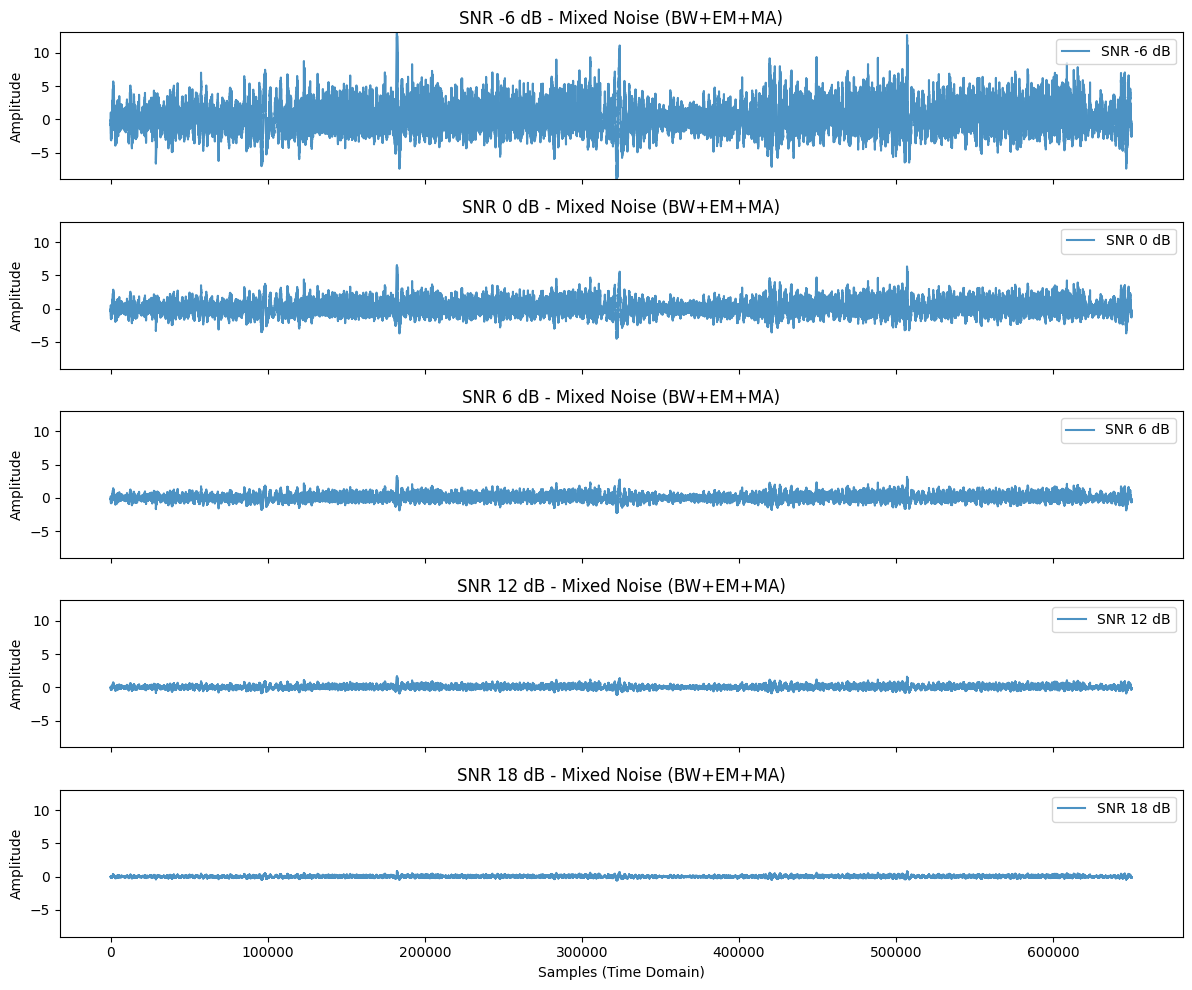

In [40]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

# SNR 레벨
snr_levels = [-6,  0, 6, 12, 18]
base_path = 'data2/'

def load_mixed_noise(snr_db):
    """ SNR별 혼합 노이즈 파일 불러오기 """
    with open(f'{base_path}Mixed_Noise_SNR_{snr_db}.pkl', 'rb') as f:
        noise = pickle.load(f)  # (2, 650000, 1)
    return noise.squeeze(-1)  # (2, 650000)

# 모든 데이터 로드하여 Y축 범위 확인
all_noises = [load_mixed_noise(snr) for snr in snr_levels]

# Y축 범위 계산 (모든 SNR에서 최대/최소값 찾기)
y_min = min(noise.min() for noise in all_noises)
y_max = max(noise.max() for noise in all_noises)

# 시각화
fig, axes = plt.subplots(len(snr_levels), 1, figsize=(12, 10), sharex=True, sharey=True)

for i, snr in enumerate(snr_levels):
    mixed_noise = all_noises[i]
    
    axes[i].plot(mixed_noise[0, :], label=f"SNR {snr} dB", alpha=0.8)
    axes[i].set_title(f"SNR {snr} dB - Mixed Noise (BW+EM+MA)")
    axes[i].set_ylabel("Amplitude")
    axes[i].set_ylim(y_min, y_max)  # Y축 동일하게 설정
    axes[i].legend(loc="upper right")

plt.xlabel("Samples (Time Domain)")
plt.tight_layout()
plt.show()


In [41]:
import numpy as np
import pickle
import wfdb

def load_noise(noise_type, snr_db, base_path='data2/'):
    """
    SNR별 BW, EM, MA 노이즈를 불러오는 함수
    """
    with open(f'{base_path}{noise_type}_Noise_SNR_{snr_db}.pkl', 'rb') as f:
        noise = pickle.load(f)  # Shape: (2, 650000, 1)
    return noise.squeeze(-1)  # Shape: (2, 650000)

def generate_combined_noise():
    """
    Chunk 단위로 BW, EM, MA 노이즈를 합쳐서 Train/Test 데이터 생성
    """
    snr_values = [-6,  0,  6, 12, 18]
    chunk_size = 10000
    total_samples = 650000
    num_chunks = total_samples // chunk_size
    
    combined_train = np.zeros((2, total_samples))
    combined_test = np.zeros((2, total_samples))
    
    np.random.seed(1234)  # Seed 설정
    
    for chunk_idx in range(num_chunks):
        start_idx = chunk_idx * chunk_size
        end_idx = start_idx + chunk_size
        
        # Random SNR 선택
        bw_snr = np.random.choice(snr_values)
        em_snr = np.random.choice(snr_values)
        ma_snr = np.random.choice(snr_values)
        
        # 해당 SNR의 노이즈 불러오기
        bw_noise = load_noise('BW', bw_snr)[:, start_idx:end_idx]
        em_noise = load_noise('EM', em_snr)[:, start_idx:end_idx]
        ma_noise = load_noise('MA', ma_snr)[:, start_idx:end_idx]
        
        # 채널별 합산하여 혼합 노이즈 생성
        mixed_noise = bw_noise + em_noise + ma_noise
        
        # Train / Test Split (Half and Half)
        if chunk_idx < num_chunks // 2:
            combined_train[:, start_idx:end_idx] = mixed_noise
        else:
            combined_test[:, start_idx:end_idx] = mixed_noise
    
    # 차원 확장하여 (2, 650000, 1) 형태로 저장
    combined_train = np.expand_dims(combined_train, axis=-1)
    combined_test = np.expand_dims(combined_test, axis=-1)
    
    with open('data2/CombinedNoise_Train.pkl', 'wb') as f:
        pickle.dump(combined_train, f)
    with open('data2/CombinedNoise_Test.pkl', 'wb') as f:
        pickle.dump(combined_test, f)
    
    print("[INFO] Combined Noise Train/Test 저장 완료!")

# 실행
generate_combined_noise()

import pickle
import numpy as np

# Load the data
with open('data2/CombinedNoise_Train.pkl', 'rb') as f:
    train_noise = pickle.load(f)  # Shape: (2, 650000, 1)

with open('data2/CombinedNoise_Test.pkl', 'rb') as f:
    test_noise = pickle.load(f)  # Shape: (2, 650000, 1)

# Calculate the half-length
total_length = train_noise.shape[1]  # 650000 samples
half_length = total_length // 2

# Combine the first half of train_noise with the second half of test_noise for each channel
combined_channel_0 = np.concatenate((train_noise[0, :half_length], test_noise[0, half_length:]), axis=0)
combined_channel_1 = np.concatenate((train_noise[1, :half_length], test_noise[1, half_length:]), axis=0)

# Reshape to (650000,)
combined_channel_0 = combined_channel_0.squeeze()  # Shape: (650000,)
combined_channel_1 = combined_channel_1.squeeze()  # Shape: (650000,)

# Save combined_channel_0 as CombinedNoise_Train.pkl
with open('data2/CombinedNoise_Train.pkl', 'wb') as f:
    pickle.dump(combined_channel_0, f)

# Save combined_channel_1 as CombinedNoise_Test.pkl
with open('data2/CombinedNoise_Test.pkl', 'wb') as f:
    pickle.dump(combined_channel_1, f)

print("Saved combined_channel_0 as CombinedNoise_Train.pkl with shape:", combined_channel_0.shape)
print("Saved combined_channel_1 as CombinedNoise_Test.pkl with shape:", combined_channel_1.shape)


[INFO] Combined Noise Train/Test 저장 완료!
Saved combined_channel_0 as CombinedNoise_Train.pkl with shape: (650000,)
Saved combined_channel_1 as CombinedNoise_Test.pkl with shape: (650000,)


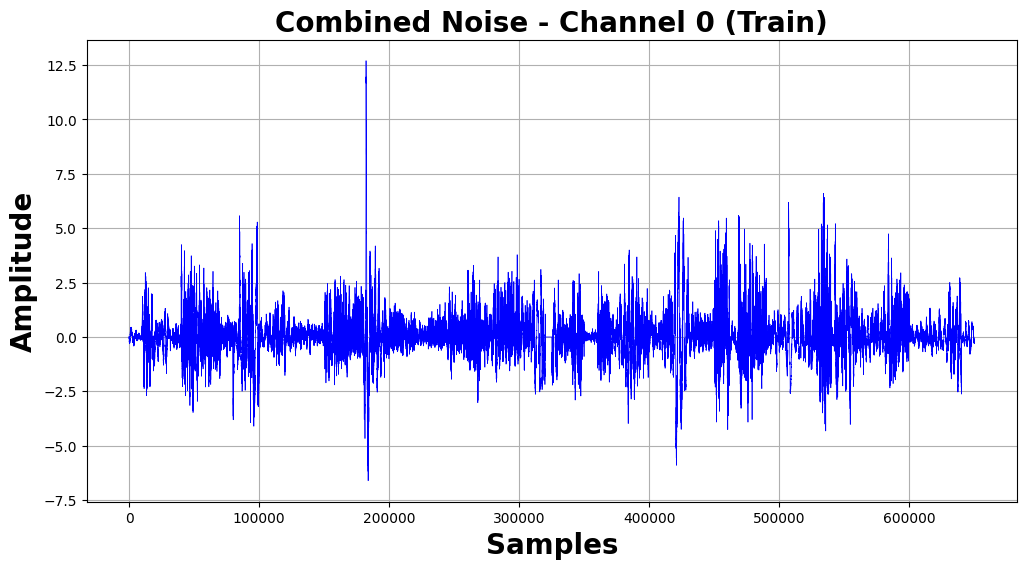

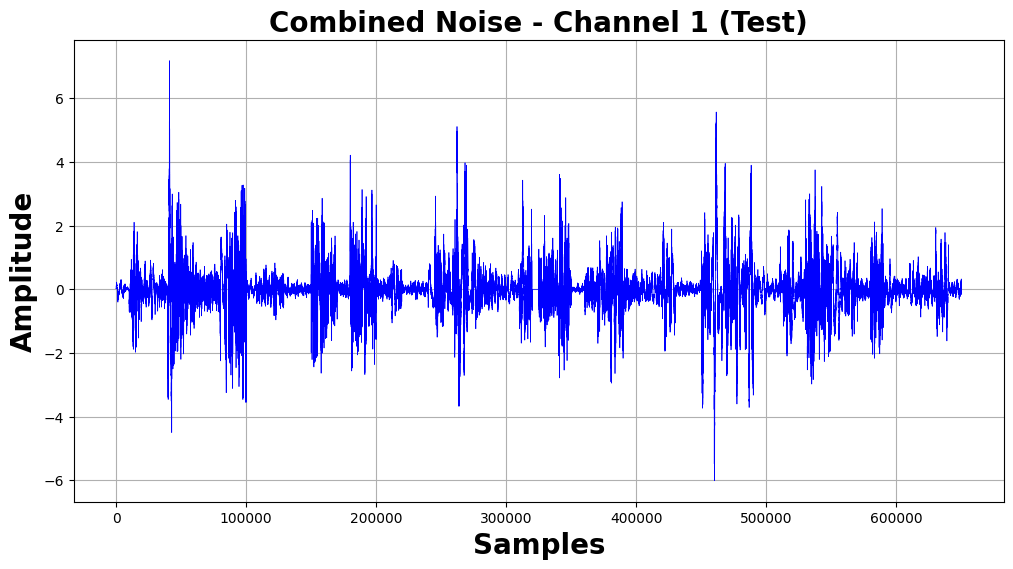

In [42]:
import matplotlib.pyplot as plt

def plot_noise(data, title, xlabel="Samples", ylabel="Amplitude"):
    plt.figure(figsize=(12, 6))
    plt.plot(data, color='blue', linewidth=0.5)
    
    # 제목과 레이블의 글꼴을 80포인트로 하고 굵게 설정
    plt.title(title, fontsize=20, fontweight='bold')
    plt.xlabel(xlabel, fontsize=20, fontweight='bold')
    plt.ylabel(ylabel, fontsize=20, fontweight='bold')
    
    plt.grid(True)
    plt.show()

# combined_channel_0 시각화 (CombinedNoise_Train.pkl)
plot_noise(combined_channel_0, "Combined Noise - Channel 0 (Train)")

# combined_channel_1 시각화 (CombinedNoise_Test.pkl)
plot_noise(combined_channel_1, "Combined Noise - Channel 1 (Test)")

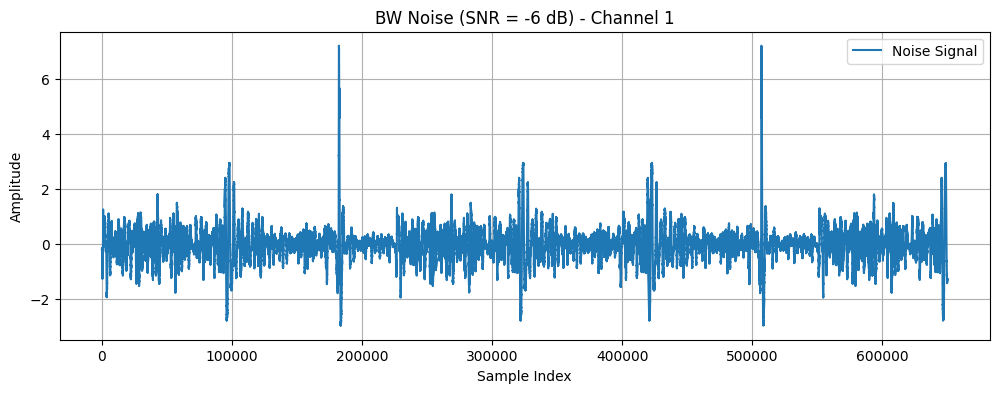

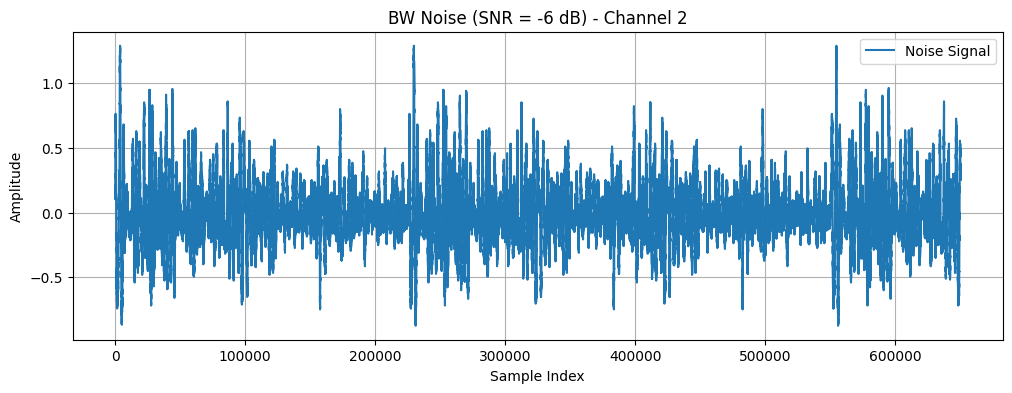

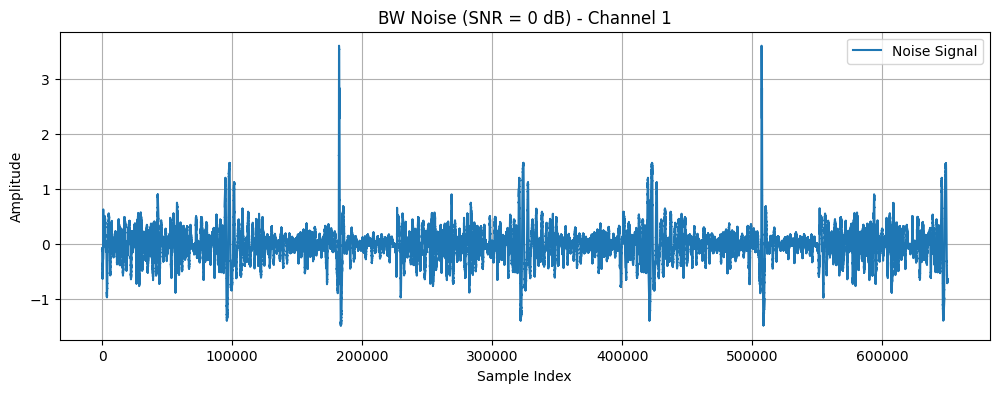

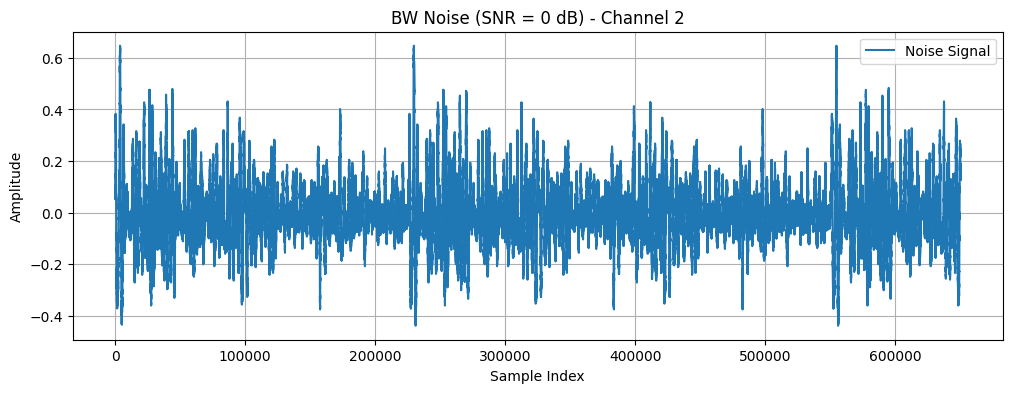

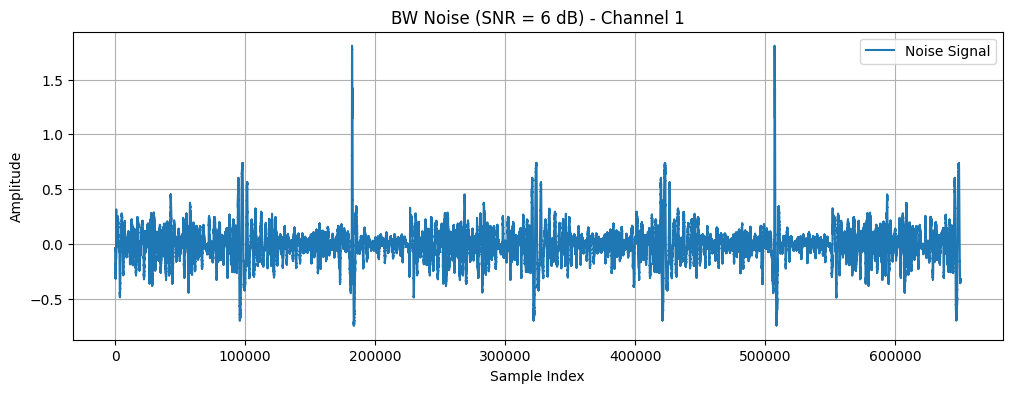

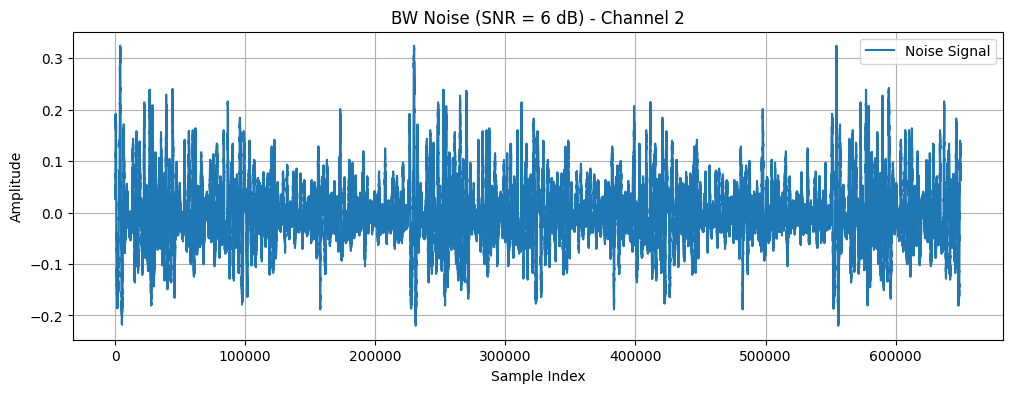

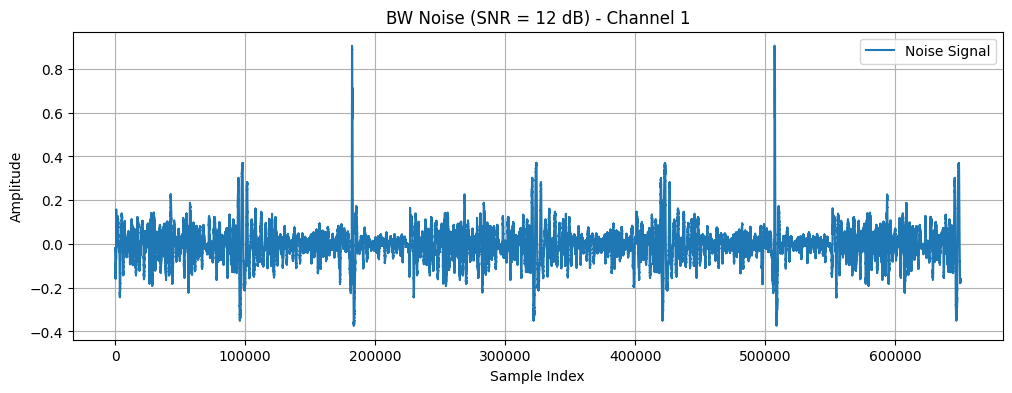

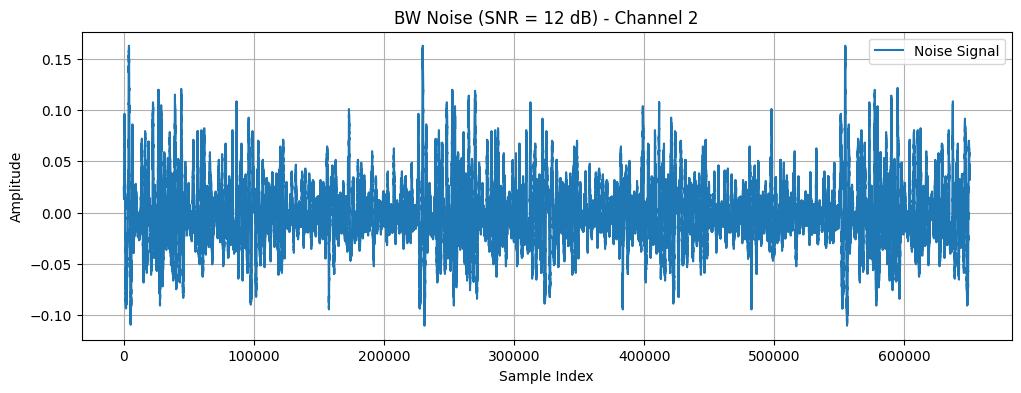

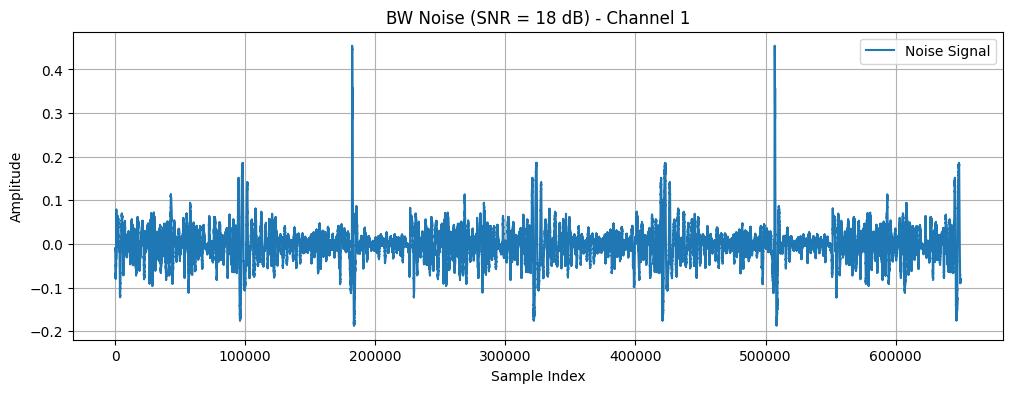

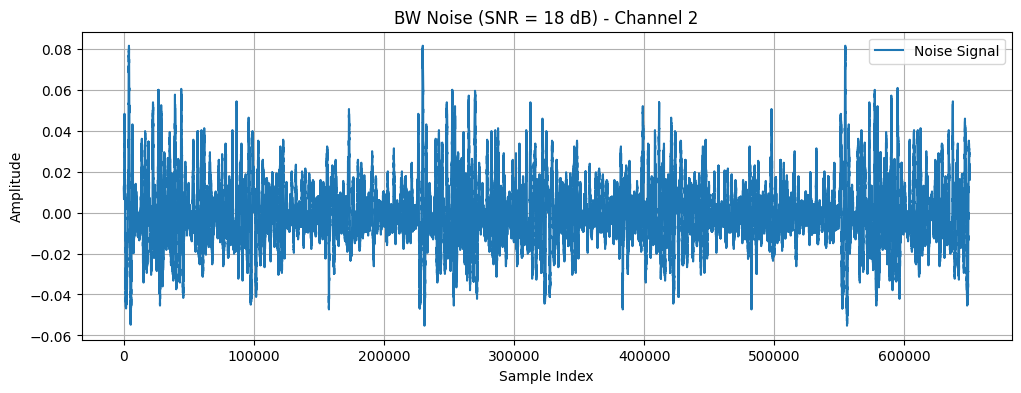

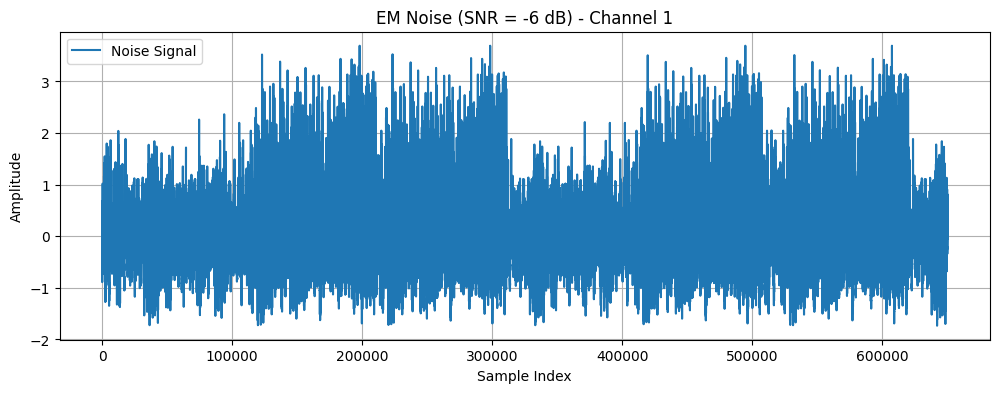

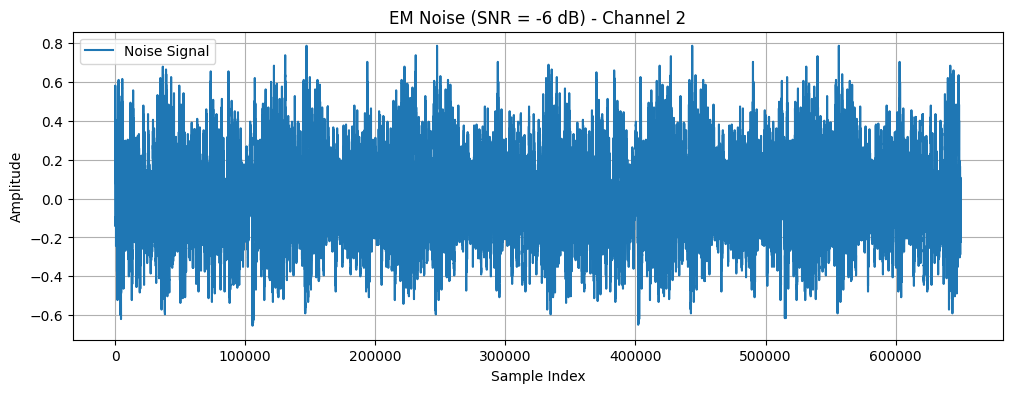

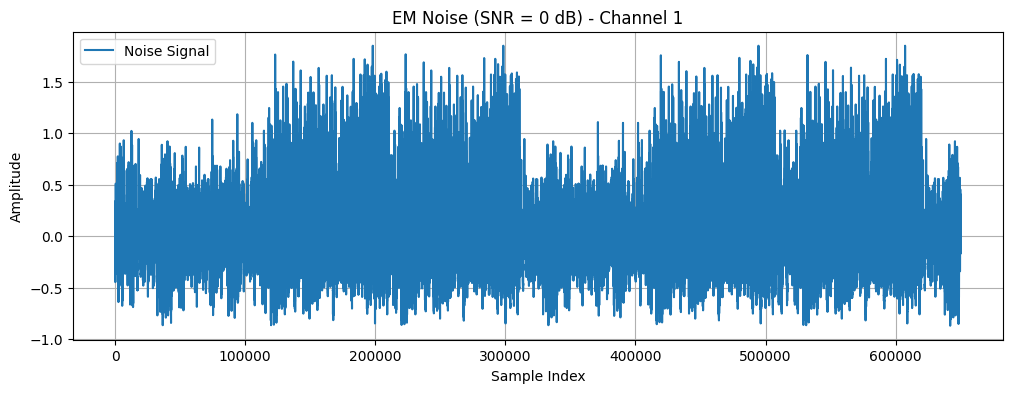

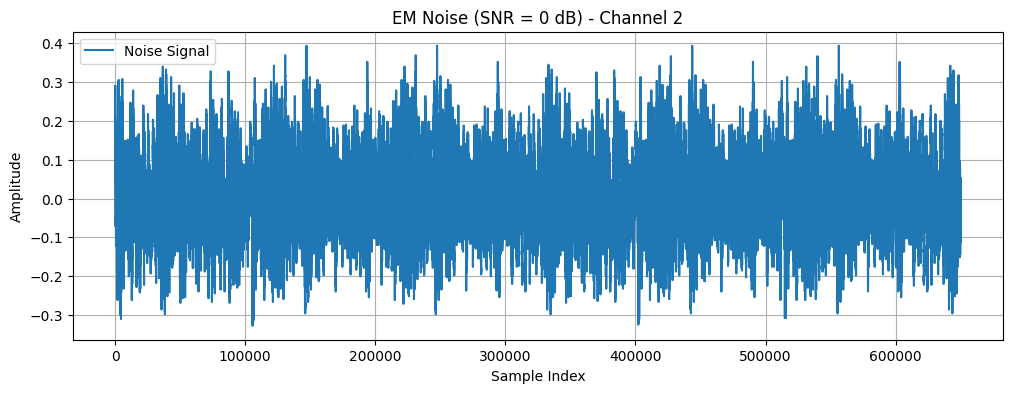

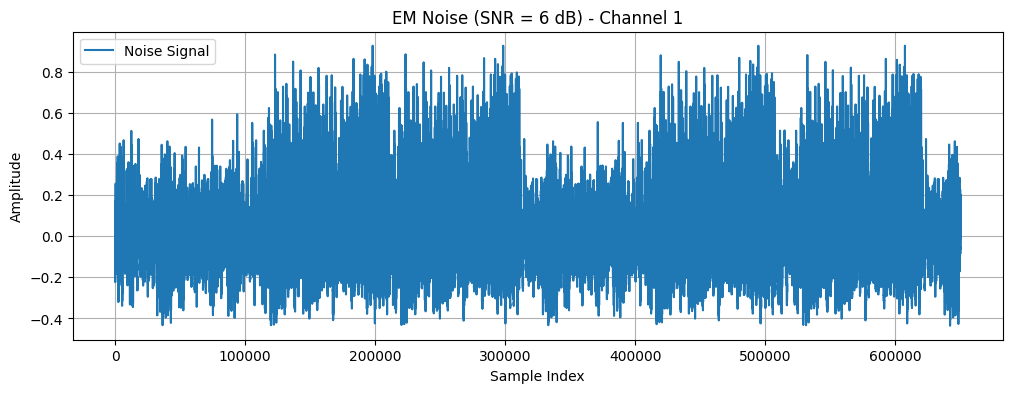

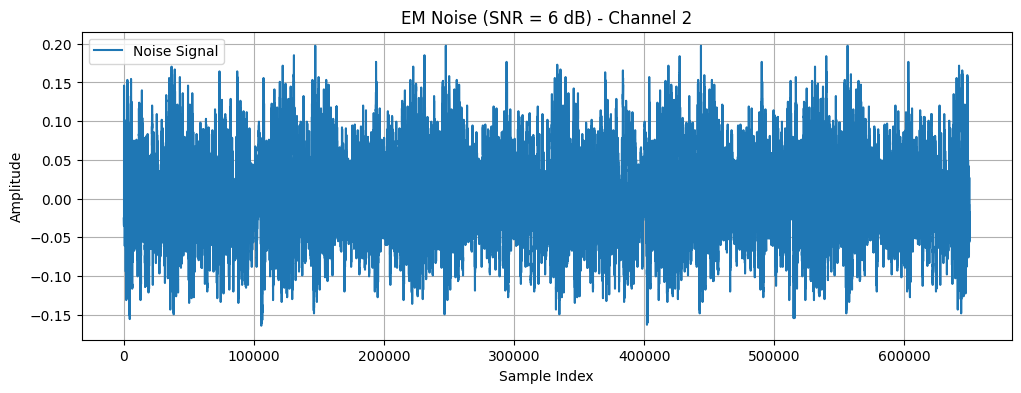

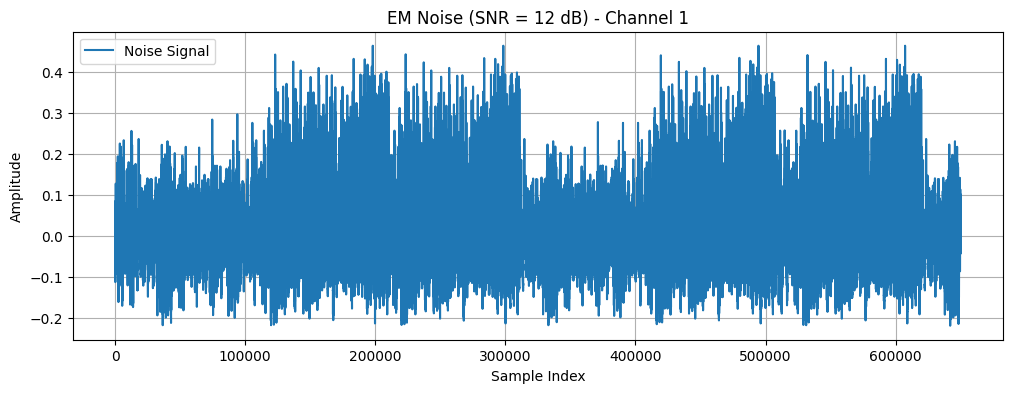

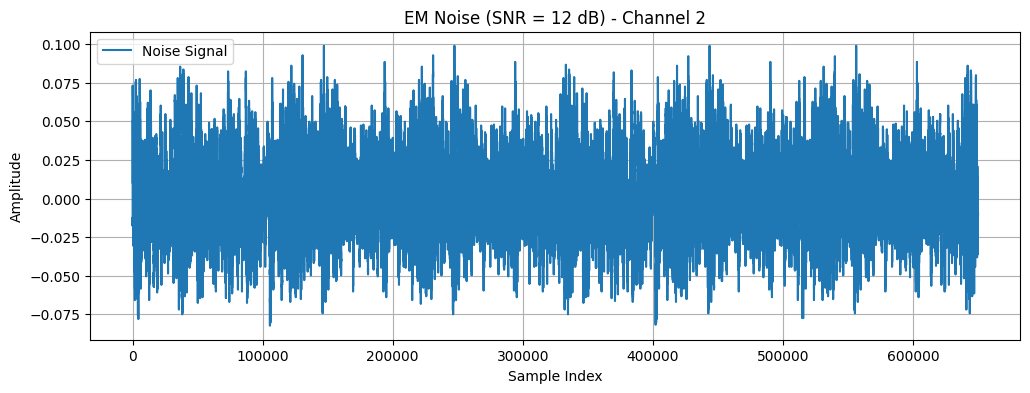

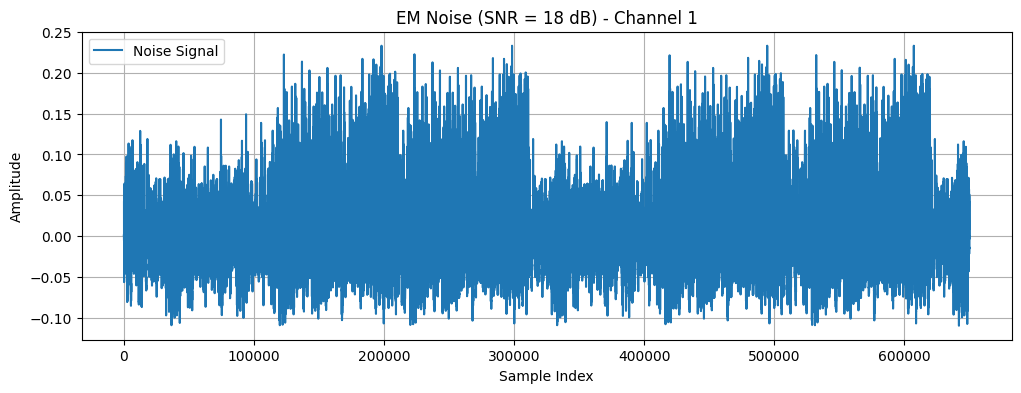

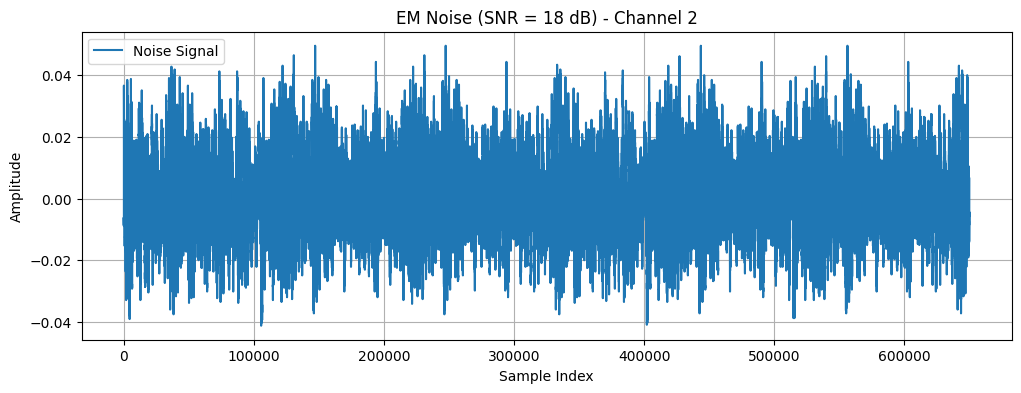

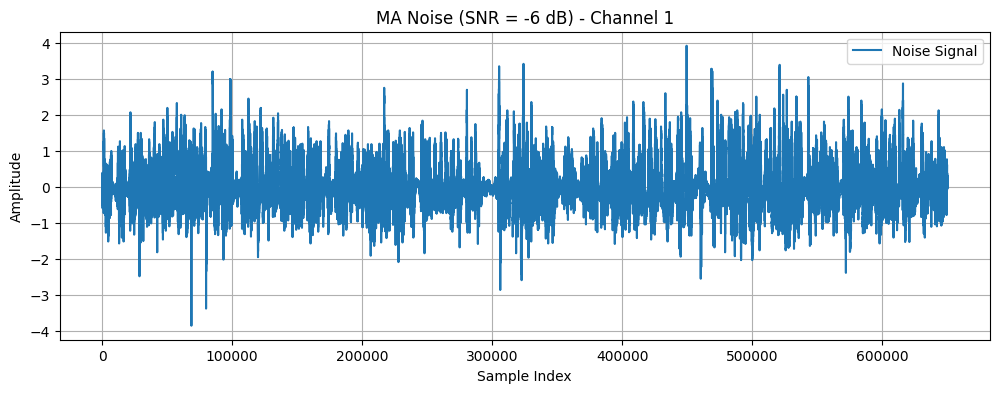

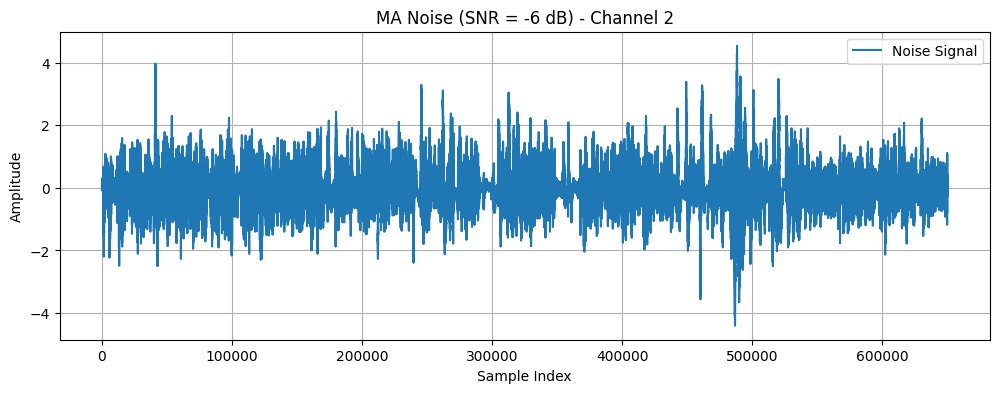

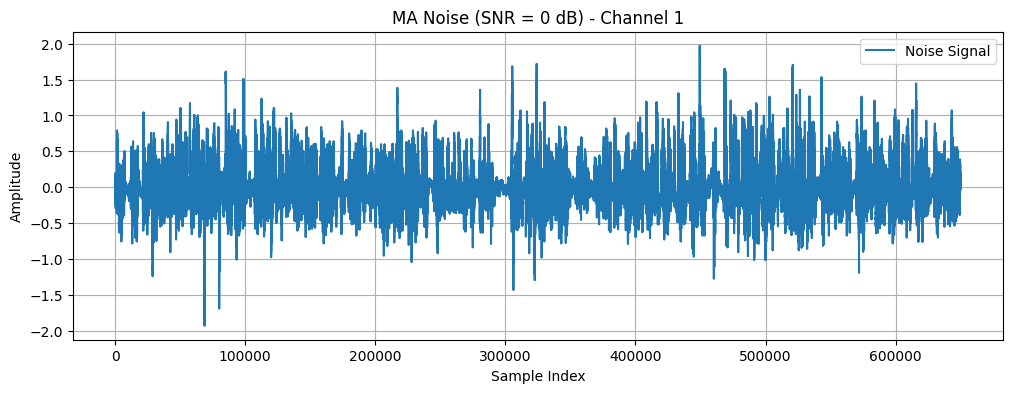

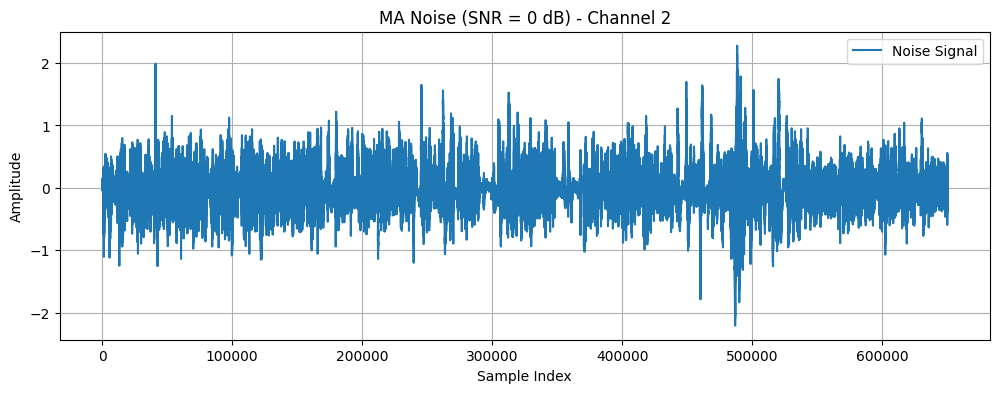

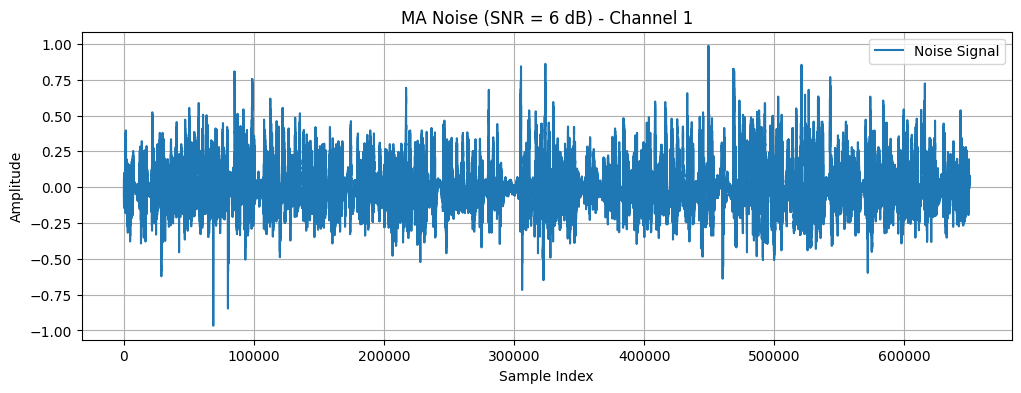

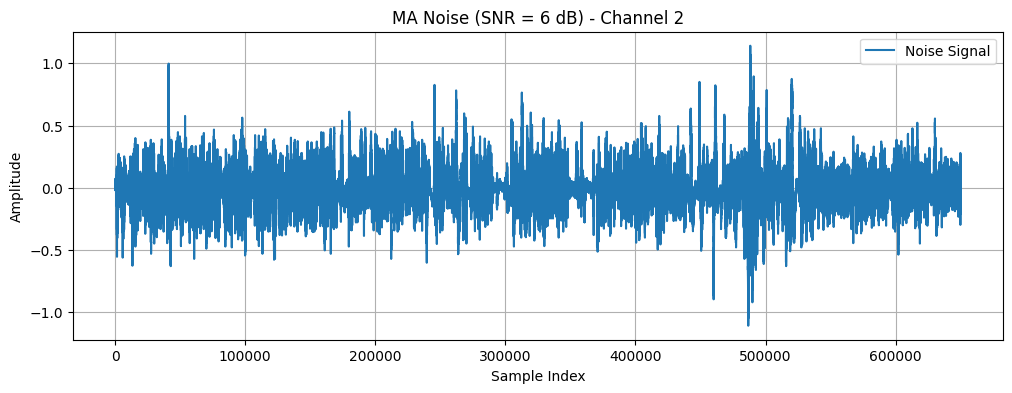

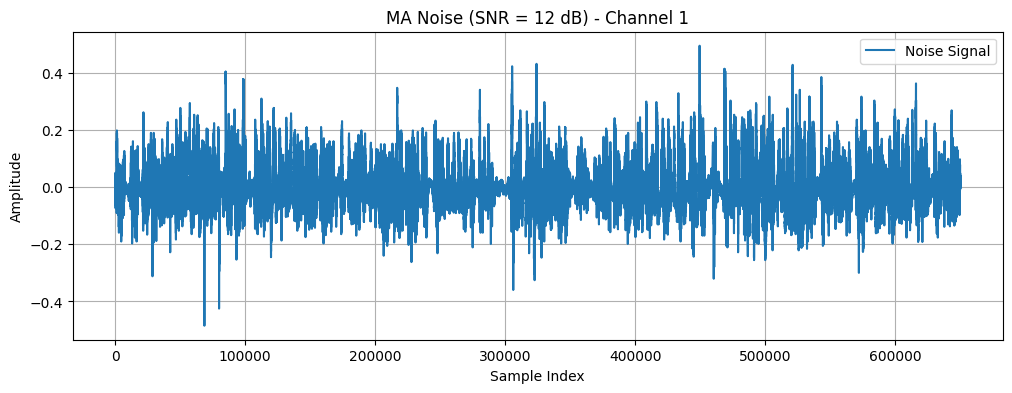

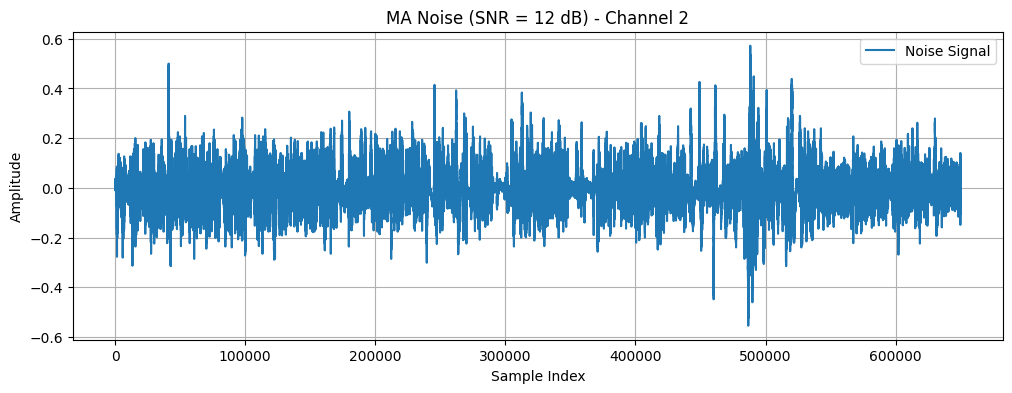

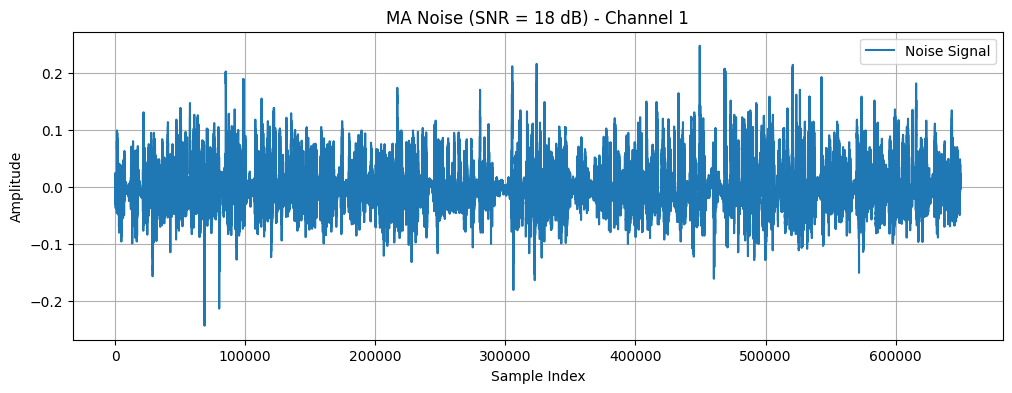

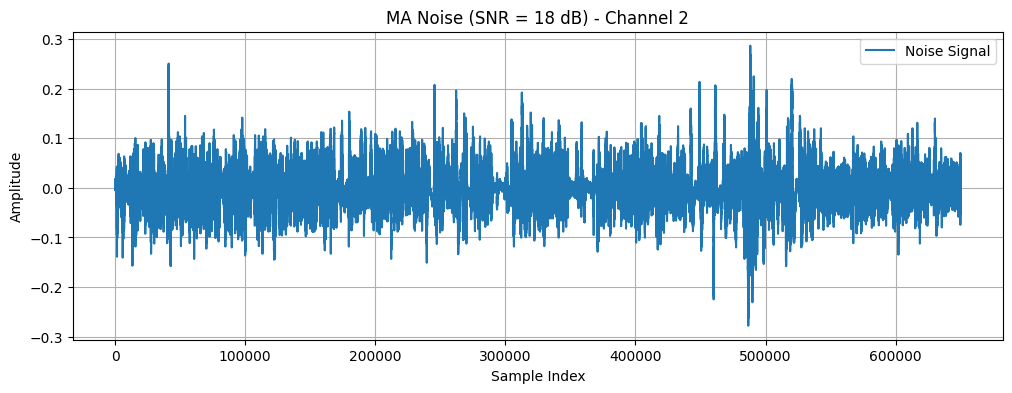

[INFO] 모든 노이즈 시각화 완료!


In [43]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

# 시각화 함수
def plot_noise_sample(noise, title, sample_range=(0, 650000)):
    """
    특정 범위의 노이즈 신호를 시각화하는 함수
    """
    plt.figure(figsize=(12, 4))
    plt.plot(noise[sample_range[0]:sample_range[1]], label="Noise Signal")
    plt.title(title)
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()

# ==============================
# ✅ 15개 개별 노이즈 시각화 (BW, EM, MA 각 5개 SNR)
# ==============================
snr_levels = [-6, 0, 6, 12, 18]
noise_types = ['BW', 'EM', 'MA']

for noise_type in noise_types:
    for snr in snr_levels:
        with open(f'data/{noise_type}_Noise_SNR_{snr}.pkl', 'rb') as f:
            noise_data = pickle.load(f)  # Shape: (2, 650000, 1)

        # 첫 번째 채널 시각화
        plot_noise_sample(noise_data[0, :, 0], f"{noise_type} Noise (SNR = {snr} dB) - Channel 1")

        # 두 번째 채널 시각화
        plot_noise_sample(noise_data[1, :, 0], f"{noise_type} Noise (SNR = {snr} dB) - Channel 2")

print("[INFO] 모든 노이즈 시각화 완료!")


# 기본

In [1]:
import numpy as np
import wfdb
import _pickle as pickle

import pickle

In [2]:
# def SSD(y, y_pred):
#     return np.sum(np.square(y - y_pred), axis=1)  # axis 1 is the signal dimension
from sklearn.metrics.pairwise import cosine_similarity

# def MAD(y, y_pred):
#     return np.max(np.abs(y - y_pred), axis=1) # axis 1 is the signal dimension
def RMSE(y, y_pred):
    """
    RMSE (Root Mean Square Error) 계산 (mV 단위)
    - y: 원본 신호
    - y_pred: 예측된 신호
    """
    mse = np.mean(np.square(y - y_pred), axis=1)  # MSE 계산
    rmse = np.sqrt(mse)  # RMSE 변환
    return rmse  # 단위: mV

def PRD(y, y_pred):
    N = np.sum(np.square(y_pred - y), axis=1)
    D = np.sum(np.square(y_pred - np.mean(y)), axis=1)

    PRD = np.sqrt(N/D) * 100

    return PRD

def COS_SIM(y, y_pred):
    cos_sim = []

    y = np.squeeze(y, axis=-1)
    y_pred = np.squeeze(y_pred, axis=-1)

    for idx in range(len(y)):
        kl_temp = cosine_similarity(y[idx].reshape(1, -1), y_pred[idx].reshape(1, -1))
        cos_sim.append(kl_temp)

    cos_sim = np.array(cos_sim)
    return cos_sim

def SNR(y, y_pred):
    signal_power = np.sum(np.square(y), axis=1)
    noise_power = np.sum(np.square(y - y_pred), axis=1)
    
    # 분모가 0이 되는 것을 방지하기 위해 작은 값을 더해줌
    noise_power = np.where(noise_power == 0, 1e-10, noise_power)
    
    snr_value = 10 * np.log10(signal_power / noise_power)
    return snr_value


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from prettytable import PrettyTable

def generate_table(metrics, metric_values, Exp_names):
    # Print tabular results in the console, in a pretty way
    print('\n')

    tb = PrettyTable()
    ind = 0

    for exp_name in Exp_names:

        tb.field_names = ['Model'] + metrics

        tb_row = []
        tb_row.append(exp_name)

        for metric in metric_values:   # metric_values[metric][model][beat]
            m_mean = np.mean(metric[ind])
            m_std = np.std(metric[ind])
            tb_row.append('{:.3f}'.format(m_mean) + ' (' + '{:.3f}'.format(m_std) + ')')

        tb.add_row(tb_row)
        ind += 1

    print(tb)

def generate_table_time(column_names, all_values, Exp_names, gpu=True):
    # Print tabular results in the console, in a pretty way

    # The FIR and IIR are the last on all_values
    # We need circular shift them to the right
    all_values[0] = all_values[0][-2::] + all_values[0][0:-2]
    all_values[1] = all_values[1][-2::] + all_values[1][0:-2]

    print('\n')

    tb = PrettyTable()
    ind = 0

    if gpu:
        device = 'GPU'
    else:
        device = 'CPU'

    for exp_name in Exp_names:
        tb.field_names = ['Method/Model'] + [column_names[0] + '(' + device + ') h:m:s:ms'] + [
            column_names[1] + '(' + device + ') h:m:s:ms']

        tb_row = []
        tb_row.append(exp_name)
        tb_row.append(all_values[0][ind])
        tb_row.append(all_values[1][ind])

        tb.add_row(tb_row)

        ind += 1

    print(tb)

    if gpu:
        print('* For FIR and IIR Filters is CPU since scipy filters are CPU based implementations')

In [4]:

qt='/home/dhc99/ecg_denoise/data/QTDatabase.pkl'
with open(qt, 'rb') as f:
    data = pickle.load(f)
# Assuming data['sele0122'] is a list containing a single NumPy array
print(len(data['sele0122']))

# Check the lengths of each array in the list
lengths = [len(arr) for arr in data['sele0122']]
print("Lengths of arrays:", lengths)


1412
Lengths of arrays: [228, 227, 227, 224, 224, 228, 227, 227, 225, 228, 228, 229, 229, 229, 225, 225, 224, 225, 224, 224, 224, 224, 224, 224, 224, 225, 222, 221, 219, 222, 221, 221, 224, 224, 222, 225, 225, 227, 227, 224, 227, 228, 229, 229, 232, 229, 229, 231, 229, 229, 229, 228, 228, 228, 227, 227, 227, 225, 225, 224, 222, 221, 221, 219, 219, 219, 219, 219, 218, 221, 219, 219, 219, 221, 222, 224, 222, 224, 224, 227, 227, 225, 228, 229, 227, 228, 228, 227, 229, 227, 228, 228, 229, 225, 228, 227, 228, 228, 225, 227, 228, 225, 221, 222, 224, 219, 221, 221, 219, 221, 221, 221, 222, 219, 219, 221, 219, 222, 219, 222, 222, 224, 222, 224, 222, 225, 225, 224, 227, 227, 227, 225, 227, 225, 224, 222, 225, 219, 222, 224, 224, 221, 219, 221, 222, 219, 221, 222, 222, 221, 228, 229, 228, 231, 231, 231, 232, 229, 228, 231, 229, 229, 229, 229, 229, 227, 229, 229, 227, 227, 225, 225, 222, 222, 222, 222, 221, 218, 219, 218, 218, 219, 218, 221, 221, 222, 221, 222, 225, 228, 228, 229, 229, 232, 234, 

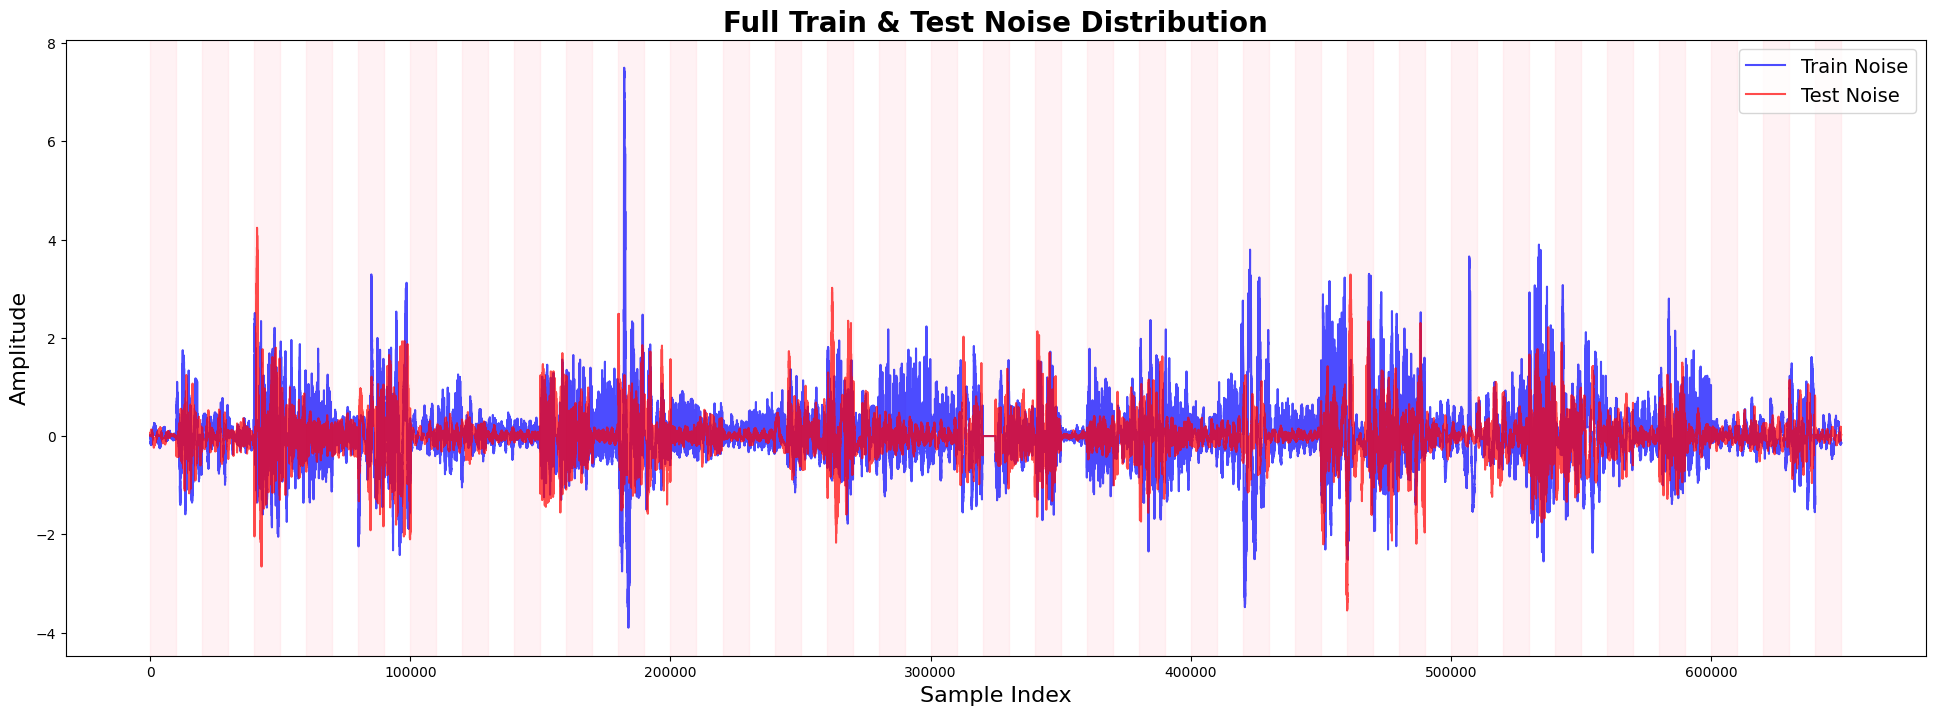

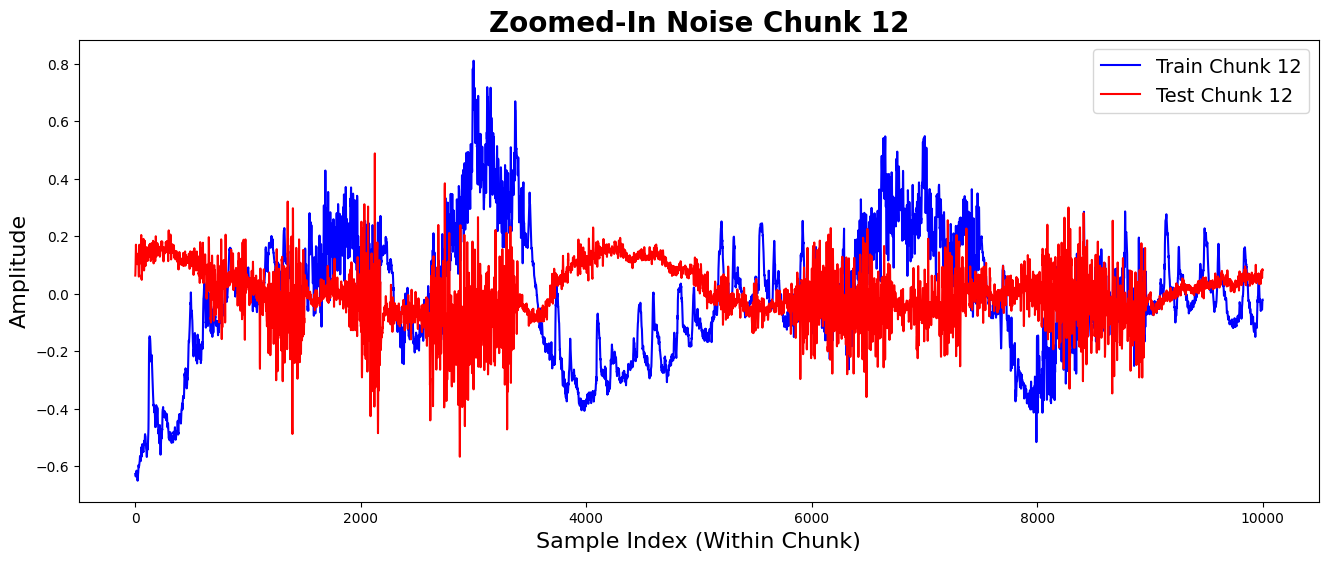

In [5]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load Train and Test Noise
train_noise_path = 'data/CombinedNoise_Train.pkl'
test_noise_path = 'data/CombinedNoise_Test.pkl'

with open(train_noise_path, 'rb') as f:
    train_noise = pickle.load(f)  # Shape: (650000, 1)

with open(test_noise_path, 'rb') as f:
    test_noise = pickle.load(f)  # Shape: (650000, 1)

# # Load SNR Log (Assumes snr_info was saved separately)
# snr_log_path = 'data/SNR_Log.pkl'  # Ensure you save snr_info separately
# with open(snr_log_path, 'rb') as f:
#     snr_info = pickle.load(f)  # List of dictionaries containing SNR data

chunk_size = 10000
num_chunks = train_noise.shape[0] // chunk_size
x_full = np.arange(train_noise.shape[0])

# 🚀 **1️⃣ Plot Full Train & Test Noise**
plt.figure(figsize=(24, 8))
plt.plot(x_full, train_noise, label="Train Noise", color="blue", alpha=0.7)
plt.plot(x_full, test_noise, label="Test Noise", color="red", alpha=0.7)

# Highlight alternating chunks
for i in range(num_chunks):
    if i % 2 == 0:
        plt.axvspan(i * chunk_size, (i + 1) * chunk_size, color="pink", alpha=0.2)

plt.title("Full Train & Test Noise Distribution", fontsize=20, fontweight="bold")
plt.xlabel("Sample Index", fontsize=16)
plt.ylabel("Amplitude", fontsize=16)
plt.legend(fontsize=14)
plt.show()

# 🚀 **2️⃣ Zoomed-In View of a Specific Chunk**
zoom_chunk_idx = 12  # Change this to zoom into different chunks
start_idx = zoom_chunk_idx * chunk_size
end_idx = start_idx + chunk_size
x_zoom = np.arange(chunk_size)

plt.figure(figsize=(16, 6))
plt.plot(x_zoom, train_noise[start_idx:end_idx], label=f"Train Chunk {zoom_chunk_idx}", color="blue")
plt.plot(x_zoom, test_noise[start_idx:end_idx], label=f"Test Chunk {zoom_chunk_idx}", color="red")

plt.title(f"Zoomed-In Noise Chunk {zoom_chunk_idx}", fontsize=20, fontweight="bold")
plt.xlabel("Sample Index (Within Chunk)", fontsize=16)
plt.ylabel("Amplitude", fontsize=16)
plt.legend(fontsize=14)
plt.show()



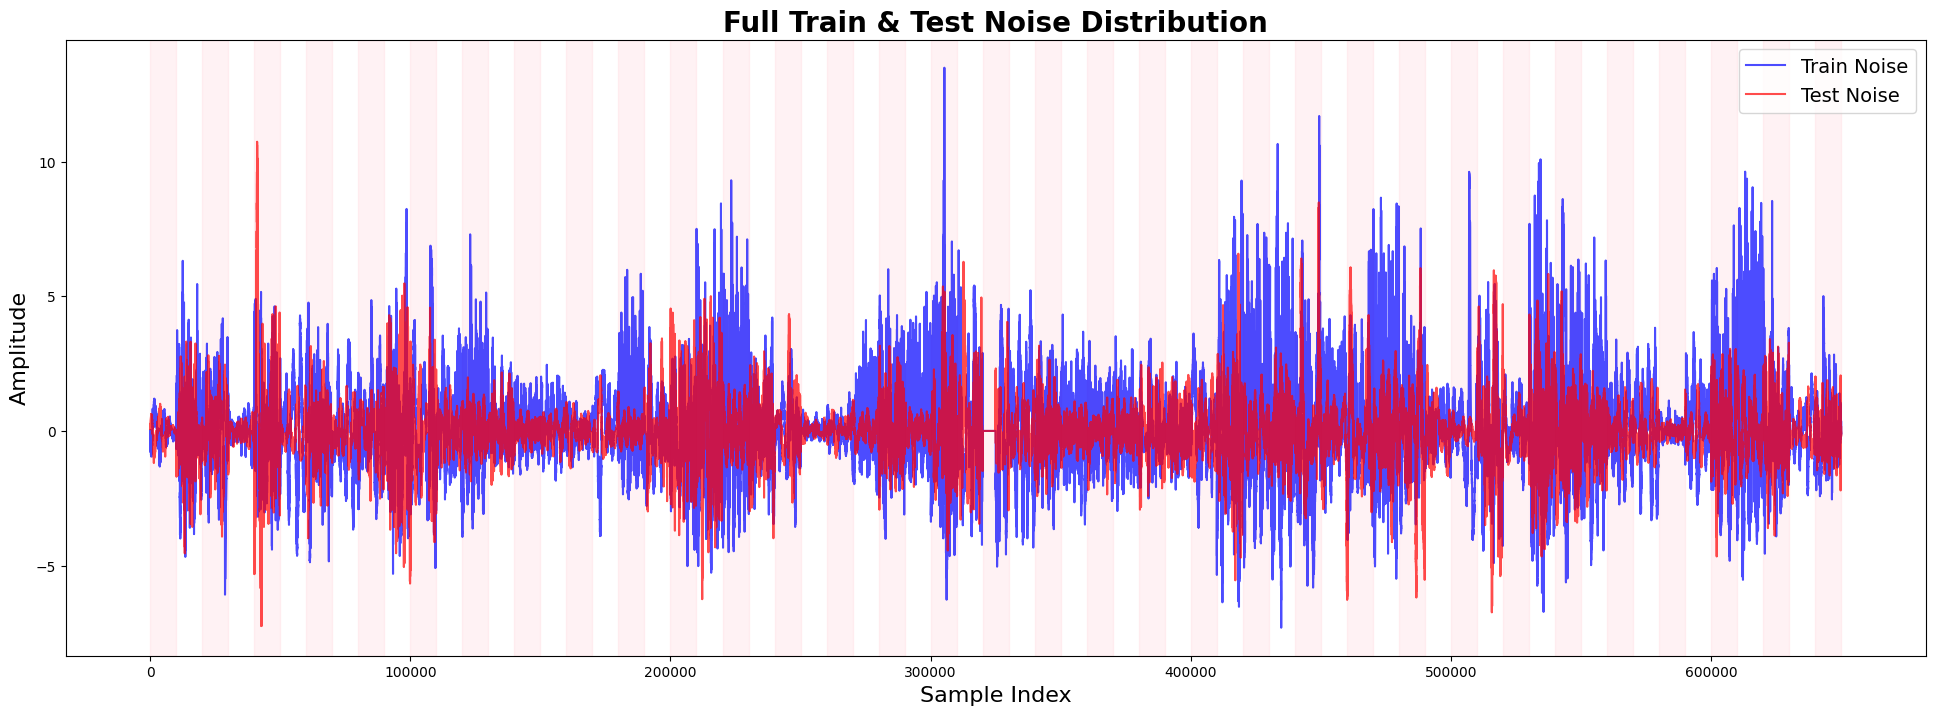

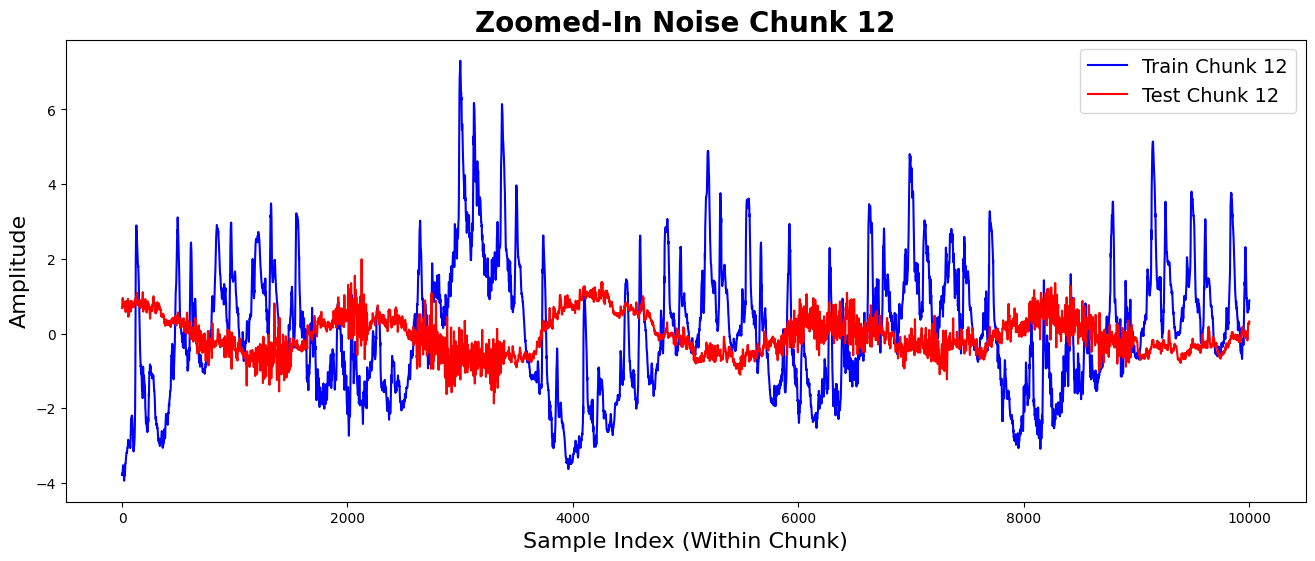

In [6]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load Train and Test Noise
train_noise_path = 'data2/CombinedNoise_Train.pkl'
test_noise_path = 'data2/CombinedNoise_Test.pkl'

with open(train_noise_path, 'rb') as f:
    train_noise = pickle.load(f)  # Shape: (650000, 1)

with open(test_noise_path, 'rb') as f:
    test_noise = pickle.load(f)  # Shape: (650000, 1)


chunk_size = 10000
num_chunks = train_noise.shape[0] // chunk_size
x_full = np.arange(train_noise.shape[0])

# 🚀 **1️⃣ Plot Full Train & Test Noise**
plt.figure(figsize=(24, 8))
plt.plot(x_full, train_noise, label="Train Noise", color="blue", alpha=0.7)
plt.plot(x_full, test_noise, label="Test Noise", color="red", alpha=0.7)

# Highlight alternating chunks
for i in range(num_chunks):
    if i % 2 == 0:
        plt.axvspan(i * chunk_size, (i + 1) * chunk_size, color="pink", alpha=0.2)

plt.title("Full Train & Test Noise Distribution", fontsize=20, fontweight="bold")
plt.xlabel("Sample Index", fontsize=16)
plt.ylabel("Amplitude", fontsize=16)
plt.legend(fontsize=14)
plt.show()

# 🚀 **2️⃣ Zoomed-In View of a Specific Chunk**
zoom_chunk_idx = 12  # Change this to zoom into different chunks
start_idx = zoom_chunk_idx * chunk_size
end_idx = start_idx + chunk_size
x_zoom = np.arange(chunk_size)

plt.figure(figsize=(16, 6))
plt.plot(x_zoom, train_noise[start_idx:end_idx], label=f"Train Chunk {zoom_chunk_idx}", color="blue")
plt.plot(x_zoom, test_noise[start_idx:end_idx], label=f"Test Chunk {zoom_chunk_idx}", color="red")

plt.title(f"Zoomed-In Noise Chunk {zoom_chunk_idx}", fontsize=20, fontweight="bold")
plt.xlabel("Sample Index (Within Chunk)", fontsize=16)
plt.ylabel("Amplitude", fontsize=16)
plt.legend(fontsize=14)
plt.show()

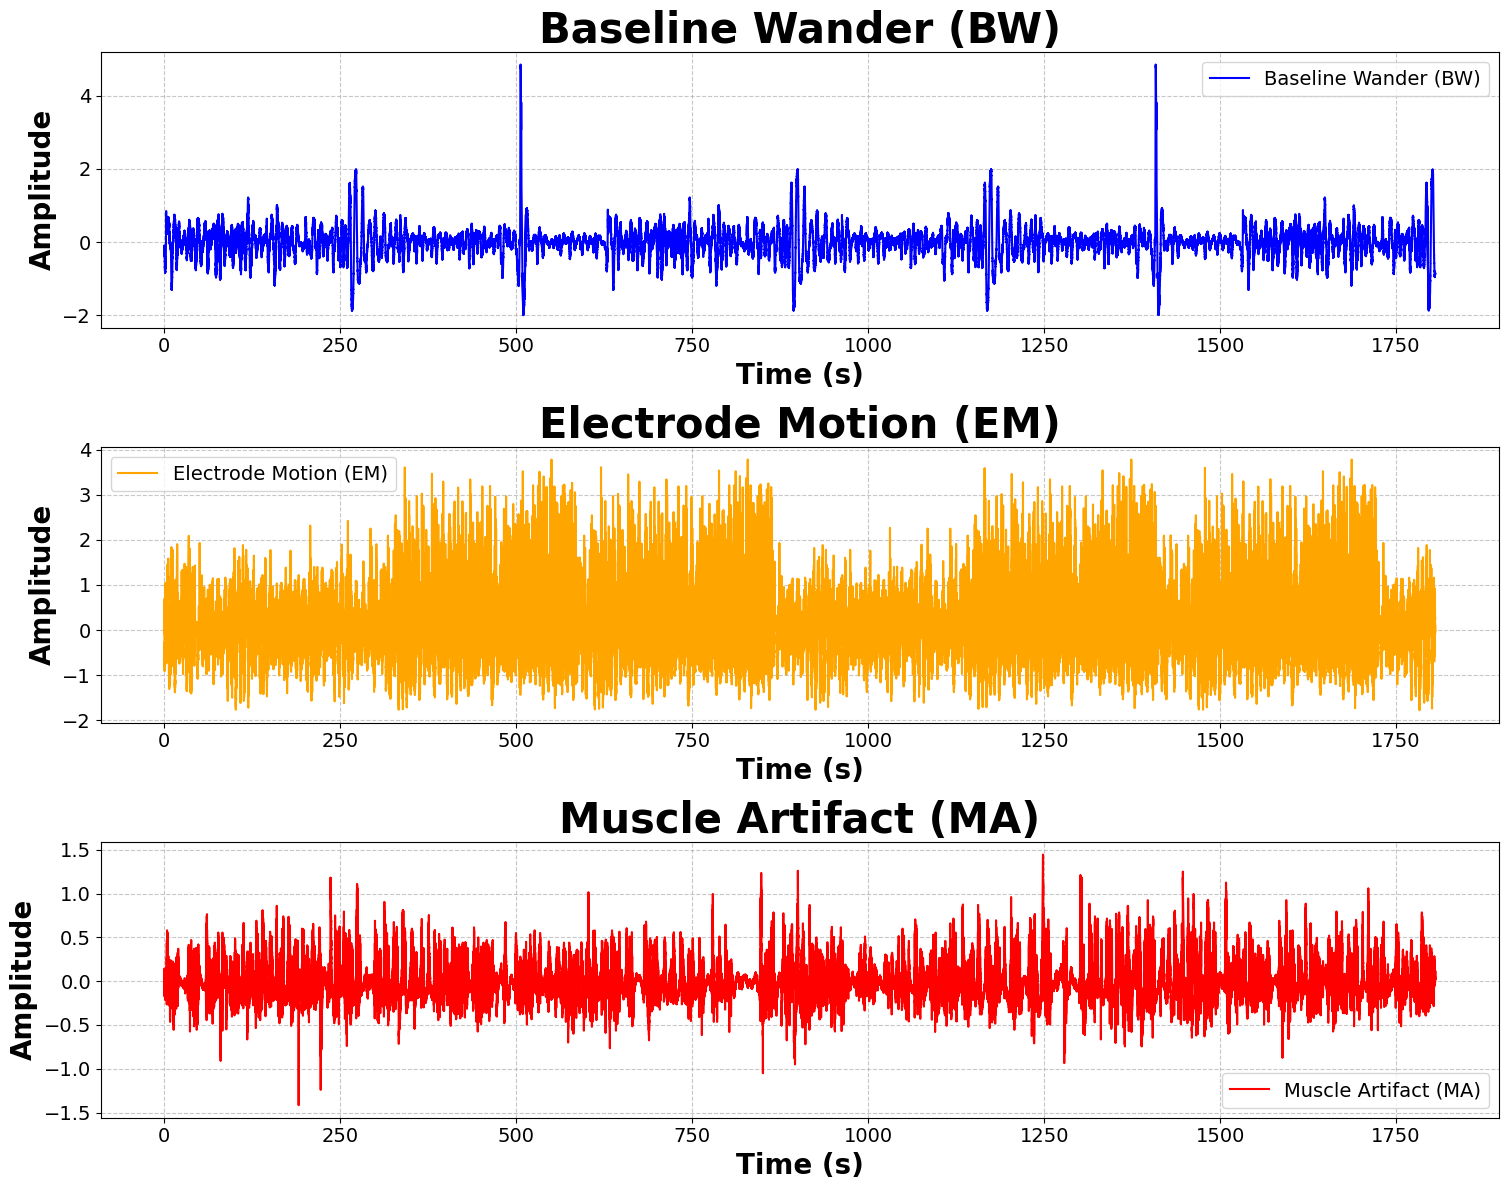

In [7]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np

def visualize_nstdb_noise_full(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
    """
    Visualizes the full duration of each noise type from the MIT-BIH Noise Stress Test Database (NSTDB):
    Baseline Wander (BW), Electrode Motion (EM), and Muscle Artifact (MA).
    """
    # Load NSTDB noise signals
    bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
    em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
    ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')
    
    # Define sampling frequency and time vector
    fs = 360  # NSTDB sampling frequency is 360 Hz
    duration_bw = len(bw_signals) / fs
    duration_em = len(em_signals) / fs
    duration_ma = len(ma_signals) / fs

    time_bw = np.linspace(0, duration_bw, len(bw_signals))
    time_em = np.linspace(0, duration_em, len(em_signals))
    time_ma = np.linspace(0, duration_ma, len(ma_signals))

    # # Apply a stylish matplotlib theme
    # plt.style.use('seaborn-darkgrid')

    # Plot each noise signal
    plt.figure(figsize=(15, 12))
    
    # Baseline Wander
    plt.subplot(3, 1, 1)
    plt.plot(time_bw, bw_signals[:, 0], label='Baseline Wander (BW)', color='blue', linewidth=1.5)
    plt.title(f'Baseline Wander (BW)', fontsize=30, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=20, fontweight='bold')
    plt.ylabel('Amplitude', fontsize=20, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=14)
    
    # Electrode Motion
    plt.subplot(3, 1, 2)
    plt.plot(time_em, em_signals[:, 0], label='Electrode Motion (EM)', color='orange', linewidth=1.5)
    plt.title(f'Electrode Motion (EM)', fontsize=30, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=20, fontweight='bold')
    plt.ylabel('Amplitude', fontsize=20, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=14)
    
    # Muscle Artifact
    plt.subplot(3, 1, 3)
    plt.plot(time_ma, ma_signals[:, 0], label='Muscle Artifact (MA)', color='red', linewidth=1.5)
    plt.title(f'Muscle Artifact (MA)', fontsize=30, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=20, fontweight='bold')
    plt.ylabel('Amplitude', fontsize=20, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=14)

    plt.tight_layout()
    plt.show()

# Example usage:
visualize_nstdb_noise_full()

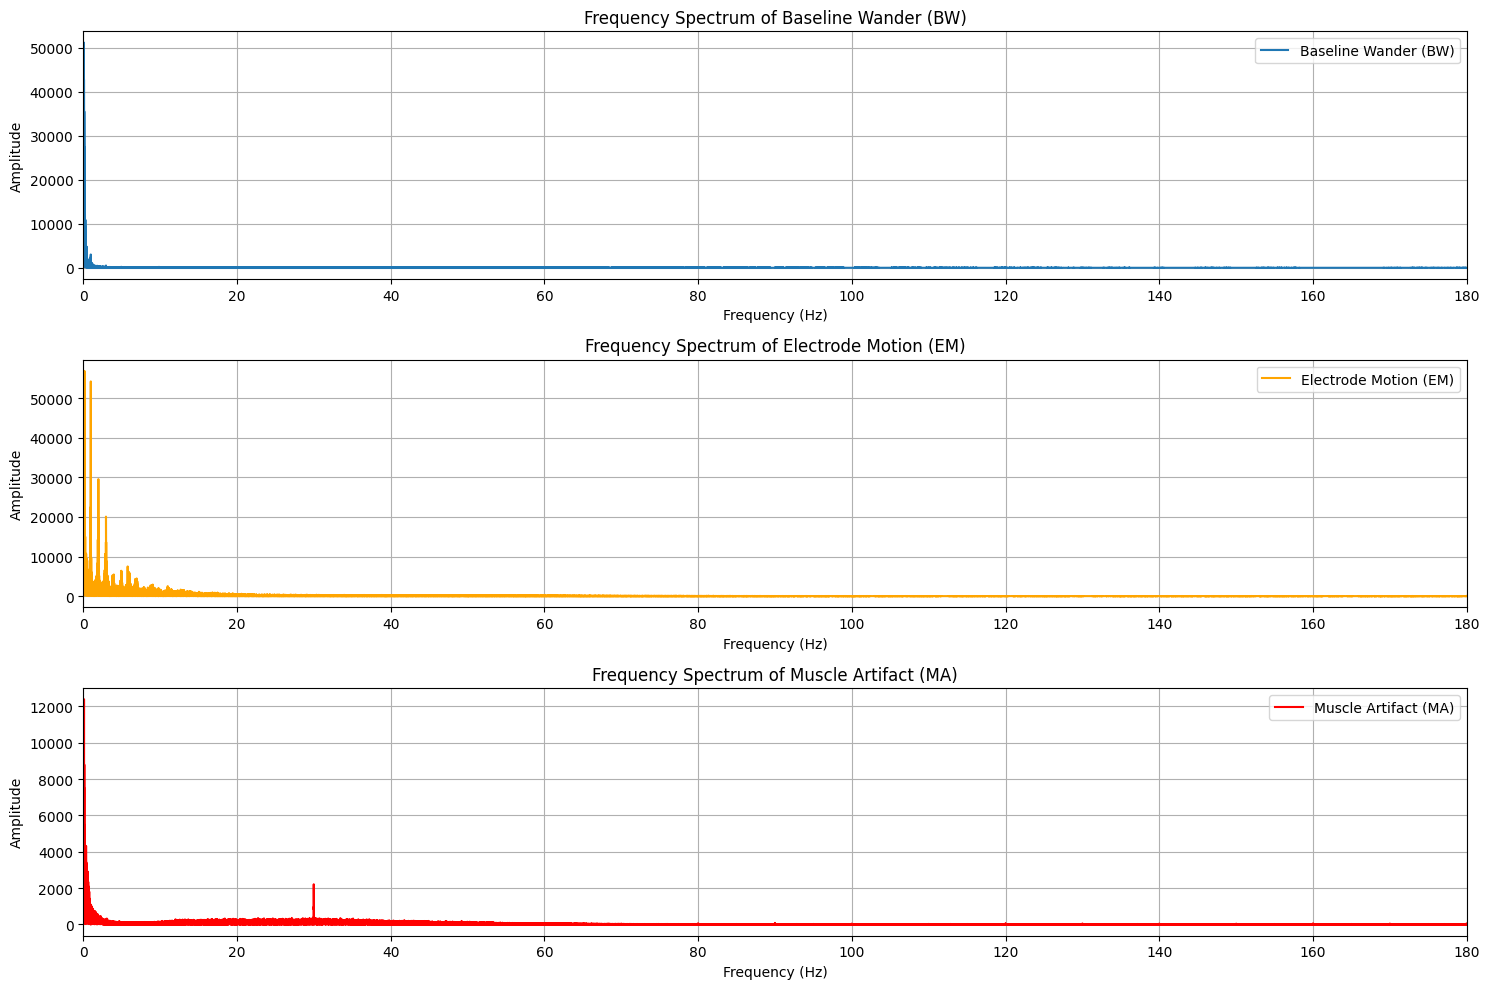

In [8]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt

def plot_nstdb_frequency_spectrum(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
    """
    Computes and visualizes the frequency spectrum of each noise type from 
    the MIT-BIH Noise Stress Test Database (NSTDB): 
    - Baseline Wander (BW)
    - Electrode Motion (EM)
    - Muscle Artifact (MA)

    Uses FFT to analyze frequency components.
    """
    # Load NSTDB noise signals
    bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
    em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
    ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')

    # Define sampling frequency
    fs = 360  # NSTDB sampling frequency is 360 Hz

    # Select first channel and flatten the signal
    bw_signal = bw_signals[:, 0]
    em_signal = em_signals[:, 0]
    ma_signal = ma_signals[:, 0]

    # Compute FFT
    def compute_fft(signal, fs):
        N = len(signal)  # Number of samples
        fft_vals = np.fft.fft(signal)  # FFT computation
        fft_freqs = np.fft.fftfreq(N, d=1/fs)  # Frequency bins
        return fft_freqs[:N // 2], np.abs(fft_vals[:N // 2])  # Return positive frequencies

    freq_bw, fft_bw = compute_fft(bw_signal, fs)
    freq_em, fft_em = compute_fft(em_signal, fs)
    freq_ma, fft_ma = compute_fft(ma_signal, fs)

    # Plot Frequency Spectrum
    plt.figure(figsize=(15, 10))

    # Baseline Wander
    plt.subplot(3, 1, 1)
    plt.plot(freq_bw, fft_bw, label='Baseline Wander (BW)')
    plt.title('Frequency Spectrum of Baseline Wander (BW)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim(0, 180)  # Focus on 0-100 Hz range
    plt.grid(True)
    plt.legend()

    # Electrode Motion
    plt.subplot(3, 1, 2)
    plt.plot(freq_em, fft_em, label='Electrode Motion (EM)', color='orange')
    plt.title('Frequency Spectrum of Electrode Motion (EM)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim(0, 180)
    plt.grid(True)
    plt.legend()

    # Muscle Artifact
    plt.subplot(3, 1, 3)
    plt.plot(freq_ma, fft_ma, label='Muscle Artifact (MA)', color='red')
    plt.title('Frequency Spectrum of Muscle Artifact (MA)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim(0, 180)
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
plot_nstdb_frequency_spectrum()


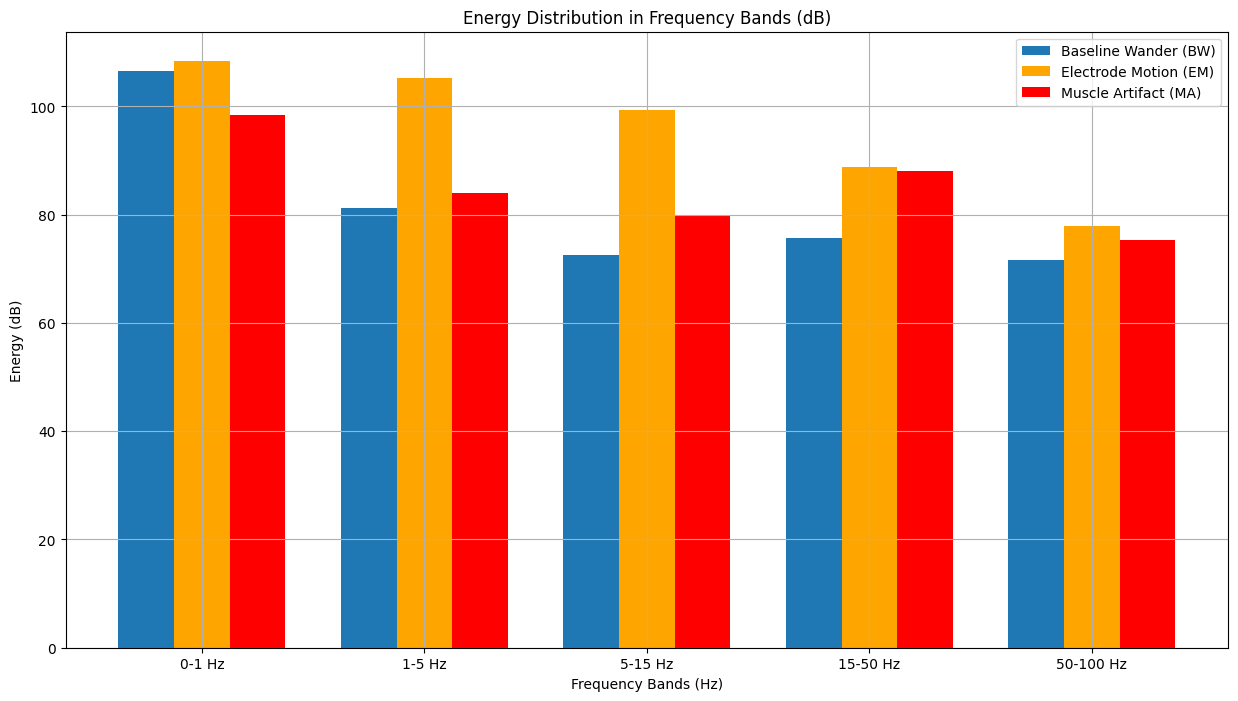

In [9]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt

def compute_band_energy(signal, fs, bands):
    """
    Compute the energy in specific frequency bands and convert to dB.
    
    Parameters:
    - signal: 1D array of the signal.
    - fs: Sampling frequency (Hz).
    - bands: List of tuples specifying frequency bands [(fmin1, fmax1), (fmin2, fmax2), ...].
    
    Returns:
    - band_energies: List of energies in dB for each frequency band.
    """
    N = len(signal)
    fft_vals = np.fft.fft(signal)
    fft_freqs = np.fft.fftfreq(N, d=1/fs)
    
    band_energies = []
    for fmin, fmax in bands:
        band_mask = (fft_freqs >= fmin) & (fft_freqs <= fmax)
        band_energy = np.sum(np.abs(fft_vals[band_mask])**2)  # Compute energy in the band
        band_energy_db = 10 * np.log10(band_energy + 1e-10)  # Convert to dB
        band_energies.append(band_energy_db)
    
    return band_energies

def visualize_nstdb_noise_energy(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
    """
    Visualizes the energy in different frequency bands (in dB) for each noise type 
    from the MIT-BIH Noise Stress Test Database (NSTDB): 
    Baseline Wander (BW), Electrode Motion (EM), and Muscle Artifact (MA).
    """
    # Load NSTDB noise signals
    bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
    em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
    ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')
    
    # Define sampling frequency
    fs = 360  # NSTDB sampling frequency is 360 Hz
    
    # Select first channel
    bw_signal = bw_signals[:, 0]
    em_signal = em_signals[:, 0]
    ma_signal = ma_signals[:, 0]

    # Frequency bands (in Hz)
    bands = [(0, 1), (1, 5), (5, 15), (15, 50), (50, 100)]  # You can modify these bands

    # Compute energy in each band
    bw_energies = compute_band_energy(bw_signal, fs, bands)
    em_energies = compute_band_energy(em_signal, fs, bands)
    ma_energies = compute_band_energy(ma_signal, fs, bands)
    
    # Plot energy for each noise type
    band_labels = [f'{fmin}-{fmax} Hz' for fmin, fmax in bands]

    plt.figure(figsize=(15, 8))
    
    x = np.arange(len(bands))
    width = 0.25  # Bar width

    # Baseline Wander
    plt.bar(x - width, bw_energies, width, label='Baseline Wander (BW)')
    
    # Electrode Motion
    plt.bar(x, em_energies, width, label='Electrode Motion (EM)', color='orange')
    
    # Muscle Artifact
    plt.bar(x + width, ma_energies, width, label='Muscle Artifact (MA)', color='red')
    
    # Plot settings
    plt.xticks(x, band_labels)
    plt.xlabel('Frequency Bands (Hz)')
    plt.ylabel('Energy (dB)')
    plt.title('Energy Distribution in Frequency Bands (dB)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
visualize_nstdb_noise_energy()


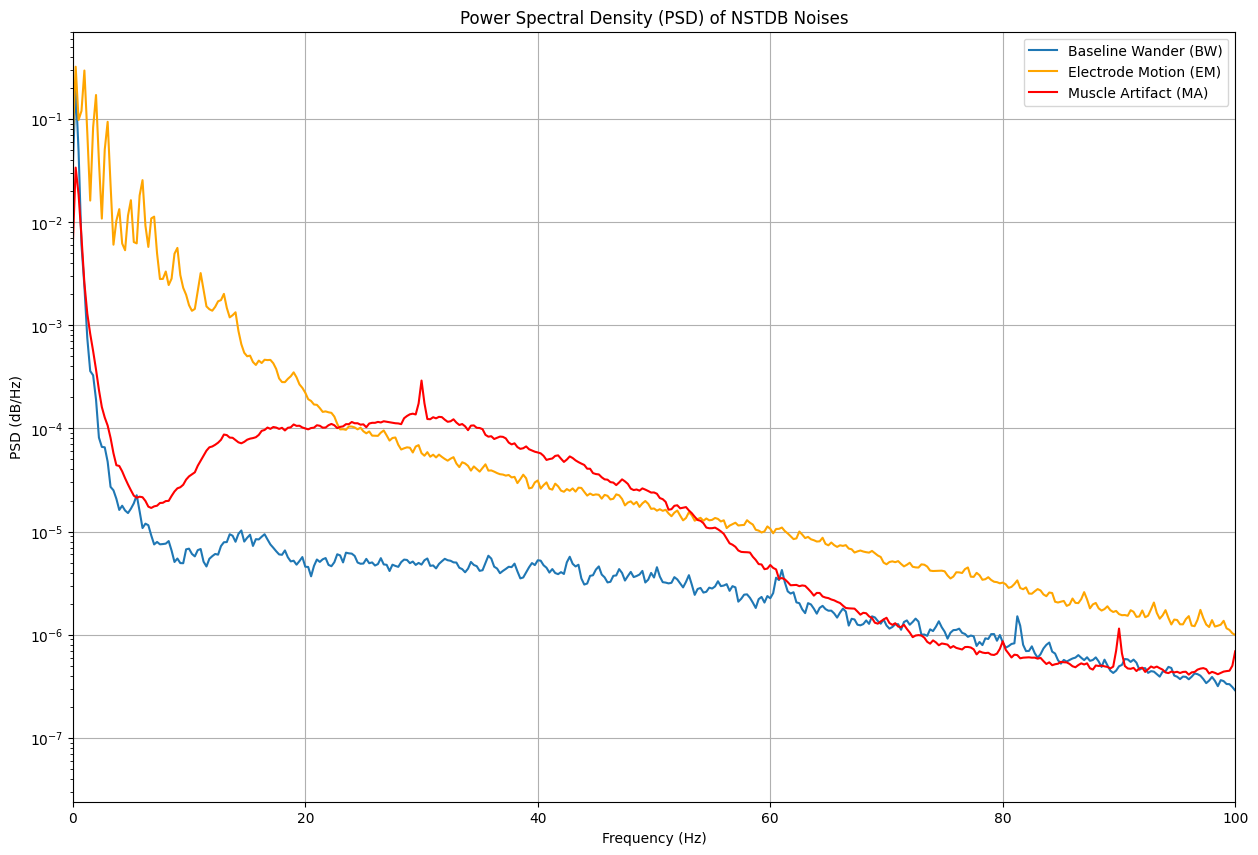

In [10]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

def plot_nstdb_psd(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
    """
    Computes and visualizes the Power Spectral Density (PSD) for each noise type 
    from the MIT-BIH Noise Stress Test Database (NSTDB).
    """
    # Load NSTDB noise signals
    bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
    em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
    ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')
    
    # Define sampling frequency
    fs = 360  # Sampling frequency (Hz)

    # Welch's method to compute PSD
    def compute_psd(signal, fs):
        freqs, psd = welch(signal, fs, nperseg=fs*4)  # Use 4-second segments for PSD
        return freqs, psd

    # Compute PSD for each noise signal
    freqs_bw, psd_bw = compute_psd(bw_signals[:, 0], fs)
    freqs_em, psd_em = compute_psd(em_signals[:, 0], fs)
    freqs_ma, psd_ma = compute_psd(ma_signals[:, 0], fs)

    # Plot PSD for each noise
    plt.figure(figsize=(15, 10))

    plt.semilogy(freqs_bw, psd_bw, label='Baseline Wander (BW)')
    plt.semilogy(freqs_em, psd_em, label='Electrode Motion (EM)', color='orange')
    plt.semilogy(freqs_ma, psd_ma, label='Muscle Artifact (MA)', color='red')
    
    plt.title('Power Spectral Density (PSD) of NSTDB Noises')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD (dB/Hz)')
    plt.xlim(0, 100)  # Focus on 0–100 Hz range
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage:
plot_nstdb_psd()


static

In [11]:
# static_noise = pickle.load(open('data/StaticNoise.pkl', 'rb'))
# # Convert the list to a numpy array and get its shape
# static_noise = np.array(static_noise)
# static_noise_shape = static_noise.shape

# static_noise_shape

In [12]:
import wfdb
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.signal import resample
def visualize_and_highlight_noise(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/', 
                                  chunk_size=10000, save_path='fig4/'):
    """
    Visualizes full BW, EM, MA noise signals with one highlighted chunk.
    Also extracts and plots the highlighted chunk separately.
    Parameters:
    NSTDBPath: Path to the NSTDB dataset.
    chunk_size: Number of samples per chunk.
    save_path: Path to save the figures.
    """
    # Load NSTDB noise signals
    bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
    em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
    ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')

    # Resample signals to 360 Hz
    def resample_signal(signal, target_fs=360, original_fs=128):
        return resample(signal, int(len(signal) * (target_fs / original_fs)))
    bw_noise = resample_signal(bw_signals[:, 0])
    em_noise = resample_signal(em_signals[:, 0])
    ma_noise = resample_signal(ma_signals[:, 0])

    # Load combined noise
    with open('data/CombinedNoise.pkl', 'rb') as f:
        combined_noise = pickle.load(f)
    combined_resampled = resample(combined_noise[0, :, 0], len(bw_noise))

    # Define x-axis as total sample length
    total_samples = bw_signals.shape[0]  # Ensuring the correct length is used
    num_chunks = total_samples // chunk_size
    x_full = np.arange(total_samples)  # X-axis for full signals

    # Select one chunk to highlight
    highlight_idx = 12
    highlight_start = highlight_idx * chunk_size
    highlight_end = highlight_start + chunk_size
    x_chunk = np.arange(chunk_size)  # X-axis for extracted chunk

    # Function to plot and save with a highlighted region
    def plot_with_highlight(signal, title, color, filename):
        plt.figure(figsize=(24, 8))
        plt.plot(x_full, signal[:total_samples], color=color)  # Using correct x-axis length
        
        # Highlight the selected chunk
        plt.axvspan(highlight_start, highlight_end, color='deeppink', alpha=0.6, label="Highlighted Chunk")
        
        # Add vertical dotted lines at the start of each chunk
        for i in range(num_chunks):
            plt.axvline(x=i * chunk_size, color='black', linestyle='dotted', alpha=0.7)
        
        plt.title(title, fontsize=80, fontweight='bold')
        plt.xlabel("Sample Length (N)", fontsize=35)  # X-axis as sample length
        plt.ylabel("Amplitude", fontsize=35)
        plt.xticks(fontsize=25)
        plt.yticks(fontsize=25)
        plt.legend(fontsize=18, loc="upper left")
        plt.tight_layout()
        plt.savefig(f"{save_path}{filename}.png")
        plt.close()

    # Plot each noise signal with a highlighted chunk
    plot_with_highlight(bw_noise, "Baseline Wander (BW) Noise", 'blue', "bw_noise_highlighted")
    plot_with_highlight(em_noise, "Electrode Motion (EM) Noise", 'green', "em_noise_highlighted")
    plot_with_highlight(ma_noise, "Muscle Artifact (MA) Noise", 'red', "ma_noise_highlighted")
    plot_with_highlight(combined_resampled, "Combined Noise", 'purple', "combined_noise_highlighted")

    # Function to plot and save the extracted highlighted chunk
    def plot_chunk(signal, title, color, filename):
        plt.figure(figsize=(12, 4))
        plt.plot(x_chunk, signal, color=color)
        plt.title(title, fontsize=40, fontweight='bold')
        plt.xlabel("Sample Length (N)", fontsize=35)  # X-axis as sample length
        plt.ylabel("Amplitude", fontsize=35)
        plt.xticks(fontsize=25)
        plt.yticks(fontsize=25)
        plt.tight_layout()
        plt.savefig(f"{save_path}{filename}.png")
        plt.close()

    # Extract and plot the highlighted chunk separately
    plot_chunk(bw_noise[highlight_start:highlight_end], "Extracted BW Chunk", 'blue', "bw_chunk")
    plot_chunk(em_noise[highlight_start:highlight_end], "Extracted EM Chunk", 'green', "em_chunk")
    plot_chunk(ma_noise[highlight_start:highlight_end], "Extracted MA Chunk", 'red', "ma_chunk")
    plot_chunk(combined_resampled[highlight_start:highlight_end], "Extracted Combined Noise Chunk", 'purple', "combined_chunk")

    print(f"Plots saved successfully in {save_path}")

# Run the function
visualize_and_highlight_noise(chunk_size=10000, save_path='fig4/')

Plots saved successfully in fig4/


# mit bih Dataset

In [44]:
import glob
import numpy as np
from scipy.signal import resample_poly
import wfdb
import math
import pandas as pd
import _pickle as pickle
import matplotlib.pyplot as plt
from collections import Counter

# MIT-BIH Database 전처리 및 라벨 추가
def prepare_mitdb_with_labels(mitpath='/home/dhc99/ecg_denoise/data/physionet.org/files/mitdb/1.0.0/'):
    ecgClassSet = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', '/', 'f', 'Q']
    MITDatabaseSignals = dict()
    patient_ids = pd.read_csv(mitpath + 'RECORDS', header=None).squeeze("columns").to_numpy()

    for pid in patient_ids:
        signal, fields = wfdb.rdsamp(mitpath + str(pid))
        ann = wfdb.rdann(mitpath + str(pid), 'atr')
        annSamples = ann.sample
        annLabels = ann.symbol
        auxSig = signal[:, 0]
        beats_with_labels = []

        for i in range(1, len(annSamples) - 1):
            beat = auxSig[max(0, annSamples[i] - 99): min(len(auxSig), annSamples[i] + 201)]
            if len(beat) <= 300 and annLabels[i] in ecgClassSet:
                label = ecgClassSet.index(annLabels[i])
                beat_padded = np.zeros(300)
                beat_padded[:len(beat)] = beat - (beat[0] + beat[-1]) / 2  # Centering
                beats_with_labels.append((beat_padded, label))
        
        MITDatabaseSignals[pid] = beats_with_labels

    with open('data/MITDatabase_with_labels.pkl', 'wb') as output:
        pickle.dump(MITDatabaseSignals, output)
    print('MIT-BIH database with labels saved as pickle file.')


# Load 데이터
with open('data/MITDatabase_with_labels.pkl', 'rb') as input:
    mitdb_with_labels = pickle.load(input)

# 15-class에서 5-class로 그룹핑 함수
def group_to_5class(label):
    if 0 <= label <= 4:
        return 0  # Normal beats
    elif 5 <= label <= 8:
        return 1  # Supraventricular beats
    elif 9 <= label <= 10:
        return 2  # Ventricular beats
    elif label == 11:
        return 3  # Fusion beats
    elif 12 <= label <= 14:
        return 4  # Unknown beats
    else:
        return -1  # 오류 방지용 기본값

# 5-class로 변환된 라벨 저장
all_labels_5class = [group_to_5class(label) for pid in mitdb_with_labels.keys() for _, label in mitdb_with_labels[pid]]
all_labels_5class = [label for label in all_labels_5class if label != -1]  # -1 제거

# 5-class 분포 확인
class_counts_5class = Counter(all_labels_5class)
print("5-Class distribution:", class_counts_5class)


5-Class distribution: Counter({0: 90589, 4: 8039, 2: 7236, 1: 2779, 3: 803})


In [45]:
# class_counts_15class = Counter(all_labels)
# print("15-Class distribution:", class_counts_15class)


Before SMOTE - Class Distribution: Counter({0: 90589, 4: 8039, 2: 7236, 1: 2779, 3: 803})
After SMOTE - Class Distribution: Counter({0: 50000, 1: 50000, 2: 50000, 4: 50000, 3: 50000})
Balanced MIT-BIH database saved as pickle file (dict format).


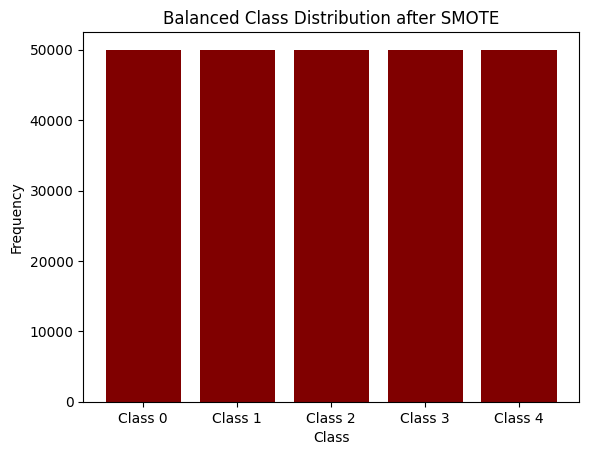

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import _pickle as pickle

# Load MIT-BIH 데이터 (dict 구조)
with open('data/MITDatabase_with_labels.pkl', 'rb') as input:
    mitdb_with_labels = pickle.load(input)

# 15-class에서 5-class로 그룹핑 함수
def group_to_5class(label):
    if 0 <= label <= 4:
        return 0  # Normal beats
    elif 5 <= label <= 8:
        return 1  # Supraventricular beats
    elif 9 <= label <= 10:
        return 2  # Ventricular beats
    elif label == 11:
        return 3  # Fusion beats
    elif 12 <= label <= 14:
        return 4  # Unknown beats
    else:
        return -1  # 오류 방지용 기본값

# 데이터 변환 및 그룹핑 (dict → X, y 배열로 변환)
X_data = []
y_data = []
beat_dict = {}

for pid in mitdb_with_labels.keys():
    beats = mitdb_with_labels[pid]
    for beat, label in beats:
        grouped_label = group_to_5class(label)
        if grouped_label != -1:
            X_data.append(beat)
            y_data.append(grouped_label)
            if pid not in beat_dict:
                beat_dict[pid] = []
            beat_dict[pid].append((beat, grouped_label))

X_data = np.array(X_data)
y_data = np.array(y_data)

# 클래스 분포 확인 (SMOTE 전)
class_counts_before = Counter(y_data)
print("Before SMOTE - Class Distribution:", class_counts_before)

# ------------------------
# SMOTE 적용 (Class 1~4는 각각 50000개로 oversample, Class 0도 50000개로 맞춤)
# ------------------------
X_class0 = X_data[y_data == 0]
X_class_others = X_data[y_data != 0]
y_class0 = y_data[y_data == 0]
y_class_others = y_data[y_data != 0]

# Class 0에서 50000개 랜덤 샘플링
X_class0_resampled, y_class0_resampled = resample(X_class0, y_class0, n_samples=50000, random_state=42)

# SMOTE로 Class 1~4를 각각 50000개로 oversample
smote_strategy = {1: 50000, 2: 50000, 3: 50000, 4: 50000}
smote = SMOTE(sampling_strategy=smote_strategy, random_state=42)
X_oversampled, y_oversampled = smote.fit_resample(X_class_others, y_class_others)

# Resampled 데이터 합치기
X_balanced = np.vstack((X_class0_resampled, X_oversampled))
y_balanced = np.hstack((y_class0_resampled, y_oversampled))

# 클래스 분포 확인 (SMOTE 후)
class_counts_after = Counter(y_balanced)
print("After SMOTE - Class Distribution:", class_counts_after)

# ------------------------
# dict 구조로 변환 (균형 잡힌 데이터를 다시 dict로 저장)
# ------------------------
balanced_dict = {}
for i in range(len(X_balanced)):
    pid = f"balanced_{i // 1000}"  # 새로운 환자 ID 형식
    if pid not in balanced_dict:
        balanced_dict[pid] = []
    balanced_dict[pid].append((X_balanced[i], y_balanced[i]))

# ------------------------
# 데이터 저장 (Balanced 데이터셋)
# ------------------------
with open('data/MITDatabase_balanced.pkl', 'wb') as output:
    pickle.dump(balanced_dict, output)
print("Balanced MIT-BIH database saved as pickle file (dict format).")

# ------------------------
# 클래스 분포 시각화
# ------------------------
plt.bar(class_counts_after.keys(), class_counts_after.values(), color='maroon')
plt.xticks(range(5), ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"])
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("Balanced Class Distribution after SMOTE")
plt.show()


데이터 타입: <class 'dict'>


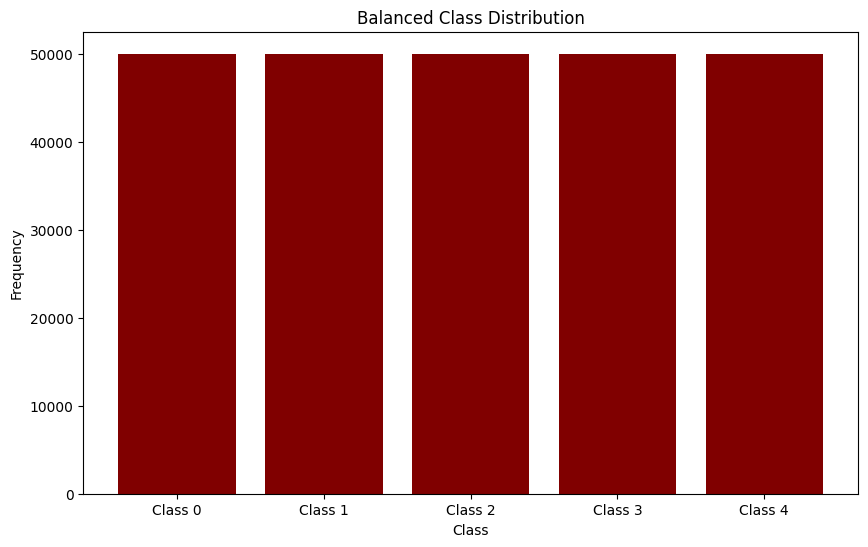

Class Distribution: Counter({0: 50000, 1: 50000, 2: 50000, 4: 50000, 3: 50000})


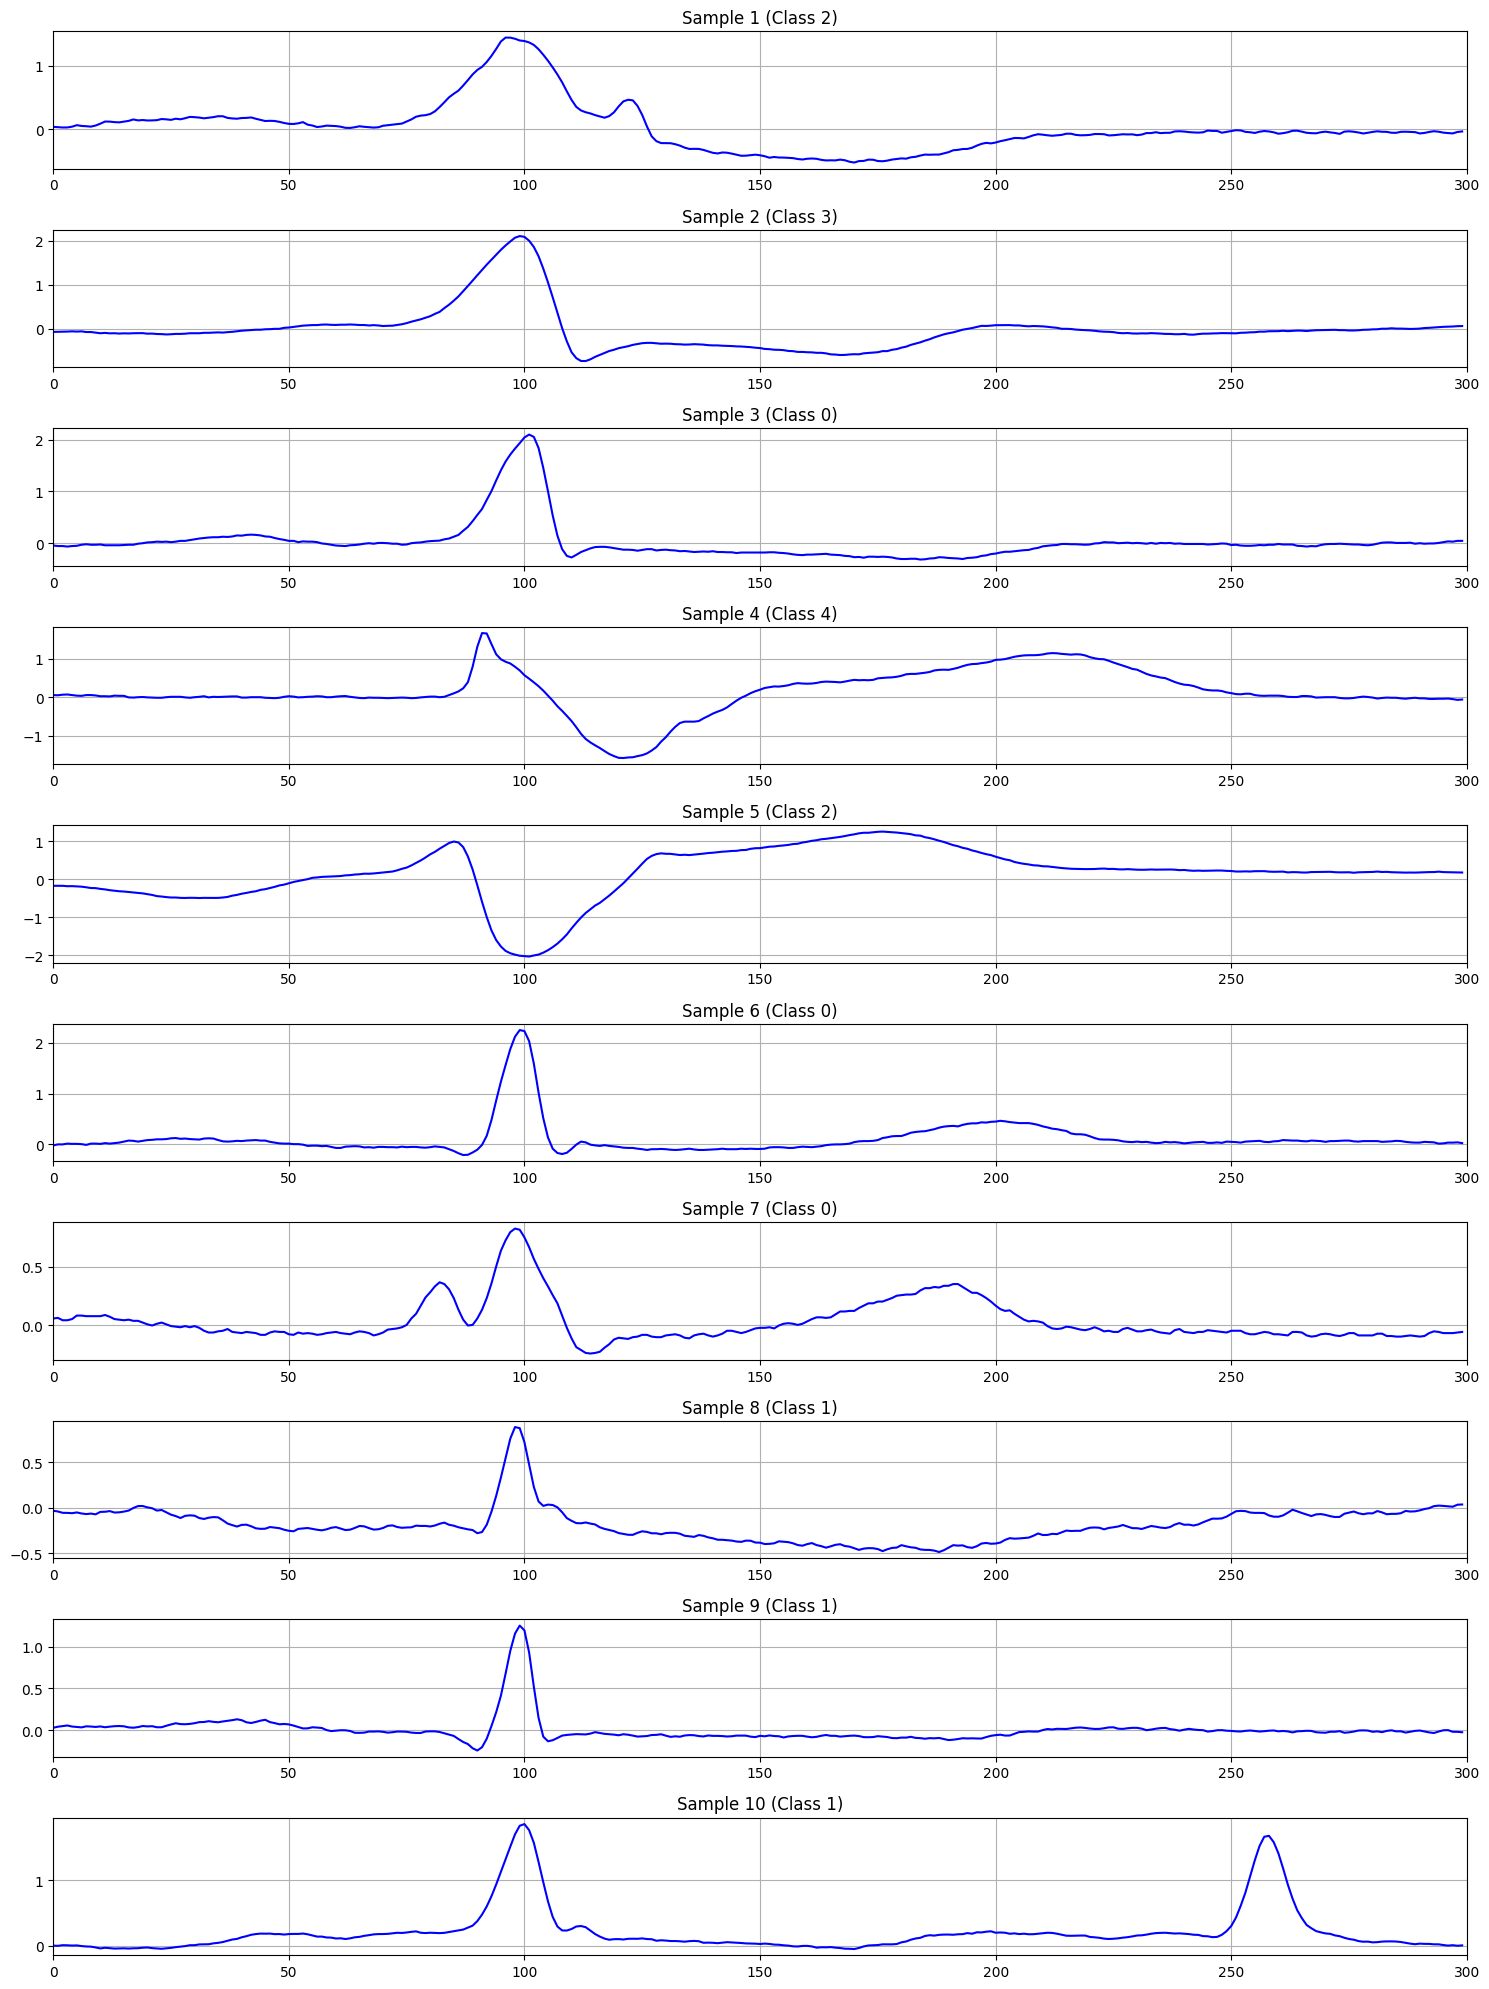

In [47]:
import matplotlib.pyplot as plt
import random
from collections import Counter
import _pickle as pickle

# pickle 파일 열기
with open('data/MITDatabase_balanced.pkl', 'rb') as file:
    data = pickle.load(file)

# 데이터 타입과 구조 확인
print("데이터 타입:", type(data))

# ------------------------
# 클래스 분포 시각화 함수
# ------------------------
def plot_class_distribution(data_dict):
    all_labels = [label for beats in data_dict.values() for _, label in beats]
    class_counts = Counter(all_labels)
    
    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values(), color='maroon')
    plt.xticks(range(5), ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"])
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.title("Balanced Class Distribution")
    plt.show()
    
    print("Class Distribution:", class_counts)

# ------------------------
# 랜덤 ECG 샘플 시각화 함수
# ------------------------
def plot_random_ecg_samples(data_dict, num_samples=10):
    samples = []
    for beats in data_dict.values():
        samples.extend(beats)
    
    # 랜덤으로 num_samples만큼 샘플 추출
    random_samples = random.sample(samples, num_samples)
    
    fig, axes = plt.subplots(num_samples, 1, figsize=(15, num_samples * 2))
    for i, (ecg, label) in enumerate(random_samples):
        axes[i].plot(ecg, color='blue')
        axes[i].set_title(f"Sample {i+1} (Class {label})")
        axes[i].set_xlim(0, 300)
        axes[i].grid(True)
    
    plt.tight_layout()
    plt.show()

# ------------------------
# 시각화 실행
# ------------------------
plot_class_distribution(balanced_dict)
plot_random_ecg_samples(balanced_dict, num_samples=10)


In [48]:
import numpy as np
from scipy.fft import fft
from scipy.signal import resample_poly
import wfdb
import math
import _pickle as pickle

def make_fourier(inputs, n, fs):
    """
    주파수 도메인 정보 추출 및 time-domain과 같은 shape으로 만듦.
    """
    T = n / fs
    k = np.arange(n)
    freq = k / T
    freq = freq[range(int(n / 2))]

    signal_list = []
    for i in range(inputs.shape[0]):
        y = inputs[i, :]
        Y = fft(y) / n  # FFT 수행 후 정규화
        Y = np.abs(Y[range(int(n / 2))])
        Y_full = np.hstack([Y, Y])  # Duplicate to match time-domain size (512)
        signal_list.append(Y_full)

    return np.asarray(signal_list)
def Data_Preparation_with_mitdb(samples=512, fs=360):
    """
    MITDB 데이터셋을 준비하고 Fourier 변환된 주파수 도메인 정보와 함께
    라벨(5-Class)도 반환합니다.
    """
    print('Preparing the MITDB dataset with labels...')

    # Set random seed for reproducibility
    seed = 1234
    np.random.seed(seed=seed)
    with open('data/MITDatabase_balanced.pkl', 'rb') as input:
        mitdb_with_labels = pickle.load(input)
    print(f"[INFO] Loaded MITDatabase with {len(mitdb_with_labels.keys())} signals")
    beats = []
    labels = []
    fourier_y = []
    X_data = []
    y_data = []
    for signal_name in mitdb_with_labels.keys():
        # pid = int(signal_name)  # signal_name을 정수형 환자 ID로 변환
        for beat, label in mitdb_with_labels[signal_name]:  # 비트와 라벨을 함께 처리
            b_np = np.zeros(samples)
            b_sq = np.array(beat)

            init_padding = 16
            if b_sq.shape[0] > (samples - init_padding):  # 샘플 길이를 초과하는 경우 스킵
                skip_beats += 1
                continue

            # 비트 데이터를 0으로 패딩하고 중심화 (Centering)
            b_np[init_padding:b_sq.shape[0] + init_padding] = b_sq - (b_sq[0] + b_sq[-1]) / 2

            # Fourier 변환 수행 (주파수 도메인 정보 생성)
            fourier_transformed_y = make_fourier(b_np.reshape(1, -1), samples, fs)

            # 데이터 저장
            X_data.append(b_np)
            y_data.append(label)
            beats.append(b_np)  # 비트 데이터
            labels.append(group_to_5class(label))  # 5-Class 라벨 저장
            fourier_y.append(fourier_transformed_y[0])  # Fourier 변환 결과 저장
                
    #####################################
    # Data split (80% train, 20% test)
    #####################################
    beats = np.array(beats)
    labels = np.array(labels)
    fourier_y = np.array(fourier_y)
    X_data = np.array(X_data)
    y_data = np.array(y_data)
    from sklearn.model_selection import StratifiedShuffleSplit
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)
    for train_idx, test_idx in sss.split(X_data, y_data):
        beats_train, beats_test = X_data[train_idx], X_data[test_idx]
        labels_train, labels_test = y_data[train_idx], y_data[test_idx]
        fourier_train_y, fourier_test_y = fourier_y[train_idx], fourier_y[test_idx]        
    print(f"[INFO] beats_train: {len(beats_train)}, beats_test: {len(beats_test)}")

    def add_noise_train(beats,  samples):
        with open('data2/CombinedNoise_Train.pkl', 'rb') as input:
            combined_noise = pickle.load(input)
        total_length = combined_noise.shape[0]  # 650000 samples
        half_length = total_length // 2
        train_noise_1 = combined_noise
        # Test Noise:
        sn = []
        fourier_x = []
        noise_index = 0
        for beat_idx, beat in enumerate(beats):
            noise_source = train_noise_1  # Upper half of channel 1
            noise_segment = noise_source[noise_index:noise_index + samples]
            signal_noise = beat + noise_segment
            sn.append(signal_noise)
            fourier_transformed_x = make_fourier(signal_noise.reshape(1, -1), samples, fs)
            fourier_x.append(fourier_transformed_x[0])
            noise_index += samples
            if noise_index > (len(noise_source) - samples):
                noise_index = 0
        return sn, fourier_x
    def add_noise_test(beats, samples):
        with open('data2/CombinedNoise_Test.pkl', 'rb') as input:
            static_noise = pickle.load(input)
        test_noise_1 = static_noise
        sn = []
        fourier_x = []
        noise_index = 0
        for beat_idx, beat in enumerate(beats):
            noise_source = test_noise_1  # Lower half of channel 1
            noise_segment = noise_source[noise_index:noise_index + samples]
            signal_noise = beat + noise_segment
            sn.append(signal_noise)
            fourier_transformed_x = make_fourier(signal_noise.reshape(1, -1), samples, fs)
            fourier_x.append(fourier_transformed_x[0])
            noise_index += samples
            if noise_index > (len(noise_source) - samples):
                noise_index = 0
        return sn, fourier_x

    # Add noise to train and test sets
    sn_train, fourier_train_x = add_noise_train(beats_train,  samples)
    sn_test, fourier_test_x = add_noise_test(beats_test, samples)

    #####################################
    # Convert to NumPy arrays and reshape
    #####################################
    X_train = np.expand_dims(np.array(sn_train), axis=2)
    y_train = np.expand_dims(np.array(beats_train), axis=2)
    X_test = np.expand_dims(np.array(sn_test), axis=2)
    y_test = np.expand_dims(np.array(beats_test), axis=2)
    F_train_x = np.expand_dims(np.array(fourier_train_x), axis=2)
    F_train_y = np.expand_dims(np.array(fourier_train_y), axis=2)
    F_test_x = np.expand_dims(np.array(fourier_test_x), axis=2)
    F_test_y = np.expand_dims(np.array(fourier_test_y), axis=2)

    y_train_label = np.array(labels_train)  # 라벨 반환
    y_test_label = np.array(labels_test)

    Dataset = [X_train, y_train, X_test, y_test, y_train_label, y_test_label]

    print(f"[INFO] Final shapes -> X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
    print(f"[INFO] Labels -> y_train_label: {y_train_label.shape}, y_test_label: {y_test_label.shape}")
    print('Dataset ready to use.')

    return Dataset

In [49]:
def Data_Preparation_with_Fourier_mitdb(samples=512, fs=360):
    """
    MITDB 데이터셋을 준비하고 Fourier 변환된 주파수 도메인 정보와 함께
    라벨(5-Class)도 반환합니다.
    """
    print('Preparing the MITDB dataset with labels...')

    # Set random seed for reproducibility
    seed = 1234
    np.random.seed(seed=seed)
    with open('data/MITDatabase_balanced.pkl', 'rb') as input:
        mitdb_with_labels = pickle.load(input)
    print(f"[INFO] Loaded MITDatabase with {len(mitdb_with_labels.keys())} signals")
    beats = []
    labels = []
    fourier_y = []
    X_data = []
    y_data = []
    for signal_name in mitdb_with_labels.keys():
        # pid = int(signal_name)  # signal_name을 정수형 환자 ID로 변환
        for beat, label in mitdb_with_labels[signal_name]:  # 비트와 라벨을 함께 처리
            b_np = np.zeros(samples)
            b_sq = np.array(beat)

            init_padding = 16
            if b_sq.shape[0] > (samples - init_padding):  # 샘플 길이를 초과하는 경우 스킵
                skip_beats += 1
                continue

            # 비트 데이터를 0으로 패딩하고 중심화 (Centering)
            b_np[init_padding:b_sq.shape[0] + init_padding] = b_sq - (b_sq[0] + b_sq[-1]) / 2

            # Fourier 변환 수행 (주파수 도메인 정보 생성)
            fourier_transformed_y = make_fourier(b_np.reshape(1, -1), samples, fs)

            # 데이터 저장
            X_data.append(b_np)
            y_data.append(label)
            beats.append(b_np)  # 비트 데이터
            labels.append(group_to_5class(label))  # 5-Class 라벨 저장
            fourier_y.append(fourier_transformed_y[0])  # Fourier 변환 결과 저장
                
    #####################################
    # Data split (80% train, 20% test)
    #####################################
    beats = np.array(beats)
    labels = np.array(labels)
    fourier_y = np.array(fourier_y)
    X_data = np.array(X_data)
    y_data = np.array(y_data)

    from sklearn.model_selection import StratifiedShuffleSplit

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)
    for train_idx, test_idx in sss.split(X_data, y_data):
        beats_train, beats_test = X_data[train_idx], X_data[test_idx]
        labels_train, labels_test = y_data[train_idx], y_data[test_idx]
        fourier_train_y, fourier_test_y = fourier_y[train_idx], fourier_y[test_idx]
        
    print(f"[INFO] beats_train: {len(beats_train)}, beats_test: {len(beats_test)}")

    #####################################
    # Adding noise to train and test sets
    #####################################
    print(f"[INFO] Adding noise to train and test sets")

    def add_noise_train(beats,  samples):
        with open('data2/CombinedNoise_Train.pkl', 'rb') as input:
            combined_noise = pickle.load(input)
        total_length = combined_noise.shape[0]  # 650000 samples
        half_length = total_length // 2
        train_noise_1 = combined_noise
        # Test Noise:
        sn = []
        fourier_x = []
        noise_index = 0
        for beat_idx, beat in enumerate(beats):
            noise_source = train_noise_1  # Upper half of channel 1
            noise_segment = noise_source[noise_index:noise_index + samples]
            signal_noise = beat + noise_segment
            sn.append(signal_noise)
            fourier_transformed_x = make_fourier(signal_noise.reshape(1, -1), samples, fs)
            fourier_x.append(fourier_transformed_x[0])
            noise_index += samples
            if noise_index > (len(noise_source) - samples):
                noise_index = 0
        return sn, fourier_x
    def add_noise_test(beats, samples):
        with open('data2/CombinedNoise_Test.pkl', 'rb') as input:
            static_noise = pickle.load(input)
        test_noise_1 = static_noise
        sn = []
        fourier_x = []
        noise_index = 0
        for beat_idx, beat in enumerate(beats):
            noise_source = test_noise_1  # Lower half of channel 1
            noise_segment = noise_source[noise_index:noise_index + samples]
            signal_noise = beat + noise_segment
            sn.append(signal_noise)
            fourier_transformed_x = make_fourier(signal_noise.reshape(1, -1), samples, fs)
            fourier_x.append(fourier_transformed_x[0])
            noise_index += samples
            if noise_index > (len(noise_source) - samples):
                noise_index = 0
        return sn, fourier_x

    # Add noise to train and test sets
    sn_train, fourier_train_x = add_noise_train(beats_train, samples)
    sn_test, fourier_test_x = add_noise_test(beats_test, samples)

    #####################################
    # Convert to NumPy arrays and reshape
    #####################################
    X_train = np.expand_dims(np.array(sn_train), axis=2)
    y_train = np.expand_dims(np.array(beats_train), axis=2)
    X_test = np.expand_dims(np.array(sn_test), axis=2)
    y_test = np.expand_dims(np.array(beats_test), axis=2)
    F_train_x = np.expand_dims(np.array(fourier_train_x), axis=2)
    F_train_y = np.expand_dims(np.array(fourier_train_y), axis=2)
    F_test_x = np.expand_dims(np.array(fourier_test_x), axis=2)
    F_test_y = np.expand_dims(np.array(fourier_test_y), axis=2)

    y_train_label = np.array(labels_train)  # 라벨 반환
    y_test_label = np.array(labels_test)

    Dataset = [X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y, y_train_label, y_test_label]

    print(f"[INFO] Final shapes -> X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
    print(f"[INFO] Labels -> y_train_label: {y_train_label.shape}, y_test_label: {y_test_label.shape}")
    print('Dataset ready to use.')

    return Dataset

In [50]:
# Unpack the dataset
Dataset = Data_Preparation_with_Fourier_mitdb(samples=512, fs=360)
X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y, y_train_label, y_test_label = Dataset


# Print dataset shapes for confirmation
print(f"Time domain train shapes: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Frequency domain train shapes: F_train_x: {F_train_x.shape}, F_train_y: {F_train_y.shape}")
print(f"Time domain test shapes: X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Frequency domain test shapes: F_test_x: {F_test_x.shape}, F_test_y: {F_test_y.shape}")

Preparing the MITDB dataset with labels...
[INFO] Loaded MITDatabase with 250 signals
[INFO] beats_train: 200000, beats_test: 50000
[INFO] Adding noise to train and test sets
[INFO] Final shapes -> X_train: (200000, 512, 1), y_train: (200000, 512, 1), X_test: (50000, 512, 1), y_test: (50000, 512, 1)
[INFO] Labels -> y_train_label: (200000,), y_test_label: (50000,)
Dataset ready to use.
Time domain train shapes: X_train: (200000, 512, 1), y_train: (200000, 512, 1)
Frequency domain train shapes: F_train_x: (200000, 512, 1), F_train_y: (200000, 512, 1)
Time domain test shapes: X_test: (50000, 512, 1), y_test: (50000, 512, 1)
Frequency domain test shapes: F_test_x: (50000, 512, 1), F_test_y: (50000, 512, 1)


In [51]:
clean_ecg = np.concatenate([y_train, y_test], axis=0)  # (250000, 512, 1)
print(f"[INFO] Clean ECG shape: {clean_ecg.shape}")

import numpy as np
px_value_mit = np.mean(clean_ecg**2)

print(px_value_mit)


[INFO] Clean ECG shape: (250000, 512, 1)
0.19774412823369134


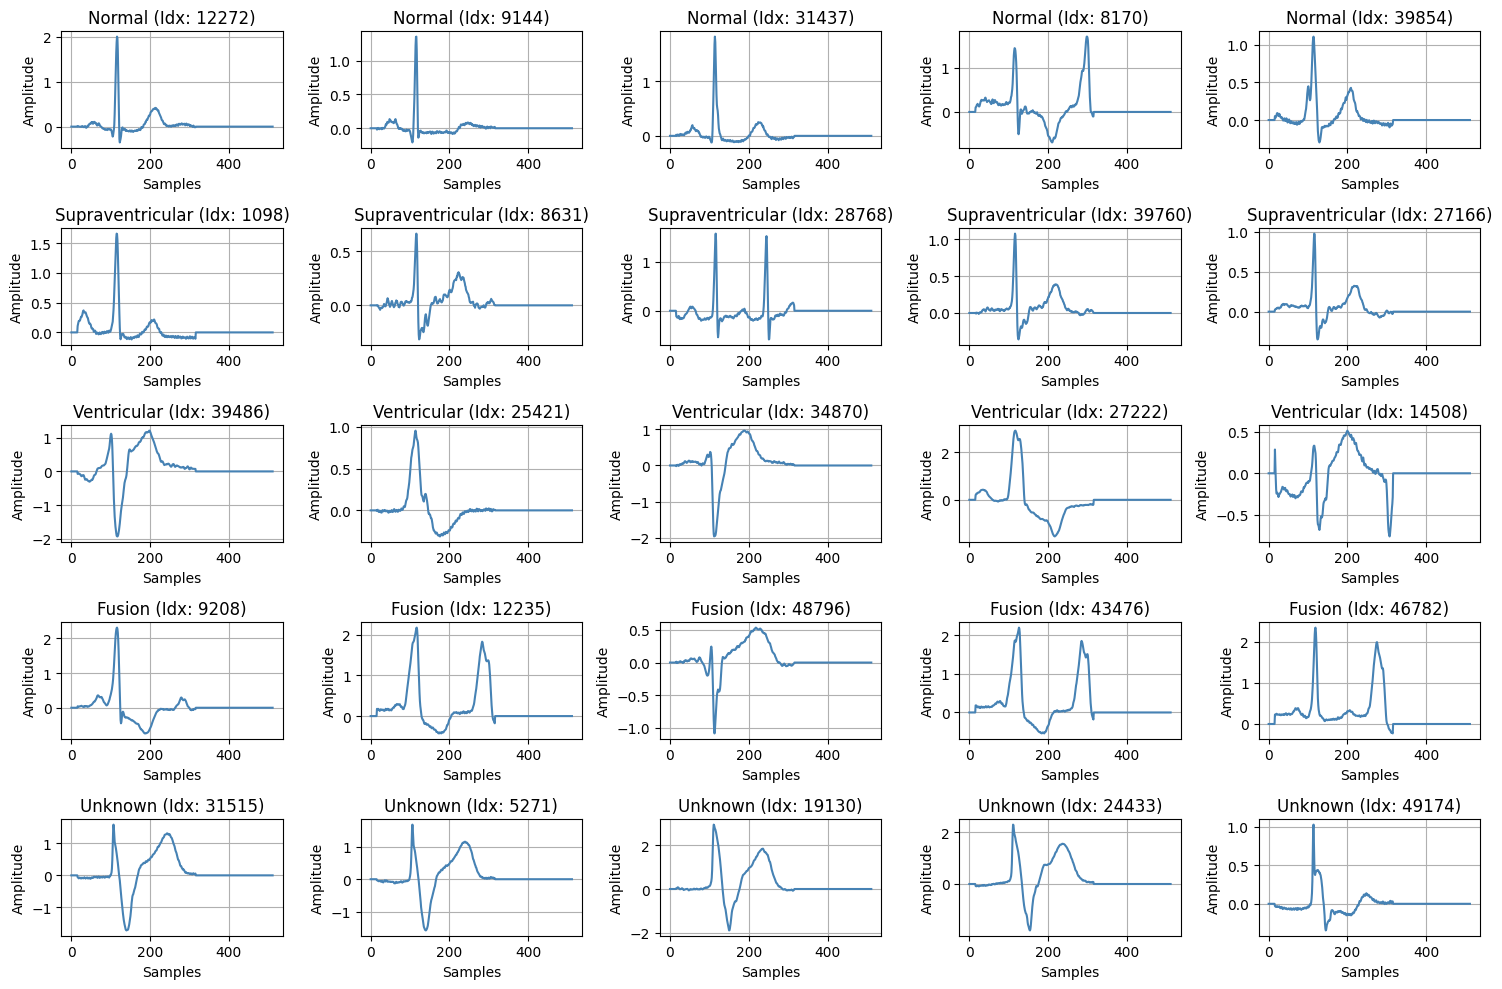

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# 5-Class 라벨 정의
label_names = ["Normal", "Supraventricular", "Ventricular", "Fusion", "Unknown"]

def visualize_ecg_samples(y_test, y_test_label, num_samples=5):
    """
    y_test에 대응하는 ECG 비트를 라벨에 따라 시각화합니다.
    
    Parameters:
    y_test: 테스트 데이터셋 (ECG 비트, shape: (num_samples, 512, 1))
    y_test_label: 테스트 데이터셋의 라벨 (5-Class)
    num_samples: 클래스별로 시각화할 샘플 수 (기본값: 5)
    """
    plt.figure(figsize=(15, 10))
    
    for class_id in range(5):
        # 해당 클래스에 속하는 인덱스 선택
        class_indices = np.where(y_test_label == class_id)[0]
        if len(class_indices) == 0:
            continue  # 해당 클래스가 없으면 건너뜀
        
        # 랜덤하게 num_samples만큼 선택
        selected_indices = np.random.choice(class_indices, size=min(num_samples, len(class_indices)), replace=False)
        
        for i, idx in enumerate(selected_indices):
            plt.subplot(5, num_samples, class_id * num_samples + i + 1)
            plt.plot(y_test[idx].squeeze(), color='steelblue')
            plt.title(f"{label_names[class_id]} (Idx: {idx})")
            plt.xlabel("Samples")
            plt.ylabel("Amplitude")
            plt.grid(True)
            
    plt.tight_layout()
    plt.show()

# 시각화 실행
visualize_ecg_samples(y_test, y_test_label, num_samples=5)


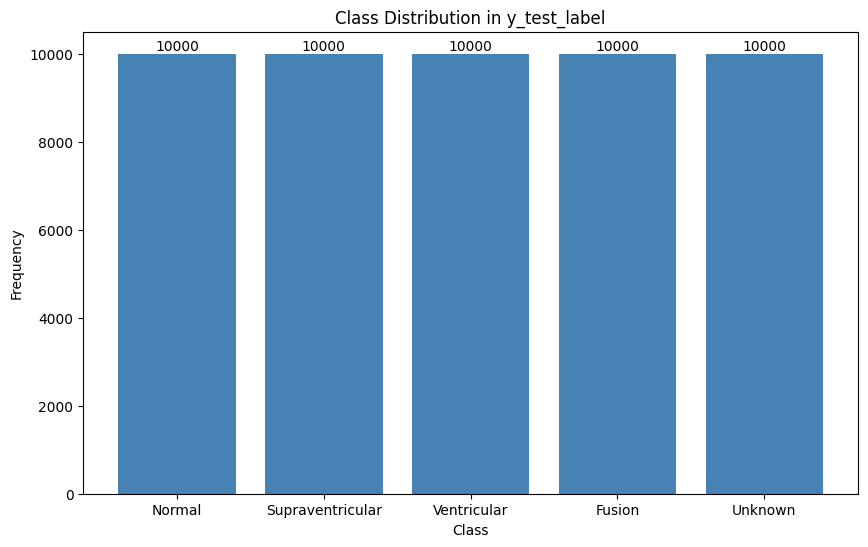

In [53]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

def plot_class_distribution(y_test_label):
    """
    y_test_label에서 5-Class 분포를 시각화합니다.
    
    Parameters:
    y_test_label: 테스트 데이터셋의 라벨 (5-Class)
    """
    # 클래스별 개수 계산
    class_counts = Counter(y_test_label)
    
    # 클래스 이름 정의
    label_names = ["Normal", "Supraventricular", "Ventricular", "Fusion", "Unknown"]
    
    # 클래스별 개수 순서에 맞게 추출
    counts = [class_counts[i] for i in range(5)]
    
    # 분포 시각화
    plt.figure(figsize=(10, 6))
    plt.bar(label_names, counts, color='steelblue')
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.title("Class Distribution in y_test_label")
    
    # 각 막대 위에 개수 표시
    for i, count in enumerate(counts):
        plt.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=10)
    
    plt.show()

# 시각화 실행
plot_class_distribution(y_test_label)


In [54]:
import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras import losses
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp
import tensorflow as tf 
from datetime import datetime
from deepFilter.dl_models import *
import os
import shap
current_date = datetime.now().strftime('%m%d')
# Custom loss SSD
import tensorflow as tf

def ssd_loss(y_true, y_pred):
    return tf.reduce_sum(tf.square(y_pred - y_true), axis=-2)

# Combined loss SSD + MSE
def combined_ssd_mse_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred), axis=-2) * 500 + tf.reduce_sum(tf.square(y_true - y_pred), axis=-2)

def combined_ssd_mad_loss(y_true, y_pred):
    return tf.reduce_max(tf.square(y_true - y_pred), axis=-2) * 50 + tf.reduce_sum(tf.square(y_true - y_pred), axis=-2)

# Custom loss SAD
def sad_loss(y_true, y_pred):
    return tf.reduce_sum(tf.sqrt(tf.square(y_pred - y_true)), axis=-2)

# Custom loss MAD
def mad_loss(y_true, y_pred):
    return tf.reduce_max(tf.square(y_pred - y_true), axis=-2)

def train_dl(Dataset, experiment):

    print('Deep Learning pipeline: Training the model for exp ' + str(experiment))
    
    if experiment in ['Transformer_COMBDAE']:
        [X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y, y_train_label, y_test_label] = Dataset

        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=True, random_state=1)
        F_train_x, F_val_x, F_train_y, F_val_y = train_test_split(F_train_x, F_train_y, test_size=0.3, shuffle=True, random_state=1)
    else:
        [X_train, y_train, X_test, y_test, y_train_label, y_test_label] = Dataset
        # 일반 모델들을 위한 데이터 분할
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=True, random_state=1)
            
    # ==================
    # LOAD THE DL MODEL
    # ==================
    if experiment == 'CNN_DAE':
        # FCN_DAE
        model = CNN_DAE()
        model_label = 'CNN_DAE'
        
    if experiment == 'FCN_DAE':
        # FCN_DAE
        model = FCN_DAE()
        model_label = 'FCN_DAE'

    if experiment == 'DRNN':
        # DRNN
        model = DRRN_denoising()
        model_label = 'DRNN'

    if experiment == 'DeepFilter':
        # Inception-like linear and non linear dilated
        model = deep_filter_model_I_LANL_dilated()
        model_label = 'DeepFilter'
        
    if experiment == 'AttentionSkipDAE':
        # Inception-like linear and non linear dilated
        model = AttentionSkipDAE()
        model_label = 'AttentionSkipDAE'
    
    if experiment == 'Transformer_DAE':
        # Transformer_FDAE
        model = Transformer_DAE()
        model_label = 'Transformer_DAE'
        
    if experiment == 'Transformer_COMBDAE':
        model = Transformer_COMBDAE()
        model_label = 'Transformer_COMBDAE'
        
    print('\n ' + model_label + '\n ')

    model.summary()
    epochs = int(1e5)  # 100000
    batch_size = 128  #128

    lr = 1e-3
    # lr = 1e-4
    minimum_lr = 1e-10

    # Loss function selection according to method implementation
    if experiment == 'DRNN':
        criterion = keras.losses.mean_squared_error

    elif experiment == 'FCN_DAE':
        criterion = ssd_loss

    else:
        criterion = combined_ssd_mad_loss

    model.compile(loss=criterion,
                  optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
                  metrics=[losses.mean_squared_error, losses.mean_absolute_error, ssd_loss, mad_loss])

    # Keras Callbacks

    # 체크포인트 파일 경로 설정
    model_dir = current_date
    model_filepath = os.path.join(model_dir, f"mitdb_{model_label}_weights.best.weights.h5")

    # 디렉토리가 존재하지 않으면 생성
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    checkpoint = ModelCheckpoint(model_filepath,
                                 monitor="val_loss",
                                 verbose=1,
                                 save_best_only=True,
                                 mode='min',  # on acc has to go max
                                 save_weights_only=True)

    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.5,
                                  min_delta=0.05,
                                  mode='min',  # on acc has to go max
                                  patience=2,
                                  min_lr=minimum_lr,
                                  verbose=1)

    early_stop = EarlyStopping(monitor="val_loss",  # "val_loss"
                               min_delta=0.05,
                               mode='min',  # on acc has to go max
                               patience=10,
                               verbose=1)
    # reduce_lr = ReduceLROnPlateau(monitor="val_loss",
    #                             factor=0.5,           # 학습률 감소 비율은 그대로 유지
    #                             min_delta=0.005,      # min_delta를 0.05에서 0.001로 줄여 작은 개선도 감지
    #                             mode='min',           # val_loss 최소화를 목표로 함
    #                             patience=10,          # patience를 2에서 10으로 늘려 학습률 감소 시점을 늦춤
    #                             verbose=1)

    # early_stop = EarlyStopping(monitor="val_loss",  
    #                         min_delta=0.001,       # 개선 판단을 위한 최소 변화량
    #                         mode='min',             # val_loss 최소화를 목표로 함
    #                         patience=40,            # patience를 50에서 20으로 줄여 더 빠른 조기 종료
    #                         verbose=1)
    tb_log_dir = './runs_mitdb_' + current_date +'/' + model_label
    # 디렉토리가 존재하지 않으면 생성
    if not os.path.exists(tb_log_dir):
        os.makedirs(tb_log_dir)
    tboard = TensorBoard(log_dir=tb_log_dir, histogram_freq=0,
                         write_graph=False, 
                         write_images=False, embeddings_freq=0,
                        #  embeddings_layer_names=None,
                         embeddings_metadata=None)

    # To run the tensor board
    # tensorboard --logdir=./runs_new

    if experiment in ['Transformer_COMBDAE']:
        model.fit(x=[X_train, F_train_x], y=y_train,
                validation_data=([X_val, F_val_x], y_val),
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                callbacks=[early_stop,
                            reduce_lr,
                            checkpoint,
                            tboard])
    else:
        model.fit(x=X_train, y=y_train,
                validation_data=(X_val, y_val),
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                callbacks=[early_stop,
                            reduce_lr,
                            checkpoint,
                            tboard])
    K.clear_session()



def test_dl(Dataset, experiment):

    print('Deep Learning pipeline: Testing the model')
# 여기선 x_test, y_test만 사용됨
    if experiment in ['Transformer_COMBDAE']:
        [X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y, y_train_label, y_test_label] = Dataset

    else:
        [X_train, y_train, X_test, y_test, y_train_label, y_test_label] = Dataset
        # 일반 모델들을 위한 데이터 분할
    batch_size = 128

    if experiment == 'CNN_DAE':
        # FCN_DAE
        model = CNN_DAE()
        model_label = 'CNN_DAE'
    if experiment == 'FCN_DAE':
        # FCN_DAE
        model = FCN_DAE()
        model_label = 'FCN_DAE'

    if experiment == 'DRNN':
        # DRNN
        model = DRRN_denoising()
        model_label = 'DRNN'

    if experiment == 'DeepFilter':
        # Inception-like linear and non linear dilated
        model = deep_filter_model_I_LANL_dilated()
        model_label = 'DeepFilter'

    if experiment == 'AttentionSkipDAE':
        # Inception-like linear and non linear dilated
        model = AttentionSkipDAE()
        model_label = 'AttentionSkipDAE'
        
    if experiment == 'Transformer_DAE':
        model = Transformer_DAE()
        model_label = 'Transformer_DAE'
        
    if experiment == 'Transformer_COMBDAE':
        model = Transformer_COMBDAE()
        model_label = 'Transformer_COMBDAE'
            
    print('\n ' + model_label + '\n ')

    model.summary()

    # Loss function selection according to method implementation
    if experiment == 'DRNN':
        criterion = 'mse'

    elif experiment == 'FCN-DAE':
        criterion = ssd_loss

    else:
        criterion = combined_ssd_mad_loss
        # criterion = combined_huber_freq_loss

    model.compile(loss=criterion,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                  metrics=[losses.mean_squared_error, losses.mean_absolute_error, ssd_loss, mad_loss])
    model_dir = current_date
    model_filepath = os.path.join(model_dir, f"mitdb_{model_label}_weights.best.weights.h5")

    # 디렉토리가 존재하지 않으면 생성
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    # load weights
    model.load_weights(model_filepath)
    
    if experiment in ['Transformer_COMBDAE']:
        # Test score
        y_pred = model.predict([X_test, F_test_x], batch_size=batch_size, verbose=1)

    else:
        # Test score
        y_pred = model.predict(X_test, batch_size=batch_size, verbose=1)
        
    K.clear_session()

    return [X_test, y_test, y_pred]

In [55]:
# from deepFilter.dl_pipeline import train_dl, test_dl
import wfdb
import _pickle as pickle
from datetime import datetime
import numpy as np
import os

dl_experiments = ['FCN_DAE', 'DeepFilter','AttentionSkipDAE','Transformer_DAE','Transformer_COMBDAE']
# dl_experiments = ['Transformer_COMBDAE']
train_time_list = []
test_time_list = []
    
    # Get the current date in 'MMDD' format
current_date = datetime.now().strftime('%m%d')
for experiment in dl_experiments:
    # 데이터 준비 단계
    if experiment in ['Transformer_COMBDAE']:
        Dataset = Data_Preparation_with_Fourier_mitdb(samples=512, fs=360)
        X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y, y_train_label, y_test_label = Dataset         
    else:
        Dataset = Data_Preparation_with_mitdb(samples=512)
        X_train, y_train, X_test, y_test, y_train_label, y_test_label = Dataset
    
    # 훈련 시간 측정 및 모델 훈련
    start_train = datetime.now()
    train_dl(Dataset, experiment)
    end_train = datetime.now()
    train_time_list.append(end_train - start_train)
    # 테스트 시간 측정 및 모델 테스트
    start_test = datetime.now()
    [X_test, y_test, y_pred] = test_dl(Dataset, experiment)
    end_test = datetime.now()
    test_time_list.append(end_test - start_test)
    # 시각화 및 결과 저장
    save_dir = current_date 
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    test_results = [X_test, y_test, y_pred]
    with open(os.path.join(save_dir,'mitdb_test_results_' + experiment + '.pkl'), 'wb') as output:
        pickle.dump(test_results, output)
    print('Results from experiment ' + experiment + ' saved')

Preparing the MITDB dataset with labels...
[INFO] Loaded MITDatabase with 250 signals
[INFO] beats_train: 200000, beats_test: 50000
[INFO] Final shapes -> X_train: (200000, 512, 1), y_train: (200000, 512, 1), X_test: (50000, 512, 1), y_test: (50000, 512, 1)
[INFO] Labels -> y_train_label: (200000,), y_test_label: (50000,)
Dataset ready to use.
Deep Learning pipeline: Training the model for exp FCN_DAE

 FCN_DAE
 


/home/dhc99/anaconda3/envs/ECGDENOISE/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 512, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_288 (Conv1D)             │ (None, 256, 40)        │           680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_288         │ (None, 256, 40)        │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_289 (Conv1D)             │ (None, 128, 20)        │        12,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_289         │ (None, 128, 20)        │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_290 (Conv1D)             │ (None, 64, 20)         │         6,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_290         │ (None, 64, 20)         │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_291 (Conv1D)             │ (None, 32, 20)         │         6,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_291         │ (None, 32, 20)         │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_292 (Conv1D)             │ (None, 16, 40)         │        12,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_292         │ (None, 16, 40)         │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_293 (Conv1D)             │ (None, 16, 1)          │           641 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_293         │ (None, 16, 1)          │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ expand_dims_layer               │ (None, 16, 1, 1)       │             0 │
│ (ExpandDimsLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 1, 1)       │            17 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 16, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_294         │ (None, 16, 1)          │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ expand_dims_layer_1             │ (None, 16, 1, 1)       │             0 │
│ (ExpandDimsLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 1, 40)      │           680 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 80,787 (315.57 KB)

 Trainable params: 80,223 (313.37 KB)

 Non-trainable params: 564 (2.20 KB)

Epoch 1/100000


/home/dhc99/anaconda3/envs/ECGDENOISE/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1143']
Received: inputs=Tensor(shape=(None, 512, 1))
  warnings.warn(msg)


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 49.8754 - mad_loss: 1.4836 - mean_absolute_error: 0.1772 - mean_squared_error: 0.0974 - ssd_loss: 49.8754
Epoch 1: val_loss improved from inf to 20.01835, saving model to 0223/mitdb_FCN_DAE_weights.best.weights.h5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 49.8528 - mad_loss: 1.4830 - mean_absolute_error: 0.1772 - mean_squared_error: 0.0974 - ssd_loss: 49.8528 - val_loss: 20.0184 - val_mad_loss: 0.5705 - val_mean_absolute_error: 0.1288 - val_mean_squared_error: 0.0391 - val_ssd_loss: 20.0184 - learning_rate: 0.0010
Epoch 2/100000
1082/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.0280 - mad_loss: 0.4780 - mean_absolute_error: 0.0967 - mean_squared_error: 0.0254 - ssd_loss: 13.0280
Epoch 2: val_loss improved from 20.01835 to 10.94081, saving model to 0223/mitdb_FCN_DAE_weights.best.weights.h5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 13.0185 - mad_loss: 0.4777 - mean_absolute_error: 0.0966 - mean_squared_error: 0.0

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 512, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 256, 40)        │           680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 40)        │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 128, 20)        │        12,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 20)        │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 64, 20)         │         6,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 20)         │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 32, 20)         │         6,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 20)         │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 16, 40)         │        12,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 40)         │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 16, 1)          │           641 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 1)          │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ expand_dims_layer               │ (None, 16, 1, 1)       │             0 │
│ (ExpandDimsLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 1, 1)       │            17 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 16, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 1)          │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ expand_dims_layer_1             │ (None, 16, 1, 1)       │             0 │
│ (ExpandDimsLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 1, 40)      │           680 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 80,787 (315.57 KB)

 Trainable params: 80,223 (313.37 KB)

 Non-trainable params: 564 (2.20 KB)

/home/dhc99/anaconda3/envs/ECGDENOISE/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 102 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/dhc99/anaconda3/envs/ECGDENOISE/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(128, 512, 1))
  warnings.warn(msg)


360/391 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/home/dhc99/anaconda3/envs/ECGDENOISE/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 512, 1))
  warnings.warn(msg)


391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Results from experiment FCN_DAE saved
Preparing the MITDB dataset with labels...
[INFO] Loaded MITDatabase with 250 signals
[INFO] beats_train: 200000, beats_test: 50000
[INFO] Final shapes -> X_train: (200000, 512, 1), y_train: (200000, 512, 1), X_test: (50000, 512, 1), y_test: (50000, 512, 1)
[INFO] Labels -> y_train_label: (200000,), y_test_label: (50000,)
Dataset ready to use.
Deep Learning pipeline: Training the model for exp DeepFilter

 DeepFilter
 


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 512, 8)    │         32 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 512, 8)    │         48 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 512, 8)    │         80 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 512, 8)    │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 512, 8)    │         32 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 512, 8)    │         48 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 512, 8)    │         80 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 512, 8)    │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512, 64)   │          0 │ conv1d[0][0],     │
│ (Concatenate)       │                   │            │ conv1d_1[0][0],   │
│                     │                   │            │ conv1d_2[0][0],   │
│                     │                   │            │ conv1d_3[0][0],   │
│                     │                   │            │ conv1d_4[0][0],   │
│                     │                   │            │ conv1d_5[0][0],   │
│                     │                   │            │ conv1d_6[0][0],   │
│                     │                   │            │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 64)   │        256 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 512, 10)   │      3,210 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 512, 10)   │      5,770 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 512, 10)   │      9,610 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 512, 10)   │      3,210 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 512, 10)   │      5,770 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 512, 10)   │      9,610 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 512, 60)   │          0 │ conv1d_8[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_9[0][0],   │
│                     │                   │            │ conv1d_10[0][0],  │
│                     │                   │            │ conv1d_11[0][0],  │
│                     │                   │            │ conv1d_12[0][0],  │
│                     │                   │            │ conv1d_13[0][0] 

 Total params: 69,147 (270.11 KB)

 Trainable params: 68,719 (268.43 KB)

 Non-trainable params: 428 (1.67 KB)

Epoch 1/100000


/home/dhc99/anaconda3/envs/ECGDENOISE/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 512, 1))
  warnings.warn(msg)


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 135.9417 - mad_loss: 1.3054 - mean_absolute_error: 0.2297 - mean_squared_error: 0.1380 - ssd_loss: 70.6710
Epoch 1: val_loss improved from inf to 78.44775, saving model to 0223/mitdb_DeepFilter_weights.best.weights.h5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 34s 19ms/step - loss: 135.9028 - mad_loss: 1.3050 - mean_absolute_error: 0.2297 - mean_squared_error: 0.1380 - ssd_loss: 70.6532 - val_loss: 78.4477 - val_mad_loss: 0.6766 - val_mean_absolute_error: 0.1874 - val_mean_squared_error: 0.0871 - val_ssd_loss: 44.6171 - learning_rate: 0.0010
Epoch 2/100000
1092/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 67.1410 - mad_loss: 0.6121 - mean_absolute_error: 0.1658 - mean_squared_error: 0.0714 - ssd_loss: 36.5365
Epoch 2: val_loss improved from 78.44775 to 57.59944, saving model to 0223/mitdb_DeepFilter_weights.best.weights.h5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - loss: 67.1325 - mad_loss: 0.6120 - mean_absolute_error: 0.1658 - mean_squared

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 512, 8)    │         32 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 512, 8)    │         48 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 512, 8)    │         80 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 512, 8)    │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 512, 8)    │         32 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 512, 8)    │         48 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 512, 8)    │         80 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 512, 8)    │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512, 64)   │          0 │ conv1d[0][0],     │
│ (Concatenate)       │                   │            │ conv1d_1[0][0],   │
│                     │                   │            │ conv1d_2[0][0],   │
│                     │                   │            │ conv1d_3[0][0],   │
│                     │                   │            │ conv1d_4[0][0],   │
│                     │                   │            │ conv1d_5[0][0],   │
│                     │                   │            │ conv1d_6[0][0],   │
│                     │                   │            │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 64)   │        256 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 512, 10)   │      3,210 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 512, 10)   │      5,770 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 512, 10)   │      9,610 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 512, 10)   │      3,210 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 512, 10)   │      5,770 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 512, 10)   │      9,610 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 512, 60)   │          0 │ conv1d_8[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_9[0][0],   │
│                     │                   │            │ conv1d_10[0][0],  │
│                     │                   │            │ conv1d_11[0][0],  │
│                     │                   │            │ conv1d_12[0][0],  │
│                     │                   │            │ conv1d_13[0][0] 

 Total params: 69,147 (270.11 KB)

 Trainable params: 68,719 (268.43 KB)

 Non-trainable params: 428 (1.67 KB)

/home/dhc99/anaconda3/envs/ECGDENOISE/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 198 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/dhc99/anaconda3/envs/ECGDENOISE/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(128, 512, 1))
  warnings.warn(msg)


391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Results from experiment DeepFilter saved
Preparing the MITDB dataset with labels...
[INFO] Loaded MITDatabase with 250 signals
[INFO] beats_train: 200000, beats_test: 50000
[INFO] Final shapes -> X_train: (200000, 512, 1), y_train: (200000, 512, 1), X_test: (50000, 512, 1), y_test: (50000, 512, 1)
[INFO] Labels -> y_train_label: (200000,), y_test_label: (50000,)
Dataset ready to use.
Deep Learning pipeline: Training the model for exp AttentionSkipDAE


/home/dhc99/anaconda3/envs/ECGDENOISE/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



 AttentionSkipDAE
 


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_block     │ (None, 256, 16)   │        291 │ input_layer[0][0] │
│ (AttentionBlock)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_block_1   │ (None, 128, 32)   │      8,243 │ attention_block[… │
│ (AttentionBlock)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_block_2   │ (None, 64, 64)    │     32,851 │ attention_block_… │
│ (AttentionBlock)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_block_3   │ (None, 32, 64)    │     65,619 │ attention_block_… │
│ (AttentionBlock)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_block_4   │ (None, 16, 1)     │      1,044 │ attention_block_… │
│ (AttentionBlock)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_deconv    │ (None, 32, 64)    │      1,107 │ attention_block_… │
│ (AttentionDeconv)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 64)    │          0 │ attention_deconv… │
│                     │                   │            │ attention_block_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_deconv_1  │ (None, 64, 64)    │     65,619 │ add[0][0]         │
│ (AttentionDeconv)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 64)    │          0 │ attention_deconv… │
│                     │                   │            │ attention_block_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_deconv_2  │ (None, 128, 32)   │     32,819 │ add_1[0][0]       │
│ (AttentionDeconv)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 128, 32)   │          0 │ attention_deconv… │
│                     │                   │            │ attention_block_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_deconv_3  │ (None, 256, 16)   │      8,227 │ add_2[0][0]       │
│ (AttentionDeconv)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 256, 16)   │          0 │ attention_deconv… │
│                     │                   │            │ attention_block[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_deconv_4  │ (None, 512, 1)    │        276 │ add_3[0][0]       │
│ (AttentionDeconv)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 216,096 (844.12 KB)

 Trainable params: 216,096 (844.12 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100000
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 91.0924 - mad_loss: 0.9569 - mean_absolute_error: 0.1676 - mean_squared_error: 0.0845 - ssd_loss: 43.2497
Epoch 1: val_loss improved from inf to 28.80926, saving model to 0223/mitdb_AttentionSkipDAE_weights.best.weights.h5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - loss: 91.0585 - mad_loss: 0.9565 - mean_absolute_error: 0.1675 - mean_squared_error: 0.0844 - ssd_loss: 43.2340 - val_loss: 28.8093 - val_mad_loss: 0.3088 - val_mean_absolute_error: 0.1012 - val_mean_squared_error: 0.0261 - val_ssd_loss: 13.3698 - learning_rate: 0.0010
Epoch 2/100000
1092/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 26.6209 - mad_loss: 0.2845 - mean_absolute_error: 0.0970 - mean_squared_error: 0.0242 - ssd_loss: 12.3969
Epoch 2: val_loss improved from 28.80926 to 21.50477, saving model to 0223/mitdb_AttentionSkipDAE_weights.best.weights.h5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 26.6159 - mad_loss: 0.2844 - mean_absolute_error:

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_block     │ (None, 256, 16)   │        291 │ input_layer[0][0] │
│ (AttentionBlock)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_block_1   │ (None, 128, 32)   │      8,243 │ attention_block[… │
│ (AttentionBlock)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_block_2   │ (None, 64, 64)    │     32,851 │ attention_block_… │
│ (AttentionBlock)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_block_3   │ (None, 32, 64)    │     65,619 │ attention_block_… │
│ (AttentionBlock)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_block_4   │ (None, 16, 1)     │      1,044 │ attention_block_… │
│ (AttentionBlock)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_deconv    │ (None, 32, 64)    │      1,107 │ attention_block_… │
│ (AttentionDeconv)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 64)    │          0 │ attention_deconv… │
│                     │                   │            │ attention_block_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_deconv_1  │ (None, 64, 64)    │     65,619 │ add[0][0]         │
│ (AttentionDeconv)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 64)    │          0 │ attention_deconv… │
│                     │                   │            │ attention_block_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_deconv_2  │ (None, 128, 32)   │     32,819 │ add_1[0][0]       │
│ (AttentionDeconv)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 128, 32)   │          0 │ attention_deconv… │
│                     │                   │            │ attention_block_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_deconv_3  │ (None, 256, 16)   │      8,227 │ add_2[0][0]       │
│ (AttentionDeconv)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 256, 16)   │          0 │ attention_deconv… │
│                     │                   │            │ attention_block[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_deconv_4  │ (None, 512, 1)    │        276 │ add_3[0][0]       │
│ (AttentionDeconv)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 216,096 (844.12 KB)

 Trainable params: 216,096 (844.12 KB)

 Non-trainable params: 0 (0.00 B)

/home/dhc99/anaconda3/envs/ECGDENOISE/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 122 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Results from experiment AttentionSkipDAE saved
Preparing the MITDB dataset with labels...
[INFO] Loaded MITDatabase with 250 signals
[INFO] beats_train: 200000, beats_test: 50000
[INFO] Final shapes -> X_train: (200000, 512, 1), y_train: (200000, 512, 1), X_test: (50000, 512, 1), y_test: (50000, 512, 1)
[INFO] Labels -> y_train_label: (200000,), y_test_label: (50000,)
Dataset ready to use.
Deep Learning pipeline: Training the model for exp Transformer_DAE


/home/dhc99/anaconda3/envs/ECGDENOISE/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



 Transformer_DAE
 


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 256, 16)   │        224 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_gated_noise     │ (None, 256, 16)   │          0 │ conv1d[0][0]      │
│ (AddGatedNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 16)   │          0 │ add_gated_noise[… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 256, 16)   │        224 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 256, 16)   │          0 │ activation[0][0], │
│                     │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 16)   │         64 │ multiply[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 128, 32)   │      6,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_gated_noise_1   │ (None, 128, 32)   │          0 │ conv1d_2[0][0]    │
│ (AddGatedNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 32)   │          0 │ add_gated_noise_… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 128, 32)   │      6,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 128, 32)   │          0 │ activation_1[0][… │
│ (Multiply)          │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 32)   │        128 │ multiply_1[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 64, 64)    │     26,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_gated_noise_2   │ (None, 64, 64)    │          0 │ conv1d_4[0][0]    │
│ (AddGatedNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64)    │          0 │ add_gated_noise_… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 64, 64)    │     26,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 64, 64)    │          0 │ activation_2[0][… │
│ (Multiply)          │                   │            │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64)    │        256 │ multiply_2[0][0]

 Total params: 238,529 (931.75 KB)

 Trainable params: 238,081 (930.00 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100000


/home/dhc99/anaconda3/envs/ECGDENOISE/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 512, 1))
  warnings.warn(msg)


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 90.0078 - mad_loss: 1.0022 - mean_absolute_error: 0.1650 - mean_squared_error: 0.0779 - ssd_loss: 39.8990
Epoch 1: val_loss improved from inf to 24.00114, saving model to 0223/mitdb_Transformer_DAE_weights.best.weights.h5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - loss: 89.9676 - mad_loss: 1.0017 - mean_absolute_error: 0.1649 - mean_squared_error: 0.0779 - ssd_loss: 39.8816 - val_loss: 24.0011 - val_mad_loss: 0.2755 - val_mean_absolute_error: 0.0889 - val_mean_squared_error: 0.0200 - val_ssd_loss: 10.2271 - learning_rate: 0.0010
Epoch 2/100000
1089/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 21.1817 - mad_loss: 0.2350 - mean_absolute_error: 0.0829 - mean_squared_error: 0.0184 - ssd_loss: 9.4314
Epoch 2: val_loss improved from 24.00114 to 18.52245, saving model to 0223/mitdb_Transformer_DAE_weights.best.weights.h5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 21.1739 - mad_loss: 0.2349 - mean_absolute_error: 0.0829 - mean_squ

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 256, 16)   │        224 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_gated_noise     │ (None, 256, 16)   │          0 │ conv1d[0][0]      │
│ (AddGatedNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 16)   │          0 │ add_gated_noise[… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 256, 16)   │        224 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 256, 16)   │          0 │ activation[0][0], │
│                     │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 16)   │         64 │ multiply[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 128, 32)   │      6,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_gated_noise_1   │ (None, 128, 32)   │          0 │ conv1d_2[0][0]    │
│ (AddGatedNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 32)   │          0 │ add_gated_noise_… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 128, 32)   │      6,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 128, 32)   │          0 │ activation_1[0][… │
│ (Multiply)          │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 32)   │        128 │ multiply_1[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 64, 64)    │     26,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_gated_noise_2   │ (None, 64, 64)    │          0 │ conv1d_4[0][0]    │
│ (AddGatedNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64)    │          0 │ add_gated_noise_… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 64, 64)    │     26,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 64, 64)    │          0 │ activation_2[0][… │
│ (Multiply)          │                   │            │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64)    │        256 │ multiply_2[0][0]

 Total params: 238,529 (931.75 KB)

 Trainable params: 238,081 (930.00 KB)

 Non-trainable params: 448 (1.75 KB)

/home/dhc99/anaconda3/envs/ECGDENOISE/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 130 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/dhc99/anaconda3/envs/ECGDENOISE/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(128, 512, 1))
  warnings.warn(msg)


391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Results from experiment Transformer_DAE saved
Preparing the MITDB dataset with labels...
[INFO] Loaded MITDatabase with 250 signals
[INFO] beats_train: 200000, beats_test: 50000
[INFO] Adding noise to train and test sets
[INFO] Final shapes -> X_train: (200000, 512, 1), y_train: (200000, 512, 1), X_test: (50000, 512, 1), y_test: (50000, 512, 1)
[INFO] Labels -> y_train_label: (200000,), y_test_label: (50000,)
Dataset ready to use.
Deep Learning pipeline: Training the model for exp Transformer_COMBDAE


/home/dhc99/anaconda3/envs/ECGDENOISE/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



 Transformer_COMBDAE
 


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 512, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 256, 16)   │        224 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 256, 16)   │        224 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 16)   │          0 │ conv1d[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 256, 16)   │        224 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256, 16)   │          0 │ conv1d_6[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 256, 16)   │        224 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 256, 16)   │          0 │ activation[0][0], │
│                     │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 256, 16)   │          0 │ activation_3[0][… │
│ (Multiply)          │                   │            │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 16)   │         64 │ multiply[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 16)   │         64 │ multiply_3[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 128, 32)   │      6,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 128, 32)   │      6,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 32)   │          0 │ conv1d_2[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 128, 32)   │      6,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 128, 32)   │          0 │ conv1d_8[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 128, 32)   │      6,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 128, 32)   │          0 │ activation_1[0][… │
│ (Multiply)          │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,506,505 (9.56 MB)

 Trainable params: 2,505,833 (9.56 MB)

 Non-trainable params: 672 (2.62 KB)

Epoch 1/100000
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 97.9443 - mad_loss: 1.1361 - mean_absolute_error: 0.1573 - mean_squared_error: 0.0804 - ssd_loss: 41.1408
Epoch 1: val_loss improved from inf to 19.73632, saving model to 0223/mitdb_Transformer_COMBDAE_weights.best.weights.h5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 56s 28ms/step - loss: 97.8917 - mad_loss: 1.1354 - mean_absolute_error: 0.1572 - mean_squared_error: 0.0803 - ssd_loss: 41.1193 - val_loss: 19.7363 - val_mad_loss: 0.2243 - val_mean_absolute_error: 0.0799 - val_mean_squared_error: 0.0166 - val_ssd_loss: 8.5196 - learning_rate: 0.0010
Epoch 2/100000
1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 14.9480 - mad_loss: 0.1680 - mean_absolute_error: 0.0706 - mean_squared_error: 0.0128 - ssd_loss: 6.5476
Epoch 2: val_loss improved from 19.73632 to 12.80834, saving model to 0223/mitdb_Transformer_COMBDAE_weights.best.weights.h5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 14.9461 - mad_loss: 0.1680 - mean_absolut

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 512, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 256, 16)   │        224 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 256, 16)   │        224 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 16)   │          0 │ conv1d[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 256, 16)   │        224 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256, 16)   │          0 │ conv1d_6[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 256, 16)   │        224 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 256, 16)   │          0 │ activation[0][0], │
│                     │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 256, 16)   │          0 │ activation_3[0][… │
│ (Multiply)          │                   │            │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 16)   │         64 │ multiply[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 16)   │         64 │ multiply_3[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 128, 32)   │      6,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 128, 32)   │      6,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 32)   │          0 │ conv1d_2[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 128, 32)   │      6,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 128, 32)   │          0 │ conv1d_8[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 128, 32)   │      6,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 128, 32)   │          0 │ activation_1[0][… │
│ (Multiply)          │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,506,505 (9.56 MB)

 Trainable params: 2,505,833 (9.56 MB)

 Non-trainable params: 672 (2.62 KB)

/home/dhc99/anaconda3/envs/ECGDENOISE/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 406 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step
Results from experiment Transformer_COMBDAE saved


In [56]:
import wfdb
import _pickle as pickle
from datetime import datetime
import numpy as np

dl_experiments = ['CNN_DAE', 'DRNN','FCN-DAE', 'DeepFilter','AttentionSkipDAE','Transformer_DAE','Transformer_COMBDAE']
    # dl_experiments = ['Transformer_DAE','AttentionSkipDAE']

In [57]:
with open('0223/mitdb_test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_CNN_DAE = pickle.load(input)
    
with open('0223/mitdb_test_results_' + dl_experiments[1] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)
# Load Results FCN_DAE
with open('0223/mitdb_test_results_'  + dl_experiments[2] + '.pkl', 'rb') as input:
    test_FCN_DAE = pickle.load(input)
# Load Results DeepFilter
with open('0223/mitdb_test_results_'  + dl_experiments[3] + '.pkl', 'rb') as input:
    test_DeepFilter = pickle.load(input)
# Load Results AttentionSkipDAE
with open('0223/mitdb_test_results_'  + dl_experiments[4] + '.pkl', 'rb') as input:
    test_AttentionSkipDAE = pickle.load(input)
# Load Results Transformer_DAE
with open('0223/mitdb_test_results_'  + dl_experiments[5] + '.pkl', 'rb') as input:
    test_Transformer_DAE = pickle.load(input)
# Load Results Transformer_FDAE
with open('0223/mitdb_test_results_'  + dl_experiments[6] + '.pkl', 'rb') as input:
    test_Transformer_COMBDAE = pickle.load(input)
            

print('Calculating metrics ...')
# DL Metrics

[X_test, y_test, y_pred] = test_CNN_DAE
RMSE_values_DL_CNN_DAE = RMSE(y_test, y_pred)
PRD_values_DL_CNN_DAE = PRD(y_test, y_pred)
COS_SIM_values_DL_CNN_DAE = COS_SIM(y_test, y_pred)
SNR_values_DL_CNN_DAE = SNR(y_test, y_pred)
# Exp DRNN
[X_test, y_test, y_pred] = test_DRNN
RMSE_values_DL_DRNN = RMSE(y_test, y_pred)
PRD_values_DL_DRNN = PRD(y_test, y_pred)
COS_SIM_values_DL_DRNN = COS_SIM(y_test, y_pred)
SNR_values_DL_DRNN = SNR(y_test, y_pred)

# Exp FCN-DAE
[X_test, y_test, y_pred] = test_FCN_DAE
RMSE_values_DL_FCN_DAE = RMSE(y_test, y_pred)
PRD_values_DL_FCN_DAE = PRD(y_test, y_pred)
COS_SIM_values_DL_FCN_DAE = COS_SIM(y_test, y_pred)
SNR_values_DL_FCN_DAE = SNR(y_test, y_pred)

# DeepFilter
[X_test, y_test, y_pred] = test_DeepFilter
RMSE_values_DL_exp_1 = RMSE(y_test, y_pred)
PRD_values_DL_exp_1 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_1 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_1 = SNR(y_test, y_pred)

# AttentionSkipDAE
[X_test, y_test, y_pred] = test_AttentionSkipDAE
RMSE_values_DL_exp_2 = RMSE(y_test, y_pred)
PRD_values_DL_exp_2 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_2 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_2 = SNR(y_test, y_pred)

# Transformer_DAE
[X_test, y_test, y_pred] = test_Transformer_DAE
RMSE_values_DL_exp_3 = RMSE(y_test, y_pred)
PRD_values_DL_exp_3 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_3 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_3 = SNR(y_test, y_pred)

# Transformer_COMBDAE
[X_test, y_test, y_pred] = test_Transformer_COMBDAE
RMSE_values_DL_exp_4 = RMSE(y_test, y_pred)
PRD_values_DL_exp_4 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_4 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_4 = SNR(y_test, y_pred)

RMSE_all = [
              RMSE_values_DL_CNN_DAE,
            RMSE_values_DL_FCN_DAE,
            RMSE_values_DL_DRNN,
            RMSE_values_DL_exp_1,
            RMSE_values_DL_exp_2,
            RMSE_values_DL_exp_3,
            RMSE_values_DL_exp_4]

PRD_all = [PRD_values_DL_CNN_DAE,
        PRD_values_DL_FCN_DAE,
        PRD_values_DL_DRNN,
        PRD_values_DL_exp_1,
        PRD_values_DL_exp_2,
        PRD_values_DL_exp_3,
        PRD_values_DL_exp_4
        ]
CORR_all = [COS_SIM_values_DL_CNN_DAE,
            COS_SIM_values_DL_FCN_DAE,
            COS_SIM_values_DL_DRNN,
            COS_SIM_values_DL_exp_1,
            COS_SIM_values_DL_exp_2,
            COS_SIM_values_DL_exp_3,
            COS_SIM_values_DL_exp_4
            ]
SNR_all = [SNR_values_DL_CNN_DAE,
        SNR_values_DL_FCN_DAE,
        SNR_values_DL_DRNN,
        SNR_values_DL_exp_1,
        SNR_values_DL_exp_2,
        SNR_values_DL_exp_3,
        SNR_values_DL_exp_4]
Exp_names = dl_experiments
metrics = ['RMSE', 'PRD', 'COS_SIM', 'SNR']
metric_values = [RMSE_all, PRD_all, CORR_all, SNR_all]
# Metrics table
generate_table(metrics, metric_values, Exp_names)


Calculating metrics ...


+---------------------+---------------+-----------------+---------------+----------------+
|        Model        |      RMSE     |       PRD       |    COS_SIM    |      SNR       |
+---------------------+---------------+-----------------+---------------+----------------+
|       CNN_DAE       | 0.137 (0.105) | 46.057 (34.266) | 0.853 (0.218) | 8.781 (7.396)  |
|         DRNN        | 0.077 (0.063) | 27.516 (23.704) | 0.937 (0.132) | 13.813 (7.310) |
|       FCN-DAE       | 0.180 (0.114) | 70.994 (44.817) | 0.813 (0.183) | 5.852 (4.192)  |
|      DeepFilter     | 0.134 (0.113) | 46.700 (35.258) | 0.869 (0.193) | 9.214 (6.259)  |
|   AttentionSkipDAE  | 0.096 (0.085) | 31.390 (25.774) | 0.914 (0.159) | 12.346 (8.038) |
|   Transformer_DAE   | 0.089 (0.070) | 29.717 (24.056) | 0.924 (0.140) | 12.675 (7.859) |
| Transformer_COMBDAE | 0.095 (0.075) | 31.431 (24.547) | 0.914 (0.146) | 12.203 (8.420) |
+---------------------+---------------+-----------------+-------

In [58]:
[X_test, y_test, y_pred] = test_Transformer_COMBDAE

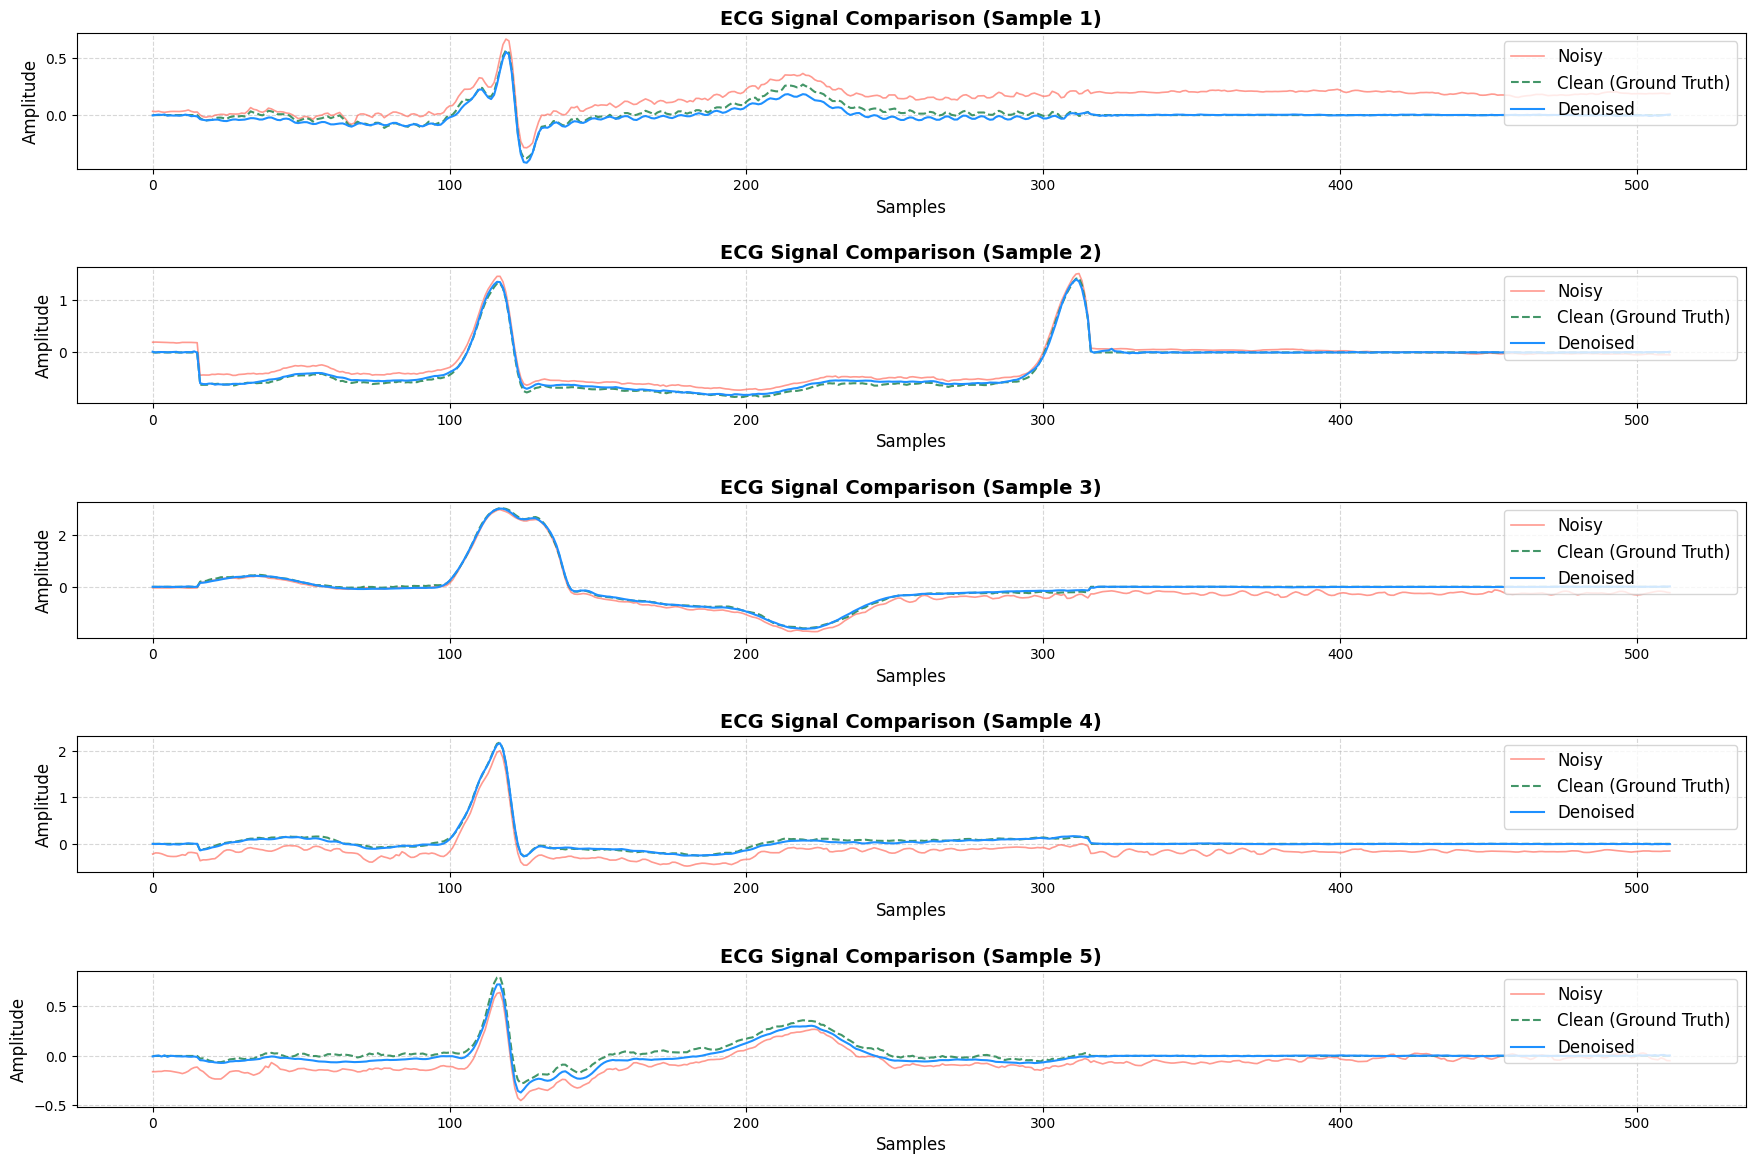

In [59]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ecg_comparison(X_test, y_test, y_pred, num_samples=5):
    """
    Noisy, Clean, and Denoised ECG 신호를 보기 좋게 시각화합니다.
    
    Parameters:
    X_test: Noisy 신호 (입력)
    y_test: Clean 신호 (Ground Truth)
    y_pred: Denoised 신호 (출력)
    num_samples: 시각화할 샘플 수 (기본값: 5)
    """
    plt.figure(figsize=(18, 12))
    
    for i in range(num_samples):
        plt.subplot(num_samples, 1, i + 1)
        
        # Noisy Signal
        plt.plot(X_test[i].squeeze(), color='#FF6F61', linewidth=1.2, alpha=0.7, label='Noisy')
        
        # Clean Signal (Ground Truth)
        plt.plot(y_test[i].squeeze(), color='#2E8B57', linestyle='--', linewidth=1.5, alpha=0.9, label='Clean (Ground Truth)')
        
        # Denoised Signal
        plt.plot(y_pred[i].squeeze(), color='#1E90FF', linestyle='-', linewidth=1.5, label='Denoised')
        
        # Plot Customization
        plt.title(f"ECG Signal Comparison (Sample {i + 1})", fontsize=14, fontweight='bold')
        plt.xlabel("Samples", fontsize=12)
        plt.ylabel("Amplitude", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend(loc='upper right', fontsize=12)
        
    plt.tight_layout(pad=2.0)
    plt.show()

# 시각화 실행
plot_ecg_comparison(X_test, y_test, y_pred, num_samples=5)


In [60]:
def calculate_snr(signal, noise):
    """
    SNR 계산 (dB 단위)
    Parameters:
    signal: 원본 신호
    noise: 노이즈 신호
    
    Returns:
    SNR 값 (dB)
    """
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean(noise ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

# SNR 계산 및 개선율 출력
snr_input = calculate_snr(y_test, X_test - y_test)
snr_output = calculate_snr(y_test, y_pred - y_test)
snr_improvement = snr_output - snr_input

print(f"SNR 입력: {snr_input:.2f} dB")
print(f"SNR 출력: {snr_output:.2f} dB")
print(f"SNR 개선: {snr_improvement:.2f} dB")


SNR 입력: -2.46 dB
SNR 출력: 11.30 dB
SNR 개선: 13.76 dB


In [61]:
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv1D, BatchNormalization, Activation, MaxPooling1D, UpSampling1D, add, multiply, Flatten, Dropout, Dense
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:

# 폴더 생성 함수
def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
# ------------------------
# 데이터 준비
# ------------------------
def prepare_data(X_test, y_test_label):
    X = X_test.squeeze()  # (21890, 512, 1) → (21890, 512)
    y = y_test_label  # 5-Class 라벨 (0~4)

    # Train/Test Split (80:20)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y)
    X_train = np.expand_dims(X_train, axis=2)  # (samples, 512) → (samples, 512, 1)
    X_val = np.expand_dims(X_val, axis=2)

    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
    
    return X_train, X_val, y_train, y_val

# ------------------------
# RTA-CNN 모델 정의
# ------------------------
def conv_block(in_x, nb_filter, kernel_size):
    x = Conv1D(nb_filter, kernel_size, padding='same')(in_x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def attention_branch(in_x, nb_filter, kernel_size):
    x1 = conv_block(in_x, nb_filter, kernel_size)
    x = MaxPooling1D(2)(x1)
    x = conv_block(x, nb_filter, kernel_size)
    x = UpSampling1D(size=2)(x)
    x2 = conv_block(x, nb_filter, kernel_size)
    
    if x1.shape != x2.shape:
        x2 = tf.keras.layers.ZeroPadding1D(1)(x2)
        x2 = tf.keras.layers.Cropping1D((1, 0))(x2)
    
    x = add([x1, x2])
    x = conv_block(x, nb_filter, kernel_size)
    x = Conv1D(nb_filter, 1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)
    return x

def RTA_block(in_x, nb_filter, kernel_size):
    x1 = conv_block(in_x, nb_filter, kernel_size)
    x2 = conv_block(x1, nb_filter, kernel_size)
    attention_map = attention_branch(x1, nb_filter, kernel_size)
    x = multiply([x2, attention_map])
    x = add([x, x1])
    out = conv_block(x, nb_filter, kernel_size)
    return out

def build_RTA_CNN(input_shape=(512, 1), num_classes=5):
    inputs = Input(input_shape)
    x = RTA_block(inputs, 16, 32)
    x = MaxPooling1D(4)(x)
    x = RTA_block(x, 32, 16)
    x = MaxPooling1D(4)(x)
    x = RTA_block(x, 64, 9)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.6)(x)
    x = RTA_block(x, 128, 3)
    x = MaxPooling1D(2)(x)
    x = Flatten()(x)
    x = Dropout(0.7)(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.7)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model



In [63]:
def evaluate_model(X, y, model_name):
    print(f"\nEvaluating Model: {model_name}")
    
    # 데이터 분할
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y)
    X_train = np.expand_dims(X_train, axis=2)
    X_val = np.expand_dims(X_val, axis=2)

    # 모델 생성 및 학습
    model = build_RTA_CNN(input_shape=(512, 1), num_classes=5)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40, batch_size=32, verbose=1)

    # 예측 및 성능 평가
    y_pred_val = np.argmax(model.predict(X_val), axis=1)
    cm = confusion_matrix(y_val, y_pred_val)

    # 결과 저장 경로 설정
    result_dir = f"evaluation_results_mitdb2/{model_name.replace(' ', '_')}/"
    create_dir(result_dir)

    # Confusion Matrix 시각화 및 저장
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["N", "S", "V", "F", "Q"], yticklabels=["N", "S", "V", "F", "Q"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(os.path.join(result_dir, "confusion_matrix.png"))
    plt.close()

    # Classification Report 저장 (소수점 두 자리까지 표시)
    report = classification_report(y_val, y_pred_val, digits=2)
    accuracy = accuracy_score(y_val, y_pred_val)
    with open(os.path.join(result_dir, "evaluation_report.txt"), "w") as file:
        file.write(f"Model: {model_name}\n\n")
        file.write("Classification Report:\n")
        file.write(report + "\n")
        file.write(f"Accuracy: {accuracy:.4f}\n")  # 소수점 두 자리까지 표시

    print(f"Results saved to {result_dir}")
    
# 모델 평가 실행
# [X_test, y_test, y_pred] = test_AttentionSkipDAE
# evaluate_model(X_test.squeeze(), y_test_label, "AttentionSkipDAE (Noisy Data)")
# evaluate_model(y_test.squeeze(), y_test_label, "AttentionSkipDAE (Original Data)")
# evaluate_model(y_pred.squeeze(), y_test_label, "AttentionSkipDAE (Denoised Data)")

# # Transformer_DAE 평가
# [X_test, y_test, y_pred] = test_Transformer_DAE
# evaluate_model(X_test.squeeze(), y_test_label, "Transformer_DAE (Noisy Data)")
# evaluate_model(y_test.squeeze(), y_test_label, "Transformer_DAE (Original Data)")
# evaluate_model(y_pred.squeeze(), y_test_label, "Transformer_DAE (Denoised Data)")

# # Transformer_COMBDAE 평가
# [X_test, y_test, y_pred] = test_Transformer_COMBDAE
# evaluate_model(X_test.squeeze(), y_test_label, "Transformer_COMBDAE (Noisy Data)")
# evaluate_model(y_test.squeeze(), y_test_label, "Transformer_COMBDAE (Original Data)")
# evaluate_model(y_pred.squeeze(), y_test_label, "Transformer_COMBDAE (Denoised Data)")

기본 성능평가가

In [14]:
import wfdb
import _pickle as pickle
from datetime import datetime
import numpy as np

dl_experiments = ['CNN_DAE', 'DRNN','FCN-DAE', 'DeepFilter','AttentionSkipDAE','Transformer_DAE','Transformer_COMBDAE']
    # dl_experiments = ['Transformer_DAE','AttentionSkipDAE']
with open('0221_FIXED/test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_CNN_DAE = pickle.load(input)
with open('0221_FIXED/test_results_' + dl_experiments[1] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)
# Load Results FCN_DAE
with open('0221_FIXED/test_results_'  + dl_experiments[2] + '.pkl', 'rb') as input:
    test_FCN_DAE = pickle.load(input)
# Load Results Multibranch LANLD
with open('0221_FIXED/test_results_'  + dl_experiments[3] + '.pkl', 'rb') as input:
    test_DeepFilter = pickle.load(input)
# Load Results AttentionSkipDAE
with open('0221_FIXED/test_results_'  + dl_experiments[4] + '.pkl', 'rb') as input:
    test_AttentionSkipDAE = pickle.load(input)
# Load Results Transformer_DAE
with open('0221_FIXED/test_results_'  + dl_experiments[5] + '.pkl', 'rb') as input:
    test_Transformer_DAE = pickle.load(input)
# Load Results Transformer_FDAE
with open('0221_FIXED/test_results_'  + dl_experiments[6] + '.pkl', 'rb') as input:
    test_Transformer_COMBDAE = pickle.load(input)
            
# Load Result FIR Filter
with open('1220/test_results_FIR.pkl', 'rb') as input:
    test_FIR = pickle.load(input)
# Load Result IIR Filter
with open('1220/test_results_IIR.pkl', 'rb') as input:
    test_IIR = pickle.load(input)
####### Calculate Metrics #######
print('Calculating metrics ...')
# DL Metrics
# Exp FCN-DAE

# CNN_DAE
[X_test, y_test, y_pred] = test_CNN_DAE
RMSE_values_DL_CNN_DAE = RMSE(y_test, y_pred)
PRD_values_DL_CNN_DAE = PRD(y_test, y_pred)
COS_SIM_values_DL_CNN_DAE = COS_SIM(y_test, y_pred)
SNR_values_DL_CNN_DAE = SNR(y_test, y_pred)

# DRNN
[X_test, y_test, y_pred] = test_DRNN
RMSE_values_DL_DRNN = RMSE(y_test, y_pred)
PRD_values_DL_DRNN = PRD(y_test, y_pred)
COS_SIM_values_DL_DRNN = COS_SIM(y_test, y_pred)
SNR_values_DL_DRNN = SNR(y_test, y_pred)

# Exp FCN-DAE
[X_test, y_test, y_pred] = test_FCN_DAE
RMSE_values_DL_FCN_DAE = RMSE(y_test, y_pred)
PRD_values_DL_FCN_DAE = PRD(y_test, y_pred)
COS_SIM_values_DL_FCN_DAE = COS_SIM(y_test, y_pred)
SNR_values_DL_FCN_DAE = SNR(y_test, y_pred)

# DeepFilter
[X_test, y_test, y_pred] = test_DeepFilter
RMSE_values_DL_exp_1 = RMSE(y_test, y_pred)
PRD_values_DL_exp_1 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_1 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_1 = SNR(y_test, y_pred)

# AttentionSkipDAE
[X_test, y_test, y_pred] = test_AttentionSkipDAE
RMSE_values_DL_exp_2 = RMSE(y_test, y_pred)
PRD_values_DL_exp_2 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_2 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_2 = SNR(y_test, y_pred)

# Transformer_DAE
[X_test, y_test, y_pred] = test_Transformer_DAE
RMSE_values_DL_exp_3 = RMSE(y_test, y_pred)
PRD_values_DL_exp_3 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_3 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_3 = SNR(y_test, y_pred)

# Transformer_COMBDAE
[X_test, y_test, y_pred] = test_Transformer_COMBDAE
RMSE_values_DL_exp_4 = RMSE(y_test, y_pred)
PRD_values_DL_exp_4 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_4 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_4 = SNR(y_test, y_pred)

# Digital Filtering
# FIR Filtering Metrics
[X_test, y_test, y_filter] = test_FIR
RMSE_values_FIR = RMSE(y_test, y_filter)
PRD_values_FIR = PRD(y_test, y_filter)
COS_SIM_values_FIR = COS_SIM(y_test, y_filter)
SNR_values_FIR = SNR(y_test, y_filter)

# IIR Filtering Metrics (Best)
[X_test, y_test, y_filter] = test_IIR
RMSE_values_IIR = RMSE(y_test, y_filter)
PRD_values_IIR = PRD(y_test, y_filter)
COS_SIM_values_IIR = COS_SIM(y_test, y_filter)
SNR_values_IIR = SNR(y_test, y_filter)

####### Results Visualization #######
RMSE_all = [RMSE_values_FIR,
            RMSE_values_IIR,
            RMSE_values_DL_CNN_DAE,
            RMSE_values_DL_FCN_DAE,
            RMSE_values_DL_DRNN,
            RMSE_values_DL_exp_1,
            RMSE_values_DL_exp_2,
            RMSE_values_DL_exp_3,
            RMSE_values_DL_exp_4]

PRD_all = [PRD_values_FIR,
        PRD_values_IIR,
        PRD_values_DL_CNN_DAE,
        PRD_values_DL_FCN_DAE,
        PRD_values_DL_DRNN,
        PRD_values_DL_exp_1,
        PRD_values_DL_exp_2,
        PRD_values_DL_exp_3,
        PRD_values_DL_exp_4
        ]
CORR_all = [COS_SIM_values_FIR,
            COS_SIM_values_IIR,
            COS_SIM_values_DL_CNN_DAE,
            COS_SIM_values_DL_FCN_DAE,
            COS_SIM_values_DL_DRNN,
            COS_SIM_values_DL_exp_1,
            COS_SIM_values_DL_exp_2,
            COS_SIM_values_DL_exp_3,
            COS_SIM_values_DL_exp_4
            ]
SNR_all = [SNR_values_FIR,
        SNR_values_IIR,
        SNR_values_DL_CNN_DAE,
        SNR_values_DL_FCN_DAE,
        SNR_values_DL_DRNN,
        SNR_values_DL_exp_1,
        SNR_values_DL_exp_2,
        SNR_values_DL_exp_3,
        SNR_values_DL_exp_4]
Exp_names = ['FIR Filter', 'IIR Filter'] + dl_experiments
metrics = ['RMSE', 'PRD', 'COS_SIM', 'SNR']
metric_values = [RMSE_all, PRD_all, CORR_all, SNR_all]
# Metrics table
generate_table(metrics, metric_values, Exp_names)


Calculating metrics ...


+---------------------+---------------+-----------------+---------------+----------------+
|        Model        |      RMSE     |       PRD       |    COS_SIM    |      SNR       |
+---------------------+---------------+-----------------+---------------+----------------+
|      FIR Filter     | 0.321 (0.262) | 74.726 (21.008) | 0.595 (0.240) | -1.592 (6.103) |
|      IIR Filter     | 0.301 (0.251) | 72.564 (22.406) | 0.616 (0.242) | -0.852 (6.442) |
|       CNN_DAE       | 0.091 (0.051) | 52.160 (29.385) | 0.873 (0.141) | 7.563 (3.564)  |
|         DRNN        | 0.080 (0.045) | 46.195 (29.824) | 0.895 (0.139) | 8.693 (3.985)  |
|       FCN-DAE       | 0.077 (0.041) | 50.270 (36.779) | 0.891 (0.149) | 8.968 (4.662)  |
|      DeepFilter     | 0.065 (0.033) | 41.965 (31.314) | 0.917 (0.121) | 10.243 (4.531) |
|   AttentionSkipDAE  | 0.070 (0.046) | 37.824 (23.404) | 0.920 (0.124) | 10.295 (4.721) |
|   Transformer_DAE   | 0.057 (0.035) | 31.361 (20.647) | 0.940 

In [78]:
import wfdb
import _pickle as pickle
from datetime import datetime
import numpy as np

dl_experiments = ['DRNN','FCN-DAE', 'DeepFilter','AttentionSkipDAE','Transformer_DAE','Transformer_COMBDAE']
    # dl_experiments = ['Transformer_DAE','AttentionSkipDAE']
with open('0223/test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)
# Load Results FCN_DAE
with open('0223/test_results_'  + dl_experiments[1] + '.pkl', 'rb') as input:
    test_FCN_DAE = pickle.load(input)
# Load Results Multibranch LANLD
with open('0223/test_results_'  + dl_experiments[2] + '.pkl', 'rb') as input:
    test_DeepFilter = pickle.load(input)
# Load Results AttentionSkipDAE
with open('0223/test_results_'  + dl_experiments[3] + '.pkl', 'rb') as input:
    test_AttentionSkipDAE = pickle.load(input)
# Load Results Transformer_DAE
with open('0223/test_results_'  + dl_experiments[4] + '.pkl', 'rb') as input:
    test_Transformer_DAE = pickle.load(input)
# Load Results Transformer_FDAE
with open('0223/test_results_'  + dl_experiments[5] + '.pkl', 'rb') as input:
    test_Transformer_COMBDAE = pickle.load(input)
            
# Load Result FIR Filter
with open('1220/test_results_FIR.pkl', 'rb') as input:
    test_FIR = pickle.load(input)
# Load Result IIR Filter
with open('1220/test_results_IIR.pkl', 'rb') as input:
    test_IIR = pickle.load(input)
####### Calculate Metrics #######
print('Calculating metrics ...')
# DL Metrics
# Exp FCN-DAE

# DRNN
[X_test, y_test, y_pred] = test_DRNN
RMSE_values_DL_DRNN = RMSE(y_test, y_pred)
PRD_values_DL_DRNN = PRD(y_test, y_pred)
COS_SIM_values_DL_DRNN = COS_SIM(y_test, y_pred)
SNR_values_DL_DRNN = SNR(y_test, y_pred)

# Exp FCN-DAE
[X_test, y_test, y_pred] = test_FCN_DAE
RMSE_values_DL_FCN_DAE = RMSE(y_test, y_pred)
PRD_values_DL_FCN_DAE = PRD(y_test, y_pred)
COS_SIM_values_DL_FCN_DAE = COS_SIM(y_test, y_pred)
SNR_values_DL_FCN_DAE = SNR(y_test, y_pred)

# DeepFilter
[X_test, y_test, y_pred] = test_DeepFilter
RMSE_values_DL_exp_1 = RMSE(y_test, y_pred)
PRD_values_DL_exp_1 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_1 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_1 = SNR(y_test, y_pred)

# AttentionSkipDAE
[X_test, y_test, y_pred] = test_AttentionSkipDAE
RMSE_values_DL_exp_2 = RMSE(y_test, y_pred)
PRD_values_DL_exp_2 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_2 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_2 = SNR(y_test, y_pred)

# Transformer_DAE
[X_test, y_test, y_pred] = test_Transformer_DAE
RMSE_values_DL_exp_3 = RMSE(y_test, y_pred)
PRD_values_DL_exp_3 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_3 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_3 = SNR(y_test, y_pred)

# Transformer_COMBDAE
[X_test, y_test, y_pred] = test_Transformer_COMBDAE
RMSE_values_DL_exp_4 = RMSE(y_test, y_pred)
PRD_values_DL_exp_4 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_4 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_4 = SNR(y_test, y_pred)

# Digital Filtering
# FIR Filtering Metrics
[X_test, y_test, y_filter] = test_FIR
RMSE_values_FIR = RMSE(y_test, y_filter)
PRD_values_FIR = PRD(y_test, y_filter)
COS_SIM_values_FIR = COS_SIM(y_test, y_filter)
SNR_values_FIR = SNR(y_test, y_filter)

# IIR Filtering Metrics (Best)
[X_test, y_test, y_filter] = test_IIR
RMSE_values_IIR = RMSE(y_test, y_filter)
PRD_values_IIR = PRD(y_test, y_filter)
COS_SIM_values_IIR = COS_SIM(y_test, y_filter)
SNR_values_IIR = SNR(y_test, y_filter)

####### Results Visualization #######
RMSE_all = [RMSE_values_FIR,
            RMSE_values_IIR,
            RMSE_values_DL_FCN_DAE,
            RMSE_values_DL_DRNN,
            RMSE_values_DL_exp_1,
            RMSE_values_DL_exp_2,
            RMSE_values_DL_exp_3,
            RMSE_values_DL_exp_4]

PRD_all = [PRD_values_FIR,
        PRD_values_IIR,
        PRD_values_DL_FCN_DAE,
        PRD_values_DL_DRNN,
        PRD_values_DL_exp_1,
        PRD_values_DL_exp_2,
        PRD_values_DL_exp_3,
        PRD_values_DL_exp_4
        ]
CORR_all = [COS_SIM_values_FIR,
            COS_SIM_values_IIR,
            COS_SIM_values_DL_FCN_DAE,
            COS_SIM_values_DL_DRNN,
            COS_SIM_values_DL_exp_1,
            COS_SIM_values_DL_exp_2,
            COS_SIM_values_DL_exp_3,
            COS_SIM_values_DL_exp_4
            ]
SNR_all = [SNR_values_FIR,
        SNR_values_IIR,
        SNR_values_DL_FCN_DAE,
        SNR_values_DL_DRNN,
        SNR_values_DL_exp_1,
        SNR_values_DL_exp_2,
        SNR_values_DL_exp_3,
        SNR_values_DL_exp_4]
Exp_names = ['FIR Filter', 'IIR Filter'] + dl_experiments
metrics = ['RMSE', 'PRD', 'COS_SIM', 'SNR']
metric_values = [RMSE_all, PRD_all, CORR_all, SNR_all]
# Metrics table
generate_table(metrics, metric_values, Exp_names)


Calculating metrics ...


+---------------------+---------------+-----------------+---------------+----------------+
|        Model        |      RMSE     |       PRD       |    COS_SIM    |      SNR       |
+---------------------+---------------+-----------------+---------------+----------------+
|      FIR Filter     | 0.321 (0.262) | 74.726 (21.008) | 0.595 (0.240) | -1.592 (6.103) |
|      IIR Filter     | 0.301 (0.251) | 72.564 (22.406) | 0.616 (0.242) | -0.852 (6.442) |
|         DRNN        | 0.087 (0.050) | 49.842 (32.180) | 0.878 (0.147) | 8.098 (4.113)  |
|       FCN-DAE       | 0.082 (0.042) | 55.611 (37.532) | 0.891 (0.143) | 8.348 (3.991)  |
|      DeepFilter     | 0.070 (0.033) | 45.524 (33.639) | 0.908 (0.119) | 9.560 (4.245)  |
|   AttentionSkipDAE  | 0.075 (0.045) | 41.358 (23.830) | 0.912 (0.127) | 9.460 (4.419)  |
|   Transformer_DAE   | 0.061 (0.037) | 32.642 (20.610) | 0.934 (0.107) | 11.231 (4.859) |
| Transformer_COMBDAE | 0.057 (0.032) | 30.842 (18.867) | 0.938 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy.signal import welch
import pickle
import os

# === FFT & PSD 계산 함수 === #
def compute_fft(signal, fs=360):
    """전체 샘플의 평균 FFT 계산"""
    N = signal.shape[1]  # 샘플 길이 (512)
    freq = np.fft.fftfreq(N, d=1/fs)[:N//2]  # 양수 주파수만
    fft_magnitude = np.abs(fft(signal, axis=1))[:, :N//2]  # 각 샘플에 대해 FFT 수행 후 절댓값
    mean_fft = np.mean(fft_magnitude, axis=0)  # 전체 샘플 평균
    return freq, mean_fft

def compute_psd(signal, fs=360):
    """전체 샘플의 평균 PSD 계산"""
    psd_list = []
    freq, _ = welch(signal[0], fs=fs, nperseg=256)  # 주파수 축 설정
    for i in range(signal.shape[0]):
        _, psd = welch(signal[i], fs=fs, nperseg=256)
        psd_list.append(psd)
    mean_psd = np.mean(np.array(psd_list), axis=0)  # 전체 샘플 평균
    return freq, mean_psd

# === 모델 및 SNR 폴더 설정 === #
save_dir = "fig16"
snr_folders = ["0221_FIXED", "0221_snr0db", "0221_snr3db", "0221_snr6db"]
dl_models = ["DRNN", "FCN-DAE", "DeepFilter", "AttentionSkipDAE", "Transformer_DAE", "Transformer_COMBDAE"]

# === 모델별 주파수 분석 === #
for dl_model in dl_models:
    fig, axes = plt.subplots(len(snr_folders), 2, figsize=(12, 18))  # FFT & PSD 비교 (2개 컬럼)
    
    for i, snr_folder in enumerate(snr_folders):
        try:
            # === 데이터 로드 === #
            with open(f"{snr_folder}/test_results_{dl_model}.pkl", "rb") as f:
                X_test, y_test, y_pred = pickle.load(f)

            X_test = np.squeeze(X_test)  # (13316, 512)
            y_test = np.squeeze(y_test)
            y_pred = np.squeeze(y_pred)

            # === 전체 샘플 평균 FFT 계산 === #
            freq, fft_y_test = compute_fft(y_test)
            _, fft_X_test = compute_fft(X_test)
            _, fft_y_pred = compute_fft(y_pred)

            # === 전체 샘플 평균 PSD 계산 === #
            freq_psd, psd_y_test = compute_psd(y_test)
            _, psd_X_test = compute_psd(X_test)
            _, psd_y_pred = compute_psd(y_pred)

            # === FFT 비교 플롯 === #
            axes[i, 0].plot(freq, fft_y_test, label="Original", color="red")
            axes[i, 0].plot(freq, fft_X_test, label="Noisy", color="blue", alpha=0.6)
            axes[i, 0].plot(freq, fft_y_pred, label="Reconstructed", color="green")
            axes[i, 0].set_title(f"{dl_model} - {snr_folder} FFT (Mean)", fontsize=14)
            axes[i, 0].set_xlabel("Frequency (Hz)")
            axes[i, 0].set_ylabel("Amplitude")
            axes[i, 0].legend()

            # === PSD 비교 플롯 === #
            axes[i, 1].semilogy(freq_psd, psd_y_test, label="Original", color="red")
            axes[i, 1].semilogy(freq_psd, psd_X_test, label="Noisy", color="blue", alpha=0.6)
            axes[i, 1].semilogy(freq_psd, psd_y_pred, label="Reconstructed", color="green")
            axes[i, 1].set_title(f"{dl_model} - {snr_folder} PSD (Mean)", fontsize=14)
            axes[i, 1].set_xlabel("Frequency (Hz)")
            axes[i, 1].set_ylabel("Power Spectral Density (dB/Hz)")
            axes[i, 1].legend()

        except FileNotFoundError:
            print(f"[WARNING] {snr_folder}/test_results_{dl_model}.pkl not found. Skipping...")

    plt.tight_layout()
    save_path = os.path.join(save_dir, f"{dl_model}_frequency_analysis_mean.png")
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"[INFO] Frequency analysis saved: {save_path}")


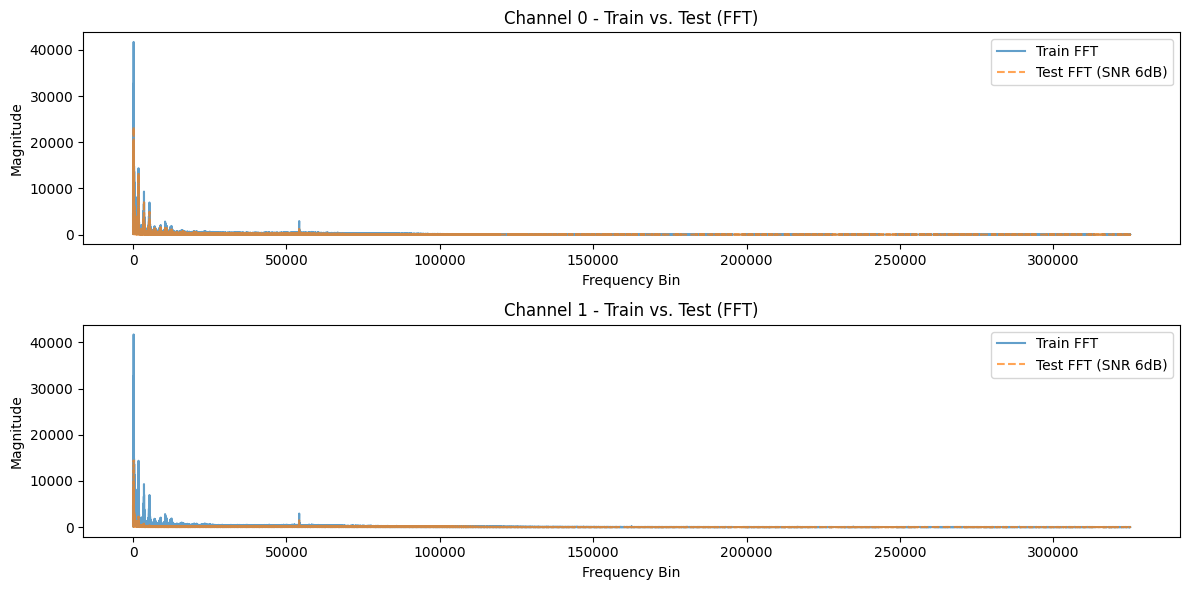

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.fft import fft

# Train 데이터 불러오기
with open('data/CombinedNoise_Train.pkl', 'rb') as f:
    train_noise = pickle.load(f)

# Test 데이터 불러오기 (SNR 0, 6, 12 중 하나 선택)
with open('data/Mixed_Noise_SNR_6.pkl', 'rb') as f:
    test_noise = pickle.load(f).squeeze(-1)  # Shape: (2, 650000)

# FFT 계산
train_fft = np.abs(fft(train_noise, axis=0))
test_fft = np.abs(fft(test_noise, axis=1))

# FFT 결과의 절반만 사용
train_fft_half = train_fft[:len(train_fft)//2]
test_fft_half = test_fft[:, :test_fft.shape[1]//2]

# 주파수 도메인 비교 시각화
plt.figure(figsize=(12, 6))
for ch in range(2):
    plt.subplot(2, 1, ch + 1)
    plt.plot(train_fft_half, label="Train FFT", alpha=0.7)
    plt.plot(test_fft_half[ch], label="Test FFT (SNR 6dB)", alpha=0.7, linestyle='dashed')
    plt.xlabel("Frequency Bin")
    plt.ylabel("Magnitude")
    plt.title(f"Channel {ch} - Train vs. Test (FFT)")
    plt.legend()

plt.tight_layout()
plt.show()

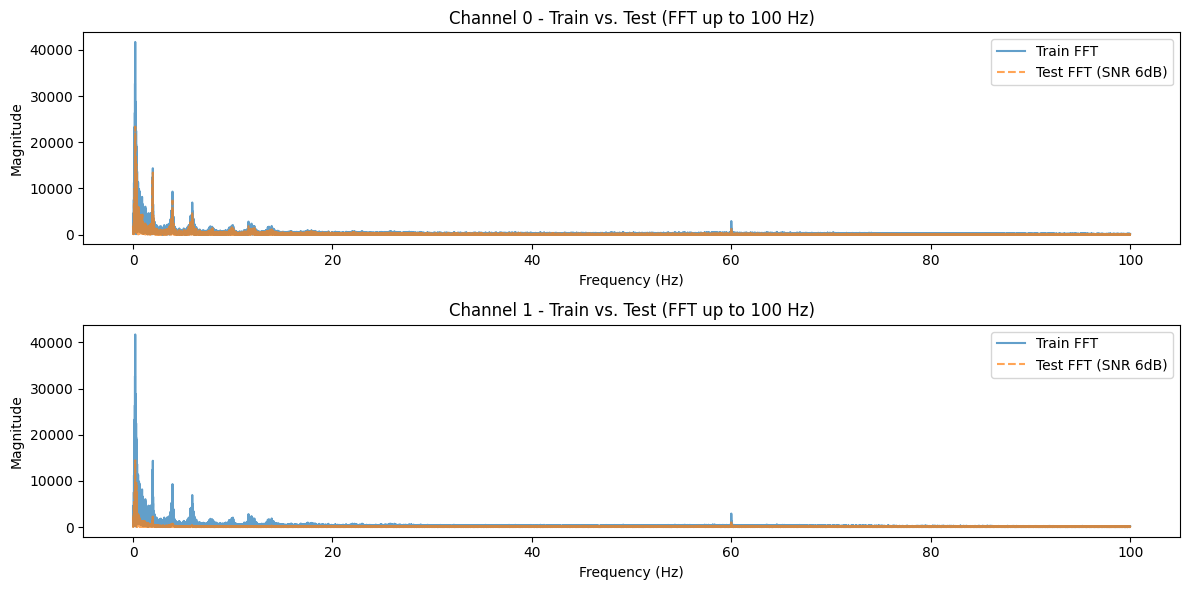

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.fft import fft

# 샘플링 주파수 (예시: 1000 Hz)
fs = 360  # 이 값을 실제 샘플링 주파수로 변경하세요.

# Train 데이터 불러오기
with open('data/CombinedNoise_Train.pkl', 'rb') as f:
    train_noise = pickle.load(f)

# Test 데이터 불러오기 (SNR 0, 6, 12 중 하나 선택)
with open('data/Mixed_Noise_SNR_6.pkl', 'rb') as f:
    test_noise = pickle.load(f).squeeze(-1)  # Shape: (2, 650000)

# FFT 계산
train_fft = np.abs(fft(train_noise, axis=0))
test_fft = np.abs(fft(test_noise, axis=1))

# FFT 결과의 절반만 사용
train_fft_half = train_fft[:len(train_fft)//2]
test_fft_half = test_fft[:, :test_fft.shape[1]//2]

# 주파수 축 생성
N_train = len(train_fft_half)
N_test = test_fft_half.shape[1]
freq_train = np.linspace(0, fs, N_train)  # Train 데이터 주파수 축
freq_test = np.linspace(0, fs, N_test)    # Test 데이터 주파수 축

# 100 Hz에 해당하는 빈 찾기
max_bin_train = int(100 / (fs / N_train))  # Train 데이터에서 100 Hz에 해당하는 빈
max_bin_test = int(100 / (fs / N_test))    # Test 데이터에서 100 Hz에 해당하는 빈

# 주파수 도메인 비교 시각화 (100 Hz까지)
plt.figure(figsize=(12, 6))
for ch in range(2):
    plt.subplot(2, 1, ch + 1)
    plt.plot(freq_train[:max_bin_train], train_fft_half[:max_bin_train], label="Train FFT", alpha=0.7)
    plt.plot(freq_test[:max_bin_test], test_fft_half[ch, :max_bin_test], label="Test FFT (SNR 6dB)", alpha=0.7, linestyle='dashed')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.title(f"Channel {ch} - Train vs. Test (FFT up to 100 Hz)")
    plt.legend()

plt.tight_layout()
plt.show()

/home/dhc99/anaconda3/envs/ECGDENOISE/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dhc99/anaconda3/envs/ECGDENOISE/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dhc99/anaconda3/envs/ECGDENOISE/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dhc99/anaconda3/envs/ECGDENOISE/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dhc99/anaconda3/envs/ECGDENOISE/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: U

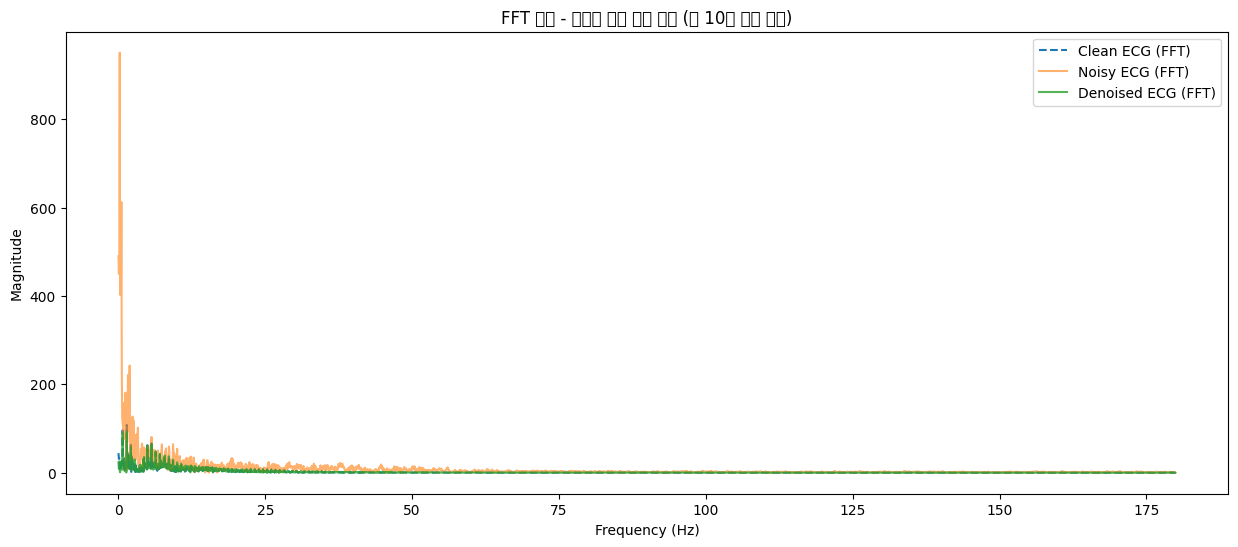

In [57]:
from scipy.fft import fft
import numpy as np
import matplotlib.pyplot as plt

# 여러 개 샘플을 연결하여 긴 신호 생성
num_samples = 10  # 붙일 샘플 개수
total_noisy = np.concatenate([X_test[i].squeeze() for i in range(num_samples)], axis=0)
total_clean = np.concatenate([y_test[i].squeeze() for i in range(num_samples)], axis=0)
total_denoised = np.concatenate([y_pred[i].squeeze() for i in range(num_samples)], axis=0)

# FFT 변환
noisy_fft = np.abs(fft(total_noisy))
clean_fft = np.abs(fft(total_clean))
denoised_fft = np.abs(fft(total_denoised))

# 주파수 축 생성
freq_bins = np.fft.fftfreq(len(clean_fft), d=1/360)  # 360Hz 샘플링 기준

# 주파수 도메인 비교
plt.figure(figsize=(15, 6))
plt.plot(freq_bins[:len(freq_bins)//2], clean_fft[:len(freq_bins)//2], label="Clean ECG (FFT)", linestyle="dashed")
plt.plot(freq_bins[:len(freq_bins)//2], noisy_fft[:len(freq_bins)//2], label="Noisy ECG (FFT)", alpha=0.6)
plt.plot(freq_bins[:len(freq_bins)//2], denoised_fft[:len(freq_bins)//2], label="Denoised ECG (FFT)", alpha=0.8)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title(f"FFT 비교 - 노이즈 제거 전후 변화 (총 {num_samples}개 샘플 합산)")
plt.legend()
plt.show()


In [ ]:
# === QTDataset에서 'sel123' 찾기 === #
with open('data/QTDatabase.pkl', 'rb') as input:
    qtdb = pickle.load(input)

# 첫 번째 차원의 크기
print(len(sel123_data))  # 2

# 두 번째 차원의 크기 (첫 번째 요소의 길이)
print(len(sel123_data[0])) 

643
512


In [71]:
y_test.shape

(13316, 512, 1)

In [ ]:
# #비교 방식 수정
# → np.isin() 대신에 각 y_test[idx]와 sel123_data의 샘플 간 L2 norm 거리를 계산하여 일정 거리 이하인 샘플을 sel123_indices로 선택하면 됨.
sel123_data = qtdb["sel123"]  # 'sel123' 데이터 가져오기
sel123_data = np.array([s[:512] if len(s) >= 512 else np.pad(s, (0, 512 - len(s)), 'constant') for s in sel123_data])  # 길이 맞추기

print(f"[INFO] 'sel123' 데이터 크기: {sel123_data.shape}")  # (643, 512)

[INFO] 'sel123' 데이터 크기: (643, 512)


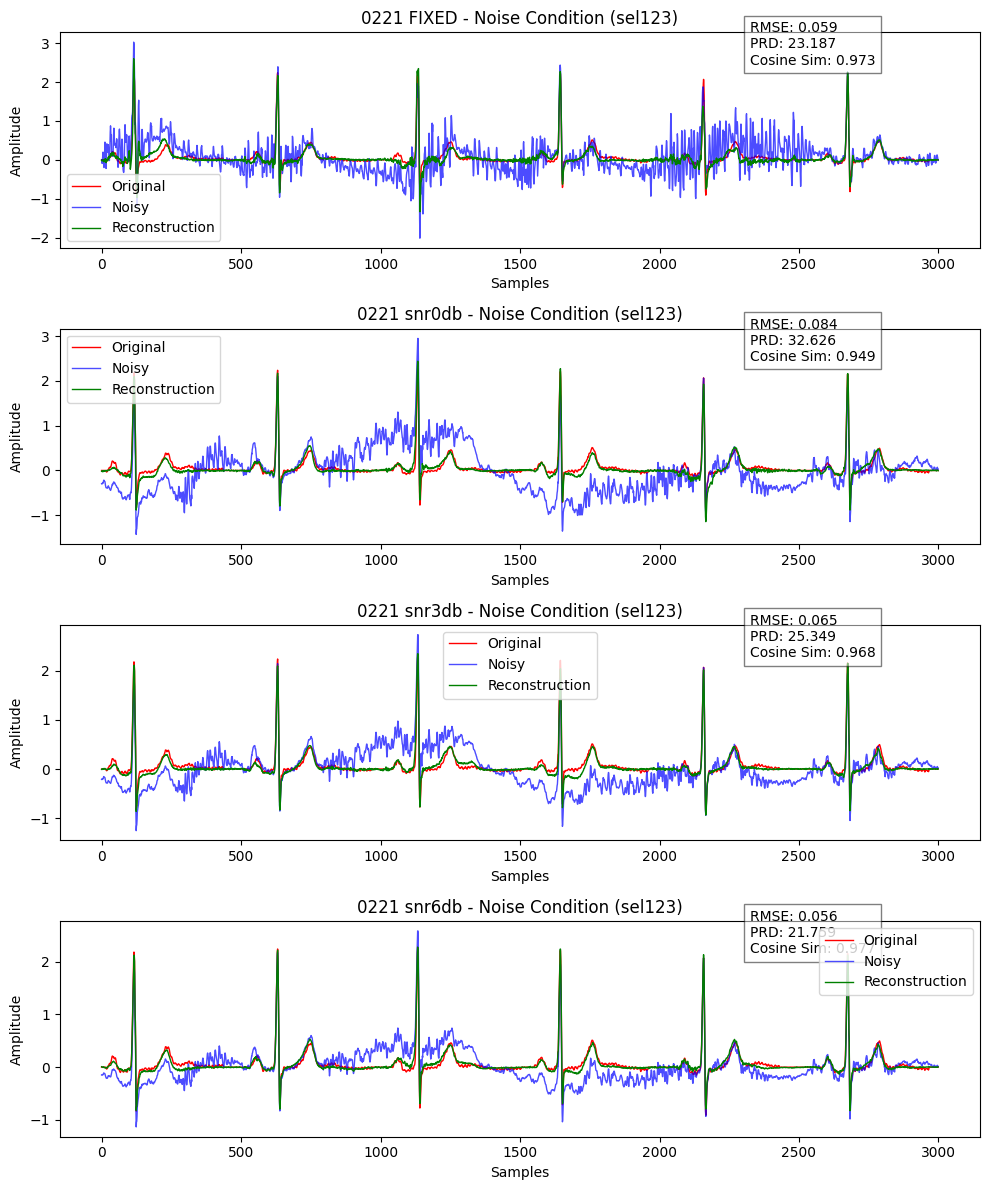

ModuleNotFoundError: No module named 'ace_tools'

In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.metrics import mean_squared_error

# === SNR별 폴더 및 모델 정의 === #
snr_folders = ["0221_FIXED", "0221_snr0db","0221_snr3db", "0221_snr6db"]  # 다양한 SNR 폴더
dl_model = "Transformer_COMBDAE"  # 사용할 모델

# === 평가 지표 계산 함수 === #
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def PRD(y_true, y_pred):
    return 100 * np.sqrt(np.sum((y_true - y_pred) ** 2) / np.sum(y_true ** 2))

def Cosine_Similarity(y_true, y_pred):
    return 1 - cosine(y_true.flatten(), y_pred.flatten())

# === Reconstruction Metrics 저장용 리스트 === #
snr_results = []

# === 시각화 설정 === #
fig, axes = plt.subplots(len(snr_folders), 1, figsize=(10, 12))

# axes가 단일 객체인지 확인
if len(snr_folders) == 1:
    axes = [axes]  # axes를 리스트로 감싸서 처리

for i, snr_folder in enumerate(snr_folders):
    # === 모델 테스트 데이터 로드 === #
    with open(f"{snr_folder}/test_results_{dl_model}.pkl", "rb") as f:
        X_test, y_test, y_pred = pickle.load(f)

    y_test = np.squeeze(y_test)  # (N, 512) 형태로 변환
    X_test = np.squeeze(X_test)
    y_pred = np.squeeze(y_pred)

    # 'sel123'에 해당하는 데이터만 추출 (연결)
    sel123_range = slice(3213, 3833)  # sel123에 해당하는 인덱스 범위
    long_X_test = np.concatenate(X_test[sel123_range], axis=0)
    long_y_test = np.concatenate(y_test[sel123_range], axis=0)
    long_y_pred = np.concatenate(y_pred[sel123_range], axis=0)

    # === Reconstruction Metrics 계산 === #
    rmse_value = RMSE(long_y_test, long_y_pred)
    prd_value = PRD(long_y_test, long_y_pred)
    cos_sim_value = Cosine_Similarity(long_y_test, long_y_pred)

    # 결과 저장 (SNR별 성능 비교용)
    snr_results.append([snr_folder.replace("0221_", ""), rmse_value, prd_value, cos_sim_value])

    # === 일부 구간만 시각화 (너무 길면 보기 어려우므로 일부 샘플 선택) === #
    vis_start = 0
    vis_end = 3000  # 3000개의 샘플만 보기

    ax = axes[i]
    ax.plot(long_y_test[vis_start:vis_end], label="Original", color="red", linewidth=1)
    ax.plot(long_X_test[vis_start:vis_end], label="Noisy", color="blue", linewidth=1, alpha=0.7)
    ax.plot(long_y_pred[vis_start:vis_end], label="Reconstruction", color="green", linewidth=1)

    ax.set_xlabel("Samples")
    ax.set_ylabel("Amplitude")
    ax.set_title(f"{snr_folder.replace('_', ' ')} - Noise Condition (sel123)")
    ax.legend()

    # Reconstruction Metrics 추가
    ax.text(0.75, 0.85, f"RMSE: {rmse_value:.3f}\nPRD: {prd_value:.3f}\nCosine Sim: {cos_sim_value:.3f}", 
            transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

# === 테이블 형태로 출력 === #
import pandas as pd
df_results = pd.DataFrame(snr_results, columns=["SNR", "RMSE", "PRD", "Cosine Similarity"])
# import ace_tools as tools
# tools.display_dataframe_to_user(name="Reconstruction by SNR", dataframe=df_results)


In [117]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.spatial.distance import cosine
from sklearn.metrics import mean_squared_error

# === SNR별 폴더 및 모델 정의 === #
snr_folders = ["0221_FIXED", "0221_snr0db", "0221_snr3db", "0221_snr6db"]
snr_labels = ["Mixed", "0 dB", "3 dB", "6 dB"]  # Fixed → Mixed
dl_models = ['DRNN','FCN-DAE', 'DeepFilter','AttentionSkipDAE','Transformer_DAE', 'Transformer_COMBDAE']

# === 평가 지표 계산 함수 === #
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def PRD(y_true, y_pred):
    return 100 * np.sqrt(np.sum((y_true - y_pred) ** 2) / np.sum(y_true ** 2))

def Cosine_Similarity(y_true, y_pred):
    return 1 - cosine(y_true.flatten(), y_pred.flatten())

# === Reconstruction Metrics 저장용 리스트 === #
all_results = []

# === Figure 저장 폴더 생성 === #
fig_save_path = "fig10"
os.makedirs(fig_save_path, exist_ok=True)

for j, dl_model in enumerate(dl_models):
    for i, (snr_folder, snr_label) in enumerate(zip(snr_folders, snr_labels)):
        # === 모델 테스트 데이터 로드 === #
        try:
            with open(f"{snr_folder}/test_results_{dl_model}.pkl", "rb") as f:
                X_test, y_test, y_pred = pickle.load(f)
        except FileNotFoundError:
            print(f"[ERROR] {snr_folder}/test_results_{dl_model}.pkl not found.")
            continue

        y_test = np.squeeze(y_test)  # (N, 512) 형태로 변환
        X_test = np.squeeze(X_test)
        y_pred = np.squeeze(y_pred)

        # 'sel123'에 해당하는 데이터만 추출 (연결)
        sel123_range = slice(3213, 3833)
        long_X_test = np.concatenate(X_test[sel123_range], axis=0)
        long_y_test = np.concatenate(y_test[sel123_range], axis=0)
        long_y_pred = np.concatenate(y_pred[sel123_range], axis=0)

        # === Reconstruction Metrics 계산 === #
        rmse_value = RMSE(long_y_test, long_y_pred)
        prd_value = PRD(long_y_test, long_y_pred)
        cos_sim_value = Cosine_Similarity(long_y_test, long_y_pred)

        # 결과 저장 (DataFrame 용)
        all_results.append([dl_model, snr_label, rmse_value, prd_value, cos_sim_value])

        # === 일부 구간만 시각화 === #
        vis_start = 0
        vis_end = 3000  # 3000개의 샘플만 보기
        fig, ax = plt.subplots(figsize=(8, 4))

        # Original (빨강, 두껍게)
        ax.plot(long_y_test[vis_start:vis_end], label="Original", color="#FF0000", linewidth=1.0, alpha=1.0)
        # Noisy (파랑, 연하게)
        ax.plot(long_X_test[vis_start:vis_end], label="Noisy", color="#0066FF", linewidth=0.7, alpha=0.7)
        # Denoised (녹색, 두껍게)
        ax.plot(long_y_pred[vis_start:vis_end], label="Denoised", color="#00CC00", linewidth=1.2, alpha=0.9)

        ax.set_xlabel("Samples", fontsize=12, fontweight='bold')
        ax.set_ylabel("Amplitude", fontsize=12, fontweight='bold')
        ax.set_title(f"{snr_label} Noise - {dl_model}", fontsize=14, fontweight='bold')

        # 범례 크기 조정 및 위치 조정
        ax.legend(fontsize=6, loc="lower right")

        # 배경 그리드 추가
        ax.grid(True, linestyle="--", alpha=0.6)

        # X축 값 표시 간격 조정 (500 단위)
        ax.set_xticks(np.linspace(0, vis_end, num=7))
        ax.set_xticklabels([f"{int(x)}" for x in np.linspace(0, vis_end, num=7)], fontsize=10)

        # 그래프 저장
        fig.savefig(os.path.join(fig_save_path, f"SNR_{snr_label.replace(' ', '')}_{dl_model}.png"), dpi=300)
        plt.close(fig)  # 메모리 절약을 위해 Figure 닫기

# === 테이블 형태로 저장 및 출력 === #
df_results = pd.DataFrame(all_results, columns=["Model", "SNR", "RMSE", "PRD", "Cosine Similarity"])
df_results_pivot = df_results.pivot(index="Model", columns="SNR", values=["RMSE", "PRD", "Cosine Similarity"])

# CSV 저장
df_results.to_csv(os.path.join(fig_save_path, "Reconstruction_Metrics.csv"), index=False)

# DataFrame 출력
print("\n=== Reconstruction Metrics by Model & SNR ===")
print(df_results_pivot)



=== Reconstruction Metrics by Model & SNR ===
                         RMSE                                      PRD  \
SNR                      0 dB      3 dB      6 dB     Mixed       0 dB   
Model                                                                    
AttentionSkipDAE     0.083266  0.066408  0.056241  0.069577  32.513175   
DRNN                 0.117914  0.094757  0.072798  0.075791  46.042454   
DeepFilter           0.101386  0.082620  0.070247  0.064785  39.588565   
FCN-DAE              0.088379  0.076053  0.075008  0.076088  34.509625   
Transformer_COMBDAE  0.083554  0.064918  0.055724  0.059382  32.625740   
Transformer_DAE      0.087483  0.067092  0.057214  0.061212  34.159849   

                                                     Cosine Similarity  \
SNR                       3 dB       6 dB      Mixed              0 dB   
Model                                                                    
AttentionSkipDAE     25.930799  21.960563  27.168207          0.

In [ ]:
len(sel123_indices)
y_test[3212:3832]

SNR 0DB

In [53]:
import wfdb
import _pickle as pickle
from datetime import datetime
import numpy as np

dl_experiments = ['DRNN','FCN-DAE', 'DeepFilter','AttentionSkipDAE','Transformer_DAE','Transformer_COMBDAE']
    # dl_experiments = ['Transformer_DAE','AttentionSkipDAE']
with open('0221_snr0db/test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)
# Load Results FCN_DAE
with open('0221_snr0db/test_results_'  + dl_experiments[1] + '.pkl', 'rb') as input:
    test_FCN_DAE = pickle.load(input)
# Load Results Multibranch LANLD
with open('0221_snr0db/test_results_'  + dl_experiments[2] + '.pkl', 'rb') as input:
    test_DeepFilter = pickle.load(input)
# Load Results AttentionSkipDAE
with open('0221_snr0db/test_results_'  + dl_experiments[3] + '.pkl', 'rb') as input:
    test_AttentionSkipDAE = pickle.load(input)
# Load Results Transformer_DAE
with open('0221_snr0db/test_results_'  + dl_experiments[4] + '.pkl', 'rb') as input:
    test_Transformer_DAE = pickle.load(input)
# Load Results Transformer_FDAE
with open('0221_snr0db/test_results_'  + dl_experiments[5] + '.pkl', 'rb') as input:
    test_Transformer_COMBDAE = pickle.load(input)
            
# Load Result FIR Filter
with open('1220/test_results_FIR.pkl', 'rb') as input:
    test_FIR = pickle.load(input)
# Load Result IIR Filter
with open('1220/test_results_IIR.pkl', 'rb') as input:
    test_IIR = pickle.load(input)
####### Calculate Metrics #######
print('Calculating metrics ...')
# DL Metrics
# Exp FCN-DAE

# DRNN
[X_test, y_test, y_pred] = test_DRNN
RMSE_values_DL_DRNN = RMSE(y_test, y_pred)
PRD_values_DL_DRNN = PRD(y_test, y_pred)
COS_SIM_values_DL_DRNN = COS_SIM(y_test, y_pred)
SNR_values_DL_DRNN = SNR(y_test, y_pred)

# Exp FCN-DAE
[X_test, y_test, y_pred] = test_FCN_DAE
RMSE_values_DL_FCN_DAE = RMSE(y_test, y_pred)
PRD_values_DL_FCN_DAE = PRD(y_test, y_pred)
COS_SIM_values_DL_FCN_DAE = COS_SIM(y_test, y_pred)
SNR_values_DL_FCN_DAE = SNR(y_test, y_pred)

# DeepFilter
[X_test, y_test, y_pred] = test_DeepFilter
RMSE_values_DL_exp_1 = RMSE(y_test, y_pred)
PRD_values_DL_exp_1 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_1 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_1 = SNR(y_test, y_pred)

# AttentionSkipDAE
[X_test, y_test, y_pred] = test_AttentionSkipDAE
RMSE_values_DL_exp_2 = RMSE(y_test, y_pred)
PRD_values_DL_exp_2 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_2 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_2 = SNR(y_test, y_pred)

# Transformer_DAE
[X_test, y_test, y_pred] = test_Transformer_DAE
RMSE_values_DL_exp_3 = RMSE(y_test, y_pred)
PRD_values_DL_exp_3 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_3 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_3 = SNR(y_test, y_pred)

# Transformer_COMBDAE
[X_test, y_test, y_pred] = test_Transformer_COMBDAE
RMSE_values_DL_exp_4 = RMSE(y_test, y_pred)
PRD_values_DL_exp_4 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_4 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_4 = SNR(y_test, y_pred)

# Digital Filtering
# FIR Filtering Metrics
[X_test, y_test, y_filter] = test_FIR
RMSE_values_FIR = RMSE(y_test, y_filter)
PRD_values_FIR = PRD(y_test, y_filter)
COS_SIM_values_FIR = COS_SIM(y_test, y_filter)
SNR_values_FIR = SNR(y_test, y_filter)

# IIR Filtering Metrics (Best)
[X_test, y_test, y_filter] = test_IIR
RMSE_values_IIR = RMSE(y_test, y_filter)
PRD_values_IIR = PRD(y_test, y_filter)
COS_SIM_values_IIR = COS_SIM(y_test, y_filter)
SNR_values_IIR = SNR(y_test, y_filter)

####### Results Visualization #######
RMSE_all = [RMSE_values_FIR,
            RMSE_values_IIR,
            RMSE_values_DL_FCN_DAE,
            RMSE_values_DL_DRNN,
            RMSE_values_DL_exp_1,
            RMSE_values_DL_exp_2,
            RMSE_values_DL_exp_3,
            RMSE_values_DL_exp_4]

PRD_all = [PRD_values_FIR,
        PRD_values_IIR,
        PRD_values_DL_FCN_DAE,
        PRD_values_DL_DRNN,
        PRD_values_DL_exp_1,
        PRD_values_DL_exp_2,
        PRD_values_DL_exp_3,
        PRD_values_DL_exp_4
        ]
CORR_all = [COS_SIM_values_FIR,
            COS_SIM_values_IIR,
            COS_SIM_values_DL_FCN_DAE,
            COS_SIM_values_DL_DRNN,
            COS_SIM_values_DL_exp_1,
            COS_SIM_values_DL_exp_2,
            COS_SIM_values_DL_exp_3,
            COS_SIM_values_DL_exp_4
            ]
SNR_all = [SNR_values_FIR,
        SNR_values_IIR,
        SNR_values_DL_FCN_DAE,
        SNR_values_DL_DRNN,
        SNR_values_DL_exp_1,
        SNR_values_DL_exp_2,
        SNR_values_DL_exp_3,
        SNR_values_DL_exp_4]
Exp_names = ['FIR Filter', 'IIR Filter'] + dl_experiments
metrics = ['RMSE', 'PRD', 'COS_SIM', 'SNR']
metric_values = [RMSE_all, PRD_all, CORR_all, SNR_all]
# Metrics table
generate_table(metrics, metric_values, Exp_names)


Calculating metrics ...


+---------------------+---------------+-----------------+---------------+----------------+
|        Model        |      RMSE     |       PRD       |    COS_SIM    |      SNR       |
+---------------------+---------------+-----------------+---------------+----------------+
|      FIR Filter     | 0.321 (0.262) | 74.726 (21.008) | 0.595 (0.240) | -1.592 (6.103) |
|      IIR Filter     | 0.301 (0.251) | 72.564 (22.406) | 0.616 (0.242) | -0.852 (6.442) |
|         DRNN        | 0.089 (0.040) | 51.386 (30.570) | 0.870 (0.156) | 7.403 (3.758)  |
|       FCN-DAE       | 0.106 (0.050) | 73.038 (60.406) | 0.792 (0.235) | 5.877 (4.340)  |
|      DeepFilter     | 0.101 (0.038) | 64.371 (41.051) | 0.812 (0.204) | 6.102 (3.950)  |
|   AttentionSkipDAE  | 0.080 (0.038) | 45.244 (25.484) | 0.893 (0.137) | 8.379 (4.144)  |
|   Transformer_DAE   | 0.081 (0.042) | 43.191 (25.293) | 0.890 (0.146) | 8.358 (4.681)  |
| Transformer_COMBDAE | 0.074 (0.039) | 38.518 (22.073) | 0.904 

In [104]:
import wfdb
import _pickle as pickle
from datetime import datetime
import numpy as np

dl_experiments = ['DRNN','FCN-DAE', 'DeepFilter','AttentionSkipDAE','Transformer_DAE','Transformer_COMBDAE']
    # dl_experiments = ['Transformer_DAE','AttentionSkipDAE']
with open('0221_snr3db/test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)
# Load Results FCN_DAE
with open('0221_snr3db/test_results_'  + dl_experiments[1] + '.pkl', 'rb') as input:
    test_FCN_DAE = pickle.load(input)
# Load Results Multibranch LANLD
with open('0221_snr3db/test_results_'  + dl_experiments[2] + '.pkl', 'rb') as input:
    test_DeepFilter = pickle.load(input)
# Load Results AttentionSkipDAE
with open('0221_snr3db/test_results_'  + dl_experiments[3] + '.pkl', 'rb') as input:
    test_AttentionSkipDAE = pickle.load(input)
# Load Results Transformer_DAE
with open('0221_snr3db/test_results_'  + dl_experiments[4] + '.pkl', 'rb') as input:
    test_Transformer_DAE = pickle.load(input)
# Load Results Transformer_FDAE
with open('0221_snr3db/test_results_'  + dl_experiments[5] + '.pkl', 'rb') as input:
    test_Transformer_COMBDAE = pickle.load(input)
            
# Load Result FIR Filter
with open('1220/test_results_FIR.pkl', 'rb') as input:
    test_FIR = pickle.load(input)
# Load Result IIR Filter
with open('1220/test_results_IIR.pkl', 'rb') as input:
    test_IIR = pickle.load(input)
####### Calculate Metrics #######
print('Calculating metrics ...')
# DL Metrics
# Exp FCN-DAE

# DRNN
[X_test, y_test, y_pred] = test_DRNN
RMSE_values_DL_DRNN = RMSE(y_test, y_pred)
PRD_values_DL_DRNN = PRD(y_test, y_pred)
COS_SIM_values_DL_DRNN = COS_SIM(y_test, y_pred)
SNR_values_DL_DRNN = SNR(y_test, y_pred)

# Exp FCN-DAE
[X_test, y_test, y_pred] = test_FCN_DAE
RMSE_values_DL_FCN_DAE = RMSE(y_test, y_pred)
PRD_values_DL_FCN_DAE = PRD(y_test, y_pred)
COS_SIM_values_DL_FCN_DAE = COS_SIM(y_test, y_pred)
SNR_values_DL_FCN_DAE = SNR(y_test, y_pred)

# DeepFilter
[X_test, y_test, y_pred] = test_DeepFilter
RMSE_values_DL_exp_1 = RMSE(y_test, y_pred)
PRD_values_DL_exp_1 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_1 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_1 = SNR(y_test, y_pred)

# AttentionSkipDAE
[X_test, y_test, y_pred] = test_AttentionSkipDAE
RMSE_values_DL_exp_2 = RMSE(y_test, y_pred)
PRD_values_DL_exp_2 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_2 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_2 = SNR(y_test, y_pred)

# Transformer_DAE
[X_test, y_test, y_pred] = test_Transformer_DAE
RMSE_values_DL_exp_3 = RMSE(y_test, y_pred)
PRD_values_DL_exp_3 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_3 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_3 = SNR(y_test, y_pred)

# Transformer_COMBDAE
[X_test, y_test, y_pred] = test_Transformer_COMBDAE
RMSE_values_DL_exp_4 = RMSE(y_test, y_pred)
PRD_values_DL_exp_4 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_4 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_4 = SNR(y_test, y_pred)

# Digital Filtering
# FIR Filtering Metrics
[X_test, y_test, y_filter] = test_FIR
RMSE_values_FIR = RMSE(y_test, y_filter)
PRD_values_FIR = PRD(y_test, y_filter)
COS_SIM_values_FIR = COS_SIM(y_test, y_filter)
SNR_values_FIR = SNR(y_test, y_filter)

# IIR Filtering Metrics (Best)
[X_test, y_test, y_filter] = test_IIR
RMSE_values_IIR = RMSE(y_test, y_filter)
PRD_values_IIR = PRD(y_test, y_filter)
COS_SIM_values_IIR = COS_SIM(y_test, y_filter)
SNR_values_IIR = SNR(y_test, y_filter)

####### Results Visualization #######
RMSE_all = [RMSE_values_FIR,
            RMSE_values_IIR,
            RMSE_values_DL_FCN_DAE,
            RMSE_values_DL_DRNN,
            RMSE_values_DL_exp_1,
            RMSE_values_DL_exp_2,
            RMSE_values_DL_exp_3,
            RMSE_values_DL_exp_4]

PRD_all = [PRD_values_FIR,
        PRD_values_IIR,
        PRD_values_DL_FCN_DAE,
        PRD_values_DL_DRNN,
        PRD_values_DL_exp_1,
        PRD_values_DL_exp_2,
        PRD_values_DL_exp_3,
        PRD_values_DL_exp_4
        ]
CORR_all = [COS_SIM_values_FIR,
            COS_SIM_values_IIR,
            COS_SIM_values_DL_FCN_DAE,
            COS_SIM_values_DL_DRNN,
            COS_SIM_values_DL_exp_1,
            COS_SIM_values_DL_exp_2,
            COS_SIM_values_DL_exp_3,
            COS_SIM_values_DL_exp_4
            ]
SNR_all = [SNR_values_FIR,
        SNR_values_IIR,
        SNR_values_DL_FCN_DAE,
        SNR_values_DL_DRNN,
        SNR_values_DL_exp_1,
        SNR_values_DL_exp_2,
        SNR_values_DL_exp_3,
        SNR_values_DL_exp_4]
Exp_names = ['FIR Filter', 'IIR Filter'] + dl_experiments
metrics = ['RMSE', 'PRD', 'COS_SIM', 'SNR']
metric_values = [RMSE_all, PRD_all, CORR_all, SNR_all]
# Metrics table
generate_table(metrics, metric_values, Exp_names)


Calculating metrics ...


+---------------------+---------------+-----------------+---------------+----------------+
|        Model        |      RMSE     |       PRD       |    COS_SIM    |      SNR       |
+---------------------+---------------+-----------------+---------------+----------------+
|      FIR Filter     | 0.321 (0.262) | 74.726 (21.008) | 0.595 (0.240) | -1.592 (6.103) |
|      IIR Filter     | 0.301 (0.251) | 72.564 (22.406) | 0.616 (0.242) | -0.852 (6.442) |
|         DRNN        | 0.081 (0.036) | 48.955 (30.560) | 0.895 (0.120) | 8.179 (3.309)  |
|       FCN-DAE       | 0.089 (0.038) | 56.962 (39.931) | 0.851 (0.194) | 7.391 (4.278)  |
|      DeepFilter     | 0.085 (0.031) | 54.680 (38.077) | 0.866 (0.161) | 7.628 (3.835)  |
|   AttentionSkipDAE  | 0.064 (0.029) | 37.585 (22.874) | 0.930 (0.098) | 10.275 (3.890) |
|   Transformer_DAE   | 0.062 (0.030) | 33.987 (20.528) | 0.931 (0.101) | 10.666 (4.506) |
| Transformer_COMBDAE | 0.059 (0.029) | 32.111 (18.694) | 0.937 

SNR 6DB

In [83]:
import wfdb
import _pickle as pickle
from datetime import datetime
import numpy as np

dl_experiments = ['DRNN','FCN-DAE', 'DeepFilter','AttentionSkipDAE','Transformer_DAE','Transformer_COMBDAE']
    # dl_experiments = ['Transformer_DAE','AttentionSkipDAE']
with open('0221/test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)
# Load Results FCN_DAE
with open('0221/test_results_'  + dl_experiments[1] + '.pkl', 'rb') as input:
    test_FCN_DAE = pickle.load(input)
# Load Results Multibranch LANLD
with open('0221/test_results_'  + dl_experiments[2] + '.pkl', 'rb') as input:
    test_DeepFilter = pickle.load(input)
# Load Results AttentionSkipDAE
with open('0221/test_results_'  + dl_experiments[3] + '.pkl', 'rb') as input:
    test_AttentionSkipDAE = pickle.load(input)
# Load Results Transformer_DAE
with open('0221/test_results_'  + dl_experiments[4] + '.pkl', 'rb') as input:
    test_Transformer_DAE = pickle.load(input)
# Load Results Transformer_FDAE
with open('0221/test_results_'  + dl_experiments[5] + '.pkl', 'rb') as input:
    test_Transformer_COMBDAE = pickle.load(input)
            
# Load Result FIR Filter
with open('1220/test_results_FIR.pkl', 'rb') as input:
    test_FIR = pickle.load(input)
# Load Result IIR Filter
with open('1220/test_results_IIR.pkl', 'rb') as input:
    test_IIR = pickle.load(input)
####### Calculate Metrics #######
print('Calculating metrics ...')
# DL Metrics
# Exp FCN-DAE

# DRNN
[X_test, y_test, y_pred] = test_DRNN
RMSE_values_DL_DRNN = RMSE(y_test, y_pred)
PRD_values_DL_DRNN = PRD(y_test, y_pred)
COS_SIM_values_DL_DRNN = COS_SIM(y_test, y_pred)
SNR_values_DL_DRNN = SNR(y_test, y_pred)

# Exp FCN-DAE
[X_test, y_test, y_pred] = test_FCN_DAE
RMSE_values_DL_FCN_DAE = RMSE(y_test, y_pred)
PRD_values_DL_FCN_DAE = PRD(y_test, y_pred)
COS_SIM_values_DL_FCN_DAE = COS_SIM(y_test, y_pred)
SNR_values_DL_FCN_DAE = SNR(y_test, y_pred)

# DeepFilter
[X_test, y_test, y_pred] = test_DeepFilter
RMSE_values_DL_exp_1 = RMSE(y_test, y_pred)
PRD_values_DL_exp_1 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_1 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_1 = SNR(y_test, y_pred)

# AttentionSkipDAE
[X_test, y_test, y_pred] = test_AttentionSkipDAE
RMSE_values_DL_exp_2 = RMSE(y_test, y_pred)
PRD_values_DL_exp_2 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_2 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_2 = SNR(y_test, y_pred)

# Transformer_DAE
[X_test, y_test, y_pred] = test_Transformer_DAE
RMSE_values_DL_exp_3 = RMSE(y_test, y_pred)
PRD_values_DL_exp_3 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_3 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_3 = SNR(y_test, y_pred)

# Transformer_COMBDAE
[X_test, y_test, y_pred] = test_Transformer_COMBDAE
RMSE_values_DL_exp_4 = RMSE(y_test, y_pred)
PRD_values_DL_exp_4 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_4 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_4 = SNR(y_test, y_pred)

# Digital Filtering
# FIR Filtering Metrics
[X_test, y_test, y_filter] = test_FIR
RMSE_values_FIR = RMSE(y_test, y_filter)
PRD_values_FIR = PRD(y_test, y_filter)
COS_SIM_values_FIR = COS_SIM(y_test, y_filter)
SNR_values_FIR = SNR(y_test, y_filter)

# IIR Filtering Metrics (Best)
[X_test, y_test, y_filter] = test_IIR
RMSE_values_IIR = RMSE(y_test, y_filter)
PRD_values_IIR = PRD(y_test, y_filter)
COS_SIM_values_IIR = COS_SIM(y_test, y_filter)
SNR_values_IIR = SNR(y_test, y_filter)

####### Results Visualization #######
RMSE_all = [RMSE_values_FIR,
            RMSE_values_IIR,
            RMSE_values_DL_FCN_DAE,
            RMSE_values_DL_DRNN,
            RMSE_values_DL_exp_1,
            RMSE_values_DL_exp_2,
            RMSE_values_DL_exp_3,
            RMSE_values_DL_exp_4]

PRD_all = [PRD_values_FIR,
        PRD_values_IIR,
        PRD_values_DL_FCN_DAE,
        PRD_values_DL_DRNN,
        PRD_values_DL_exp_1,
        PRD_values_DL_exp_2,
        PRD_values_DL_exp_3,
        PRD_values_DL_exp_4
        ]
CORR_all = [COS_SIM_values_FIR,
            COS_SIM_values_IIR,
            COS_SIM_values_DL_FCN_DAE,
            COS_SIM_values_DL_DRNN,
            COS_SIM_values_DL_exp_1,
            COS_SIM_values_DL_exp_2,
            COS_SIM_values_DL_exp_3,
            COS_SIM_values_DL_exp_4
            ]
SNR_all = [SNR_values_FIR,
        SNR_values_IIR,
        SNR_values_DL_FCN_DAE,
        SNR_values_DL_DRNN,
        SNR_values_DL_exp_1,
        SNR_values_DL_exp_2,
        SNR_values_DL_exp_3,
        SNR_values_DL_exp_4]
Exp_names = ['FIR Filter', 'IIR Filter'] + dl_experiments
metrics = ['RMSE', 'PRD', 'COS_SIM', 'SNR']
metric_values = [RMSE_all, PRD_all, CORR_all, SNR_all]
# Metrics table
generate_table(metrics, metric_values, Exp_names)


Calculating metrics ...


+---------------------+---------------+-----------------+---------------+----------------+
|        Model        |      RMSE     |       PRD       |    COS_SIM    |      SNR       |
+---------------------+---------------+-----------------+---------------+----------------+
|      FIR Filter     | 0.321 (0.262) | 74.726 (21.008) | 0.595 (0.240) | -1.592 (6.103) |
|      IIR Filter     | 0.301 (0.251) | 72.564 (22.406) | 0.616 (0.242) | -0.852 (6.442) |
|         DRNN        | 0.077 (0.037) | 46.192 (28.749) | 0.907 (0.104) | 8.769 (3.326)  |
|       FCN-DAE       | 0.075 (0.033) | 50.903 (40.926) | 0.886 (0.162) | 8.867 (4.420)  |
|      DeepFilter     | 0.072 (0.027) | 47.595 (35.246) | 0.899 (0.129) | 9.065 (4.003)  |
|   AttentionSkipDAE  | 0.057 (0.028) | 32.892 (19.496) | 0.948 (0.066) | 11.373 (3.790) |
|   Transformer_DAE   | 0.050 (0.023) | 27.794 (16.519) | 0.954 (0.067) | 12.369 (4.322) |
| Transformer_COMBDAE | 0.049 (0.023) | 27.166 (15.992) | 0.956 

In [67]:
import matplotlib.pyplot as plt
from scipy.signal import welch
# 모델 결과 로드
models = {
    "Transformer_COMBDAE": test_Transformer_COMBDAE,
    "Transformer_DAE": test_Transformer_DAE,
    "AttentionSkipDAE": test_AttentionSkipDAE,
    "FCN-DAE": test_FCN_DAE,
    "DRNN": test_DRNN,
    "DeepFilter": test_DeepFilter
}
def plot_psd_cutoff(y_test, y_noisy, y_pred, model_name, fs=360, cutoff=175, save_dir="psd_plots2"):
    """
    Plot the Power Spectral Density (PSD) with a cutoff at 175 Hz.
    """
    plt.figure(figsize=(10, 6))

    # Calculate PSD using Welch's method
    freqs, psd_original = welch(y_test.flatten(), fs=fs, nperseg=2048, window='hann')
    _, psd_noisy = welch(y_noisy.flatten(), fs=fs, nperseg=2048, window='hann')
    _, psd_denoised = welch(y_pred.flatten(), fs=fs, nperseg=2048, window='hann')

    # Apply frequency cutoff (175 Hz)
    mask = freqs <= cutoff
    freqs = freqs[mask]
    psd_original = psd_original[mask]
    psd_noisy = psd_noisy[mask]
    psd_denoised = psd_denoised[mask]

    # Plot PSD curves
    plt.semilogy(freqs, psd_original, label="Original", color="teal", linewidth=1)
    plt.semilogy(freqs, psd_noisy, label="Noisy", color="red", linestyle="--", alpha=0.7)
    plt.semilogy(freqs, psd_denoised, label=f"Denoised ({model_name})", color="blue", linewidth=2)

    # Highlight critical frequency ranges
    plt.axvspan(0, 0.5, color='orange', alpha=0.2, label="Below 0.5Hz (Low-Frequency Noise)")
    plt.axvspan(50, cutoff, color='gray', alpha=0.2, label="Above 50Hz (High-Frequency Noise)")

    # Customize the plot
    plt.title(f"Power Spectral Density Comparison - {model_name}", fontsize=16)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density (dB/Hz)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=12)

    # Save the plot
    plt.savefig(f"{save_dir}/{model_name}.png", dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved PSD plot for {model_name}")

# Example usage
for model_name, test_model in models.items():
    y_test, y_pred = test_model[1], test_model[2]
    y_noisy = test_model[0]
    plot_psd_cutoff(y_test[:], y_noisy[:], y_pred[:], model_name)


Saved PSD plot for Transformer_COMBDAE
Saved PSD plot for Transformer_DAE
Saved PSD plot for AttentionSkipDAE
Saved PSD plot for FCN-DAE
Saved PSD plot for DRNN
Saved PSD plot for DeepFilter


Saved segment comparison plot for Transformer_COMBDAE
Saved segment comparison plot for Transformer_DAE
Saved segment comparison plot for AttentionSkipDAE
Saved segment comparison plot for FCN-DAE
Saved segment comparison plot for DRNN
Saved segment comparison plot for DeepFilter


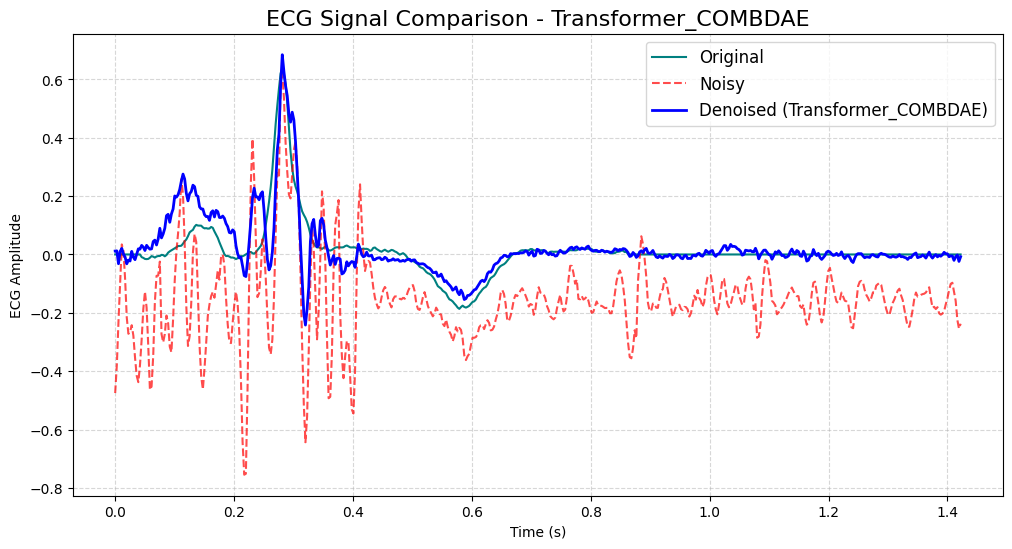

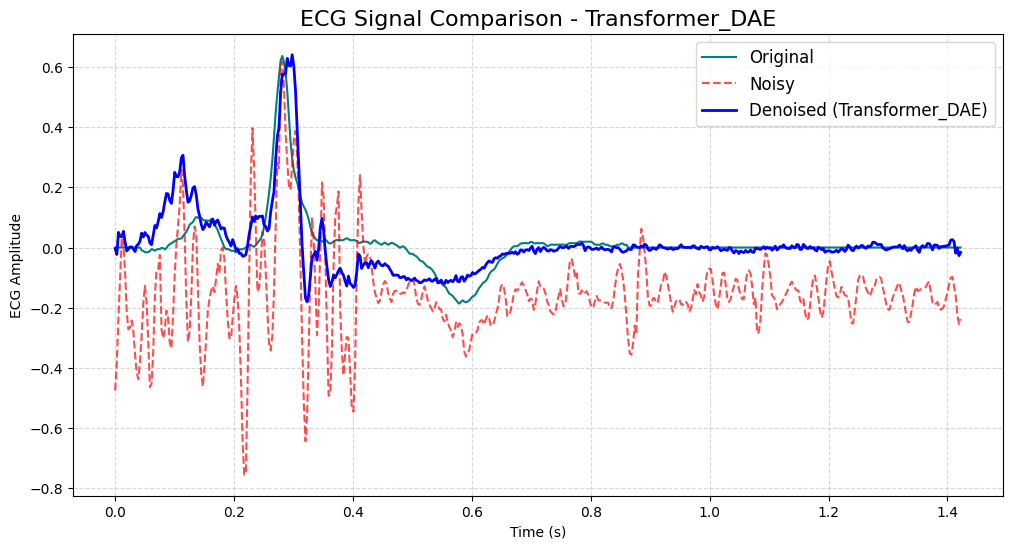

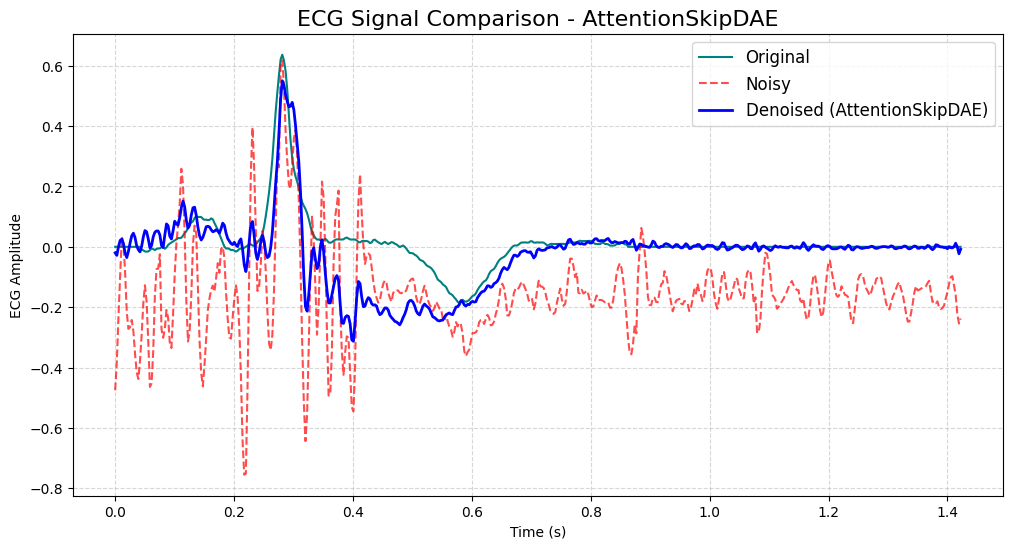

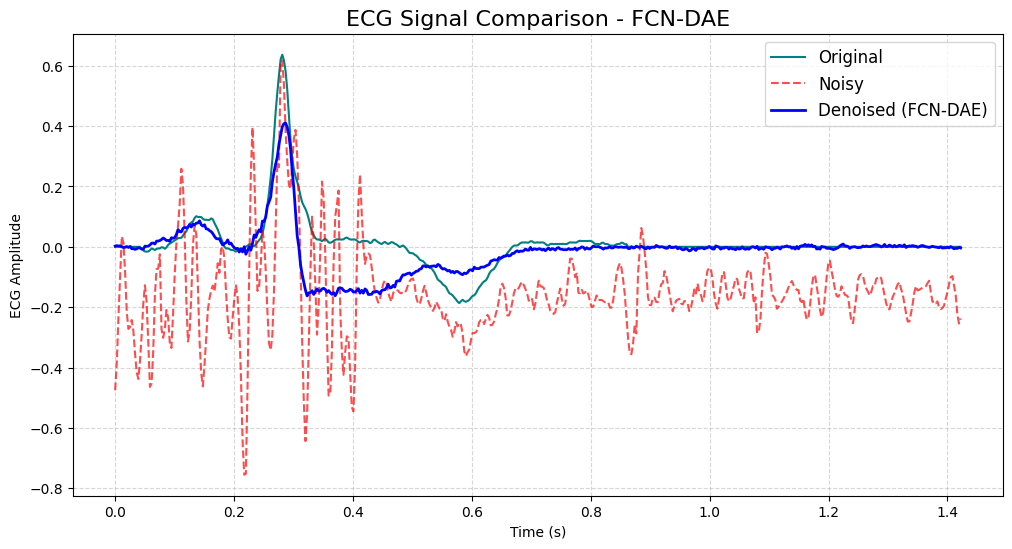

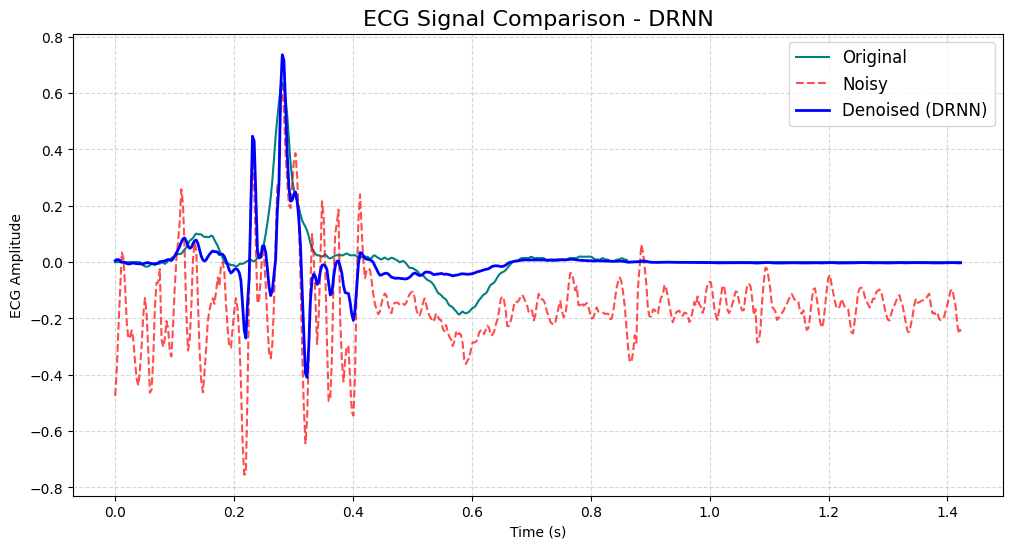

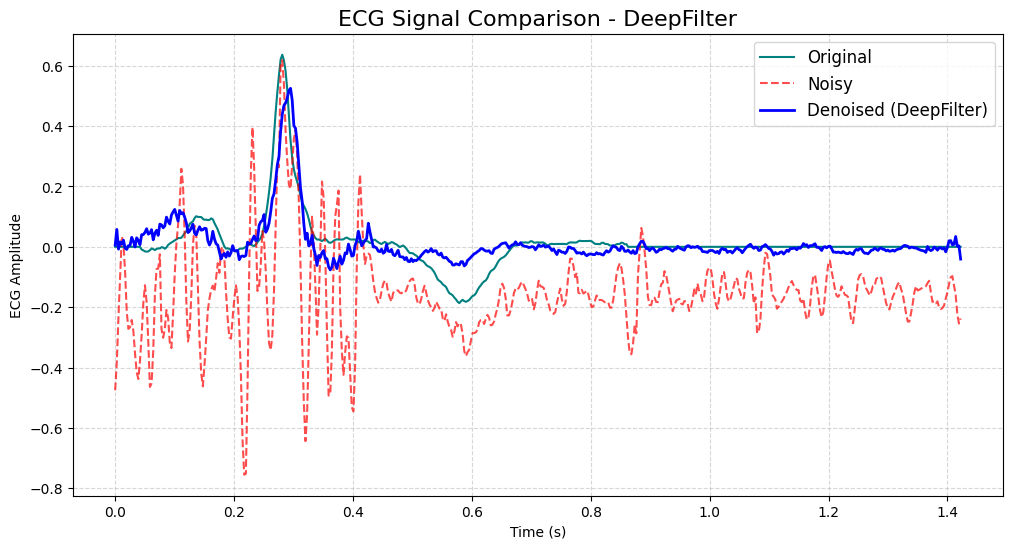

In [80]:
import numpy as np
import matplotlib.pyplot as plt

# 모델 결과 로드
models = {
    "Transformer_COMBDAE": test_Transformer_COMBDAE,
    "Transformer_DAE": test_Transformer_DAE,
    "AttentionSkipDAE": test_AttentionSkipDAE,
    "FCN-DAE": test_FCN_DAE,
    "DRNN": test_DRNN,
    "DeepFilter": test_DeepFilter
}

def plot_segment_comparison(y_test, y_noisy, y_pred, model_name):
    """
    특정 샘플에 대해 원본, 노이즈 포함, 복원된 신호를 비교하는 플롯을 생성.
    
    Parameters:
    - y_test: 원본 신호 (shape: samples, 512, 1)
    - y_noisy: 노이즈가 포함된 신호 (shape: samples, 512, 1)
    - y_pred: 복원된 신호 (모델 출력, shape: samples, 512, 1)
    - model_name: 모델 이름
    """
    # 차원 축소 (마지막 차원 제거)
    y_test = y_test.squeeze(axis=-1)  # (samples, 512)
    y_noisy = y_noisy.squeeze(axis=-1)
    y_pred = y_pred.squeeze(axis=-1)

    # 특정 샘플 선택 (예: 첫 번째 샘플)
    y_test = y_test[100]  # (512,)
    y_noisy = y_noisy[100]  # (512,)
    y_pred = y_pred[100]  # (512,)

    # 시간 축 생성 (512개의 샘플을 정규화된 시간으로 변환)
    time_axis = np.linspace(0, len(y_test) / 360, len(y_test))  # 샘플링 주파수 360Hz 기준

    plt.figure(figsize=(12, 6))

    # 신호 플로팅
    plt.plot(time_axis, y_test, label="Original", color="teal", linewidth=1.5)
    plt.plot(time_axis, y_noisy, label="Noisy", color="red", linestyle="--", alpha=0.7)
    plt.plot(time_axis, y_pred, label=f"Denoised ({model_name})", color="blue", linewidth=2)

    # 그래프 설정
    plt.title(f"ECG Signal Comparison - {model_name}", fontsize=16)
    plt.xlabel("Time (s)")
    plt.ylabel("ECG Amplitude")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(fontsize=12)
    
    # 저장
    # plt.savefig(f"comparison_plots/{model_name}.png", dpi=300, bbox_inches='tight')
    # plt.close()
    print(f"Saved segment comparison plot for {model_name}")

# 모델별 플롯 생성
for model_name, test_model in models.items():
    y_test, y_pred = test_model[1], test_model[2]
    y_noisy = test_model[0]
    plot_segment_comparison(y_test, y_noisy, y_pred, model_name)


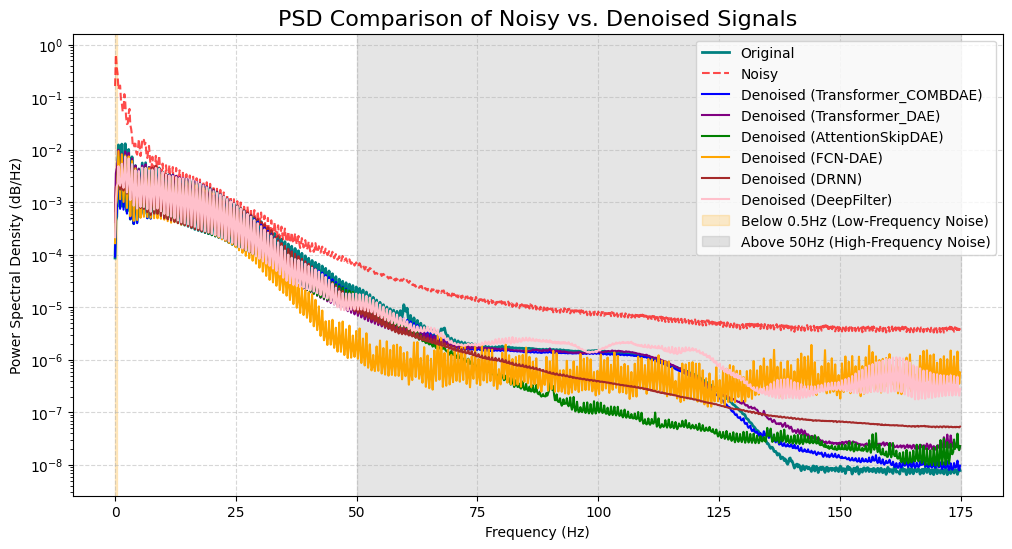

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# 모델 결과 로드
models = {
    "Transformer_COMBDAE": test_Transformer_COMBDAE,
    "Transformer_DAE": test_Transformer_DAE,
    "AttentionSkipDAE": test_AttentionSkipDAE,
    "FCN-DAE": test_FCN_DAE,
    "DRNN": test_DRNN,
    "DeepFilter": test_DeepFilter
}

def compute_psd(signal, fs=360, nperseg=2048):
    """Welch 방법을 사용하여 PSD를 계산"""
    freqs, psd = welch(signal.flatten(), fs=fs, nperseg=nperseg, window='hann')
    return freqs, psd

def plot_psd_comparison(y_test, y_noisy, model_preds, model_names, fs=360, cutoff=175):
    """
    NOISY 신호와 각 모델의 PSD를 비교하는 그래프 생성.
    """
    plt.figure(figsize=(12, 6))

    # 원본 및 NOISY 신호의 PSD 계산
    freqs, psd_original = compute_psd(y_test, fs)
    _, psd_noisy = compute_psd(y_noisy, fs)

    # 주파수 제한 (cutoff)
    mask = freqs <= cutoff
    freqs = freqs[mask]
    psd_original = psd_original[mask]
    psd_noisy = psd_noisy[mask]

    # PSD 플롯
    plt.semilogy(freqs, psd_original, label="Original", color="teal", linewidth=2)
    plt.semilogy(freqs, psd_noisy, label="Noisy", color="red", linestyle="--", alpha=0.7)

    # 모델별 PSD 추가
    colors = ['blue', 'purple', 'green', 'orange', 'brown', 'pink']
    for idx, (model_name, y_pred) in enumerate(zip(model_names, model_preds)):
        _, psd_model = compute_psd(y_pred, fs)
        psd_model = psd_model[mask]
        plt.semilogy(freqs, psd_model, label=f"Denoised ({model_name})", color=colors[idx], linewidth=1.5)

    # 노이즈 영향이 큰 영역 강조 (저주파, 고주파)
    plt.axvspan(0, 0.5, color='orange', alpha=0.2, label="Below 0.5Hz (Low-Frequency Noise)")
    plt.axvspan(50, cutoff, color='gray', alpha=0.2, label="Above 50Hz (High-Frequency Noise)")

    # 플롯 스타일 설정
    plt.title("PSD Comparison of Noisy vs. Denoised Signals", fontsize=16)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density (dB/Hz)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=10)

    # 그래프 저장
    plt.savefig("psd_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

# 모델별 PSD 분석 실행
model_preds = []
model_names = []

for model_name, test_model in models.items():
    y_test, y_pred = test_model[1], test_model[2]
    y_noisy = test_model[0]

    model_preds.append(y_pred)
    model_names.append(model_name)

# NOISY와 모든 모델의 PSD 비교 시각화
plot_psd_comparison(y_test[:], y_noisy[:], model_preds, model_names)


# cinc dataset

In [1]:
# # Import necessary libraries
# import numpy as np
# import wfdb
# import _pickle as pickle
# from Data_Preparation.data_preparation import Data_Preparation
# from Data_Preparation.data_preparation_with_fourier import Data_Preparation_with_Fourier
# # Function to preprocess the MIT-BIH Noise Stress Test Database
# def prepare(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
#     """
#     Reads signals from the MIT-BIH Noise Stress Test Database, prints metadata, and saves the data as a pickle file.

#     Args:
#     - NSTDBPath (str): Path to the Noise Stress Test Database.

#     Returns:
#     - None
#     """
#     # Load signals from the database
#     bw_signals, bw_fields = wfdb.rdsamp(NSTDBPath + 'bw')
#     em_signals, em_fields = wfdb.rdsamp(NSTDBPath + 'em')
#     ma_signals, ma_fields = wfdb.rdsamp(NSTDBPath + 'ma')

#     # Display metadata for each signal type
#     print("Band-Widened Noise Fields:")
#     for key, value in bw_fields.items():
#         print(f"{key}: {value}")

#     print("\nElectromyographic Noise Fields:")
#     for key, value in em_fields.items():
#         print(f"{key}: {value}")

#     print("\nMotion Artifact Noise Fields:")
#     for key, value in ma_fields.items():
#         print(f"{key}: {value}")

#     # Save data to a pickle file
#     output_file = 'data/NoiseBWL.pkl'
#     with open(output_file, 'wb') as output:
#         pickle.dump([bw_signals, em_signals, ma_signals], output)

#     print('=========================================================')
#     print(f'Data saved to {output_file}')
# # Set the path to the database and run the preprocessing function
# NSTDBPath = 'data/mit-bih-noise-stress-test-database-1.0.0/'  # Adjust the path as needed
# prepare(NSTDBPath)


In [158]:
# Import necessary libraries
import pickle
import numpy as np
import pandas as pd
import glob
import wfdb
from scipy import signal
from Data_Preparation.data_preparation import Data_Preparation
from Data_Preparation.data_preparation_with_fourier import Data_Preparation_with_Fourier

def resample_signal(x, fs, fs_target):
    t = np.arange(x.shape[0]).astype("float64")
    if fs == fs_target:
        return x, t
    new_length = int(x.shape[0] * fs_target / fs)
    if np.isnan(x).any():
        x = pd.Series(x.reshape((-1,))).interpolate().values
    resampled_x, resampled_t = signal.resample(x, num=new_length, t=t)
    return resampled_x, resampled_t

def load_train_data(my_fs=360):
    signals = []
    for folder_name in [f'A0{i}' for i in range(9)]:
        for sig in glob.glob(f'data/cinc2017/physionet.org/files/challenge-2017/1.0.0/training/{folder_name}/*.hea'):
            # print(f"Loading signal: {sig}")
            my_sig = wfdb.rdsamp(sig[:-4])
            # print(f"Signal shape: {my_sig[0].shape}, fs: {my_sig[1]['fs']}")
            # Signal shape: (5826, 1), fs: 300
            my_sig, _ = resample_signal(my_sig[0], my_sig[1]['fs'], my_fs)
            signals.append(my_sig.reshape((-1,)))
    return signals

def load_test_data(my_fs=360):
    signals = []
    for sig in glob.glob('data/cinc2017/physionet.org/files/challenge-2017/1.0.0/validation/*.hea'):
        my_sig = wfdb.rdsamp(sig[:-4])
        my_sig, _ = resample_signal(my_sig[0], my_sig[1]['fs'], my_fs)
        signals.append(my_sig.reshape((-1,)))
    return signals

def load_noise():
    with open('data/NoiseBWL.pkl', 'rb') as f:
        return pickle.load(f)

def sig_to_parts(sig, part_size=512):
    num_parts = sig.shape[0] // part_size
    return [sig[i * part_size:(i + 1) * part_size] for i in range(num_parts)]

def sigs_to_parts(sigs, part_size=512):
    parts = []
    for sig in sigs:
        parts += sig_to_parts(sig, part_size=part_size)
    return parts


In [32]:
import numpy as np
from scipy.fft import fft
import pickle

def make_fourier(inputs, n, fs):
    """
    Extract frequency domain information and match the shape to time-domain signals.
    """
    T = n / fs
    k = np.arange(n)
    freq = k / T
    freq = freq[range(int(n / 2))]

    signal_list = []
    for i in range(inputs.shape[0]):
        y = inputs[i, :]
        Y = fft(y) / n  # Perform FFT and normalize
        Y = np.abs(Y[range(int(n / 2))])
        # Duplicate to match time-domain size
        Y_full = np.hstack([Y, Y])
        signal_list.append(Y_full)

    return np.asarray(signal_list)

def Data_Preparation_with_Fourier_CINC(samples, fs=360):
    print('Getting the Data ready ...')

    # Load CINC data (beats_train and beats_test)
    beats_train = sigs_to_parts(load_train_data())
    beats_test = sigs_to_parts(load_test_data())
    print(f"[INFO] Loaded CINC data: {len(beats_train)} training beats, {len(beats_test)} testing beats.")

    # Load noise data
    with open('data/CombinedNoise.pkl', 'rb') as input:
        combined_noise = pickle.load(input)
    print(f"[INFO] Loaded CombinedNoise with {len(combined_noise)} channels")

    #####################################
    # Data split and Fourier transform
    #####################################
    sn_train = []
    sn_test = []
    fourier_train_x = []
    fourier_test_x = []
    fourier_train_y = []
    fourier_test_y = []

    print(f"[INFO] Processing CINC data.")
    # Train data processing
    rnd_train = np.random.uniform(0.2, 2.0, size=len(beats_train))
    noise_index = 0
    for i, beat in enumerate(beats_train):
        # Select noise channel and noise sample segment
        channel_idx = i % len(combined_noise)
        noise = combined_noise[channel_idx][:, 0]
        noise_segment = noise[noise_index:noise_index + samples]

        # Scale noise to match beat amplitude
        beat_max_value = np.max(beat) - np.min(beat)
        noise_max_value = np.max(noise_segment) - np.min(noise_segment)
        Ase = noise_max_value / beat_max_value if noise_max_value != 0 else 1
        alpha = rnd_train[i] / Ase
        signal_noise = beat + alpha * noise_segment
        sn_train.append(signal_noise)

        # Fourier transformation
        fourier_transformed_x = make_fourier(signal_noise.reshape(1, -1), samples, fs)
        fourier_train_x.append(fourier_transformed_x[0])  # Append the single batch

        # Fourier transformation for labels
        fourier_transformed_y = make_fourier(beat.reshape(1, -1), samples, fs)
        fourier_train_y.append(fourier_transformed_y[0])  # Append the single batch

        # Update noise index
        noise_index += samples
        if noise_index > (len(noise) - samples):
            noise_index = 0

    # Test data processing
    rnd_test = np.random.uniform(0.2, 2.0, size=len(beats_test))
    np.save('rnd_test_cinc.npy', rnd_test)  # Save rnd_test for later use
    print(f"[INFO] rnd_test shape: {rnd_test.shape}")
    noise_index = 0
    for i, beat in enumerate(beats_test):
        # Select noise channel and noise sample segment
        channel_idx = i % len(combined_noise)
        noise = combined_noise[channel_idx][:, 0]
        noise_segment = noise[noise_index:noise_index + samples]

        # Scale noise to match beat amplitude
        beat_max_value = np.max(beat) - np.min(beat)
        noise_max_value = np.max(noise_segment) - np.min(noise_segment)
        Ase = noise_max_value / beat_max_value if noise_max_value != 0 else 1
        alpha = rnd_test[i] / Ase
        signal_noise = beat + alpha * noise_segment
        sn_test.append(signal_noise)

        # Fourier transformation
        fourier_transformed_x = make_fourier(signal_noise.reshape(1, -1), samples, fs)
        fourier_test_x.append(fourier_transformed_x[0])  # Append the single batch

        # Fourier transformation for labels
        fourier_transformed_y = make_fourier(beat.reshape(1, -1), samples, fs)
        fourier_test_y.append(fourier_transformed_y[0])  # Append the single batch

        # Update noise index
        noise_index += samples
        if noise_index > (len(noise) - samples):
            noise_index = 0

    #####################################
    # Prepare datasets
    #####################################
    X_train = np.array(sn_train)
    X_test = np.array(sn_test)
    y_train = np.array(beats_train)
    y_test = np.array(beats_test)

    # Fourier datasets
    F_train_x = np.array(fourier_train_x)
    F_test_x = np.array(fourier_test_x)
    F_train_y = np.array(fourier_train_y)
    F_test_y = np.array(fourier_test_y)

    # Expand dimensions to match required shape
    X_train = np.expand_dims(X_train, axis=2)
    y_train = np.expand_dims(y_train, axis=2)
    X_test = np.expand_dims(X_test, axis=2)
    y_test = np.expand_dims(y_test, axis=2)

    F_train_x = np.expand_dims(F_train_x, axis=2)
    F_train_y = np.expand_dims(F_train_y, axis=2)
    F_test_x = np.expand_dims(F_test_x, axis=2)
    F_test_y = np.expand_dims(F_test_y, axis=2)

    Dataset = [X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y]

    print(f"[INFO] Final shapes -> X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
    print(f"[INFO] Fourier shapes -> F_train_x: {F_train_x.shape}, F_train_y: {F_train_y.shape}, F_test_x: {F_test_x.shape}, F_test_y: {F_test_y.shape}")
    print('Dataset ready to use.')

    return Dataset

# # Unpack the dataset
# Dataset = Data_Preparation_with_Fourier_CINC(samples=512, fs=360)
# X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y = Dataset

# # Print dataset shapes for confirmation
# print(f"Time domain train shapes: X_train: {X_train.shape}, y_train: {y_train.shape}")
# print(f"Frequency domain train shapes: F_train_x: {F_train_x.shape}, F_train_y: {F_train_y.shape}")
# print(f"Time domain test shapes: X_test: {X_test.shape}, y_test: {y_test.shape}")
# print(f"Frequency domain test shapes: F_test_x: {F_test_x.shape}, F_test_y: {F_test_y.shape}")


In [ ]:
def Data_Preparation_CINC(samples, fs=360):
    print('Getting the Data ready ...')

    # Load CINC data (beats_train and beats_test)
    beats_train = sigs_to_parts(load_train_data())
    beats_test = sigs_to_parts(load_test_data())
    print(f"[INFO] Loaded CINC data: {len(beats_train)} training beats, {len(beats_test)} testing beats.")

    # Load noise data
    with open('data/CombinedNoise.pkl', 'rb') as input:
        combined_noise = pickle.load(input)
    print(f"[INFO] Loaded CombinedNoise with {len(combined_noise)} channels")

    #####################################
    # Data split and Fourier transform
    #####################################
    sn_train = []
    sn_test = []


    print(f"[INFO] Processing CINC data.")
    # Train data processing
    rnd_train = np.random.uniform(0.2, 2.0, size=len(beats_train))
    noise_index = 0
    for i, beat in enumerate(beats_train):
        # Select noise channel and noise sample segment
        channel_idx = i % len(combined_noise)
        noise = combined_noise[channel_idx][:, 0]
        noise_segment = noise[noise_index:noise_index + samples]

        # Scale noise to match beat amplitude
        beat_max_value = np.max(beat) - np.min(beat)
        noise_max_value = np.max(noise_segment) - np.min(noise_segment)
        Ase = noise_max_value / beat_max_value if noise_max_value != 0 else 1
        alpha = rnd_train[i] / Ase
        signal_noise = beat + alpha * noise_segment
        sn_train.append(signal_noise)

        # Update noise index
        noise_index += samples
        if noise_index > (len(noise) - samples):
            noise_index = 0

    # Test data processing
    rnd_test = np.random.uniform(0.2, 2.0, size=len(beats_test))
    np.save('rnd_test_cinc.npy', rnd_test)  # Save rnd_test for later use
    print(f"[INFO] rnd_test shape: {rnd_test.shape}")
    noise_index = 0
    for i, beat in enumerate(beats_test):
        # Select noise channel and noise sample segment
        channel_idx = i % len(combined_noise)
        noise = combined_noise[channel_idx][:, 0]
        noise_segment = noise[noise_index:noise_index + samples]

        # Scale noise to match beat amplitude
        beat_max_value = np.max(beat) - np.min(beat)
        noise_max_value = np.max(noise_segment) - np.min(noise_segment)
        Ase = noise_max_value / beat_max_value if noise_max_value != 0 else 1
        alpha = rnd_test[i] / Ase
        signal_noise = beat + alpha * noise_segment
        sn_test.append(signal_noise)

        # Update noise index
        noise_index += samples
        if noise_index > (len(noise) - samples):
            noise_index = 0

    #####################################
    # Prepare datasets
    #####################################
    X_train = np.array(sn_train)
    X_test = np.array(sn_test)
    y_train = np.array(beats_train)
    y_test = np.array(beats_test)

    # Expand dimensions to match required shape
    X_train = np.expand_dims(X_train, axis=2)
    y_train = np.expand_dims(y_train, axis=2)
    X_test = np.expand_dims(X_test, axis=2)
    y_test = np.expand_dims(y_test, axis=2)

    Dataset = [X_train, y_train, X_test, y_test]

    print(f"[INFO] Final shapes -> X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")

    return Dataset

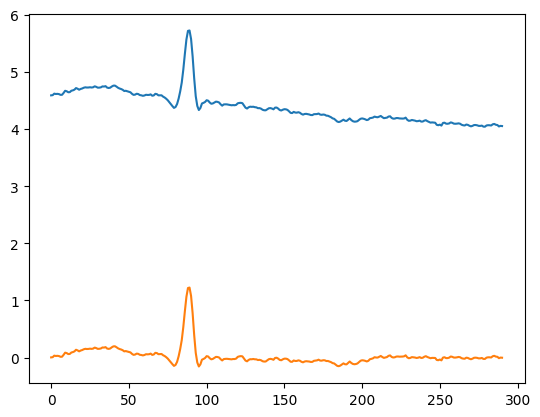

Running FIR fiter on the test set. This will take a while (2h)...
(FIR) Filtering signal 1 of 6727
(FIR) Filtering signal 2 of 6727
(FIR) Filtering signal 3 of 6727
(FIR) Filtering signal 4 of 6727
(FIR) Filtering signal 5 of 6727
(FIR) Filtering signal 6 of 6727
(FIR) Filtering signal 7 of 6727
(FIR) Filtering signal 8 of 6727
(FIR) Filtering signal 9 of 6727
(FIR) Filtering signal 10 of 6727
(FIR) Filtering signal 11 of 6727
(FIR) Filtering signal 12 of 6727
(FIR) Filtering signal 13 of 6727
(FIR) Filtering signal 14 of 6727
(FIR) Filtering signal 15 of 6727
(FIR) Filtering signal 16 of 6727
(FIR) Filtering signal 17 of 6727
(FIR) Filtering signal 18 of 6727
(FIR) Filtering signal 19 of 6727
(FIR) Filtering signal 20 of 6727
(FIR) Filtering signal 21 of 6727
(FIR) Filtering signal 22 of 6727
(FIR) Filtering signal 23 of 6727
(FIR) Filtering signal 24 of 6727
(FIR) Filtering signal 25 of 6727
(FIR) Filtering signal 26 of 6727
(FIR) Filtering signal 27 of 6727
(FIR) Filtering signal 28

<Figure size 640x480 with 0 Axes>

In [21]:
# -*- coding: utf-8 -*-
# ============================================================
#
#  BWL FIR Filtering
#  authors: David Castro Piñol, Francisco Perdigon Romero
#  email: davidpinyol91@gmail.com, fperdigon88@gmail.com
#  github id: Dacapi91, fperdigon
#
# ============================================================

import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import kaiserord, firwin, filtfilt, butter
from datetime import datetime
import _pickle as pickle
from Data_Preparation.data_preparation import Data_Preparation

def FIRRemoveBL(ecgy, Fs, Fc, factor):
    
    #    ecgy:        the contamined signal (must be a list)
    #    Fc:          cut-off frequency
    #    Fs:          sample frequiency
    #    ECG_Clean :  processed signal without BLW
    
    # getting the length of the signal
    signal_len = len(ecgy)
    
    # The Nyquist rate of the signal.
    nyq_rate = Fs / 2.0
    
    # The desired width of the transition from stop to pass,
    # relative to the Nyquist rate. 
    width = 0.07/nyq_rate 
    
    # Attenuation in the stop band, in dB.
    # related to devs in Matlab. On Matlab is on proportion
    ripple_db = round(-20*np.log10(0.001))+1
    ripple_db = ripple_db / factor

    
    # Compute the order and Kaiser parameter for the FIR filter.
    N, beta = kaiserord(ripple_db, width)
       
    # Use firwin with a Kaiser window to create a highpass FIR filter.
    h = firwin(N, Fc/nyq_rate, window=('kaiser', beta), pass_zero='highpass')

    # Check filtfilt condition
    if N*3 > signal_len:
        diff = N*3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + list(ecgy[-1] * np.ones(diff))
        
        # Filtering with filtfilt
        ECG_Clean = filtfilt(h, 1.0, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]
    else:
        ECG_Clean = filtfilt(h, 1.0, ecgy)
    
    return ECG_Clean, N


def FIRRemoveHF(ecgy, Fs, Fc, factor):
    #    ecgy:        the contamined signal (must be a list)
    #    Fc:          cut-off frequency
    #    Fs:          sample frequiency
    #    ECG_Clean :  processed signal without BLW

    # getting the length of the signal
    signal_len = len(ecgy)

    # The Nyquist rate of the signal.
    nyq_rate = Fs / 2.0

    # The desired width of the transition from stop to pass,
    # relative to the Nyquist rate.
    width = 0.07 / nyq_rate

    # Attenuation in the stop band, in dB.
    # related to devs in Matlab. On Matlab is on proportion
    ripple_db = round(-20 * np.log10(0.001)) + 1
    ripple_db = ripple_db / factor

    # Compute the order and Kaiser parameter for the FIR filter.
    N, beta = kaiserord(ripple_db, width)

    # Use firwin with a Kaiser window to create a highpass FIR filter.
    h = firwin(N, Fc / nyq_rate, window=('kaiser', beta), pass_zero='lowpass')

    # Check filtfilt condition
    if N * 3 > signal_len:
        diff = N * 3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + list(ecgy[-1] * np.ones(diff))

        # Filtering with filtfilt
        ECG_Clean = filtfilt(h, 1.0, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]
    else:
        ECG_Clean = filtfilt(h, 1.0, ecgy)

    return ECG_Clean, N

def IIRRemoveBL(ecgy,Fs, Fc):
    
    #    ecgy:        the contamined signal (must be a list)
    #    Fc:          cut-off frequency
    #    Fs:          sample frequiency
    #    ECG_Clean :  processed signal without BLW
    
    # getting the length of the signal
    signal_len = len(ecgy)
    
    # fixed order
    N = 4
    
    # Normalized Cutt of frequency
    Wn = Fc/(Fs/2)    
    
    # IIR butterworth coefficients
    b, a = butter(N, Wn, 'highpass', analog=False)
    
    # Check filtfilt condition
    if N*3 > signal_len:
        diff = N*3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + list(ecgy[-1] * np.ones(diff))
        
        # Filtering with filtfilt
        ECG_Clean = filtfilt(b, a, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]
        
    else:
        ECG_Clean = filtfilt(b, a, ecgy)
                   
    return ECG_Clean


def IIRRemoveHF(ecgy, Fs, Fc):
    #    ecgy:        the contamined signal (must be a list)
    #    Fc:          cut-off frequency
    #    Fs:          sample frequiency
    #    ECG_Clean :  processed signal without BLW

    # getting the length of the signal
    signal_len = len(ecgy)

    # fixed order
    N = 4

    # Normalized Cutt of frequency
    Wn = Fc / (Fs / 2)

    # IIR butterworth coefficients
    b, a = butter(N, Wn, 'lowpass', analog=False)

    # Check filtfilt condition
    if N * 3 > signal_len:
        diff = N * 3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + list(ecgy[-1] * np.ones(diff))

        # Filtering with filtfilt
        ECG_Clean = filtfilt(b, a, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]

    else:
        ECG_Clean = filtfilt(b, a, ecgy)

    return ECG_Clean


def FIR_test_Dataset(Dataset):
    [train_set, train_set_GT, X_test, y_test] = Dataset

    ## parameters
    Fs = 360
    Fc_l = 0.67
    Fc_h = 150.0

    y_filter_out = []

    current_signal = 0

    for signal in X_test:
        current_signal += 1
        print('(FIR) Filtering signal ' + str(current_signal) + ' of ' + str(len(X_test)))
        s = np.squeeze(signal, axis=1).tolist()

        temp_signal, N = FIRRemoveBL(s, Fs, Fc_l, 4.5)
        temp_signal, N = FIRRemoveHF(temp_signal, Fs, Fc_h, 4.5)

        y_filter_out.append(temp_signal)

    y_filter_out = np.expand_dims(np.array(y_filter_out), axis=2)

    return [X_test, y_test, y_filter_out]


def IIR_test_Dataset(Dataset):
    [train_set, train_set_GT, X_test, y_test] = Dataset

    ## parameters
    Fs = 360
    Fc_l = 0.67
    Fc_h = 150.0

    y_filter_out = []

    current_signal = 0

    for signal in X_test:
        current_signal += 1
        print('(IIR) Filtering signal ' + str(current_signal) + ' of ' + str(len(X_test)))
        s = np.squeeze(signal, axis=1).tolist()

        temp_signal = IIRRemoveBL(s, Fs, Fc_l)
        temp_signal = IIRRemoveHF(temp_signal, Fs, Fc_h)

        y_filter_out.append(temp_signal)

    y_filter_out = np.expand_dims(np.array(y_filter_out), axis=2)

    return [X_test, y_test, y_filter_out]


if __name__ == "__main__":
    # signal for demonstration.
    ecgy = sio.loadmat('digitalFilters/ecgbeat.mat')
    signal = ecgy['ecgy']
    signal = list(signal[:,0])
    ## parameters
    Fs = 360
    Fc = 0.67
    factor = 2

    #ECG_Clean,N = FIRRemoveBL(signal,Fs,Fc,factor)

    ECG_Clean = IIRRemoveBL(signal,Fs, Fc)
    with open('./data/dataset_cinc.pkl', 'rb') as input:
        Dataset = pickle.load(input)
    X_train, y_train, X_test, y_test = Dataset
    plt.figure()
    plt.plot(signal[0:len(ecgy['ecgy'])])
    plt.plot(ECG_Clean)
    plt.show()
    plt.figure()
# Classical Filters
    train_time_list = []
    test_time_list = []
    # FIR
    print('Running FIR fiter on the test set. This will take a while (2h)...')
    start_test = datetime.now()
    [X_test_f, y_test_f, y_filter] = FIR_test_Dataset(Dataset)
    end_test = datetime.now()
    train_time_list.append(0)
    test_time_list.append(end_test - start_test)

    test_results_FIR = [X_test_f, y_test_f, y_filter]

    # Save FIR filter results
    with open('cinc_test_results_FIR.pkl', 'wb') as output:  # Overwrites any existing file.
        pickle.dump(test_results_FIR, output)
    print('Results from experiment FIR filter saved')

    # IIR
    print('Running IIR fiter on the test set. This will take a while (25 mins)...')
    start_test = datetime.now()
    [X_test_f, y_test_f, y_filter] = IIR_test_Dataset(Dataset)
    end_test = datetime.now()
    train_time_list.append(0)
    test_time_list.append(end_test - start_test)

    test_results_IIR = [X_test_f, y_test_f, y_filter]

    # Save IIR filter results
    with open('cinc_test_results_IIR.pkl', 'wb') as output:  # Overwrites any existing file.
        pickle.dump(test_results_IIR, output)
    print('Results from experiment IIR filter saved')

    # Saving timing list
    timing = [train_time_list, test_time_list]
    with open('cinc_timing.pkl', 'wb') as output:  # Overwrites any existing file.
        pickle.dump(timing, output)
    print('Timing saved')

In [ ]:
from deepFilter.dl_pipeline import train_dl, test_dl

dl_experiments = ['Transformer_COMBDAE']
train_time_list = []
test_time_list = []
    
    # Get the current date in 'MMDD' format
current_date = datetime.now().strftime('%m%d')
for experiment in dl_experiments:
    # 데이터 준비 단계
    if experiment in ['Transformer_COMBDAE']:
        Dataset = Data_Preparation_with_Fourier_CINC(samples=512, fs=360)
        X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y = Dataset         
    else:
        Dataset = Data_Preparation_CINC(samples=512)
        X_train, y_train, X_test, y_test = Dataset
    
    # 훈련 시간 측정 및 모델 훈련
    start_train = datetime.now()
    train_dl(Dataset, experiment)
    end_train = datetime.now()
    train_time_list.append(end_train - start_train)
    # 테스트 시간 측정 및 모델 테스트
    start_test = datetime.now()
    [X_test, y_test, y_pred] = test_dl(Dataset, experiment)
    end_test = datetime.now()
    test_time_list.append(end_test - start_test)
    # 시각화 및 결과 저장
    save_dir = current_date 
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    test_results = [X_test, y_test, y_pred]
    with open(os.path.join(save_dir, 'cinc_' + 'test_results_' + experiment + '.pkl'), 'wb') as output:
        pickle.dump(test_results, output)
    print('Results from experiment ' + experiment + ' saved')

In [33]:
import wfdb
import _pickle as pickle
from datetime import datetime
import numpy as np

dl_experiments = ['DRNN','FCN-DAE', 'DeepFilter','AttentionSkipDAE','Transformer_DAE','Transformer_COMBDAE']
    # dl_experiments = ['Transformer_DAE','AttentionSkipDAE']

In [35]:
with open('0123/cinc_test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)
# Load Results FCN_DAE
with open('0123/cinc_test_results_'  + dl_experiments[1] + '.pkl', 'rb') as input:
    test_FCN_DAE = pickle.load(input)
# Load Results DeepFilter
with open('0123/cinc_test_results_'  + dl_experiments[2] + '.pkl', 'rb') as input:
    test_DeepFilter = pickle.load(input)
# Load Results AttentionSkipDAE
with open('0123/cinc_test_results_'  + dl_experiments[3] + '.pkl', 'rb') as input:
    test_AttentionSkipDAE = pickle.load(input)
# Load Results Transformer_DAE
with open('0123/cinc_test_results_'  + dl_experiments[4] + '.pkl', 'rb') as input:
    test_Transformer_DAE = pickle.load(input)
# Load Results Transformer_FDAE
with open('0123/cinc_test_results_'  + dl_experiments[5] + '.pkl', 'rb') as input:
    test_Transformer_COMBDAE = pickle.load(input)
            
# Load Result FIR Filter
with open('0123/cinc_test_results_FIR.pkl', 'rb') as input:
    test_FIR = pickle.load(input)
# Load Result IIR Filter
with open('0123/cinc_test_results_IIR.pkl', 'rb') as input:
    test_IIR = pickle.load(input)
####### Calculate Metrics #######
print('Calculating metrics ...')
# DL Metrics
# Exp FCN-DAE
[X_test, y_test, y_pred] = test_DRNN
SSD_values_DL_DRNN = SSD(y_test, y_pred)
MAD_values_DL_DRNN = MAD(y_test, y_pred)
PRD_values_DL_DRNN = PRD(y_test, y_pred)
COS_SIM_values_DL_DRNN = COS_SIM(y_test, y_pred)
SNR_values_DL_DRNN = SNR(y_test, y_pred)

# Exp FCN-DAE
[X_test, y_test, y_pred] = test_FCN_DAE
SSD_values_DL_FCN_DAE = SSD(y_test, y_pred)
MAD_values_DL_FCN_DAE = MAD(y_test, y_pred)
PRD_values_DL_FCN_DAE = PRD(y_test, y_pred)
COS_SIM_values_DL_FCN_DAE = COS_SIM(y_test, y_pred)
SNR_values_DL_FCN_DAE = SNR(y_test, y_pred)

# DeepFilter
[X_test, y_test, y_pred] = test_DeepFilter
SSD_values_DL_exp_1 = SSD(y_test, y_pred)
MAD_values_DL_exp_1 = MAD(y_test, y_pred)
PRD_values_DL_exp_1 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_1 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_1 = SNR(y_test, y_pred)

# AttentionSkipDAE
[X_test, y_test, y_pred] = test_AttentionSkipDAE
SSD_values_DL_exp_2 = SSD(y_test, y_pred)
MAD_values_DL_exp_2 = MAD(y_test, y_pred)
PRD_values_DL_exp_2 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_2 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_2 = SNR(y_test, y_pred)

# Transformer_DAE
[X_test, y_test, y_pred] = test_Transformer_DAE
SSD_values_DL_exp_3 = SSD(y_test, y_pred)
MAD_values_DL_exp_3 = MAD(y_test, y_pred)
PRD_values_DL_exp_3 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_3 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_3 = SNR(y_test, y_pred)

# Transformer_COMBDAE
[X_test, y_test, y_pred] = test_Transformer_COMBDAE
SSD_values_DL_exp_4 = SSD(y_test, y_pred)
MAD_values_DL_exp_4 = MAD(y_test, y_pred)
PRD_values_DL_exp_4 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_4 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_4 = SNR(y_test, y_pred)

# Digital Filtering
# FIR Filtering Metrics
[X_test, y_test, y_filter] = test_FIR
SSD_values_FIR = SSD(y_test, y_filter)
MAD_values_FIR = MAD(y_test, y_filter)
PRD_values_FIR = PRD(y_test, y_filter)
COS_SIM_values_FIR = COS_SIM(y_test, y_filter)
SNR_values_FIR = SNR(y_test, y_filter)

# IIR Filtering Metrics (Best)
[X_test, y_test, y_filter] = test_IIR
SSD_values_IIR = SSD(y_test, y_filter)
MAD_values_IIR = MAD(y_test, y_filter)
PRD_values_IIR = PRD(y_test, y_filter)
COS_SIM_values_IIR = COS_SIM(y_test, y_filter)
SNR_values_IIR = SNR(y_test, y_filter)
####### Results Visualization #######
SSD_all = [SSD_values_FIR,
            SSD_values_IIR,
            SSD_values_DL_FCN_DAE,
            SSD_values_DL_DRNN,
            SSD_values_DL_exp_1,
            SSD_values_DL_exp_2,
            SSD_values_DL_exp_3,
            SSD_values_DL_exp_4]

MAD_all = [MAD_values_FIR,
        MAD_values_IIR,
        MAD_values_DL_FCN_DAE,
        MAD_values_DL_DRNN,
        MAD_values_DL_exp_1,
        MAD_values_DL_exp_2,
        MAD_values_DL_exp_3,
        MAD_values_DL_exp_4
        ]

PRD_all = [PRD_values_FIR,
        PRD_values_IIR,
        PRD_values_DL_FCN_DAE,
        PRD_values_DL_DRNN,
        PRD_values_DL_exp_1,
        PRD_values_DL_exp_2,
        PRD_values_DL_exp_3,
        PRD_values_DL_exp_4
        ]
CORR_all = [COS_SIM_values_FIR,
            COS_SIM_values_IIR,
            COS_SIM_values_DL_FCN_DAE,
            COS_SIM_values_DL_DRNN,
            COS_SIM_values_DL_exp_1,
            COS_SIM_values_DL_exp_2,
            COS_SIM_values_DL_exp_3,
            COS_SIM_values_DL_exp_4
            ]
SNR_all = [SNR_values_FIR,
        SNR_values_IIR,
        SNR_values_DL_FCN_DAE,
        SNR_values_DL_DRNN,
        SNR_values_DL_exp_1,
        SNR_values_DL_exp_2,
        SNR_values_DL_exp_3,
        SNR_values_DL_exp_4]
Exp_names = ['FIR Filter', 'IIR Filter'] + dl_experiments
metrics = ['SSD', 'MAD', 'PRD', 'COS_SIM', 'SNR']
metric_values = [SSD_all, MAD_all, PRD_all, CORR_all, SNR_all]
# Metrics table
generate_table(metrics, metric_values, Exp_names)


Calculating metrics ...


+---------------------+------------------+---------------+------------------+---------------+----------------+
|        Model        |       SSD        |      MAD      |       PRD        |    COS_SIM    |      SNR       |
+---------------------+------------------+---------------+------------------+---------------+----------------+
|      FIR Filter     | 74.853 (246.124) | 0.790 (0.774) | 79.733 (21.437)  | 0.582 (0.224) | -1.515 (4.880) |
|      IIR Filter     | 73.741 (255.441) | 0.798 (0.774) | 81.589 (20.723)  | 0.567 (0.223) | -1.582 (4.641) |
|         DRNN        | 21.663 (84.876)  | 0.466 (0.517) | 86.559 (58.835)  | 0.771 (0.185) | 4.896 (3.199)  |
|       FCN-DAE       | 36.596 (136.291) | 0.716 (0.580) | 225.818 (85.464) | 0.539 (0.208) | 1.247 (1.170)  |
|      DeepFilter     | 21.251 (89.099)  | 0.371 (0.436) | 82.942 (56.655)  | 0.803 (0.154) | 5.436 (3.412)  |
|   AttentionSkipDAE  | 16.557 (72.080)  | 0.329 (0.418) | 62.464 (39.630)  | 0.848 (0

In [20]:
# Generate LaTeX tables for each metric
import os
import pickle
import numpy as np

# Noise levels for testing
segm = [0.2, 0.6, 1.0, 1.5, 2.0]  # Define noise intervals

# Ensure directory for saving tables
def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Function to calculate metrics
def calculate_metrics(y_original, y_filtered):
    """
    Calculate evaluation metrics for the filtered signal compared to the original signal.

    Parameters:
        y_original (ndarray): Original signal.
        y_filtered (ndarray): Filtered signal.

    Returns:
        dict: Dictionary containing SSD, MAD, PRD, COS_SIM, and SNR metrics.
    """
    # Flatten the signals to ensure 1D for metric calculations
    y_original = y_original.flatten()
    y_filtered = y_filtered.flatten()
    noise = y_original - y_filtered

    # SSD
    ssd = np.sum((y_original - y_filtered) ** 2)

    # MAD (using deviation from mean)
    # mu_filtered = np.mean(y_filtered)np.max(np.abs(y - y_pred), axis=1)
    mad = np.max(np.abs(y_original - y_filtered))

    # PRD
    prd = np.sqrt(np.sum((y_original - y_filtered) ** 2) / np.sum(y_original ** 2)) * 100

    # Cosine Similarity
    cosine_sim = np.dot(y_original, y_filtered) / (
        np.sqrt(np.sum(y_original ** 2)) * np.sqrt(np.sum(y_filtered ** 2))
    )

    # SNR (Signal-to-Noise Ratio)
    signal_power = np.sum(y_original ** 2)
    noise_power = np.sum(noise ** 2)
    snr = 10 * np.log10(signal_power / noise_power)

    return {"SSD": ssd, "MAD": mad, "PRD": prd, "COS_SIM": cosine_sim, "SNR": snr}


# Load results for each model
dl_experiments = ['DRNN', 'FCN-DAE', 'DeepFilter', 'AttentionSkipDAE', 'Transformer_DAE', 'Transformer_COMBDAE']
model_results = {}
# Load FIR and IIR results
with open('0123/cinc_test_results_FIR.pkl', 'rb') as input:
    model_results["FIR_Filter"] = pickle.load(input)

with open('0123/cinc_test_results_IIR.pkl', 'rb') as input:
    model_results["IIR_Filter"] = pickle.load(input)

for model_name in dl_experiments:
    file_path = f"0123/cinc_test_results_{model_name}.pkl"
    with open(file_path, 'rb') as input_file:
        model_results[model_name] = pickle.load(input_file)


# Load noise levels
rnd_test = np.load("rnd_test_cinc.npy")

# Initialize result storage
final_metrics = {metric: {model: [] for model in model_results.keys()} for metric in ["SSD", "MAD", "PRD", "COS_SIM", "SNR"]}

# Process each model
for model_name, (X_test, y_test, y_pred) in model_results.items():
    print(f"Processing results for model by cinc: {model_name}")
    
    # Loop through each noise level range
    for i in range(len(segm) - 1):
        noise_start, noise_end = segm[i], segm[i + 1]
        noise_indices = np.where((rnd_test >= noise_start) & (rnd_test < noise_end))[0]

        if len(noise_indices) == 0:
            print(f"No data for noise range {noise_start} to {noise_end} for {model_name}. Skipping...")
            for metric in final_metrics.keys():
                final_metrics[metric][model_name].append((0, 0))  # Append dummy values
            continue

        # Metrics storage
        metrics_range = {"SSD": [], "MAD": [], "PRD": [], "COS_SIM": [], "SNR": []}

        # Calculate metrics for all samples in the range
        for idx in noise_indices:
            metrics = calculate_metrics(y_test[idx], y_pred[idx])
            for key, value in metrics.items():
                metrics_range[key].append(value)

        # Summarize metrics (mean and std) and store
        for key in metrics_range.keys():
            final_metrics[key][model_name].append((np.mean(metrics_range[key]), np.std(metrics_range[key])))


output_dir = "results_tables_final_cinc"
ensure_directory(output_dir)

for metric in final_metrics.keys():
    table_content = f"\\begin{{table*}}[h!]\n"
    table_content += "    \\hspace*{-2cm} % 테이블을 더 왼쪽으로 이동\n"
    table_content += f"    \\caption{{{metric} Results for All Models Across Noise Ranges}}\n"
    table_content += "    \\small\n"
    table_content += "    \\setlength{\\tabcolsep}{7pt} % 열 간격 조정\n"
    table_content += "    \\renewcommand{\\arraystretch}{1.2} % 행 높이 조정\n"
    table_content += "    \\resizebox{\\textwidth}{!}{ % 테이블 폭을 페이지 전체에 맞춤\n"
    table_content += "    \\begin{tabular}{lcccc} % 첫 열 왼쪽 정렬, 나머지 중앙 정렬\n"
    table_content += "        \\toprule\n"
    table_content += "        \\textbf{Model} & \\textbf{0.2-0.6} & \\textbf{0.6-1.0} & \\textbf{1.0-1.5} & \\textbf{1.5-2.0} \\\\\n"
    table_content += "        \\midrule\n"

    for model_name, results in final_metrics[metric].items():
        row = f"        {model_name}"
        for mean, std in results:
            if metric == "COS_SIM" or metric == "MAD":
                row += f" & {mean:.3f} $\\pm$ {std:.3f}"  # CosSim 소수점 셋째 자리
            else:
                row += f" & {mean:.2f} $\\pm$ {std:.2f}"  # 다른 Metric은 소수점 둘째 자리
        row += " \\\\\n"
        table_content += row

    table_content += "        \\bottomrule\n"
    table_content += "    \\end{tabular}\n"
    table_content += "    }\n"
    table_content += "\\end{table*}\n"
    
    # Save LaTeX table
    output_file = os.path.join(output_dir, f"{metric}_results.tex")
    with open(output_file, "w") as f:
        f.write(table_content)
    print(f"Saved {metric} table to {output_file}")


Processing results for model by cinc: FIR_Filter
Processing results for model by cinc: IIR_Filter
Processing results for model by cinc: DRNN
Processing results for model by cinc: FCN-DAE
Processing results for model by cinc: DeepFilter
Processing results for model by cinc: AttentionSkipDAE
Processing results for model by cinc: Transformer_DAE
Processing results for model by cinc: Transformer_COMBDAE
Saved SSD table to results_tables_final_cinc/SSD_results.tex
Saved MAD table to results_tables_final_cinc/MAD_results.tex
Saved PRD table to results_tables_final_cinc/PRD_results.tex
Saved COS_SIM table to results_tables_final_cinc/COS_SIM_results.tex
Saved SNR table to results_tables_final_cinc/SNR_results.tex


combdae로 구간별 비교

In [ ]:
print("Noise Indices for each range:")
for i in range(len(segm) - 1):
    noise_start, noise_end = segm[i], segm[i + 1]
    noise_indices = np.where((rnd_test >= noise_start) & (rnd_test < noise_end))[0]
    print(f"Range {noise_start}-{noise_end}: Indices = {noise_indices}")


Noise Indices for each range:
Range 0.2-0.6: Indices = [    0     1     4 ... 13308 13312 13315]
Range 0.6-1.0: Indices = [   11    12    17 ... 13299 13301 13313]
Range 1.0-1.5: Indices = [    2     9    15 ... 13304 13307 13310]
Range 1.5-2.0: Indices = [    3     6     8 ... 13309 13311 13314]


총 105개의 ECG 신호가 저장됨
샘플 신호 목록: ['sele0122', 'sele0107', 'sel16272', 'sele0604', 'sel104']
선택된 신호(sele0122)에서 1412개의 비트(heartbeat) 존재
비트 길이 (최소: 188, 최대: 257, 평균: 229.57)


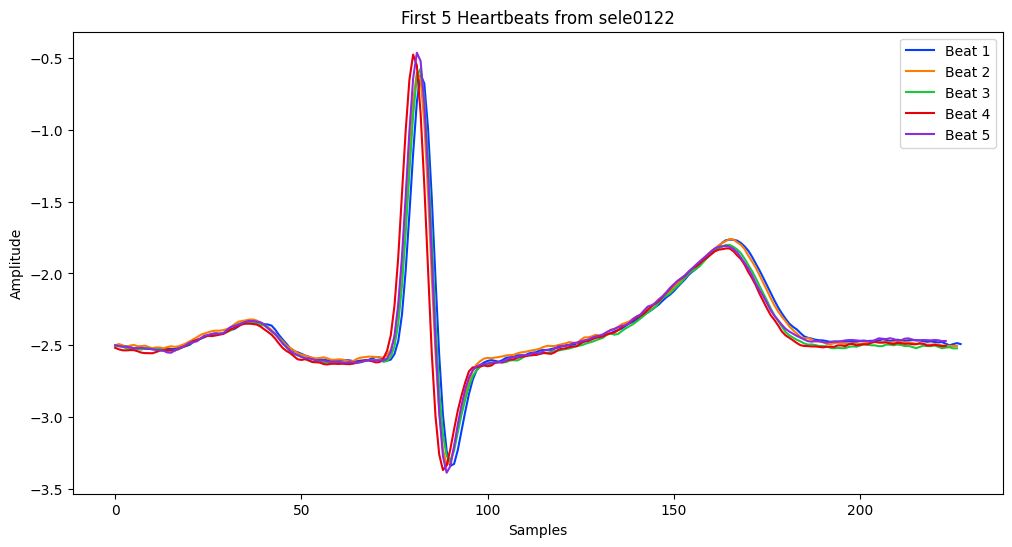

In [166]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# 저장된 pkl 파일 로드
file_path = "/home/dhc99/ecg_denoise/data/QTDatabase.pkl"

with open(file_path, "rb") as file:
    QTDatabase = pickle.load(file)

# 데이터 확인
print(f"총 {len(QTDatabase)}개의 ECG 신호가 저장됨")
print(f"샘플 신호 목록: {list(QTDatabase.keys())[:5]}")  # 처음 5개 신호 이름 출력

# 특정 신호 선택 (첫 번째 신호)
first_key = list(QTDatabase.keys())[0]
beats = QTDatabase[first_key]

print(f"선택된 신호({first_key})에서 {len(beats)}개의 비트(heartbeat) 존재")

# 몇 개의 비트 길이 확인
beat_lengths = [len(b) for b in beats]
print(f"비트 길이 (최소: {min(beat_lengths)}, 최대: {max(beat_lengths)}, 평균: {np.mean(beat_lengths):.2f})")


# 첫 번째 신호의 처음 5개 비트를 시각화
plt.figure(figsize=(12, 6))
for i in range(min(5, len(beats))):
    plt.plot(beats[i], label=f"Beat {i+1}")

plt.title(f"First 5 Heartbeats from {first_key}")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


선택된 신호(sel104)의 전체 샘플 길이: 56136


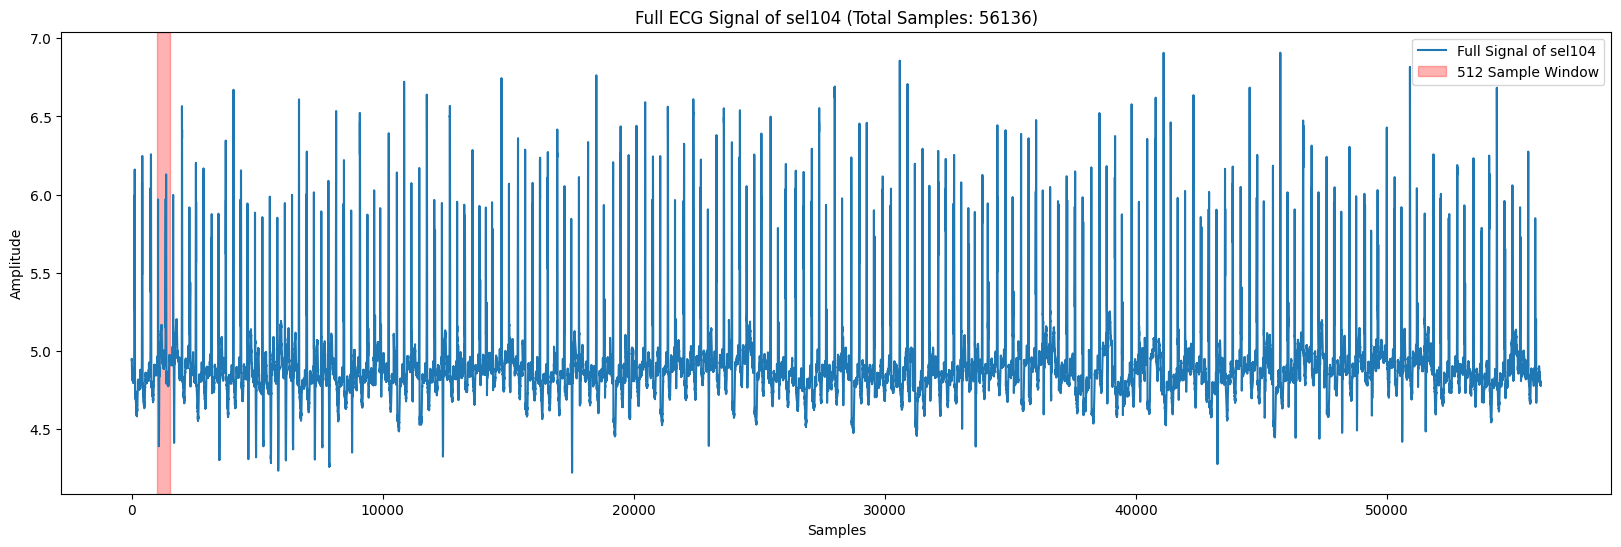

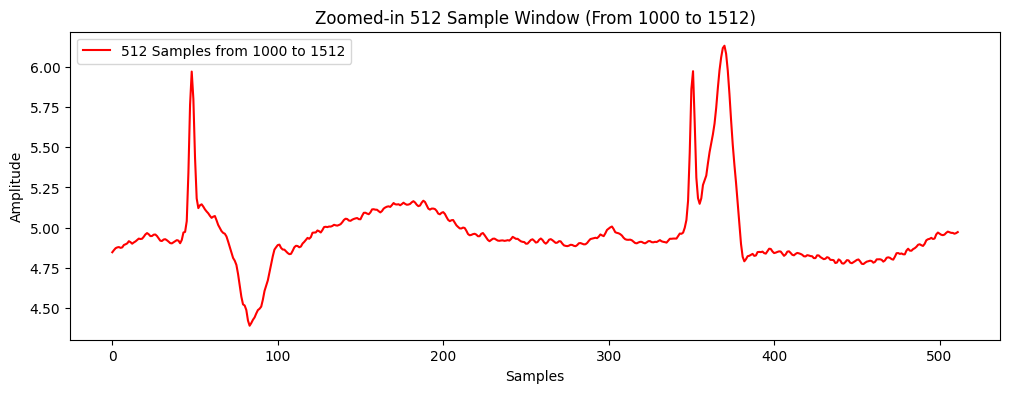

In [24]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# 저장된 pkl 파일 로드
file_path = "/home/dhc99/ecg_denoise/data/QTDatabase.pkl"

with open(file_path, "rb") as file:
    QTDatabase = pickle.load(file)

# sel104 신호 선택
signal_name = "sel104"
if signal_name in QTDatabase:
    beats = QTDatabase[signal_name]
    
    # 전체 샘플 길이 계산
    total_samples = sum(len(beat) for beat in beats)
    print(f"선택된 신호({signal_name})의 전체 샘플 길이: {total_samples}")

    # 모든 비트를 하나의 연속된 신호로 연결
    full_signal = np.concatenate(beats)

    # 전체 신호 시각화
    plt.figure(figsize=(20, 6))
    plt.plot(full_signal, label=f"Full Signal of {signal_name}")
    
    # 512 샘플 구간 선택 (예: 1000부터 1512까지)
    start_sample = 1000  # 시작 샘플 (원하는 위치로 변경 가능)
    end_sample = start_sample + 512  # 512 샘플 길이
    plt.axvspan(start_sample, end_sample, color='red', alpha=0.3, label="512 Sample Window")  # 박스로 표시
    plt.title(f"Full ECG Signal of {signal_name} (Total Samples: {total_samples})")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

    # 512 샘플 구간 확대하여 시각화
    plt.figure(figsize=(12, 4))
    plt.plot(full_signal[start_sample:end_sample], label=f"512 Samples from {start_sample} to {end_sample}", color='red')
    plt.title(f"Zoomed-in 512 Sample Window (From {start_sample} to {end_sample})")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()
else:
    print(f"{signal_name} 신호가 데이터베이스에 존재하지 않습니다.")

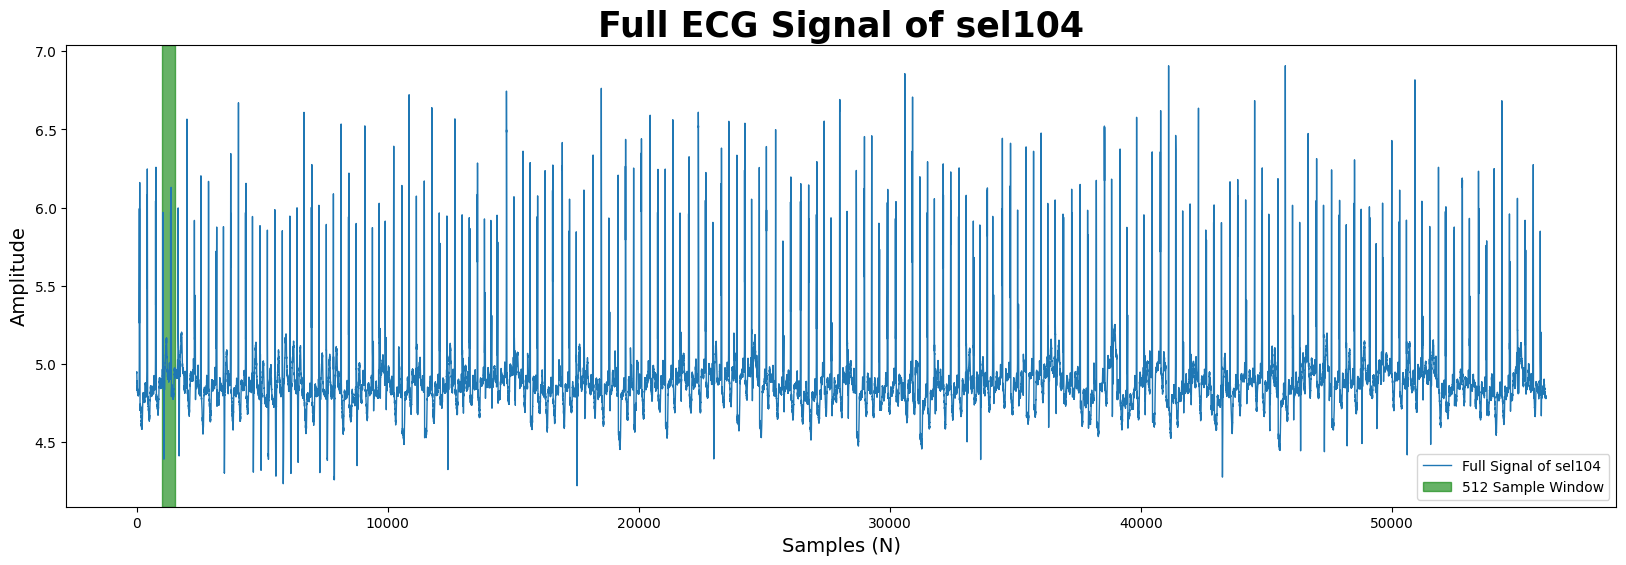

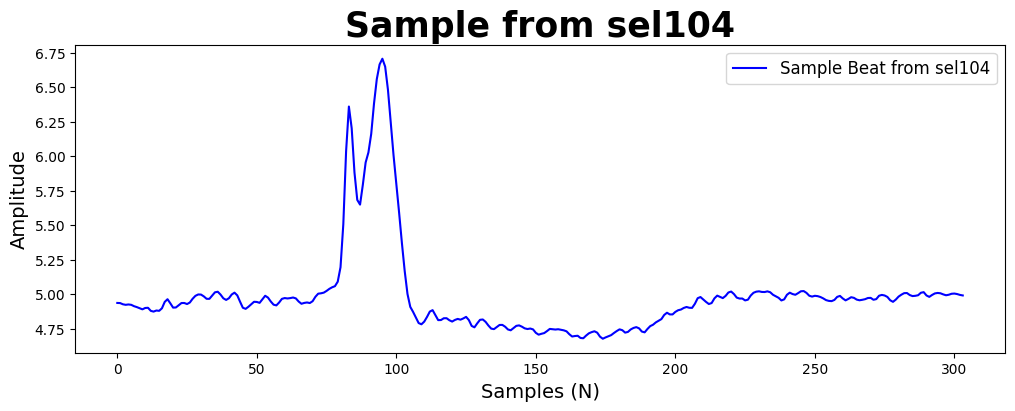

In [40]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# 저장된 pkl 파일 로드 (경로 수정 필요)
file_path = "data/QTDatabase.pkl"  # 파일이 존재하는 올바른 경로로 수정

try:
    with open(file_path, "rb") as file:
        QTDatabase = pickle.load(file)
except FileNotFoundError:
    print(f"파일을 찾을 수 없습니다: {file_path}")
    QTDatabase = None

if QTDatabase:
    # sel104 신호 선택
    signal_name = "sel104"
    if signal_name in QTDatabase:
        beats = QTDatabase[signal_name]

        # 모든 비트를 하나의 연속된 신호로 연결
        full_signal = np.concatenate(beats)
        total_samples = len(full_signal)

        # 특정 샘플 범위 선택 (512 샘플)
        start_sample = 1000  # 시작 샘플
        end_sample = start_sample + 512  # 512 샘플 길이

        # 전체 신호 시각화 (512 샘플 부분 더 진한 분홍색 강조)
        plt.figure(figsize=(20, 6))
        plt.plot(full_signal, label=f"Full Signal of {signal_name}", linewidth=1)
        plt.axvspan(start_sample, end_sample, color='green', alpha=0.6, label="512 Sample Window")
        plt.title(f"Full ECG Signal of {signal_name}", fontsize=25, fontweight='bold')
        plt.xlabel("Samples (N)", fontsize=14)
        plt.ylabel("Amplitude", fontsize=14)
        plt.legend(fontsize=10, loc="lower right")
        plt.show()

        # QTDatabase에서 하나의 비트 샘플 선택
        sample_beat = beats[100]  # 첫 번째 비트 선택

        # 개별 비트 시각화
        plt.figure(figsize=(12, 4))
        plt.plot(sample_beat, color='blue', label=f"Sample Beat from {signal_name}")
        plt.title(f"Sample from {signal_name}", fontsize=25, fontweight='bold')
        plt.xlabel("Samples (N)", fontsize=14)
        plt.ylabel("Amplitude", fontsize=14)
        plt.legend(fontsize=12)
        plt.show()

    else:
        print(f"{signal_name} 신호가 데이터베이스에 존재하지 않습니다.")


# 폐기처리코드

In [ ]:

# # 5-class 시각화 함수
# def plot_5class_samples(mitdb_with_labels, target_class, num_samples=5):
#     """
#     특정 5-class 그룹의 ECG 비트를 시각화합니다.
#     """
#     fig, axs = plt.subplots(num_samples, 1, figsize=(12, 2 * num_samples))
#     fig.suptitle(f"5-Class {target_class} - ECG Beat Samples", fontsize=16)
    
#     sample_count = 0
#     for pid in mitdb_with_labels.keys():
#         for beat, label in mitdb_with_labels[pid]:
#             if group_to_5class(label) == target_class:
#                 axs[sample_count].plot(beat, color='green')
#                 axs[sample_count].set_title(f"Patient {pid} - Sample {sample_count + 1}")
#                 axs[sample_count].set_xlabel("Sample Index")
#                 axs[sample_count].set_ylabel("Amplitude")
#                 sample_count += 1
#                 if sample_count >= num_samples:
#                     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#                     plt.show()
#                     return

# # 5-class 그룹 시각화
# for class_index in range(5):
#     print(f"Visualizing samples for 5-Class {class_index}...")
#     plot_5class_samples(mitdb_with_labels, class_index, num_samples=5)


In [ ]:
# import glob
# import numpy as np
# from scipy.signal import resample_poly
# import wfdb
# import math
# import _pickle as pickle

# def prepare_mitdb(mitpath='/home/dhc99/ecg_denoise/data/physionet.org/files/mitdb/1.0.0/'):
#     """
#     MIT-BIH Database 전처리 및 300 길이의 비트 생성.
#     """
#     # Desired sampling frequency
#     newFs = 360

#     # Preprocessing signals
#     patient_ids = pd.read_csv(mitpath + 'RECORDS', header=None).squeeze("columns").to_numpy()
    
#     # final list that will contain all signals and beats processed
#     MITDatabaseSignals = dict()

#     for pid in patient_ids:
#         signal, fields = wfdb.rdsamp(mitpath + str(pid))
#         ann = wfdb.rdann(mitpath + str(pid), 'atr')
#         annSamples = ann.sample

#         # Extract first channel and split into 300-length beats
#         auxSig = signal[:, 0]
#         beats = [auxSig[max(0, annSamples[i] - 99): min(len(auxSig), annSamples[i] + 201)] for i in range(1, len(annSamples) - 1)]

#         # Padding and resampling each beat to 360 Hz with length 300
#         processed_beats = []
#         for b in beats:
#             if len(b) > 300:  # Skip too long beats
#                 continue
#             b_padded = np.zeros(300)
#             b_padded[:len(b)] = b - (b[0] + b[-1]) / 2  # Centering
#             processed_beats.append(b_padded)

#         # Store processed beats for the patient
#         MITDatabaseSignals[pid] = processed_beats

#     # Save MIT Database as pickle
#     with open('data/MITDatabase.pkl', 'wb') as output:
#         pickle.dump(MITDatabaseSignals, output)
#     print('=========================================================')
#     print('MIT-BIH database saved as pickle file')

# prepare_mitdb()

[INFO] Loaded MITDatabase with 48 signals
112551


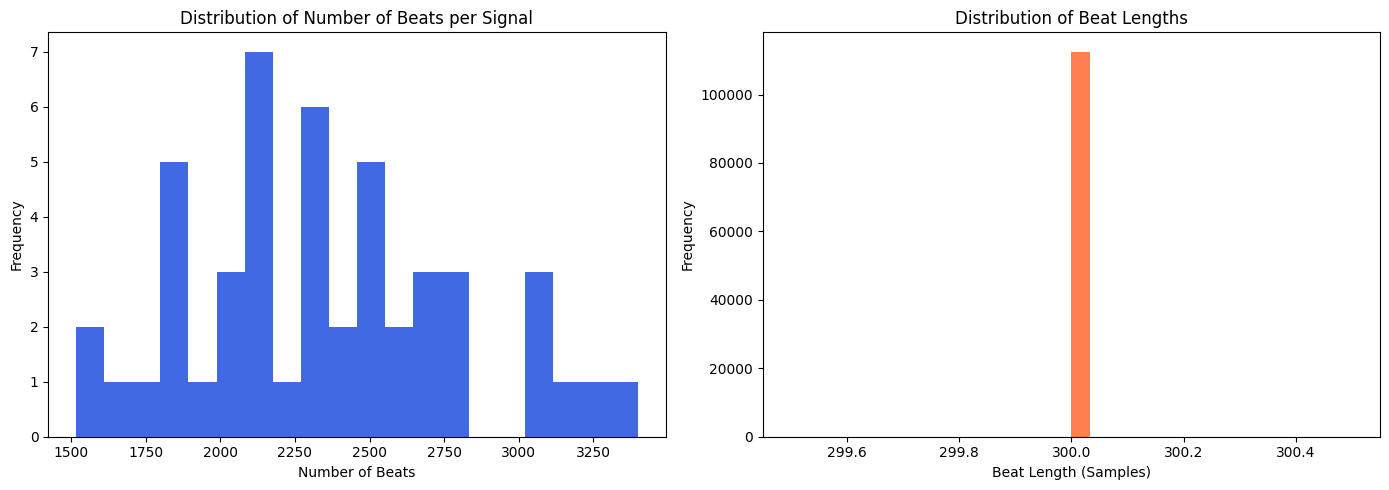

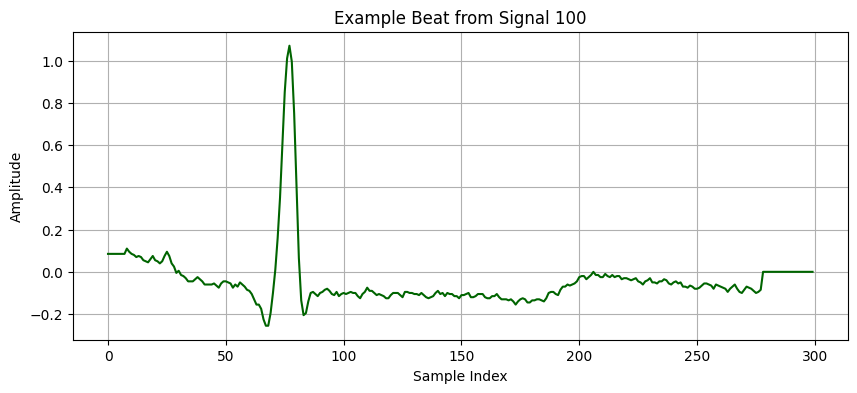

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load MIT Database
with open('data/MITDatabase.pkl', 'rb') as input:
    mitdb = pickle.load(input)

# Print basic info
print(f"[INFO] Loaded MITDatabase with {len(mitdb.keys())} signals")

# Visualize the shape of beats for each signal
signal_lengths = [len(beats) for beats in mitdb.values()]
beat_lengths = [len(beat) for beats in mitdb.values() for beat in beats]
print(len(beat_lengths))
# Plot the distribution of signal and beat lengths
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.hist(signal_lengths, bins=20, color='royalblue')
plt.title('Distribution of Number of Beats per Signal')
plt.xlabel('Number of Beats')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(beat_lengths, bins=30, color='coral')
plt.title('Distribution of Beat Lengths')
plt.xlabel('Beat Length (Samples)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Visualize one sample beat from the first signal in mitdb
first_signal = list(mitdb.keys())[0]
sample_beat = mitdb[first_signal][0]

plt.figure(figsize=(10, 4))
plt.plot(sample_beat, color='darkgreen')
plt.title(f'Example Beat from Signal {first_signal}')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


In [ ]:
# import numpy as np
# from scipy.fft import fft
# from scipy.signal import resample_poly
# import wfdb
# import math
# import _pickle as pickle

# def make_fourier(inputs, n, fs):
#     """
#     주파수 도메인 정보 추출 및 time-domain과 같은 shape으로 만듦.
#     """
#     T = n / fs
#     k = np.arange(n)
#     freq = k / T
#     freq = freq[range(int(n / 2))]

#     signal_list = []
#     for i in range(inputs.shape[0]):
#         y = inputs[i, :]
#         Y = fft(y) / n  # FFT 수행 후 정규화
#         Y = np.abs(Y[range(int(n / 2))])
#         Y_full = np.hstack([Y, Y])  # Duplicate to match time-domain size (512)
#         signal_list.append(Y_full)

#     return np.asarray(signal_list)

# def Data_Preparation_with_Fourier_mitdb(samples=512, fs=360):
#     """
#     MITDB 데이터셋을 준비하고 Fourier 변환된 주파수 도메인 정보와 함께 반환합니다.
#     """
#     print('Preparing the MITDB dataset...')

#     # Set random seed for reproducibility
#     seed = 1234
#     np.random.seed(seed=seed)

#     # Load MIT Database
#     with open('data/MITDatabase.pkl', 'rb') as input:
#         mitdb = pickle.load(input)
#     print(f"[INFO] Loaded MITDatabase with {len(mitdb.keys())} signals")

#     # Load combined noise
#     with open('data/CombinedNoise.pkl', 'rb') as input:
#         combined_noise = pickle.load(input)
#     print(f"[INFO] Loaded CombinedNoise with {len(combined_noise)} channels")

#     beats = []
#     fourier_x = []
#     fourier_y = []
#     valid_indices = []
#     sn = []

#     skip_beats = 0

#     print(f"[INFO] Processing MITDatabase, {len(mitdb.keys())} signals to process.")
#     for signal_name in mitdb.keys():
#         for b_idx, b in enumerate(mitdb[signal_name]):
#             b_np = np.zeros(samples)
#             b_sq = np.array(b)

#             init_padding = 16
#             if b_sq.shape[0] > (samples - init_padding):
#                 skip_beats += 1
#                 continue

#             b_np[init_padding:b_sq.shape[0] + init_padding] = b_sq - (b_sq[0] + b_sq[-1]) / 2

#             # Fourier 변환 적용 (주파수 도메인 정보, time-domain과 동일한 shape으로)
#             fourier_transformed_y = make_fourier(b_np.reshape(1, -1), samples, fs)
            
#             beats.append(b_np)
#             fourier_y.append(fourier_transformed_y[0])
#             valid_indices.append(len(beats) - 1)

#     #####################################
#     # Data split (80% train, 20% test)
#     #####################################
#     total_beats = len(beats)
#     split_idx = int(total_beats * 0.8)

#     beats_train = beats[:split_idx]
#     beats_test = beats[split_idx:]

#     fourier_train_y = fourier_y[:split_idx]
#     fourier_test_y = fourier_y[split_idx:]

#     #####################################
#     # Adding noise to train and test sets
#     #####################################
#     print(f"[INFO] Adding noise to train and test sets")
#     sn_train = []
#     sn_test = []
#     fourier_train_x = []
#     fourier_test_x = []

#     # Random scaling factor for train and test
#     rnd_train = np.random.randint(low=20, high=200, size=len(beats_train)) / 100
#     rnd_test = np.random.randint(low=20, high=200, size=len(beats_test)) / 100
#     np.save('rnd_test_mitdb.npy', rnd_test)

#     def add_noise(beats, rnd, combined_noise, samples):
#         sn = []
#         fourier_x = []
#         noise_index = 0
#         for beat_idx, beat in enumerate(beats):
#             selected_channel = beat_idx % 2
#             noise_combination_idx = 0
#             noise = combined_noise[selected_channel][:, noise_combination_idx]
#             noise_segment = noise[noise_index:noise_index + samples]
#             beat_max_value = np.max(beat) - np.min(beat)
#             noise_max_value = np.max(noise_segment) - np.min(noise_segment)
#             Ase = 1 if noise_max_value == 0 else noise_max_value / beat_max_value
#             alpha = rnd[beat_idx] / Ase
#             signal_noise = beat + alpha * noise_segment
#             sn.append(signal_noise)
#             fourier_transformed_x = make_fourier(signal_noise.reshape(1, -1), samples, fs)
#             fourier_x.append(fourier_transformed_x[0])
#             noise_index += samples
#             if noise_index > (len(noise) - samples):
#                 noise_index = 0
#         return sn, fourier_x

#     # Add noise to train and test sets
#     sn_train, fourier_train_x = add_noise(beats_train, rnd_train, combined_noise, samples)
#     sn_test, fourier_test_x = add_noise(beats_test, rnd_test, combined_noise, samples)

#     #####################################
#     # Convert to NumPy arrays and reshape
#     #####################################
#     X_train = np.expand_dims(np.array(sn_train), axis=2)
#     y_train = np.expand_dims(np.array(beats_train), axis=2)
#     X_test = np.expand_dims(np.array(sn_test), axis=2)
#     y_test = np.expand_dims(np.array(beats_test), axis=2)
#     F_train_x = np.expand_dims(np.array(fourier_train_x), axis=2)
#     F_train_y = np.expand_dims(np.array(fourier_train_y), axis=2)
#     F_test_x = np.expand_dims(np.array(fourier_test_x), axis=2)
#     F_test_y = np.expand_dims(np.array(fourier_test_y), axis=2)

#     Dataset = [X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y]

#     print(f"[INFO] Final shapes -> X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
#     print(f"[INFO] Fourier shapes -> F_train_x: {F_train_x.shape}, F_train_y: {F_train_y.shape}, F_test_x: {F_test_x.shape}, F_test_y: {F_test_y.shape}")
#     print('Dataset ready to use.')

#     return Dataset
# def Data_Preparation_with_mitdb(samples=512, fs=360):
#     """
#     MITDB 데이터셋을 준비하고 Fourier 변환된 주파수 도메인 정보와 함께 반환합니다.
#     """
#     print('Preparing the MITDB dataset...')

#     # Set random seed for reproducibility
#     seed = 1234
#     np.random.seed(seed=seed)

#     # Load MIT Database
#     with open('data/MITDatabase.pkl', 'rb') as input:
#         mitdb = pickle.load(input)
#     print(f"[INFO] Loaded MITDatabase with {len(mitdb.keys())} signals")

#     # Load combined noise
#     with open('data/CombinedNoise.pkl', 'rb') as input:
#         combined_noise = pickle.load(input)
#     print(f"[INFO] Loaded CombinedNoise with {len(combined_noise)} channels")

#     beats = []
#     fourier_x = []
#     fourier_y = []
#     valid_indices = []
#     sn = []

#     skip_beats = 0

#     print(f"[INFO] Processing MITDatabase, {len(mitdb.keys())} signals to process.")
#     for signal_name in mitdb.keys():
#         for b_idx, b in enumerate(mitdb[signal_name]):
#             b_np = np.zeros(samples)
#             b_sq = np.array(b)

#             init_padding = 16
#             if b_sq.shape[0] > (samples - init_padding):
#                 skip_beats += 1
#                 continue

#             b_np[init_padding:b_sq.shape[0] + init_padding] = b_sq - (b_sq[0] + b_sq[-1]) / 2

#             # Fourier 변환 적용 (주파수 도메인 정보, time-domain과 동일한 shape으로)
#             fourier_transformed_y = make_fourier(b_np.reshape(1, -1), samples, fs)
            
#             beats.append(b_np)
#             fourier_y.append(fourier_transformed_y[0])
#             valid_indices.append(len(beats) - 1)

#     #####################################
#     # Data split (80% train, 20% test)
#     #####################################
#     total_beats = len(beats)
#     split_idx = int(total_beats * 0.8)

#     beats_train = beats[:split_idx]
#     beats_test = beats[split_idx:]

#     fourier_train_y = fourier_y[:split_idx]
#     fourier_test_y = fourier_y[split_idx:]

#     #####################################
#     # Adding noise to train and test sets
#     #####################################
#     print(f"[INFO] Adding noise to train and test sets")
#     sn_train = []
#     sn_test = []
#     fourier_train_x = []
#     fourier_test_x = []

#     # Random scaling factor for train and test
#     rnd_train = np.random.randint(low=20, high=200, size=len(beats_train)) / 100
#     rnd_test = np.random.randint(low=20, high=200, size=len(beats_test)) / 100
#     np.save('rnd_test_mitdb.npy', rnd_test)

#     def add_noise(beats, rnd, combined_noise, samples):
#         sn = []
#         fourier_x = []
#         noise_index = 0
#         for beat_idx, beat in enumerate(beats):
#             selected_channel = beat_idx % 2
#             noise_combination_idx = 0
#             noise = combined_noise[selected_channel][:, noise_combination_idx]
#             noise_segment = noise[noise_index:noise_index + samples]
#             beat_max_value = np.max(beat) - np.min(beat)
#             noise_max_value = np.max(noise_segment) - np.min(noise_segment)
#             Ase = 1 if noise_max_value == 0 else noise_max_value / beat_max_value
#             alpha = rnd[beat_idx] / Ase
#             signal_noise = beat + alpha * noise_segment
#             sn.append(signal_noise)
#             fourier_transformed_x = make_fourier(signal_noise.reshape(1, -1), samples, fs)
#             fourier_x.append(fourier_transformed_x[0])
#             noise_index += samples
#             if noise_index > (len(noise) - samples):
#                 noise_index = 0
#         return sn, fourier_x

#     # Add noise to train and test sets
#     sn_train, fourier_train_x = add_noise(beats_train, rnd_train, combined_noise, samples)
#     sn_test, fourier_test_x = add_noise(beats_test, rnd_test, combined_noise, samples)

#     #####################################
#     # Convert to NumPy arrays and reshape
#     #####################################
#     X_train = np.expand_dims(np.array(sn_train), axis=2)
#     y_train = np.expand_dims(np.array(beats_train), axis=2)
#     X_test = np.expand_dims(np.array(sn_test), axis=2)
#     y_test = np.expand_dims(np.array(beats_test), axis=2)


#     Dataset = [X_train, y_train, X_test, y_test]

#     print(f"[INFO] Final shapes -> X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
#     print('Dataset ready to use.')

#     return Dataset


In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
# Load rnd_test (noise levels)
rnd_test = np.load("rnd_test.npy")
# Noise levels for testing
segm = [0.2, 0.6, 1.0, 1.5, 2.0]  # Define noise intervals
# Ensure directory for saving images exists
def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
def plot_model_differences_individual(model_results, vis_indices, noise_range, save_dir):
    """
    Plot differences for each model in individual plots.
    """
    for model_name, (X_test, y_test, y_pred) in model_results.items():
        differences = [y_test[idx].flatten() - y_pred[idx].flatten() for idx in vis_indices]
        concatenated_diff = np.concatenate(differences)

        plt.figure(figsize=(14, 6))
        plt.plot(concatenated_diff, label=f'{model_name} Difference', color='blue', linewidth=1.5)

        plt.title(f"Difference Signal: {model_name}\nNoise Range: {noise_range}", fontsize=20, fontweight='bold')
        plt.xlabel("Sample Index", fontsize=14)
        plt.ylabel("Difference Amplitude (a.u.)", fontsize=14)
        plt.legend(loc="upper right", fontsize=12)
        plt.grid(True, linestyle=':', alpha=0.7)
        plt.tight_layout()

        # Save individual plot
        save_path = os.path.join(save_dir, f"{model_name}_Noise_{noise_range.replace('<', '_')}.png")
        plt.savefig(save_path, dpi=300)
        plt.close()
        print(f"Saved individual plot for {model_name}: {save_path}")

# Noise range 처리 및 저장 경로 설정
save_dir_individual = "difference_plots_individual"
ensure_directory(save_dir_individual)

for i in range(len(segm) - 1):
    noise_start, noise_end = segm[i], segm[i + 1]
    noise_indices = np.where((rnd_test >= noise_start) & (rnd_test < noise_end))[0]

    if len(noise_indices) == 0:
        print(f"No data for noise range {noise_start} to {noise_end}. Skipping...")
        continue

    vis_indices = noise_indices[:7]  # 최대 7개 샘플 선택
    noise_range_str = f"{noise_start} < noise < {noise_end}"

    plot_model_differences_individual(
        model_results, vis_indices, noise_range_str, save_dir_individual
    )


Saved individual plot for DRNN: difference_plots_individual/DRNN_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for FCN-DAE: difference_plots_individual/FCN-DAE_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for Multibranch LANLD: difference_plots_individual/Multibranch LANLD_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for AttentionSkipDAE: difference_plots_individual/AttentionSkipDAE_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for Transformer_DAE: difference_plots_individual/Transformer_DAE_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for Transformer_COMBDAE: difference_plots_individual/Transformer_COMBDAE_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for FIR_Filter: difference_plots_individual/FIR_Filter_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for IIR_Filter: difference_plots_individual/IIR_Filter_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for DRNN: difference_plots_individual/DRNN_Noise_0.6 _ noise _ 1.0.png
Saved individual plot for FCN-D

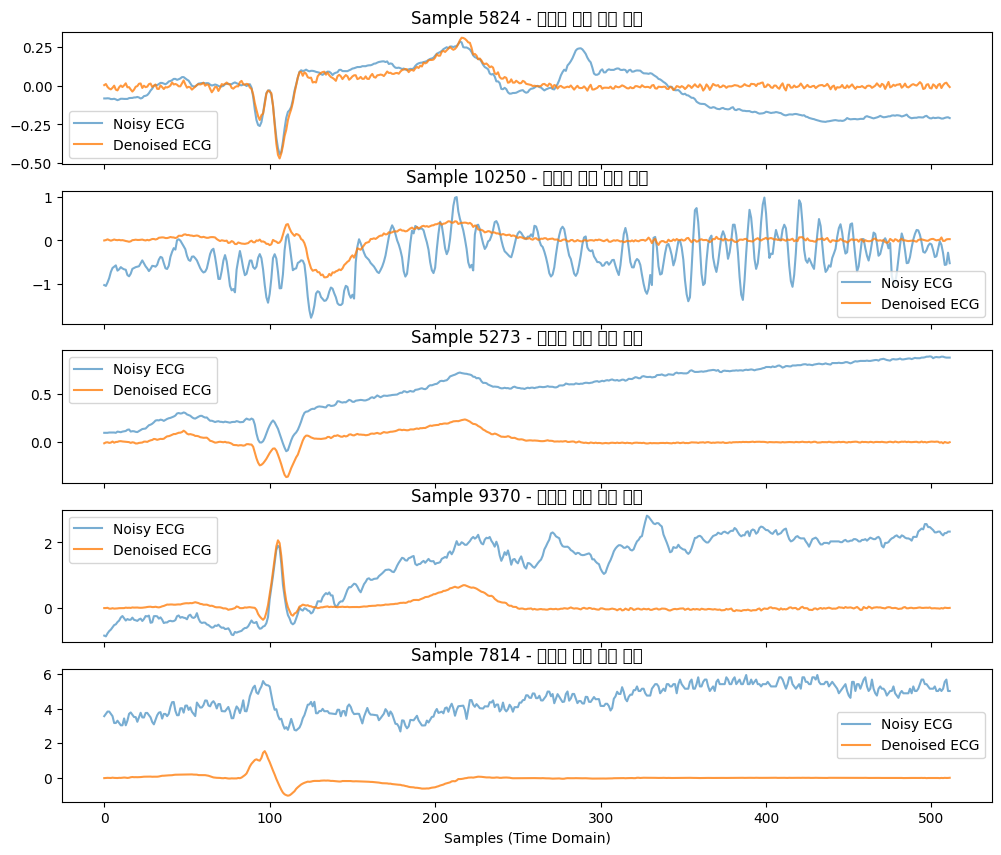

In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.metrics import mean_absolute_error

# === SNR별 폴더 및 모델 정의 === #
snr_folders = ["SNR_0DB", "SNR_6DB", "SNR_12DB"]
dl_model = "Transformer_COMBDAE"  # 사용할 모델

# === 평가 지표 계산 함수 === #
def SSD(y_true, y_pred):
    return np.sum((y_true - y_pred) ** 2)

def PRD(y_true, y_pred):
    return 100 * np.sqrt(np.sum((y_true - y_pred) ** 2) / np.sum(y_true ** 2))

def Cosine_Similarity(y_true, y_pred):
    return 1 - cosine(y_true.flatten(), y_pred.flatten())

# === QTDataset에서 'sel123' 찾기 === #
with open('data/QTDatabase.pkl', 'rb') as input:
    qtdb = pickle.load(input)

sel123_data = qtdb["sel123"]  # 'sel123' 데이터 가져오기
sel123_data = np.array(sel123_data)  # (샘플 개수, 512)

# === 시각화 설정 === #
fig, axes = plt.subplots(len(snr_folders), 1, figsize=(10, 15))

for i, snr_folder in enumerate(snr_folders):
    # === 모델 테스트 데이터 로드 === #
    with open(f"{snr_folder}/test_results_{dl_model}.pkl", "rb") as f:
        X_test, y_test, y_pred = pickle.load(f)

    # 'sel123' 데이터에 해당하는 샘플 찾기
    sel123_indices = [idx for idx in range(len(y_test)) if np.any(np.isin(y_test[idx], sel123_data))]

    # 여러 샘플을 연결하여 긴 신호 생성
    long_X_test = np.concatenate([X_test[j].squeeze() for j in sel123_indices[:10]], axis=0)
    long_y_test = np.concatenate([y_test[j].squeeze() for j in sel123_indices[:10]], axis=0)
    long_y_pred = np.concatenate([y_pred[j].squeeze() for j in sel123_indices[:10]], axis=0)

    # === Reconstruction Metrics 계산 === #
    ssd_value = SSD(long_y_test, long_y_pred)
    mad_value = mean_absolute_error(long_y_test, long_y_pred)
    prd_value = PRD(long_y_test, long_y_pred)
    cos_sim_value = Cosine_Similarity(long_y_test, long_y_pred)

    # === 그래프 그리기 === #
    ax = axes[i]
    ax.plot(long_y_test, label="Original", color="red", linewidth=1)
    ax.plot(long_X_test, label="Noisy", color="blue", linewidth=1, alpha=0.7)
    ax.plot(long_y_pred, label="Reconstruction", color="green", linewidth=1)

    ax.set_xlabel("Samples")
    ax.set_ylabel("Amplitude")
    ax.set_title(f"{snr_folder.replace('_', ' ')} - Noise Condition (sel123)")
    ax.legend()

    # Reconstruction Metrics 추가
    ax.text(0.75, 0.8, f"SSD: {ssd_value:.3f}\nMAD: {mad_value:.3f}\nPRD: {prd_value:.3f}\nCosine Sim: {cos_sim_value:.3f}", 
            transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()


밑의 코드로 latex로 바로 정리 가능능

In [ ]:
# Generate LaTeX tables for each metric
import os
import pickle
import numpy as np

# Noise levels for testing
segm = [0.2, 0.6, 1.0, 1.5, 2.0]  # Define noise intervals

# Ensure directory for saving tables
def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Function to calculate metrics
def calculate_metrics(y_original, y_filtered):
    """
    Calculate evaluation metrics for the filtered signal compared to the original signal.

    Parameters:
        y_original (ndarray): Original signal.
        y_filtered (ndarray): Filtered signal.

    Returns:
        dict: Dictionary containing SSD, MAD, PRD, COS_SIM, and SNR metrics.
    """
    # Flatten the signals to ensure 1D for metric calculations
    y_original = y_original.flatten()
    y_filtered = y_filtered.flatten()
    noise = y_original - y_filtered

    # SSD
    ssd = np.sum((y_original - y_filtered) ** 2)

    # MAD (using deviation from mean)
    # mu_filtered = np.mean(y_filtered)np.max(np.abs(y - y_pred), axis=1)
    mad = np.max(np.abs(y_original - y_filtered))

    # PRD
    prd = np.sqrt(np.sum((y_original - y_filtered) ** 2) / np.sum(y_original ** 2)) * 100

    # Cosine Similarity
    cosine_sim = np.dot(y_original, y_filtered) / (
        np.sqrt(np.sum(y_original ** 2)) * np.sqrt(np.sum(y_filtered ** 2))
    )

    # SNR (Signal-to-Noise Ratio)
    signal_power = np.sum(y_original ** 2)
    noise_power = np.sum(noise ** 2)
    snr = 10 * np.log10(signal_power / noise_power)

    return {"SSD": ssd, "MAD": mad, "PRD": prd, "COS_SIM": cosine_sim, "SNR": snr}


# Load results for each model
dl_experiments = ['DRNN', 'FCN-DAE', 'DeepFilter', 'AttentionSkipDAE', 'Transformer_DAE']
model_results = {}

# Load FIR and IIR results
with open('1220/test_results_FIR.pkl', 'rb') as input:
    model_results["FIR-Filter"] = pickle.load(input)

with open('1220/test_results_IIR.pkl', 'rb') as input:
    model_results["IIR-Filter"] = pickle.load(input)
    
for model_name in dl_experiments:
    file_path = f"0220/test_results_{model_name}.pkl"
    with open(file_path, 'rb') as input_file:
        model_results[model_name] = pickle.load(input_file)
with open('0220/test_results_Transformer_COMBDAE.pkl', 'rb') as input:
    model_results["Transformer-COMBDAE"] = pickle.load(input)


# Load noise levels
rnd_test = np.load("rnd_test.npy")

# Initialize result storage
final_metrics = {metric: {model: [] for model in model_results.keys()} for metric in ["SSD", "MAD", "PRD", "COS_SIM", "SNR"]}

# Process each model
for model_name, (X_test, y_test, y_pred) in model_results.items():
    print(f"Processing results for model: {model_name}")
    
    # Loop through each noise level range
    for i in range(len(segm) - 1):
        noise_start, noise_end = segm[i], segm[i + 1]
        noise_indices = np.where((rnd_test >= noise_start) & (rnd_test < noise_end))[0]

        if len(noise_indices) == 0:
            print(f"No data for noise range {noise_start} to {noise_end} for {model_name}. Skipping...")
            for metric in final_metrics.keys():
                final_metrics[metric][model_name].append((0, 0))  # Append dummy values
            continue

        # Metrics storage
        metrics_range = {"SSD": [], "MAD": [], "PRD": [], "COS_SIM": [], "SNR": []}

        # Calculate metrics for all samples in the range
        for idx in noise_indices:
            metrics = calculate_metrics(y_test[idx], y_pred[idx])
            for key, value in metrics.items():
                metrics_range[key].append(value)

        # Summarize metrics (mean and std) and store
        for key in metrics_range.keys():
            final_metrics[key][model_name].append((np.mean(metrics_range[key]), np.std(metrics_range[key])))


output_dir = "results_tables_final2"
ensure_directory(output_dir)

for metric in final_metrics.keys():
    table_content = f"\\begin{{table*}}[h!]\n"
    table_content += "    \\hspace*{-2cm} % 테이블을 더 왼쪽으로 이동\n"
    table_content += f"    \\caption{{{metric} Results for All Models Across Noise Ranges}}\n"
    table_content += "    \\small\n"
    table_content += "    \\setlength{\\tabcolsep}{7pt} % 열 간격 조정\n"
    table_content += "    \\renewcommand{\\arraystretch}{1.2} % 행 높이 조정\n"
    table_content += "    \\resizebox{\\textwidth}{!}{ % 테이블 폭을 페이지 전체에 맞춤\n"
    table_content += "    \\begin{tabular}{lcccc} % 첫 열 왼쪽 정렬, 나머지 중앙 정렬\n"
    table_content += "        \\toprule\n"
    table_content += "        \\textbf{Model} & \\textbf{0.2-0.6} & \\textbf{0.6-1.0} & \\textbf{1.0-1.5} & \\textbf{1.5-2.0} \\\\\n"
    table_content += "        \\midrule\n"

    for model_name, results in final_metrics[metric].items():
        row = f"        {model_name}"
        for mean, std in results:
            if metric == "COS_SIM" or metric == "MAD":
                row += f" & {mean:.3f} $\\pm$ {std:.3f}"  # CosSim 소수점 셋째 자리
            else:
                row += f" & {mean:.2f} $\\pm$ {std:.2f}"  # 다른 Metric은 소수점 둘째 자리
        row += " \\\\\n"
        table_content += row

    table_content += "        \\bottomrule\n"
    table_content += "    \\end{tabular}\n"
    table_content += "    }\n"
    table_content += "\\end{table*}\n"
    
    # Save LaTeX table
    output_file = os.path.join(output_dir, f"{metric}_results.tex")
    with open(output_file, "w") as f:
        f.write(table_content)
    print(f"Saved {metric} table to {output_file}")


Processing results for model: FIR-Filter
Processing results for model: IIR-Filter
Processing results for model: DRNN
Processing results for model: FCN-DAE
Processing results for model: DeepFilter
Processing results for model: AttentionSkipDAE
Processing results for model: Transformer_DAE
Processing results for model: Transformer-COMBDAE
Saved SSD table to results_tables_final2/SSD_results.tex
Saved MAD table to results_tables_final2/MAD_results.tex
Saved PRD table to results_tables_final2/PRD_results.tex
Saved COS_SIM table to results_tables_final2/COS_SIM_results.tex
Saved SNR table to results_tables_final2/SNR_results.tex


In [ ]:
# import numpy as np
# snr_info = []  # 각 chunk별 SNR 정보를 저장할 리스트
# def apply_random_snr(noise, desired_snr_db):
#     """
#     Adjusts the SNR of a given noise signal to the desired SNR in dB.
    
#     Parameters:
#     noise (np.ndarray): The noise signal to be adjusted.
#     desired_snr_db (float): The target SNR in dB (-6, 0, 6, 12, 18).
    
#     Returns:
#     np.ndarray: Noise signal with the adjusted SNR.
#     """
#     signal_power = np.mean(noise ** 2)
#     desired_snr = 10 ** (desired_snr_db / 10)
#     noise_power = signal_power / desired_snr
#     adjusted_noise = noise * np.sqrt(noise_power / np.mean(noise ** 2))
#     return adjusted_noise
# # Random SNR values (-6, 0, 6, 12, 18dB)
# def prepare_combined_noise_with_snr(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
#     """
#     Prepares combined noise data from the MIT-BIH Noise Stress Test Database (NSTDB)
#     with Baseline Wander (BW) noise always included. Electrode Motion (EM) and 
#     Muscle Artifact (MA) noises are added randomly.
#     Expands the final noise matrix to shape (2, 650000, 1).
    
#     Parameters:
#     NSTDBPath: Path to the NSTDB dataset.
#     """
#     # Load NSTDB noise signals (Baseline Wander, Electrode Motion, Muscle Artifact)
#     bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
#     em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
#     ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')
    
#     # Initialize storage for combined noise across channels
#     combined_noise = []
#     snr_values = [-6, 0, 6, 12, 18, 24]
#     seed = 1234
#     np.random.seed(seed)

#     for channel in range(2):
#         bw_noise = bw_signals[:, channel]
#         em_noise = em_signals[:, channel]
#         ma_noise = ma_signals[:, channel]
#         combined_channel_noise = np.zeros(bw_noise.shape)
#         chunk_size = 10000
#         num_chunks = len(bw_noise) // chunk_size

#         for chunk_idx in range(num_chunks):
#             start_idx = chunk_idx * chunk_size
#             end_idx = start_idx + chunk_size
            
#             # Random SNR selection for each noise type
#             bw_snr = np.random.choice(snr_values)
#             em_snr = np.random.choice(snr_values)
#             ma_snr = np.random.choice(snr_values)
            
#             # Apply random SNR to each noise type
#             bw_chunk = apply_random_snr(bw_noise[start_idx:end_idx], bw_snr)
#             em_chunk = apply_random_snr(em_noise[start_idx:end_idx], em_snr)
#             ma_chunk = apply_random_snr(ma_noise[start_idx:end_idx], ma_snr)

#             # Composite noise
#             chunk_noise = bw_chunk + em_chunk + ma_chunk
#             combined_channel_noise[start_idx:end_idx] += chunk_noise
#                 # SNR 정보 저장
#             snr_info.append({
#                 "chunk_idx": chunk_idx,
#                 "start_idx": start_idx,
#                 "end_idx": end_idx,
#                 "bw_snr": bw_snr,
#                 "em_snr": em_snr,
#                 "ma_snr": ma_snr
#             })
#         combined_channel_noise = np.expand_dims(combined_channel_noise, axis=1)
#         print(combined_channel_noise.shape)
#         combined_noise.append(combined_channel_noise)
#     # Stack the noises for all channels to shape (2, 650000, 1)
#     combined_noise = np.stack(combined_noise, axis=0)

#     # Save combined noise data as a pickle file
#     with open('data/CombinedNoise.pkl', 'wb') as output:
#         pickle.dump(combined_noise, output)
    
#     print('=========================================================')
#     print(f'Final combined noise shape: {combined_noise.shape}')

    
# prepare_combined_noise_with_snr(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/')

(650000, 1)
(650000, 1)
Final combined noise shape: (2, 650000, 1)


In [ ]:
# # 이대로하면 노이즈가 너무 작음음

# import numpy as np
# import pickle
# import wfdb

# snr_info = []  # 각 chunk별 SNR 정보를 저장할 리스트

# def apply_random_snr(noise, desired_snr_db):
#     """
#     Adjusts the SNR of a given noise signal to the desired SNR in dB.

#     Parameters:
#     noise (np.ndarray): The noise signal to be adjusted.
#     desired_snr_db (float): The target SNR in dB.

#     Returns:
#     np.ndarray: Noise signal with the adjusted SNR.
#     """
#     signal_power = np.mean(noise ** 2)
#     desired_snr = 10 ** (desired_snr_db / 10)
#     noise_power = signal_power / desired_snr
#     adjusted_noise = noise * np.sqrt(noise_power / np.mean(noise ** 2))
#     return adjusted_noise

# def prepare_combined_noise_with_snr(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
#     """
#     Prepares combined noise data from the MIT-BIH Noise Stress Test Database (NSTDB)
#     with Baseline Wander (BW) noise always included. Electrode Motion (EM) and 
#     Muscle Artifact (MA) noises are added randomly.
#     Expands the final noise matrix to shape (2, 650000, 1).

#     Parameters:
#     NSTDBPath: Path to the NSTDB dataset.
#     """
#     # Load NSTDB noise signals (Baseline Wander, Electrode Motion, Muscle Artifact)
#     bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
#     em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
#     ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')

#     # Initialize storage for combined noise across channels
#     combined_noise = []
#     seed = 1234
#     np.random.seed(seed)

#     for channel in range(2):
#         bw_noise = bw_signals[:, channel]
#         em_noise = em_signals[:, channel]
#         ma_noise = ma_signals[:, channel]
#         combined_channel_noise = np.zeros(bw_noise.shape)
#         chunk_size = 10000
#         num_chunks = len(bw_noise) // chunk_size

#         for chunk_idx in range(num_chunks):
#             start_idx = chunk_idx * chunk_size
#             end_idx = start_idx + chunk_size

#             # Assign specific SNR ranges to each noise type
#             bw_snr = np.random.uniform(0, 5)  # BW: 0-5 dB
#             ma_snr = np.random.uniform(5, 10)  # MA: 5-10 dB
#             em_snr = np.random.uniform(10, 15)  # EM: 10-15 dB

#             # Apply fixed SNR ranges
#             bw_chunk = apply_random_snr(bw_noise[start_idx:end_idx], bw_snr)
#             ma_chunk = apply_random_snr(ma_noise[start_idx:end_idx], ma_snr)
#             em_chunk = apply_random_snr(em_noise[start_idx:end_idx], em_snr)

#             # Composite noise
#             chunk_noise = bw_chunk + ma_chunk + em_chunk
#             combined_channel_noise[start_idx:end_idx] += chunk_noise

#             # SNR 정보 저장
#             snr_info.append({
#                 "chunk_idx": chunk_idx,
#                 "start_idx": start_idx,
#                 "end_idx": end_idx,
#                 "bw_snr": bw_snr,
#                 "ma_snr": ma_snr,
#                 "em_snr": em_snr
#             })

#         combined_channel_noise = np.expand_dims(combined_channel_noise, axis=1)
#         combined_noise.append(combined_channel_noise)

#     # Stack the noises for all channels to shape (2, 650000, 1)
#     combined_noise = np.stack(combined_noise, axis=0)

#     # Save combined noise data as a pickle file
#     with open('data/CombinedNoise.pkl', 'wb') as output:
#         pickle.dump(combined_noise, output)

#     print('=========================================================')
#     print(f'Final combined noise shape: {combined_noise.shape}')

# prepare_combined_noise_with_snr(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/')


In [ ]:
import wfdb
import _pickle as pickle
from datetime import datetime
import numpy as np

dl_experiments = ['DRNN','FCN-DAE', 'DeepFilter','AttentionSkipDAE','Transformer_DAE','Transformer_COMBDAE']
    # dl_experiments = ['Transformer_DAE','AttentionSkipDAE']
with open('1220/test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)
# Load Results FCN_DAE
with open('1220/test_results_'  + dl_experiments[1] + '.pkl', 'rb') as input:
    test_FCN_DAE = pickle.load(input)
# Load Results Multibranch LANLD
with open('1220/test_results_'  + dl_experiments[2] + '.pkl', 'rb') as input:
    test_DeepFilter = pickle.load(input)
# Load Results AttentionSkipDAE
with open('1220/test_results_'  + dl_experiments[3] + '.pkl', 'rb') as input:
    test_AttentionSkipDAE = pickle.load(input)
# Load Results Transformer_DAE
with open('1220/test_results_'  + dl_experiments[4] + '.pkl', 'rb') as input:
    test_Transformer_DAE = pickle.load(input)
# Load Results Transformer_FDAE
with open('0128/test_results_'  + dl_experiments[5] + '.pkl', 'rb') as input:
    test_Transformer_COMBDAE = pickle.load(input)
            
# Load Result FIR Filter
with open('1220/test_results_FIR.pkl', 'rb') as input:
    test_FIR = pickle.load(input)
# Load Result IIR Filter
with open('1220/test_results_IIR.pkl', 'rb') as input:
    test_IIR = pickle.load(input)
####### Calculate Metrics #######
print('Calculating metrics ...')
# DL Metrics
# Exp FCN-DAE
[X_test, y_test, y_pred] = test_DRNN
SSD_values_DL_DRNN = SSD(y_test, y_pred)
MAD_values_DL_DRNN = MAD(y_test, y_pred)
PRD_values_DL_DRNN = PRD(y_test, y_pred)
COS_SIM_values_DL_DRNN = COS_SIM(y_test, y_pred)
SNR_values_DL_DRNN = SNR(y_test, y_pred)

# Exp FCN-DAE
[X_test, y_test, y_pred] = test_FCN_DAE
SSD_values_DL_FCN_DAE = SSD(y_test, y_pred)
MAD_values_DL_FCN_DAE = MAD(y_test, y_pred)
PRD_values_DL_FCN_DAE = PRD(y_test, y_pred)
COS_SIM_values_DL_FCN_DAE = COS_SIM(y_test, y_pred)
SNR_values_DL_FCN_DAE = SNR(y_test, y_pred)

# DeepFilter
[X_test, y_test, y_pred] = test_DeepFilter
SSD_values_DL_exp_1 = SSD(y_test, y_pred)
MAD_values_DL_exp_1 = MAD(y_test, y_pred)
PRD_values_DL_exp_1 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_1 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_1 = SNR(y_test, y_pred)

# AttentionSkipDAE
[X_test, y_test, y_pred] = test_AttentionSkipDAE
SSD_values_DL_exp_2 = SSD(y_test, y_pred)
MAD_values_DL_exp_2 = MAD(y_test, y_pred)
PRD_values_DL_exp_2 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_2 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_2 = SNR(y_test, y_pred)

# Transformer_DAE
[X_test, y_test, y_pred] = test_Transformer_DAE
SSD_values_DL_exp_3 = SSD(y_test, y_pred)
MAD_values_DL_exp_3 = MAD(y_test, y_pred)
PRD_values_DL_exp_3 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_3 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_3 = SNR(y_test, y_pred)

# Transformer_COMBDAE
[X_test, y_test, y_pred] = test_Transformer_COMBDAE
SSD_values_DL_exp_4 = SSD(y_test, y_pred)
MAD_values_DL_exp_4 = MAD(y_test, y_pred)
PRD_values_DL_exp_4 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_4 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_4 = SNR(y_test, y_pred)

# Digital Filtering
# FIR Filtering Metrics
[X_test, y_test, y_filter] = test_FIR
SSD_values_FIR = SSD(y_test, y_filter)
MAD_values_FIR = MAD(y_test, y_filter)
PRD_values_FIR = PRD(y_test, y_filter)
COS_SIM_values_FIR = COS_SIM(y_test, y_filter)
SNR_values_FIR = SNR(y_test, y_filter)

# IIR Filtering Metrics (Best)
[X_test, y_test, y_filter] = test_IIR
SSD_values_IIR = SSD(y_test, y_filter)
MAD_values_IIR = MAD(y_test, y_filter)
PRD_values_IIR = PRD(y_test, y_filter)
COS_SIM_values_IIR = COS_SIM(y_test, y_filter)
SNR_values_IIR = SNR(y_test, y_filter)
####### Results Visualization #######
SSD_all = [SSD_values_FIR,
            SSD_values_IIR,
            SSD_values_DL_FCN_DAE,
            SSD_values_DL_DRNN,
            SSD_values_DL_exp_1,
            SSD_values_DL_exp_2,
            SSD_values_DL_exp_3,
            SSD_values_DL_exp_4]

MAD_all = [MAD_values_FIR,
        MAD_values_IIR,
        MAD_values_DL_FCN_DAE,
        MAD_values_DL_DRNN,
        MAD_values_DL_exp_1,
        MAD_values_DL_exp_2,
        MAD_values_DL_exp_3,
        MAD_values_DL_exp_4
        ]

PRD_all = [PRD_values_FIR,
        PRD_values_IIR,
        PRD_values_DL_FCN_DAE,
        PRD_values_DL_DRNN,
        PRD_values_DL_exp_1,
        PRD_values_DL_exp_2,
        PRD_values_DL_exp_3,
        PRD_values_DL_exp_4
        ]
CORR_all = [COS_SIM_values_FIR,
            COS_SIM_values_IIR,
            COS_SIM_values_DL_FCN_DAE,
            COS_SIM_values_DL_DRNN,
            COS_SIM_values_DL_exp_1,
            COS_SIM_values_DL_exp_2,
            COS_SIM_values_DL_exp_3,
            COS_SIM_values_DL_exp_4
            ]
SNR_all = [SNR_values_FIR,
        SNR_values_IIR,
        SNR_values_DL_FCN_DAE,
        SNR_values_DL_DRNN,
        SNR_values_DL_exp_1,
        SNR_values_DL_exp_2,
        SNR_values_DL_exp_3,
        SNR_values_DL_exp_4]
Exp_names = ['FIR Filter', 'IIR Filter'] + dl_experiments
metrics = ['SSD', 'MAD', 'PRD', 'COS_SIM', 'SNR']
metric_values = [SSD_all, MAD_all, PRD_all, CORR_all, SNR_all]
# Metrics table
generate_table(metrics, metric_values, Exp_names)


Calculating metrics ...


+---------------------+------------------+---------------+-----------------+---------------+----------------+
|        Model        |       SSD        |      MAD      |       PRD       |    COS_SIM    |      SNR       |
+---------------------+------------------+---------------+-----------------+---------------+----------------+
|      FIR Filter     | 87.842 (149.923) | 0.997 (0.816) | 74.726 (21.008) | 0.595 (0.240) | -1.592 (6.103) |
|      IIR Filter     | 78.701 (135.916) | 0.958 (0.817) | 72.564 (22.406) | 0.616 (0.242) | -0.852 (6.442) |
|         DRNN        |  6.821 (10.051)  | 0.497 (0.330) | 55.969 (33.130) | 0.874 (0.128) | 7.297 (3.390)  |
|       FCN-DAE       |  9.175 (13.267)  | 0.547 (0.382) | 72.853 (46.337) | 0.803 (0.194) | 5.742 (3.735)  |
|      DeepFilter     |  6.680 (9.011)   | 0.440 (0.327) | 60.646 (38.037) | 0.860 (0.138) | 6.999 (3.610)  |
|   AttentionSkipDAE  |  5.777 (9.137)   | 0.388 (0.280) | 48.260 (25.741) | 0.898 (0.106) | 8

bw

In [ ]:
import wfdb
import _pickle as pickle
from datetime import datetime
import numpy as np

dl_experiments = ['DRNN','FCN-DAE', 'DeepFilter','AttentionSkipDAE','Transformer_DAE','Transformer_COMBDAE']
with open('0209_bw/test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)
# Load Results FCN_DAE
with open('0209_bw/test_results_'  + dl_experiments[1] + '.pkl', 'rb') as input:
    test_FCN_DAE = pickle.load(input)
# Load Results Multibranch LANLD
with open('0209_bw/test_results_'  + dl_experiments[2] + '.pkl', 'rb') as input:
    test_DeepFilter = pickle.load(input)
# Load Results AttentionSkipDAE
with open('0209_bw/test_results_'  + dl_experiments[3] + '.pkl', 'rb') as input:
    test_AttentionSkipDAE = pickle.load(input)
# Load Results Transformer_DAE
with open('0209_bw/test_results_'  + dl_experiments[4] + '.pkl', 'rb') as input:
    test_Transformer_DAE = pickle.load(input)
# Load Results Transformer_FDAE
with open('0209_bw/test_results_'  + dl_experiments[5] + '.pkl', 'rb') as input:
    test_Transformer_COMBDAE = pickle.load(input)
            
# Load Result FIR Filter
with open('0209_bw/test_results_FIR.pkl', 'rb') as input:
    test_FIR = pickle.load(input)
# Load Result IIR Filter
with open('0209_bw/test_results_IIR.pkl', 'rb') as input:
    test_IIR = pickle.load(input)
####### Calculate Metrics #######
print('Calculating metrics ...')
# DL Metrics
# Exp FCN-DAE
[X_test, y_test, y_pred] = test_DRNN
SSD_values_DL_DRNN = SSD(y_test, y_pred)
MAD_values_DL_DRNN = MAD(y_test, y_pred)
PRD_values_DL_DRNN = PRD(y_test, y_pred)
COS_SIM_values_DL_DRNN = COS_SIM(y_test, y_pred)
SNR_values_DL_DRNN = SNR(y_test, y_pred)

# Exp FCN-DAE
[X_test, y_test, y_pred] = test_FCN_DAE
SSD_values_DL_FCN_DAE = SSD(y_test, y_pred)
MAD_values_DL_FCN_DAE = MAD(y_test, y_pred)
PRD_values_DL_FCN_DAE = PRD(y_test, y_pred)
COS_SIM_values_DL_FCN_DAE = COS_SIM(y_test, y_pred)
SNR_values_DL_FCN_DAE = SNR(y_test, y_pred)

# DeepFilter
[X_test, y_test, y_pred] = test_DeepFilter
SSD_values_DL_exp_1 = SSD(y_test, y_pred)
MAD_values_DL_exp_1 = MAD(y_test, y_pred)
PRD_values_DL_exp_1 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_1 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_1 = SNR(y_test, y_pred)

# AttentionSkipDAE
[X_test, y_test, y_pred] = test_AttentionSkipDAE
SSD_values_DL_exp_2 = SSD(y_test, y_pred)
MAD_values_DL_exp_2 = MAD(y_test, y_pred)
PRD_values_DL_exp_2 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_2 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_2 = SNR(y_test, y_pred)

# Transformer_DAE
[X_test, y_test, y_pred] = test_Transformer_DAE
SSD_values_DL_exp_3 = SSD(y_test, y_pred)
MAD_values_DL_exp_3 = MAD(y_test, y_pred)
PRD_values_DL_exp_3 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_3 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_3 = SNR(y_test, y_pred)

# Transformer_COMBDAE
[X_test, y_test, y_pred] = test_Transformer_COMBDAE
SSD_values_DL_exp_4 = SSD(y_test, y_pred)
MAD_values_DL_exp_4 = MAD(y_test, y_pred)
PRD_values_DL_exp_4 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_4 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_4 = SNR(y_test, y_pred)

# Digital Filtering
# FIR Filtering Metrics
[X_test, y_test, y_filter] = test_FIR
SSD_values_FIR = SSD(y_test, y_filter)
MAD_values_FIR = MAD(y_test, y_filter)
PRD_values_FIR = PRD(y_test, y_filter)
COS_SIM_values_FIR = COS_SIM(y_test, y_filter)
SNR_values_FIR = SNR(y_test, y_filter)

# IIR Filtering Metrics (Best)
[X_test, y_test, y_filter] = test_IIR
SSD_values_IIR = SSD(y_test, y_filter)
MAD_values_IIR = MAD(y_test, y_filter)
PRD_values_IIR = PRD(y_test, y_filter)
COS_SIM_values_IIR = COS_SIM(y_test, y_filter)
SNR_values_IIR = SNR(y_test, y_filter)
####### Results Visualization #######
SSD_all = [SSD_values_FIR,
            SSD_values_IIR,
            SSD_values_DL_FCN_DAE,
            SSD_values_DL_DRNN,
            SSD_values_DL_exp_1,
            SSD_values_DL_exp_2,
            SSD_values_DL_exp_3,
            SSD_values_DL_exp_4]

MAD_all = [MAD_values_FIR,
        MAD_values_IIR,
        MAD_values_DL_FCN_DAE,
        MAD_values_DL_DRNN,
        MAD_values_DL_exp_1,
        MAD_values_DL_exp_2,
        MAD_values_DL_exp_3,
        MAD_values_DL_exp_4
        ]

PRD_all = [PRD_values_FIR,
        PRD_values_IIR,
        PRD_values_DL_FCN_DAE,
        PRD_values_DL_DRNN,
        PRD_values_DL_exp_1,
        PRD_values_DL_exp_2,
        PRD_values_DL_exp_3,
        PRD_values_DL_exp_4
        ]
CORR_all = [COS_SIM_values_FIR,
            COS_SIM_values_IIR,
            COS_SIM_values_DL_FCN_DAE,
            COS_SIM_values_DL_DRNN,
            COS_SIM_values_DL_exp_1,
            COS_SIM_values_DL_exp_2,
            COS_SIM_values_DL_exp_3,
            COS_SIM_values_DL_exp_4
            ]
SNR_all = [SNR_values_FIR,
        SNR_values_IIR,
        SNR_values_DL_FCN_DAE,
        SNR_values_DL_DRNN,
        SNR_values_DL_exp_1,
        SNR_values_DL_exp_2,
        SNR_values_DL_exp_3,
        SNR_values_DL_exp_4]
Exp_names = ['FIR Filter', 'IIR Filter'] + dl_experiments
metrics = ['SSD', 'MAD', 'PRD', 'COS_SIM', 'SNR']
metric_values = [SSD_all, MAD_all, PRD_all, CORR_all, SNR_all]
# Metrics table
generate_table(metrics, metric_values, Exp_names)


Calculating metrics ...


+---------------------+-----------------+---------------+-----------------+---------------+----------------+
|        Model        |       SSD       |      MAD      |       PRD       |    COS_SIM    |      SNR       |
+---------------------+-----------------+---------------+-----------------+---------------+----------------+
|      FIR Filter     | 48.460 (93.887) | 0.683 (0.594) | 65.667 (22.197) | 0.696 (0.216) | 1.220 (5.971)  |
|      IIR Filter     | 35.764 (71.235) | 0.595 (0.538) | 60.675 (23.110) | 0.740 (0.205) | 2.749 (6.134)  |
|         DRNN        |  5.524 (8.681)  | 0.421 (0.282) | 47.749 (25.819) | 0.899 (0.097) | 8.477 (3.701)  |
|       FCN-DAE       |  6.183 (9.236)  | 0.454 (0.297) | 57.605 (35.799) | 0.863 (0.147) | 7.076 (3.587)  |
|      DeepFilter     |  4.142 (6.180)  | 0.332 (0.253) | 42.805 (27.866) | 0.919 (0.088) | 9.473 (3.838)  |
|   AttentionSkipDAE  |  3.330 (5.282)  | 0.311 (0.229) | 35.592 (17.471) | 0.941 (0.059) | 10.441 (3.

In [ ]:
import wfdb
import _pickle as pickle
from datetime import datetime
import numpy as np

dl_experiments = ['DRNN','FCN-DAE', 'DeepFilter','AttentionSkipDAE','Transformer_DAE','Transformer_COMBDAE']
with open('0209_all/test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)
# Load Results FCN_DAE
with open('0209_all/test_results_'  + dl_experiments[1] + '.pkl', 'rb') as input:
    test_FCN_DAE = pickle.load(input)
# Load Results Multibranch LANLD
with open('0209_all/test_results_'  + dl_experiments[2] + '.pkl', 'rb') as input:
    test_DeepFilter = pickle.load(input)
# Load Results AttentionSkipDAE
with open('0209_all/test_results_'  + dl_experiments[3] + '.pkl', 'rb') as input:
    test_AttentionSkipDAE = pickle.load(input)
# Load Results Transformer_DAE
with open('0209_all/test_results_'  + dl_experiments[4] + '.pkl', 'rb') as input:
    test_Transformer_DAE = pickle.load(input)
# Load Results Transformer_FDAE
with open('0209_all/test_results_'  + dl_experiments[5] + '.pkl', 'rb') as input:
    test_Transformer_COMBDAE = pickle.load(input)
            
# Load Result FIR Filter
with open('0209_all/test_results_FIR.pkl', 'rb') as input:
    test_FIR = pickle.load(input)
# Load Result IIR Filter
with open('0209_all/test_results_IIR.pkl', 'rb') as input:
    test_IIR = pickle.load(input)
####### Calculate Metrics #######
print('Calculating metrics ...')
# DL Metrics
# Exp FCN-DAE
[X_test, y_test, y_pred] = test_DRNN
SSD_values_DL_DRNN = SSD(y_test, y_pred)
MAD_values_DL_DRNN = MAD(y_test, y_pred)
PRD_values_DL_DRNN = PRD(y_test, y_pred)
COS_SIM_values_DL_DRNN = COS_SIM(y_test, y_pred)
SNR_values_DL_DRNN = SNR(y_test, y_pred)

# Exp FCN-DAE
[X_test, y_test, y_pred] = test_FCN_DAE
SSD_values_DL_FCN_DAE = SSD(y_test, y_pred)
MAD_values_DL_FCN_DAE = MAD(y_test, y_pred)
PRD_values_DL_FCN_DAE = PRD(y_test, y_pred)
COS_SIM_values_DL_FCN_DAE = COS_SIM(y_test, y_pred)
SNR_values_DL_FCN_DAE = SNR(y_test, y_pred)

# DeepFilter
[X_test, y_test, y_pred] = test_DeepFilter
SSD_values_DL_exp_1 = SSD(y_test, y_pred)
MAD_values_DL_exp_1 = MAD(y_test, y_pred)
PRD_values_DL_exp_1 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_1 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_1 = SNR(y_test, y_pred)

# AttentionSkipDAE
[X_test, y_test, y_pred] = test_AttentionSkipDAE
SSD_values_DL_exp_2 = SSD(y_test, y_pred)
MAD_values_DL_exp_2 = MAD(y_test, y_pred)
PRD_values_DL_exp_2 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_2 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_2 = SNR(y_test, y_pred)

# Transformer_DAE
[X_test, y_test, y_pred] = test_Transformer_DAE
SSD_values_DL_exp_3 = SSD(y_test, y_pred)
MAD_values_DL_exp_3 = MAD(y_test, y_pred)
PRD_values_DL_exp_3 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_3 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_3 = SNR(y_test, y_pred)

# Transformer_COMBDAE
[X_test, y_test, y_pred] = test_Transformer_COMBDAE
SSD_values_DL_exp_4 = SSD(y_test, y_pred)
MAD_values_DL_exp_4 = MAD(y_test, y_pred)
PRD_values_DL_exp_4 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_4 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_4 = SNR(y_test, y_pred)

# Digital Filtering
# FIR Filtering Metrics
[X_test, y_test, y_filter] = test_FIR
SSD_values_FIR = SSD(y_test, y_filter)
MAD_values_FIR = MAD(y_test, y_filter)
PRD_values_FIR = PRD(y_test, y_filter)
COS_SIM_values_FIR = COS_SIM(y_test, y_filter)
SNR_values_FIR = SNR(y_test, y_filter)

# IIR Filtering Metrics (Best)
[X_test, y_test, y_filter] = test_IIR
SSD_values_IIR = SSD(y_test, y_filter)
MAD_values_IIR = MAD(y_test, y_filter)
PRD_values_IIR = PRD(y_test, y_filter)
COS_SIM_values_IIR = COS_SIM(y_test, y_filter)
SNR_values_IIR = SNR(y_test, y_filter)
####### Results Visualization #######
SSD_all = [SSD_values_FIR,
            SSD_values_IIR,
            SSD_values_DL_FCN_DAE,
            SSD_values_DL_DRNN,
            SSD_values_DL_exp_1,
            SSD_values_DL_exp_2,
            SSD_values_DL_exp_3,
            SSD_values_DL_exp_4]

MAD_all = [MAD_values_FIR,
        MAD_values_IIR,
        MAD_values_DL_FCN_DAE,
        MAD_values_DL_DRNN,
        MAD_values_DL_exp_1,
        MAD_values_DL_exp_2,
        MAD_values_DL_exp_3,
        MAD_values_DL_exp_4
        ]

PRD_all = [PRD_values_FIR,
        PRD_values_IIR,
        PRD_values_DL_FCN_DAE,
        PRD_values_DL_DRNN,
        PRD_values_DL_exp_1,
        PRD_values_DL_exp_2,
        PRD_values_DL_exp_3,
        PRD_values_DL_exp_4
        ]
CORR_all = [COS_SIM_values_FIR,
            COS_SIM_values_IIR,
            COS_SIM_values_DL_FCN_DAE,
            COS_SIM_values_DL_DRNN,
            COS_SIM_values_DL_exp_1,
            COS_SIM_values_DL_exp_2,
            COS_SIM_values_DL_exp_3,
            COS_SIM_values_DL_exp_4
            ]
SNR_all = [SNR_values_FIR,
        SNR_values_IIR,
        SNR_values_DL_FCN_DAE,
        SNR_values_DL_DRNN,
        SNR_values_DL_exp_1,
        SNR_values_DL_exp_2,
        SNR_values_DL_exp_3,
        SNR_values_DL_exp_4]
Exp_names = ['FIR Filter', 'IIR Filter'] + dl_experiments
metrics = ['SSD', 'MAD', 'PRD', 'COS_SIM', 'SNR']
metric_values = [SSD_all, MAD_all, PRD_all, CORR_all, SNR_all]
# Metrics table
generate_table(metrics, metric_values, Exp_names)


Calculating metrics ...


+---------------------+-------------------+---------------+-----------------+---------------+----------------+
|        Model        |        SSD        |      MAD      |       PRD       |    COS_SIM    |      SNR       |
+---------------------+-------------------+---------------+-----------------+---------------+----------------+
|      FIR Filter     | 115.394 (173.310) | 1.180 (0.879) | 80.595 (18.018) | 0.529 (0.236) | -3.449 (5.539) |
|      IIR Filter     | 106.976 (160.080) | 1.166 (0.874) | 79.961 (18.449) | 0.538 (0.235) | -3.125 (5.573) |
|         DRNN        |   7.363 (10.718)  | 0.534 (0.354) | 58.697 (33.000) | 0.863 (0.135) | 6.719 (3.230)  |
|       FCN-DAE       |   9.611 (14.616)  | 0.594 (0.416) | 74.109 (44.312) | 0.800 (0.201) | 5.440 (3.522)  |
|      DeepFilter     |   7.659 (10.530)  | 0.460 (0.320) | 66.224 (44.297) | 0.839 (0.146) | 6.242 (3.321)  |
|   AttentionSkipDAE  |   5.957 (9.085)   | 0.421 (0.310) | 47.747 (25.645) | 0.897 (0

CENSD

In [ ]:
# import wfdb
# import numpy as np
# import matplotlib.pyplot as plt

# # 파일 경로 설정
# clean_ecg_path = "/home/dhc99/ecg_denoise/data/mit-bih-noise-stress-test-database-1.0.0/raw/118"
# noisy_ecg_path = "/home/dhc99/ecg_denoise/data/mit-bih-noise-stress-test-database-1.0.0/118e24"
# noise_path = "/home/dhc99/ecg_denoise/data/mit-bih-noise-stress-test-database-1.0.0/ma"

# # 1. 깨끗한 ECG 신호 읽기
# clean_record = wfdb.rdrecord(clean_ecg_path)
# clean_signal = clean_record.p_signal[:, 0]  # 첫 번째 리드 사용

# # 2. 잡음이 추가된 ECG 신호 읽기
# noisy_record = wfdb.rdrecord(noisy_ecg_path)
# noisy_signal = noisy_record.p_signal[:, 0]

# # 3. 추가된 잡음 신호 읽기
# noise_record = wfdb.rdrecord(noise_path)
# noise_signal = noise_record.p_signal[:, 0]
# print(noise_signal)
# # 4. SNR 계산 함수 정의
# def calculate_snr(clean, noise):
#     signal_power = np.mean(clean**2)
#     noise_power = np.mean(noise**2)
#     snr_db = 10 * np.log10(signal_power / noise_power)
#     return snr_db

# # 5. 잡음 추출 및 SNR 확인
# added_noise = noisy_signal - clean_signal  # 잡음 성분 추출
# snr_db = calculate_snr(clean_signal, added_noise)

# print(f"Calculated SNR: {snr_db:.2f} dB (Expected: -6 dB)")

# # 6. 신호 시각화
# plt.figure(figsize=(15, 8))

# # (a) 깨끗한 신호
# plt.subplot(3, 1, 1)
# plt.plot(clean_signal[:], label="Clean ECG", color="blue")
# plt.title("Clean ECG Signal (118.dat)")
# plt.xlabel("Samples")
# plt.ylabel("Amplitude (mV)")
# plt.legend()

# # (b) 잡음이 추가된 신호
# plt.subplot(3, 1, 2)
# plt.plot(noisy_signal[:], label="Noisy ECG (-6 dB SNR)", color="red")
# plt.title("Noisy ECG Signal (118e_6.dat)")
# plt.xlabel("Samples")
# plt.ylabel("Amplitude (mV)")
# plt.legend()

# # (c) 추가된 잡음만 시각화
# plt.subplot(3, 1, 3)
# plt.plot(added_noise[:], label="Added Noise (em.dat)", color="green")
# plt.title("Added Noise (-6 dB SNR)")
# plt.xlabel("Samples")
# plt.ylabel("Amplitude (mV)")
# plt.legend()

# plt.tight_layout()
# plt.show()


In [ ]:
# import wfdb
# import numpy as np
# import matplotlib.pyplot as plt

# # 파일 경로 설정
# CLEAN_ECG_PATH = "/home/dhc99/ecg_denoise/data/mit-bih-noise-stress-test-database-1.0.0/raw/118"
# NOISY_ECG_PATH = "/home/dhc99/ecg_denoise/data/mit-bih-noise-stress-test-database-1.0.0/118e_6"
# NOISE_PATH = "/home/dhc99/ecg_denoise/data/mit-bih-noise-stress-test-database-1.0.0/em"

# # 1. 데이터 로드 함수
# def load_data(ecg_path, noise_path):
#     """Loads ECG and noise signals."""
#     try:
#         ecg_record = wfdb.rdrecord(ecg_path)
#         ecg_signal = ecg_record.p_signal[:, 0]
#         noise_record = wfdb.rdrecord(noise_path)
#         noise_signal = noise_record.p_signal[:, 0]
#         return ecg_signal, noise_signal, ecg_record.fs
#     except Exception as e:
#         print(f"Error loading data: {e}")
#         return None, None, None

# # 2. 잡음 추가 함수 (스케일링 없이)
# def add_noise_segmented(clean_signal, noise_signal, fs, start_time=5 * 60, interval_duration=2 * 60):
#     """Adds raw noise to the clean signal in segments."""
#     noisy_signal = clean_signal.copy()
#     start_sample = int(start_time * fs)
#     interval_samples = int(interval_duration * fs)

#     for i in range(start_sample, len(clean_signal) - interval_samples, 2 * interval_samples):
#         noisy_signal[i:i + interval_samples] += noise_signal[:interval_samples]
#     return noisy_signal

# # 3. 신호 비교 및 차이 분석 함수
# def compare_signals(actual, generated):
#     """Compares actual and generated signals."""
#     differences = actual - generated
#     nonzero_indices = np.where(differences != 0)[0]
    
#     print(f"Number of differing samples: {len(nonzero_indices)}")
    
#     if len(nonzero_indices) > 0:
#         print("First few differences (index: actual vs generated):")
#         for idx in nonzero_indices[:10]:  # 처음 몇 개의 차이만 출력
#             print(f"Index {idx}: {actual[idx]} vs {generated[idx]} (Difference: {differences[idx]:.5f})")
    
#     # 차이의 통계 정보 출력
#     print(f"Max difference: {np.max(np.abs(differences)):.5f}")
#     print(f"Mean difference: {np.mean(np.abs(differences)):.5f}")
    
#     return differences

# # 4. 시각화 함수
# def visualize(clean, actual, generated, differences, noise):
#     """Visualizes the signals and their differences."""
#     plt.figure(figsize=(15, 18))
    
#     # Clean signal
#     plt.subplot(5, 1, 1)
#     plt.plot(clean[:], label="Clean ECG", color="blue")
#     plt.title("Clean ECG Signal (118.dat)")
#     plt.xlabel("Samples")
#     plt.ylabel("Amplitude (mV)")
#     plt.legend()

#     # Actual noisy signal
#     plt.subplot(5, 1, 2)
#     plt.plot(actual[:], label="Actual Noisy ECG (-6 dB SNR)", color="red")
#     plt.title("Actual Noisy ECG Signal (118e_6.dat)")
#     plt.xlabel("Samples")
#     plt.ylabel("Amplitude (mV)")
#     plt.legend()

#     # Generated noisy signal
#     plt.subplot(5, 1, 3)
#     plt.plot(generated[:], label="Generated Noisy ECG", color="green")
#     plt.title("Generated Noisy ECG Signal")
#     plt.xlabel("Samples")
#     plt.ylabel("Amplitude (mV)")
#     plt.legend()

#     # Differences between actual and generated signals
#     plt.subplot(5, 1, 4)
#     plt.plot(differences[:], label="Differences (Actual - Generated)", color="purple")
#     plt.title("Differences Between Actual and Generated Signals")
#     plt.xlabel("Samples")
#     plt.ylabel("Difference (mV)")
#     plt.legend()
    
#     # Raw Noise Signal
#     plt.subplot(5, 1, 5)
#     plt.plot(noise[:], label="Raw Noise Signal", color="orange")
#     plt.title("Raw Noise Signal (em.dat)")
#     plt.xlabel("Samples")
#     plt.ylabel("Amplitude (mV)")
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

# # 메인 함수
# def main():
#     """Main function to load data, add raw noise without scaling, compare signals, and visualize."""
    
#     # 데이터 로드
#     clean_signal, noise_signal, fs = load_data(CLEAN_ECG_PATH, NOISE_PATH)
    
#     if clean_signal is None or noise_signal is None or fs is None:
#         print("Failed to load data. Check file paths.")
#         return
    
#     noisy_signal_actual, _, _ = load_data(NOISY_ECG_PATH, NOISE_PATH)

#     # 잡음 추가 구간 설정 및 적용 (스케일링 없이)
#     noisy_signal_generated = add_noise_segmented(clean_signal, noise_signal, fs)

#     # 신호 비교 및 차이 분석
#     differences = compare_signals(noisy_signal_actual, noisy_signal_generated)

#     # 시각화
#     visualize(clean_signal, noisy_signal_actual, noisy_signal_generated, differences, noise_signal)

# if __name__ == "__main__":
#     main()

In [ ]:
# import wfdb
# import numpy as np

# # 파일 경로 설정
# CLEAN_ECG_PATH = "/home/dhc99/ecg_denoise/data/mit-bih-noise-stress-test-database-1.0.0/raw/118"
# NOISY_ECG_PATH = "/home/dhc99/ecg_denoise/data/mit-bih-noise-stress-test-database-1.0.0/118e_6"
# NOISE_PATH = "/home/dhc99/ecg_denoise/data/mit-bih-noise-stress-test-database-1.0.0/em"

# # 1. 데이터 로드 함수
# def load_data(ecg_path):
#     """Loads ECG signal."""
#     try:
#         ecg_record = wfdb.rdrecord(ecg_path)
#         ecg_signal = ecg_record.p_signal[:, 0]
#         return ecg_signal
#     except Exception as e:
#         print(f"Error loading data: {e}")
#         return None

# # 2. 잡음 스케일링 함수
# def scale_noise(signal, noise, target_snr_db):
#     """Scales noise to achieve the target SNR."""
#     # 신호 전력 계산
#     signal_power = np.mean(signal ** 2)
    
#     # 잡음 전력 계산
#     noise_power = np.mean(noise ** 2)
    
#     # 스케일링 팩터 계산
#     scaling_factor = np.sqrt(signal_power / (noise_power * 10 ** (target_snr_db / 10)))
    
#     # 잡음 스케일링
#     scaled_noise = noise * scaling_factor
    
#     return scaled_noise

# # 3. SNR 계산 함수
# def calculate_snr(signal, noisy_signal):
#     """Calculates the SNR for the entire signal."""
#     # 신호 전력 (Signal Power)
#     signal_power = np.mean(signal ** 2)
    
#     # 잡음 전력 (Noise Power)
#     noise = noisy_signal - signal
#     noise_power = np.mean(noise ** 2)
    
#     # SNR 계산 (데시벨 단위)
#     snr_db = 10 * np.log10(signal_power / noise_power)
    
#     return snr_db

# # 메인 함수
# def main():
#     """Main function to calculate and print the SNR of the entire signal."""
    
#     # 원본 신호와 잡음 신호 로드
#     clean_signal = load_data(CLEAN_ECG_PATH)
#     noise_signal = load_data(NOISE_PATH)
#     noisy_signal = load_data(NOISY_ECG_PATH)
#     if clean_signal is None or noise_signal is None:
#         print("Failed to load data. Check file paths.")
#         return
    
#     # 잡음 신호 길이 맞추기
#     if len(noise_signal) < len(clean_signal):
#         noise_signal = np.tile(noise_signal, int(np.ceil(len(clean_signal) / len(noise_signal))))
#     noise_signal = noise_signal[:len(clean_signal)]
    
#     # 잡음 스케일링 (SNR -6 dB로 설정)
#     target_snr_db = -6
#     scaled_noise = scale_noise(clean_signal, noise_signal, target_snr_db)
    
#     # # 잡음이 추가된 신호 생성
#     # noisy_signal = clean_signal + scaled_noise
    
#     # SNR 계산
#     snr_db = calculate_snr(clean_signal, noisy_signal)
    
#     print(f"Calculated SNR for the entire signal: {snr_db:.2f} dB")

# if __name__ == "__main__":
#     main()

원래 BW를 전제로 했던 기본 CENSD

In [ ]:

# def prepare_combined_noise_with_bw(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
#     """
#     Prepares combined noise data from the MIT-BIH Noise Stress Test Database (NSTDB)
#     with Baseline Wander (BW) noise always included. Electrode Motion (EM) and 
#     Muscle Artifact (MA) noises are added randomly.
#     Expands the final noise matrix to shape (2, 650000, 1).
    
#     Parameters:
#     NSTDBPath: Path to the NSTDB dataset.
#     """
#     # Load NSTDB noise signals (Baseline Wander, Electrode Motion, Muscle Artifact)
#     bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
#     em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
#     ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')
    
#     # Initialize storage for combined noise across channels
#     combined_noise = []

#     # Loop through both training and test noise channels
#     for channel in range(2):
#         # Extract channel-specific noise data
#         bw_noise = bw_signals[:, channel]
#         em_noise = em_signals[:, channel]
#         ma_noise = ma_signals[:, channel]
        
#         print(f"[DEBUG] Processing channel {channel+1}: BW noise shape: {bw_noise.shape}, EM noise shape: {ma_noise.shape}, MA noise shape: {ma_noise.shape}")
        
#         # Initialize combined noise array for this channel
#         combined_channel_noise = np.zeros(bw_noise.shape)

#         # Divide the noise data into chunks (simulating random time intervals)
#         chunk_size = 10000  # Random time chunk size
#         num_chunks = len(bw_noise) // chunk_size
#         seed = 1234  # 원하는 값을 설정
#         np.random.seed(seed=seed)
#         for chunk_idx in range(num_chunks):
#             start_idx = chunk_idx * chunk_size
#             end_idx = start_idx + chunk_size

#             # Include BW noise by default
#             bw_chunk = bw_noise[start_idx:end_idx]

#             # Randomly decide whether to include EM and MA noises
#             em_flag = np.random.choice([0, 1])  # Include Electrode Motion or not
#             ma_flag = np.random.choice([0, 1])  # Include Muscle Artifact or not
            
#             # Generate noise for this chunk
#             chunk_noise = (
#                 bw_chunk +  # BW noise is always included
#                 em_flag * em_noise[start_idx:end_idx] +
#                 ma_flag * ma_noise[start_idx:end_idx]
#             )

#             # Apply the chunk noise to the combined noise array
#             combined_channel_noise[start_idx:end_idx] += chunk_noise
        
#         # Expand dimensions to make it (650000, 1) for this channel
#         combined_channel_noise = np.expand_dims(combined_channel_noise, axis=1)

#         # Append the combined noise for this channel
#         combined_noise.append(combined_channel_noise)

#     # Stack the noises for all channels to shape (2, 650000, 1)
#     combined_noise = np.stack(combined_noise, axis=0)

#     # Save combined noise data as a pickle file
#     with open('data/CombinedNoise.pkl', 'wb') as output:
#         pickle.dump(combined_noise, output)
    
#     print('=========================================================')
#     print(f'Final combined noise shape: {combined_noise.shape}')
#     print('Realistic NSTDB noise data with Baseline Wander always included saved as pickle')

In [ ]:
# prepare_combined_noise_with_bw(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/')

REMAKED CENSD (이미 만들었으니 음영)

In [ ]:

# def apply_random_snr(noise, desired_snr_db):
#     """
#     Adjusts the SNR of a given noise signal to the desired SNR in dB.
    
#     Parameters:
#     noise (np.ndarray): The noise signal to be adjusted.
#     desired_snr_db (float): The target SNR in dB (-6, 0, 6, 12, 18).
    
#     Returns:
#     np.ndarray: Noise signal with the adjusted SNR.
#     """
#     signal_power = np.mean(noise ** 2)
#     desired_snr = 10 ** (desired_snr_db / 10)
#     noise_power = signal_power / desired_snr
#     adjusted_noise = noise * np.sqrt(noise_power / np.mean(noise ** 2))
#     return adjusted_noise
# # Random SNR values (-6, 0, 6, 12, 18dB)
# def prepare_combined_noise_with_snr(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
#     """
#     Prepares combined noise data from the MIT-BIH Noise Stress Test Database (NSTDB)
#     with Baseline Wander (BW) noise always included. Electrode Motion (EM) and 
#     Muscle Artifact (MA) noises are added randomly.
#     Expands the final noise matrix to shape (2, 650000, 1).
    
#     Parameters:
#     NSTDBPath: Path to the NSTDB dataset.
#     """
#     # Load NSTDB noise signals (Baseline Wander, Electrode Motion, Muscle Artifact)
#     bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
#     em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
#     ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')
    
#     # Initialize storage for combined noise across channels
#     combined_noise = []
#     snr_values = [-6, 0, 6, 12, 18]
#     seed = 1234
#     np.random.seed(seed)

#     for channel in range(2):
#         bw_noise = bw_signals[:, channel]
#         em_noise = em_signals[:, channel]
#         ma_noise = ma_signals[:, channel]
#         combined_channel_noise = np.zeros(bw_noise.shape)
#         chunk_size = 10000
#         num_chunks = len(bw_noise) // chunk_size

#         for chunk_idx in range(num_chunks):
#             start_idx = chunk_idx * chunk_size
#             end_idx = start_idx + chunk_size
            
#             # Random SNR selection for each noise type
#             bw_snr = np.random.choice(snr_values)
#             em_snr = np.random.choice(snr_values)
#             ma_snr = np.random.choice(snr_values)
            
#             # Apply random SNR to each noise type
#             bw_chunk = apply_random_snr(bw_noise[start_idx:end_idx], bw_snr)
#             em_chunk = apply_random_snr(em_noise[start_idx:end_idx], em_snr)
#             ma_chunk = apply_random_snr(ma_noise[start_idx:end_idx], ma_snr)

#             # Composite noise
#             chunk_noise = bw_chunk + em_chunk + ma_chunk
#             combined_channel_noise[start_idx:end_idx] += chunk_noise
#                 # SNR 정보 저장
#             snr_info.append({
#                 "chunk_idx": chunk_idx,
#                 "start_idx": start_idx,
#                 "end_idx": end_idx,
#                 "bw_snr": bw_snr,
#                 "em_snr": em_snr,
#                 "ma_snr": ma_snr
#             })
#         combined_channel_noise = np.expand_dims(combined_channel_noise, axis=1)
#         print(combined_channel_noise.shape)
#         combined_noise.append(combined_channel_noise)
#     # Stack the noises for all channels to shape (2, 650000, 1)
#     combined_noise = np.stack(combined_noise, axis=0)

#     # Save combined noise data as a pickle file
#     with open('data/CombinedNoise.pkl', 'wb') as output:
#         pickle.dump(combined_noise, output)
    
#     print('=========================================================')
#     print(f'Final combined noise shape: {combined_noise.shape}')

    
# prepare_combined_noise_with_snr(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/')

In [ ]:
# import wfdb
# import numpy as np
# import pickle
# import matplotlib.pyplot as plt
# from scipy.signal import resample

# def visualize_and_save_noise(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/', chunk_size=10000, save_path='fig4/'):
#     """
#     Visualizes and saves plots for:
#     - Full BW, EM, MA signals with masking for non-included chunks.
#     - Combined noise for a single chunk.

#     Parameters:
#     NSTDBPath: Path to the NSTDB dataset.
#     chunk_size: Number of samples per chunk.
#     save_path: Path to save the figures.
#     """
#     # Load NSTDB noise signals
#     bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
#     em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
#     ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')
    
#     # Resample signals to 360 Hz
#     def resample_signal(signal, target_fs=360, original_fs=128):
#         return resample(signal, int(len(signal) * (target_fs / original_fs)))

#     bw_noise = resample_signal(bw_signals[:, 0])
#     em_noise = resample_signal(em_signals[:, 0])
#     ma_noise = resample_signal(ma_signals[:, 0])

#     # Load combined noise
#     with open('data/CombinedNoise.pkl', 'rb') as f:
#         combined_noise = pickle.load(f)
#     combined_resampled = resample(combined_noise[0, :, 0], len(bw_noise))

#     # Define chunks
#     num_chunks = len(bw_noise) // chunk_size
#     x = np.arange(len(bw_noise))
#     chunks = np.array_split(x, num_chunks)
    
#     # Random flags for EM and MA inclusion
#     em_flags = np.random.choice([0, 1], size=num_chunks)
#     ma_flags = np.random.choice([0, 1], size=num_chunks)

#     # Plot BW Noise
#     plt.figure(figsize=(24,8))
#     plt.plot(x, bw_noise, color='blue')
#     plt.title("Baseline Wander (BW) Noise")
#     plt.xlabel("Sample Index")
#     plt.ylabel("Amplitude")
#     plt.savefig(f"{save_path}bw_noise.png")
#     plt.close()
    
#     # Plot EM Noise
#     plt.figure(figsize=(24,8))
#     plt.plot(x, em_noise, color='green')
#     # plt.title("Electrode Motion (EM) Noise")
#     # plt.xlabel("Sample Index")
#     # plt.ylabel("Amplitude")
#     plt.axis('off')  # 축과 테두리를 모두 숨김
#     plt.savefig(f"{save_path}em2_noise.png")
#     plt.close()    
    
#     # Plot MA Noise
#     plt.figure(figsize=(24,8))
#     plt.plot(x, ma_noise, color='red')
#     # plt.title("Muscle Artifact (MA) Noise")
#     # plt.xlabel("Sample Index")
#     # plt.ylabel("Amplitude")
#     plt.axis('off')  # 축과 테두리를 모두 숨김
#     plt.savefig(f"{save_path}ma2_noise.png")
#     plt.close()
#     # Plot Combined Noise
#     plt.figure(figsize=(24,8))
#     plt.plot(x[:chunk_size], combined_resampled[:chunk_size], color='purple')
#     plt.title("Combined Noise for First Chunk")
#     plt.xlabel("Sample Index")
#     plt.ylabel("Amplitude")
#     plt.savefig(f"{save_path}combined_noise.png")
#     plt.close()

#     print("Plots saved successfully!")

# # Call the function to visualize and save
# visualize_and_save_noise(chunk_size=10000, save_path='fig4/')

# import wfdb
# import numpy as np
# import pickle
# import matplotlib.pyplot as plt

# def visualize_with_district_lines(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/', chunk_size=10000):
#     """
#     Visualizes the entire noise signals with district lines for chunks:
#     - Baseline Wander (BW) noise (always visible)
#     - Electrode Motion (EM) noise (masked in gray for unselected chunks)
#     - Muscle Artifact (MA) noise (masked in gray for unselected chunks)
#     - Combined Noise

#     Parameters:
#     NSTDBPath: Path to the NSTDB dataset.
#     chunk_size: Number of samples per chunk.
#     """
#     # Load NSTDB noise signals
#     bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
#     em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
#     ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')
    
#     # Load combined noise matrix
#     with open('data/CombinedNoise.pkl', 'rb') as f:
#         combined_noise = pickle.load(f)

#     # Determine the number of chunks based on the total length and chunk size
#     total_samples = bw_signals.shape[0]
#     num_chunks = total_samples // chunk_size
#     x = np.arange(total_samples)  # X-axis for the entire length

#     # Generate random flags for EM and MA visibility simulation (for demonstration)
#     np.random.seed(1234)  # For reproducibility
#     em_flags = np.random.choice([0, 1], size=num_chunks)
#     ma_flags = np.random.choice([0, 1], size=num_chunks)

#     # Function to create and save individual plots
#     def create_and_save_plot(data, title, color, filename, flags=None):
#         plt.figure(figsize=(28,8))
#         if flags is not None:
#             data_copy = data.copy()
#             for i in range(num_chunks):
#                 if flags[i] == 0:
#                     data_copy[i * chunk_size:(i + 1) * chunk_size] = np.nan
#             plt.plot(x, data_copy, label=f'{title}', color=color)
#         else:
#             plt.plot(x, data, label=f'{title}', color=color)
        
#         for i in range(1, num_chunks):
#             plt.axvline(x=i * chunk_size, color='black', linestyle='dotted', alpha=0.7)

#         plt.title(title, fontsize=40, fontweight='bold')  # 제목 폰트 크기를 20으로 설정
#         plt.xlabel("Sample Length (N)", fontsize=35)  # x축 레이블 폰트 크기를 15로 설정
#         plt.ylabel("Amplitude", fontsize=35)
#         plt.xticks(fontsize=25)  # x축 눈금 폰트 크기를 12로 설정
#         plt.yticks(fontsize=25)
#         # plt.legend(fontsize=18, loc='upper right')  # 범례 폰트 크기를 15로 설정
#         plt.tight_layout()
#         plt.savefig(f"fig4/{filename}.png")
#         plt.close()

#     # Create and save individual plots
#     create_and_save_plot(bw_signals[:, 0], "Baseline Wander Noise (BW)", 'blue', "bw_noise")
#     create_and_save_plot(em_signals[:, 0], "Electrode Motion Noise (EM)", 'green', "em_noise", em_flags)
#     create_and_save_plot(ma_signals[:, 0], "Muscle Artifact Noise (MA)", 'red', "ma_noise", ma_flags)
#     create_and_save_plot(combined_noise[0][:, 0], "", 'purple', "combined_noise")

# # Visualize noise with district lines and masking
# visualize_with_district_lines()

In [ ]:


# def visualize_and_highlight_noise(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/', 
#                                   chunk_size=10000, save_path='fig4/'):
#     """
#     Visualizes full BW, EM, MA noise signals with one highlighted chunk.
#     Also extracts and plots the highlighted chunk separately.

#     Parameters:
#     NSTDBPath: Path to the NSTDB dataset.
#     chunk_size: Number of samples per chunk.
#     save_path: Path to save the figures.
#     """

#     # Load NSTDB noise signals
#     bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
#     em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
#     ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')

#     # Resample signals to 360 Hz
#     def resample_signal(signal, target_fs=360, original_fs=128):
#         return resample(signal, int(len(signal) * (target_fs / original_fs)))

#     bw_noise = resample_signal(bw_signals[:, 0])
#     em_noise = resample_signal(em_signals[:, 0])
#     ma_noise = resample_signal(ma_signals[:, 0])

#     # Load combined noise
#     with open('data/CombinedNoise.pkl', 'rb') as f:
#         combined_noise = pickle.load(f)
#     combined_resampled = resample(combined_noise[0, :, 0], len(bw_noise))

#     # Define x-axis as total sample length
#     total_samples = bw_signals.shape[0]  # Ensuring the correct length is used
#     num_chunks = total_samples // chunk_size
#     x_full = np.arange(total_samples)  # X-axis for full signals

#     # Select one chunk to highlight
#     highlight_idx = 12
#     highlight_start = highlight_idx * chunk_size
#     highlight_end = highlight_start + chunk_size
#     x_chunk = np.arange(chunk_size)  # X-axis for extracted chunk

#     # Function to plot and save with a highlighted region
#     def plot_with_highlight(signal, title, color, filename):
#         plt.figure(figsize=(24, 8))
#         plt.plot(x_full, signal[:total_samples], color=color)  # Using correct x-axis length
#         plt.axvspan(highlight_start, highlight_end, color='deeppink', alpha=0.6, label="Highlighted Chunk")
#         for i in range(num_chunks):
#             plt.axvline(x=i * chunk_size, color='black', linestyle='dotted', alpha=0.7)
#         plt.title(title, fontsize=40, fontweight='bold')
#         plt.xlabel("Sample Length (N)", fontsize=35)  # X-axis as sample length
#         plt.ylabel("Amplitude", fontsize=35)
#         plt.xticks(fontsize=25)
#         plt.yticks(fontsize=25)
#         plt.legend(fontsize=18, loc="upper left")
#         plt.tight_layout()
#         plt.savefig(f"{save_path}{filename}.png")
#         plt.close()

#     # Plot each noise signal with a highlighted chunk
#     plot_with_highlight(bw_noise, "Baseline Wander (BW) Noise", 'blue', "bw_noise_highlighted")
#     plot_with_highlight(em_noise, "Electrode Motion (EM) Noise", 'green', "em_noise_highlighted")
#     plot_with_highlight(ma_noise, "Muscle Artifact (MA) Noise", 'red', "ma_noise_highlighted")
#     plot_with_highlight(combined_resampled, "", 'purple', "combined_noise_highlighted")

#     # Function to plot and save the extracted highlighted chunk
#     def plot_chunk(signal, title, color, filename):
#         plt.figure(figsize=(12, 4))
#         plt.plot(x_chunk, signal, color=color)
#         plt.title(title, fontsize=40, fontweight='bold')
#         plt.xlabel("Sample Length (N)", fontsize=35)  # X-axis as sample length
#         plt.ylabel("Amplitude", fontsize=35)
#         plt.xticks(fontsize=25)
#         plt.yticks(fontsize=25)
#         plt.tight_layout()
#         plt.savefig(f"{save_path}{filename}.png")
#         plt.close()

#     # Extract and plot the highlighted chunk separately
#     plot_chunk(bw_noise[highlight_start:highlight_end], "Extracted BW Chunk", 'blue', "bw_chunk")
#     plot_chunk(em_noise[highlight_start:highlight_end], "Extracted EM Chunk", 'green', "em_chunk")
#     plot_chunk(ma_noise[highlight_start:highlight_end], "Extracted MA Chunk", 'red', "ma_chunk")

#     print(f"Plots saved successfully in {save_path}")

# # Run the function
# visualize_and_highlight_noise(chunk_size=10000, save_path='fig4/')
